In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl as xl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import max_error
from glob import glob
import csv
import matplotlib.dates as mdates

# Duplicates

## loading duplicates

In [420]:
dups = pd.read_excel("matlab_XLR.xlsx", sheet_name="Duplicates")
dups.head()

ALS ID       Reference           Client Sample ID QC Type  \
0  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
1  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
2  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
3  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
4  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   

   QC Lot    Analyte Matrix Method Sample Result Duplicate Result  \
0  966302   Aluminum  Biota   E440          10.0              7.8   
1  966302   Antimony  Biota   E440        <0.010           <0.010   
2  966302    Arsenic  Biota   E440         0.806            0.869   
3  966302     Barium  Biota   E440          2.47             2.94   
4  966302  Beryllium  Biota   E440        <0.010           <0.010   

   Detection Limit  Units RPD(%)\nor Diff. Duplicate Limits  Qual Eval  
0             2.00  mg/kg              2.2     Diff <2x LOR   NaN    ü  
1             0.01  mg/kg                0     Diff <2x LOR   NaN    ü  
2             0.02  mg/kg            7.51%               40   NaN    ü  
3             0.05  mg/kg            17.4%               40   NaN    ü  
4             0.01  mg/kg                0     Diff <2x LOR   NaN    ü

In [421]:
dups['Sample Result'] = dups['Sample Result'].str.removeprefix('<')
dups['Duplicate Result'] = dups['Duplicate Result'].str.removeprefix('<')
dups.head()

ALS ID       Reference           Client Sample ID QC Type  \
0  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
1  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
2  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
3  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   
4  QC-MRG4-966302005  VA23B0556-001  White Sturgeon (WS #1) MT     DUP   

   QC Lot    Analyte Matrix Method Sample Result Duplicate Result  \
0  966302   Aluminum  Biota   E440          10.0              7.8   
1  966302   Antimony  Biota   E440         0.010            0.010   
2  966302    Arsenic  Biota   E440         0.806            0.869   
3  966302     Barium  Biota   E440          2.47             2.94   
4  966302  Beryllium  Biota   E440         0.010            0.010   

   Detection Limit  Units RPD(%)\nor Diff. Duplicate Limits  Qual Eval  
0             2.00  mg/kg              2.2     Diff <2x LOR   NaN    ü  
1             0.01  mg/kg                0     Diff <2x LOR   NaN    ü  
2             0.02  mg/kg            7.51%               40   NaN    ü  
3             0.05  mg/kg            17.4%               40   NaN    ü  
4             0.01  mg/kg                0     Diff <2x LOR   NaN    ü

calculating range, mean, error

In [422]:
range = np.abs(dups['Sample Result'].to_numpy('float') - dups['Duplicate Result'].to_numpy('float'))
mean = np.mean(np.c_[dups['Sample Result'].to_numpy('float'), dups['Duplicate Result'].to_numpy('float')], axis=1)
error = range / mean * 100

creating new tables

In [423]:
nt = pd.DataFrame({'range': range, 'mean': mean, 'error (%)': error})

In [424]:
dups = pd.concat([dups, nt], axis=1)

# liver - muscle plot

## loading data

In [425]:
data = pd.read_excel("matlab_XLR.xlsx", sheet_name="Results Summary")
vn = data.columns
lt_track = np.zeros(data.shape, dtype = "bool")
for i in np.arange(3, len(vn)):
    lt_track[:, i] = ~(data[vn[i]].str.removeprefix("<") == data[vn[i]])
    temp = data[vn[i]].str.removeprefix("<")
    data[vn[i]] = temp
    
data.head()


Analyte  Lowest\nDetection Limit      Units White Sturgeon (WS #1) MT  \
0  Moisture                    0.500          %                      73.0   
1  Aluminum                    2.000      mg/kg                      10.0   
2  Aluminum                    0.400  mg/kg wwt                      2.71   
3  Antimony                    0.010      mg/kg                     0.010   
4  Antimony                    0.002  mg/kg wwt                    0.0020   

  White Sturgeon (WS #2) MT White Sturgeon (WS #3) MT  \
0                      70.7                      66.0   
1                      18.0                       2.0   
2                      5.28                      0.42   
3                     0.010                     0.010   
4                    0.0022                    0.0020   

  White Sturgeon (WS #4) MT White Sturgeon (WS #5) MT  \
0                      72.8                      74.9   
1                      37.0                       2.0   
2                      10.1                      0.49   
3                     0.010                     0.010   
4                    0.0020                    0.0020   

  White Sturgeon (WS #7) MT White Sturgeon (WS #10) MT  \
0                      72.9                       77.5   
1                       2.8                        2.4   
2                      0.77                       0.54   
3                     0.010                      0.010   
4                    0.0020                     0.0020   

  White Sturgeon (WS #11) MT White Sturgeon (WS #13) MT  \
0                       72.7                       77.7   
1                        2.5                        4.4   
2                       0.69                       0.98   
3                      0.010                      0.010   
4                     0.0020                     0.0020   

  White Sturgeon (WS #1) Liver White Sturgeon (WS #2) Liver  \
0                         58.2                         50.1   
1                          7.2                          3.7   
2                         3.03                         1.86   
3                        0.010                        0.010   
4                       0.0020                       0.0020   

  White Sturgeon (WS #4) Liver White Sturgeon (WS #5) Liver  \
0                         69.8                         62.5   
1                          9.7                          3.8   
2                         2.94                         1.42   
3                        0.010                        0.010   
4                       0.0021                       0.0029   

  White Sturgeon (WS #7) Liver White Sturgeon (WS #10) Liver  \
0                         57.2                          55.6   
1                          9.4                           9.8   
2                         4.03                          4.33   
3                        0.010                         0.010   
4                       0.0024                        0.0020   

  White Sturgeon (WS #11) Liver White Sturgeon (WS #13) Liver  
0                          63.3                          75.4  
1                           7.9                          26.4  
2                          2.89                          6.52  
3                         0.010                         0.023  
4                        0.0037                        0.0057

# Ploting mentioned elements

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/4183823684.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 10))


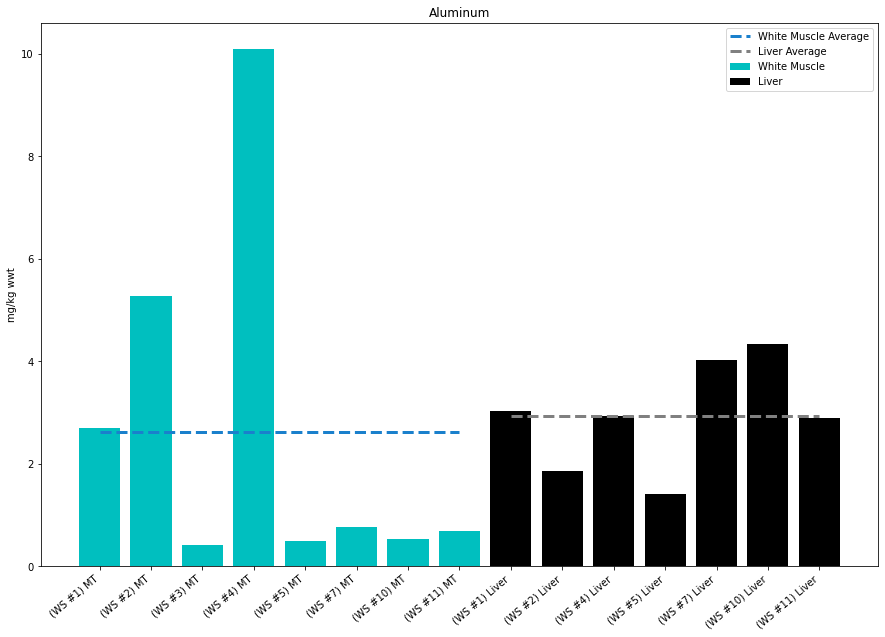

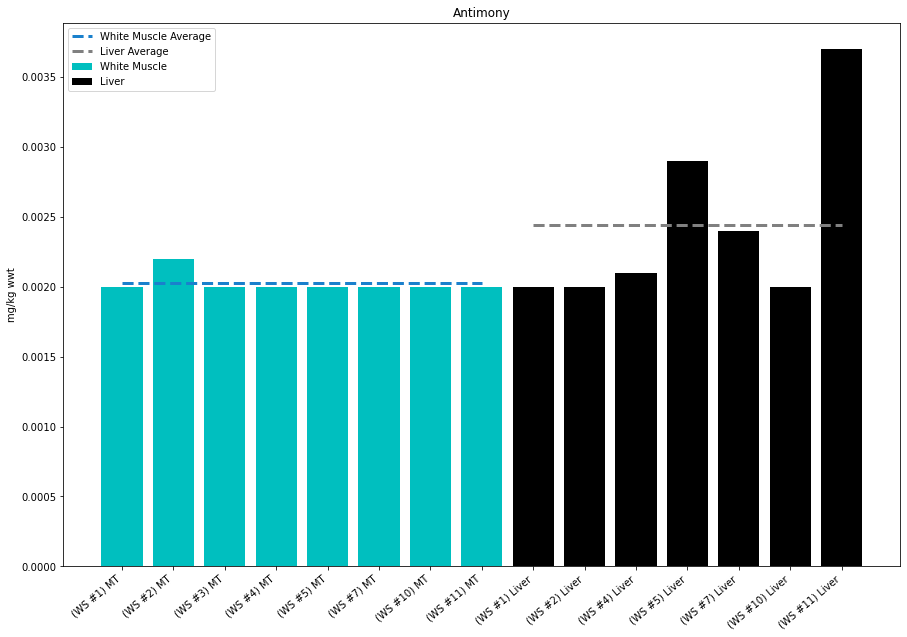

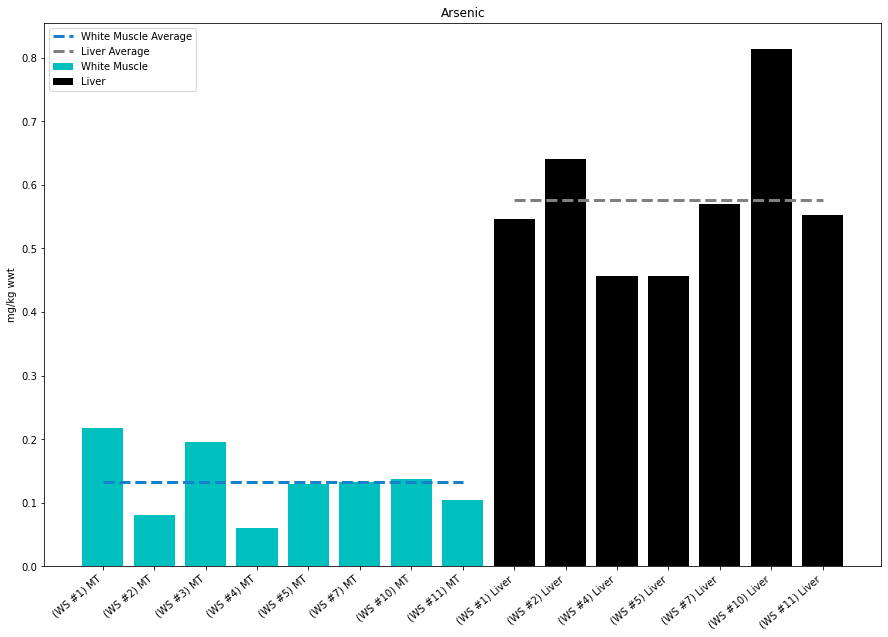

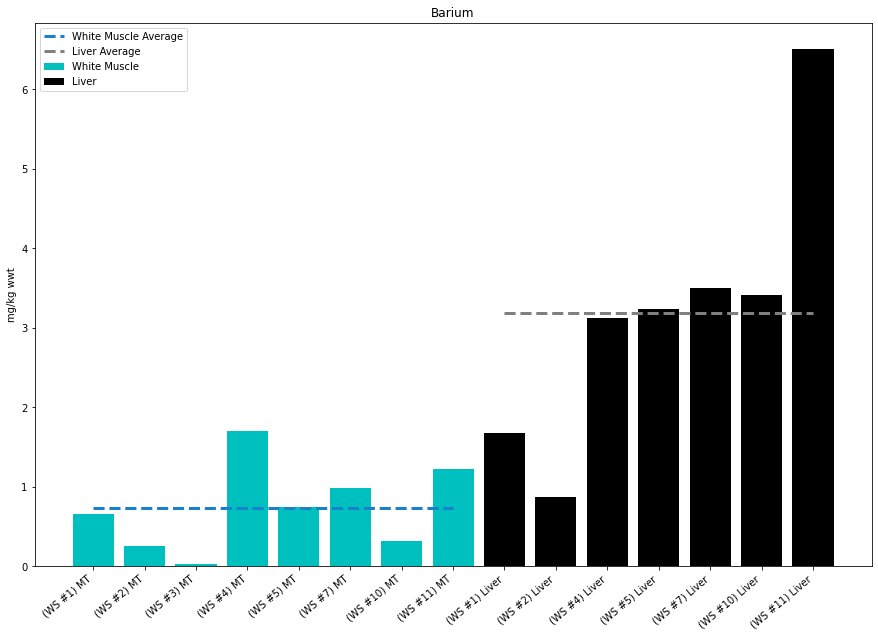

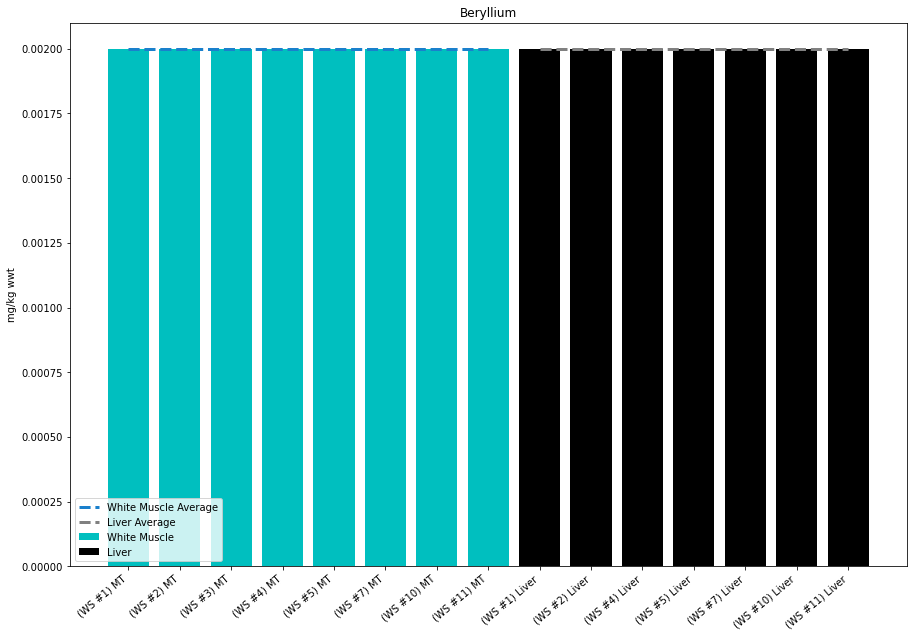

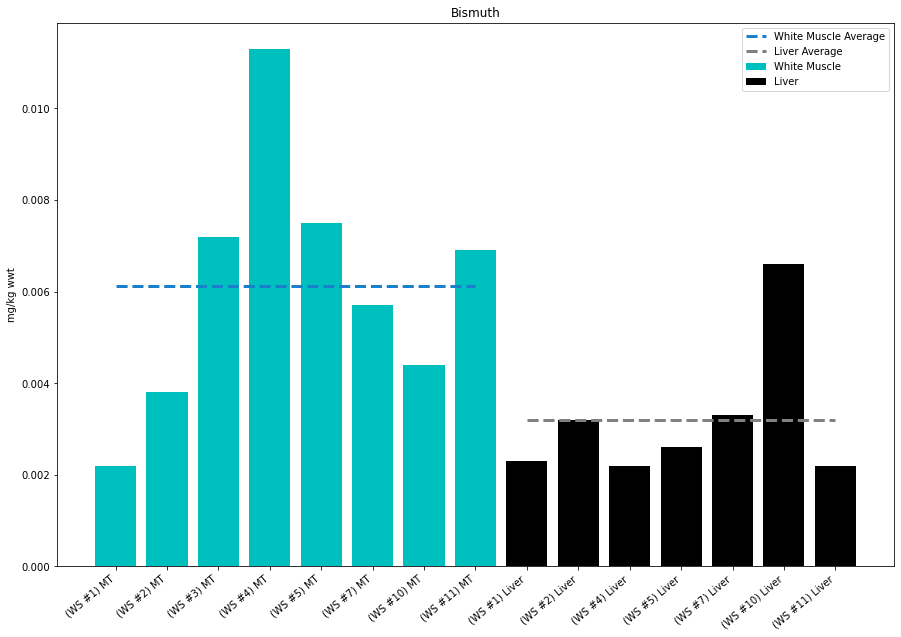

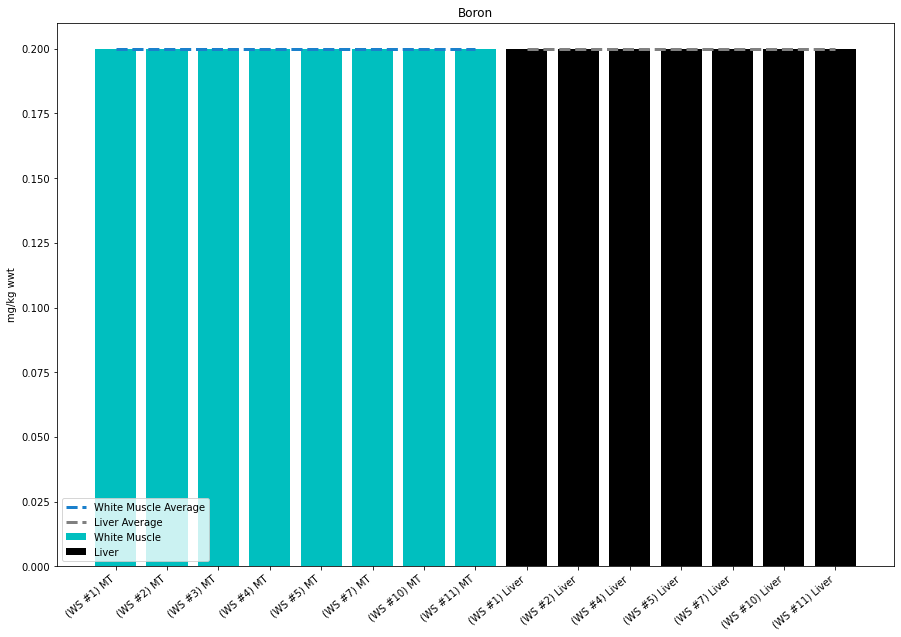

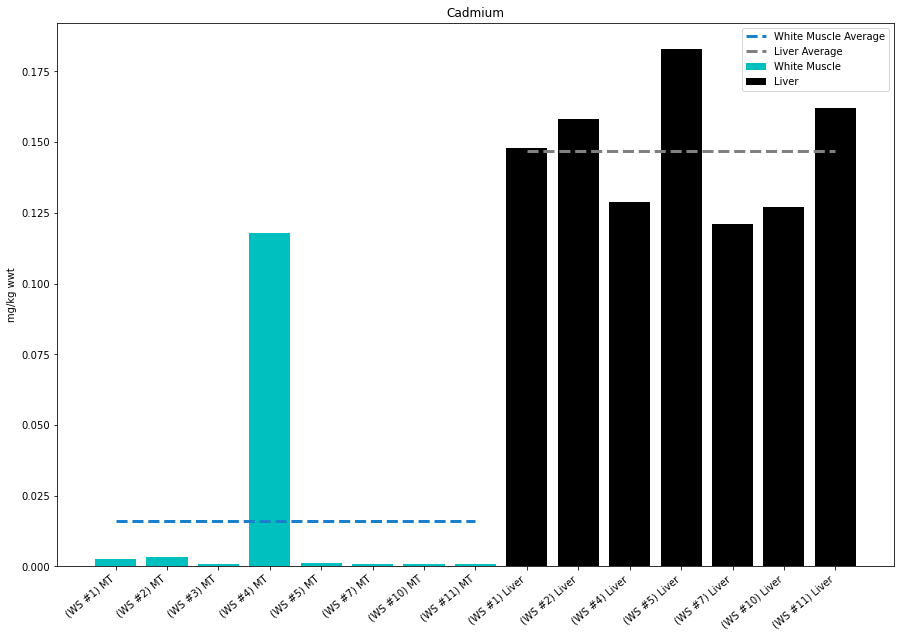

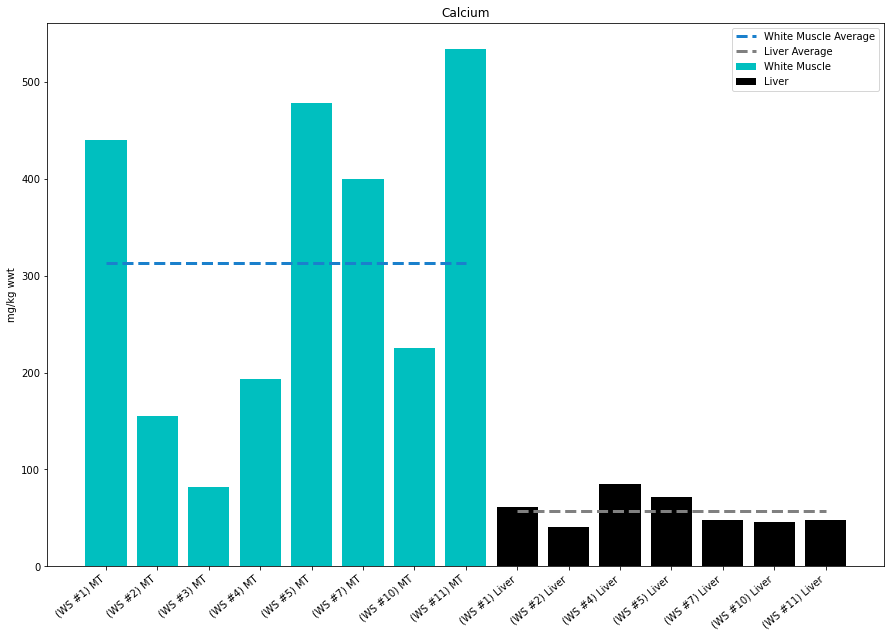

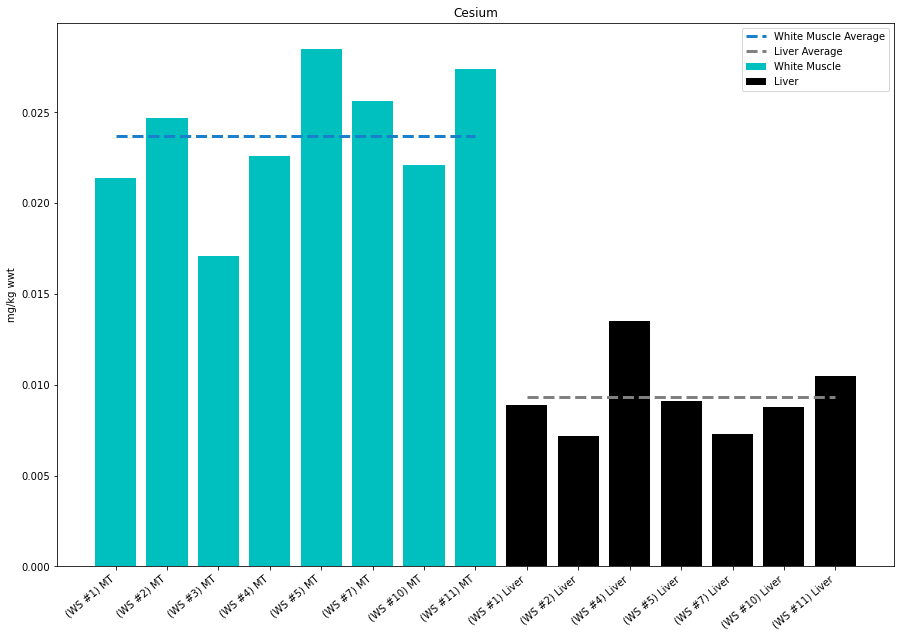

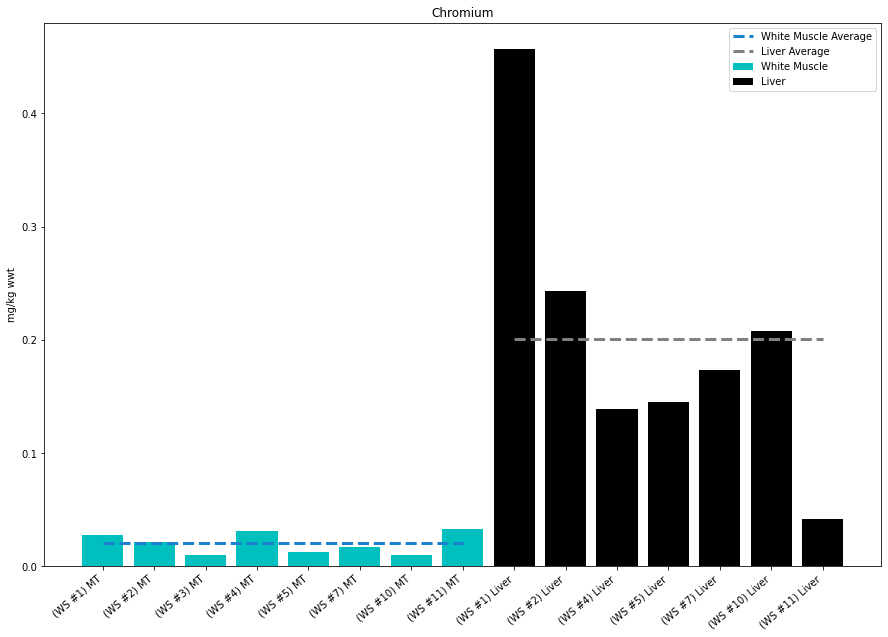

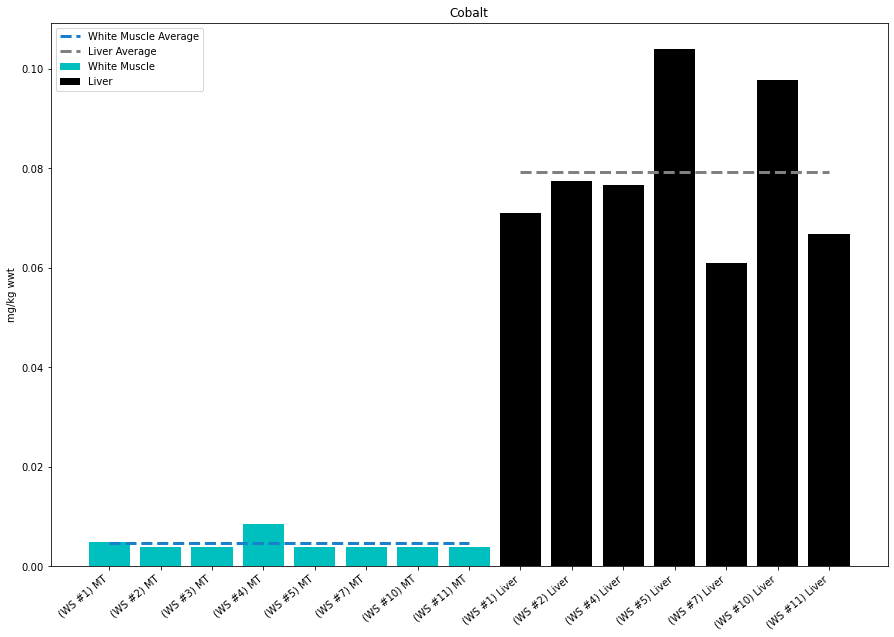

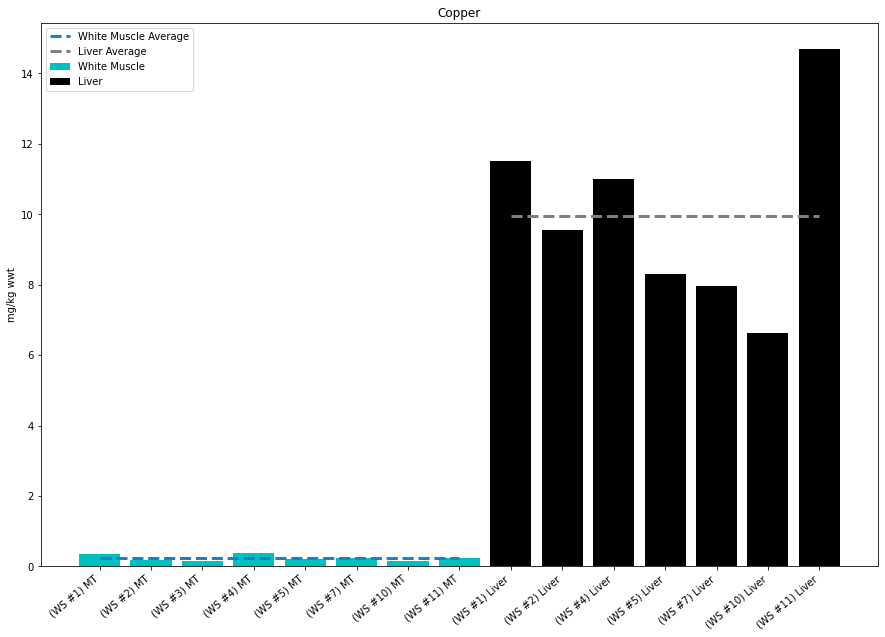

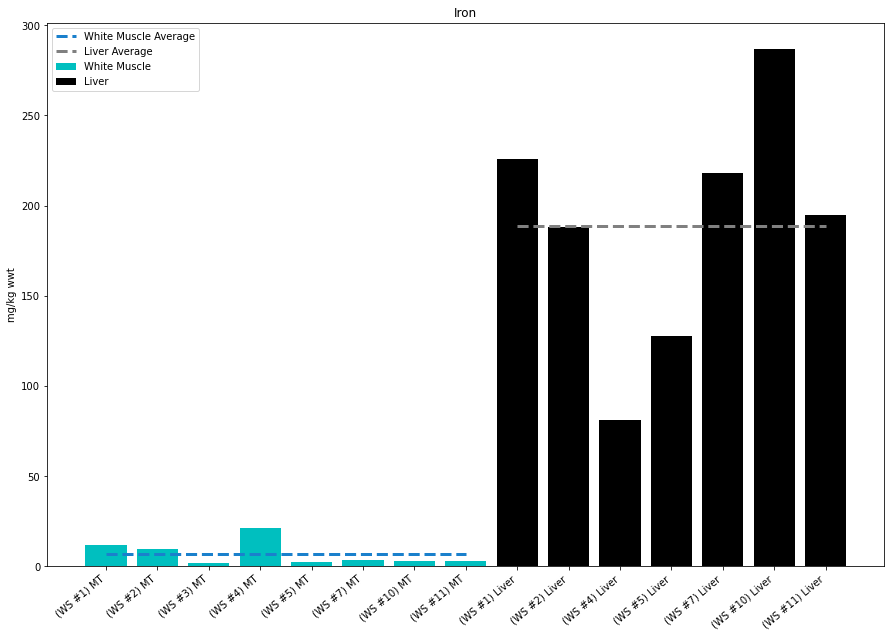

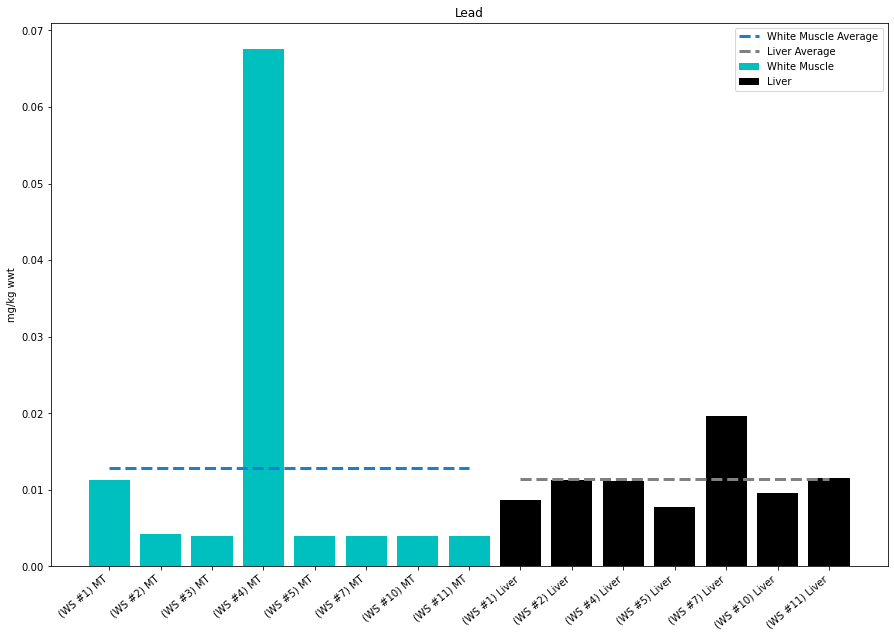

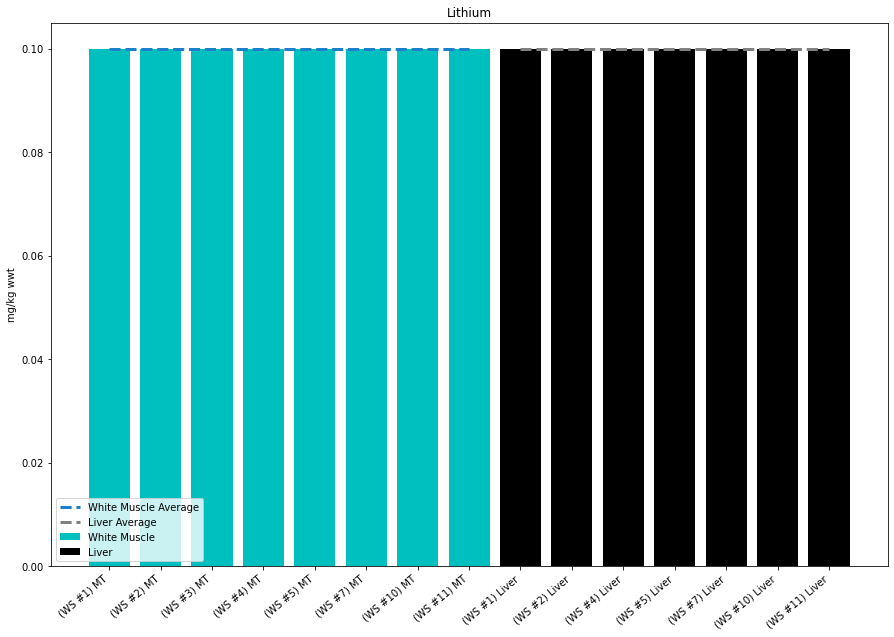

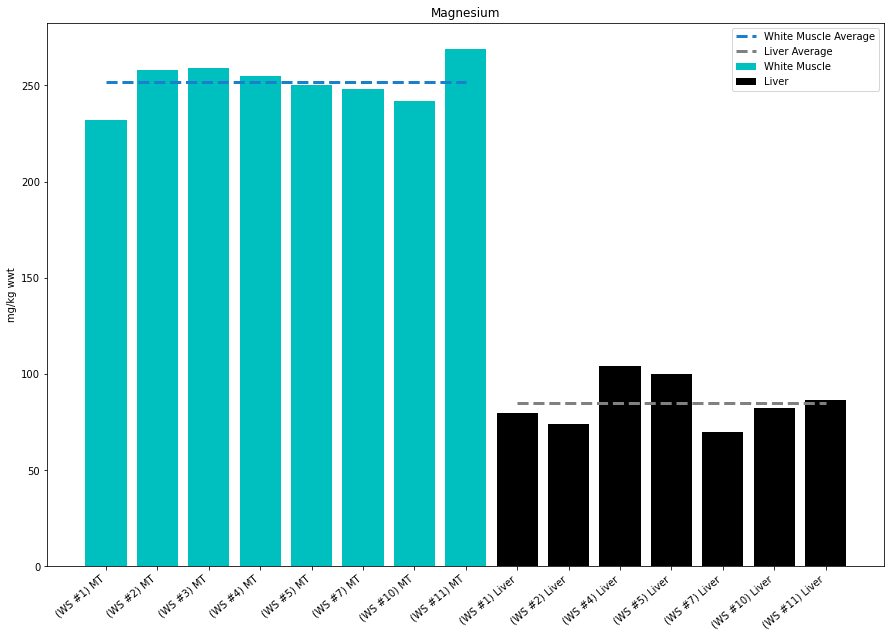

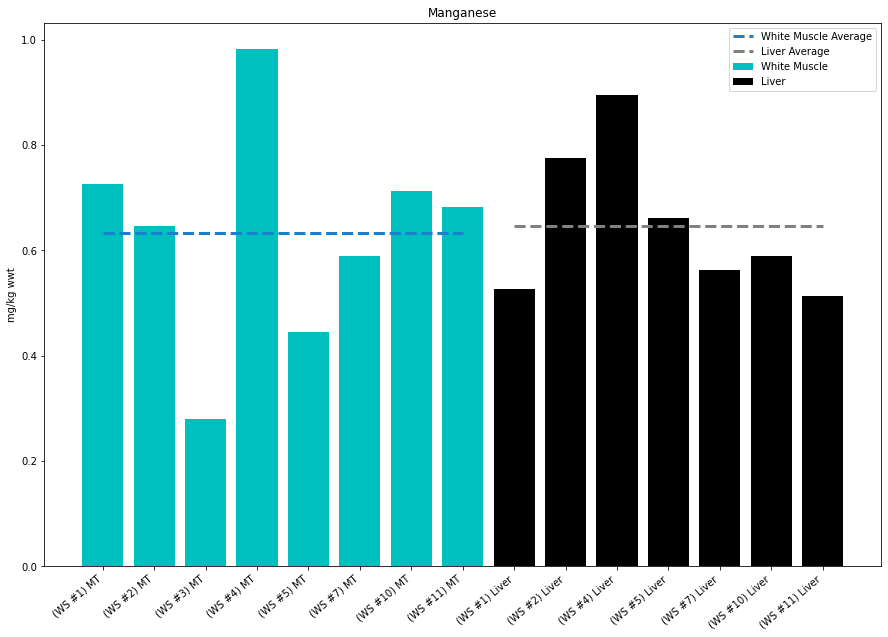

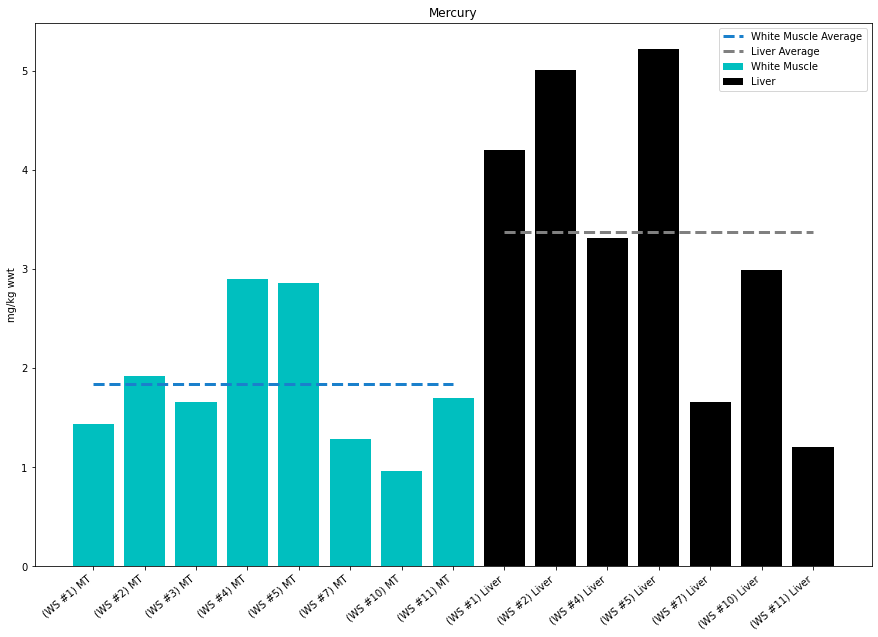

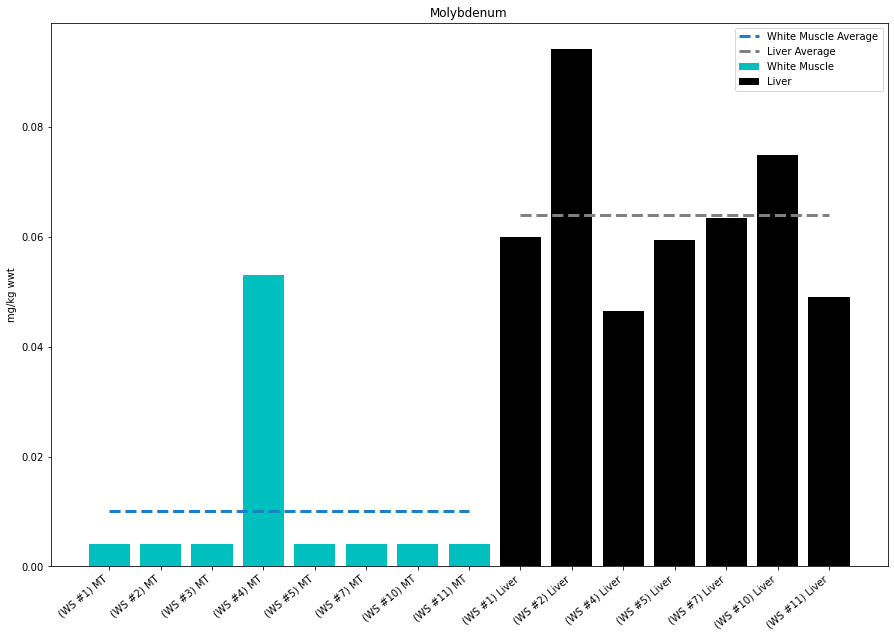

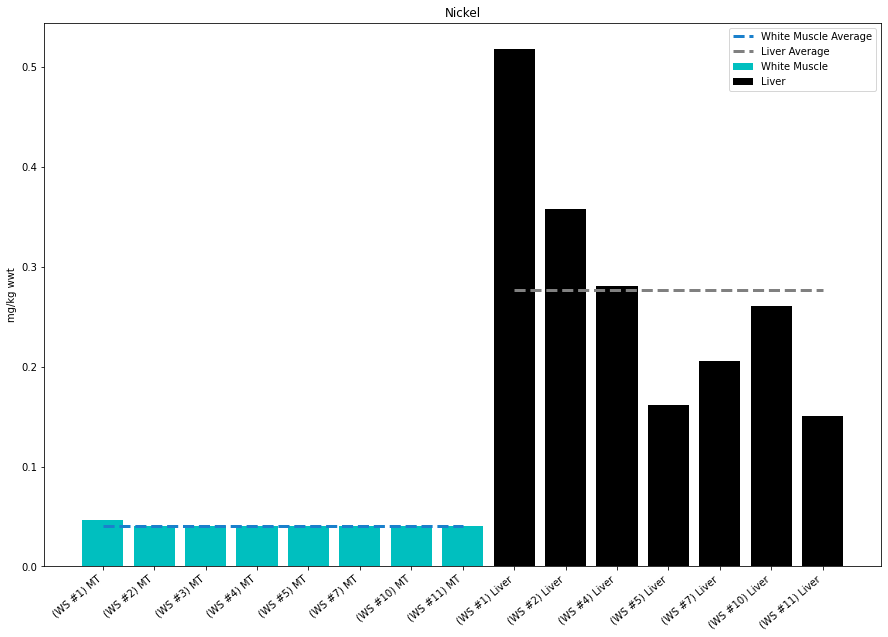

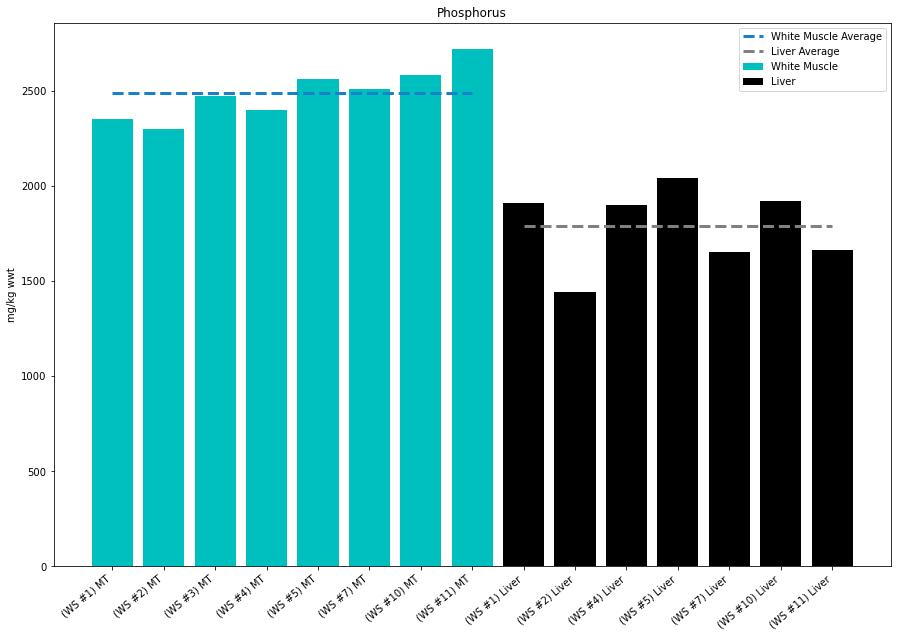

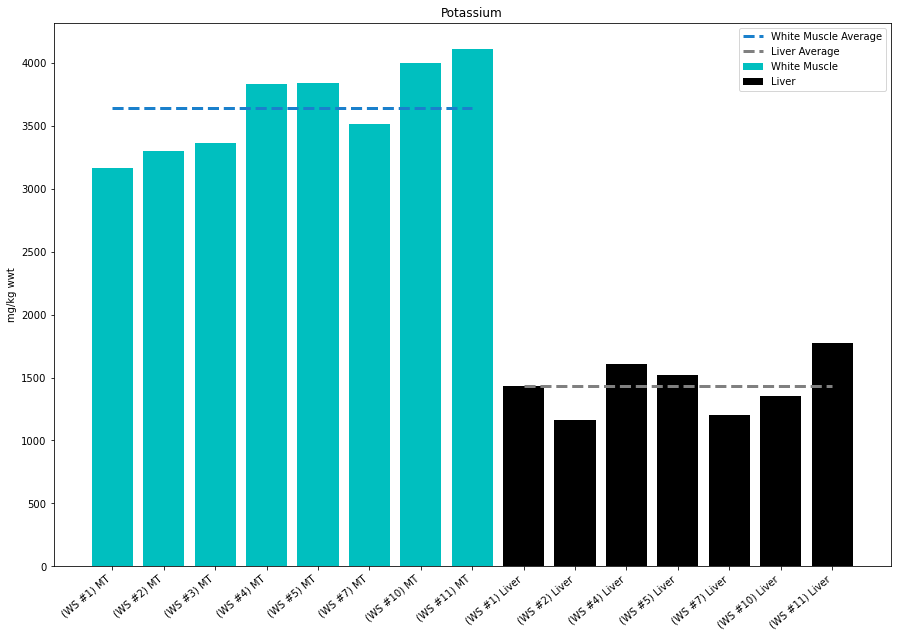

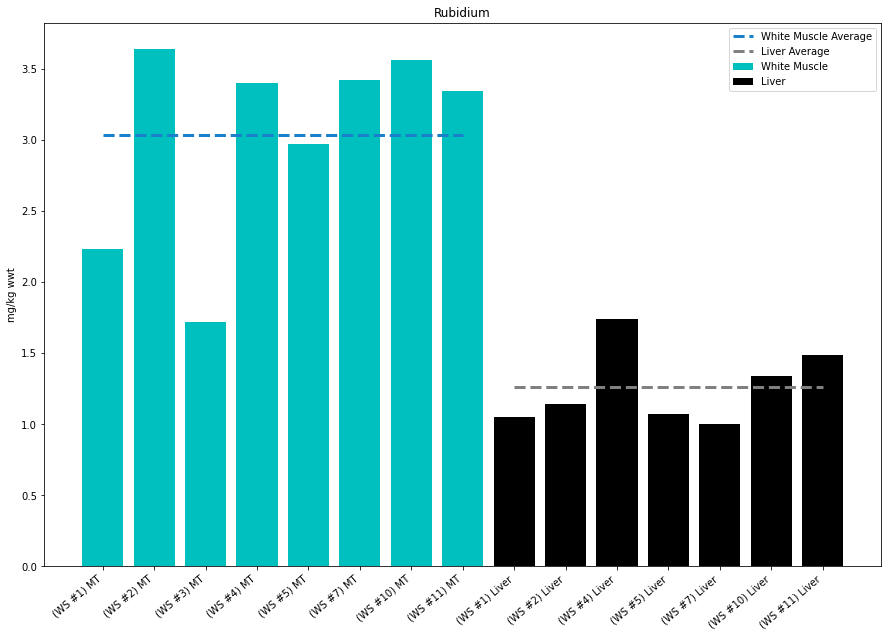

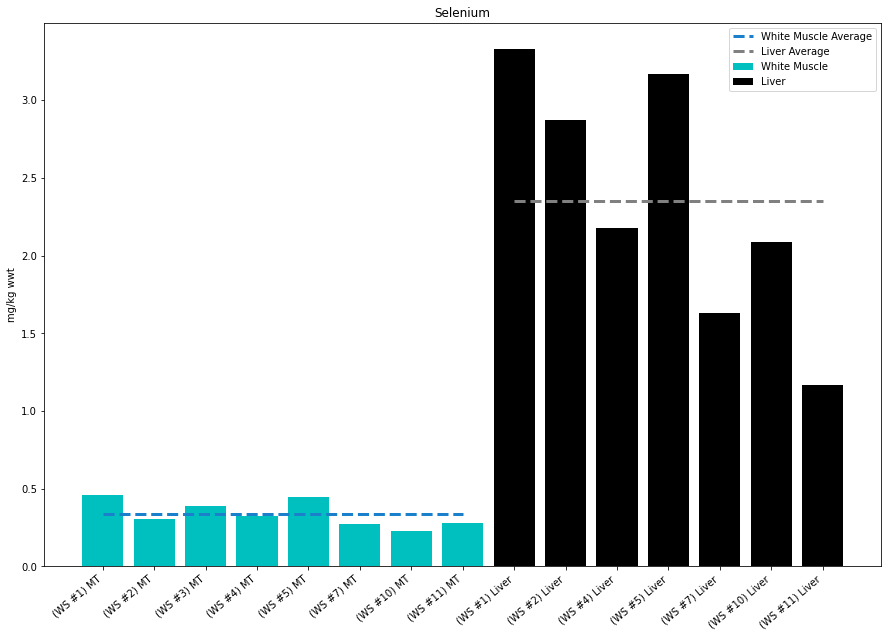

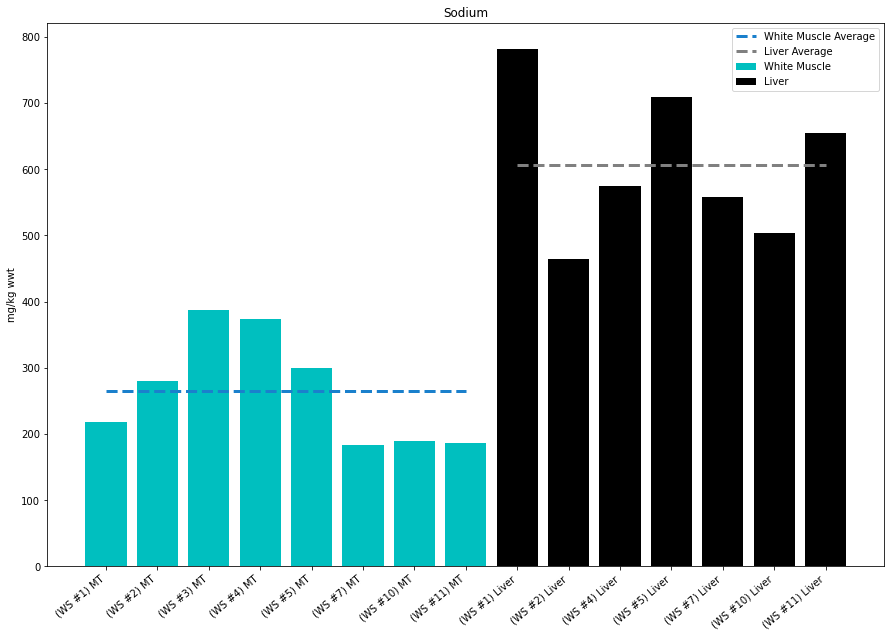

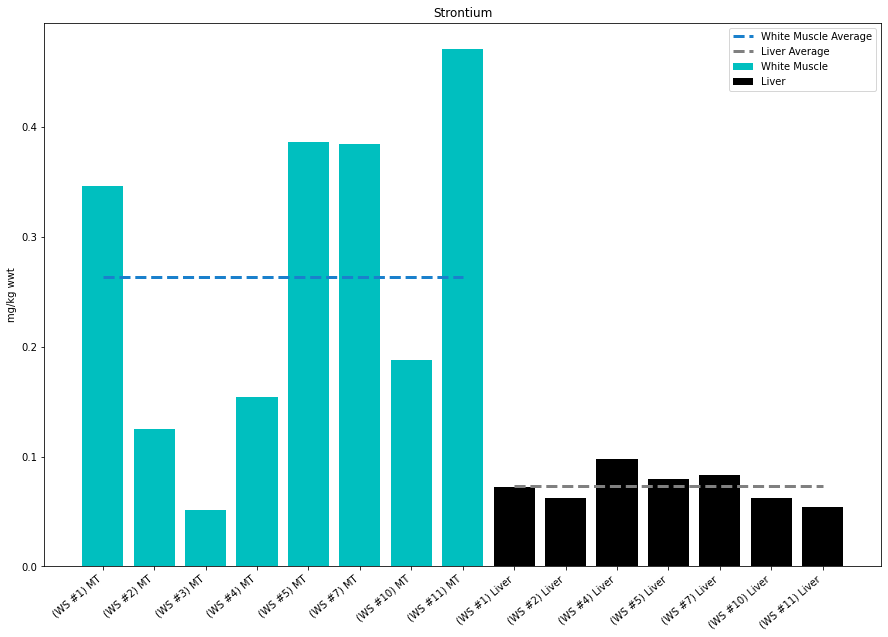

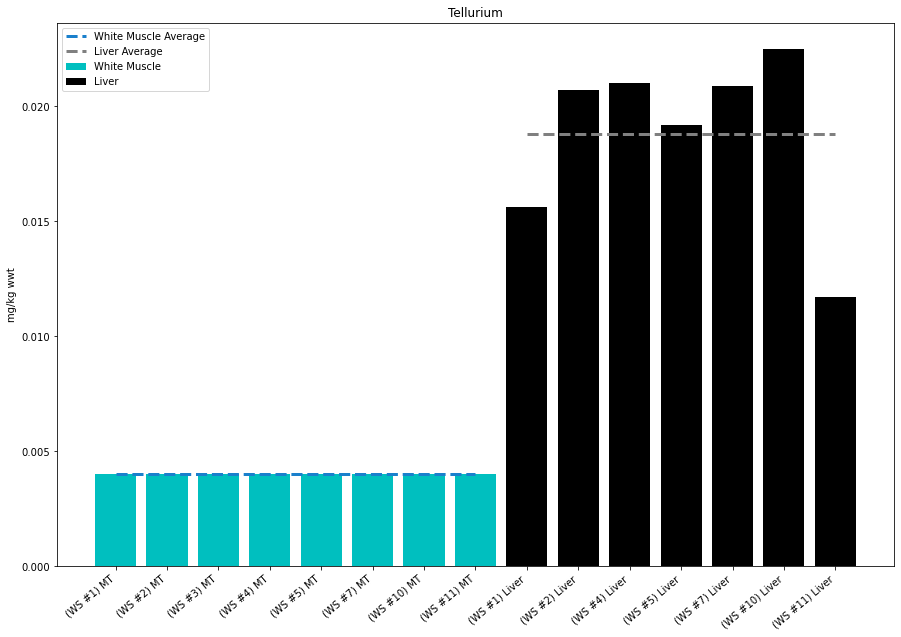

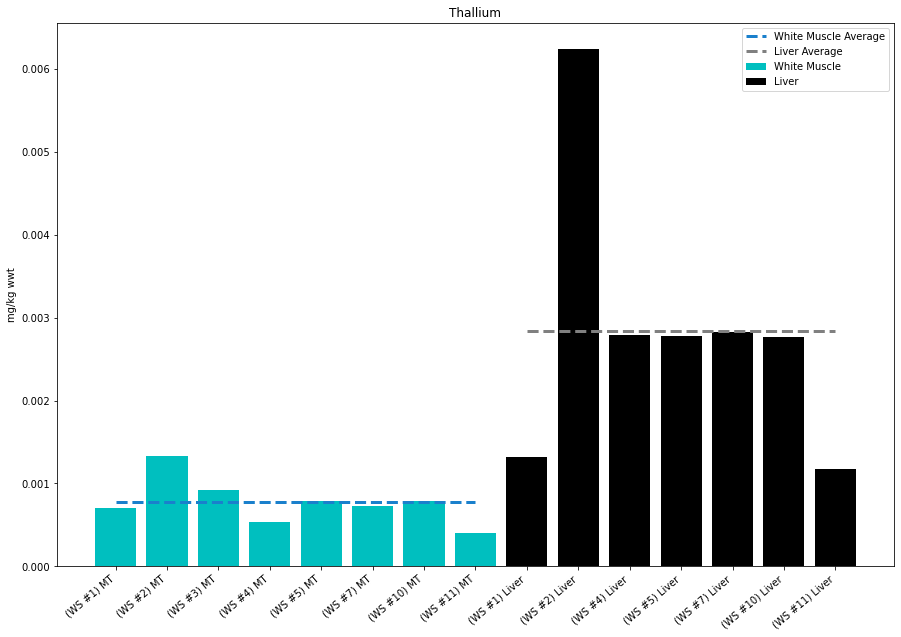

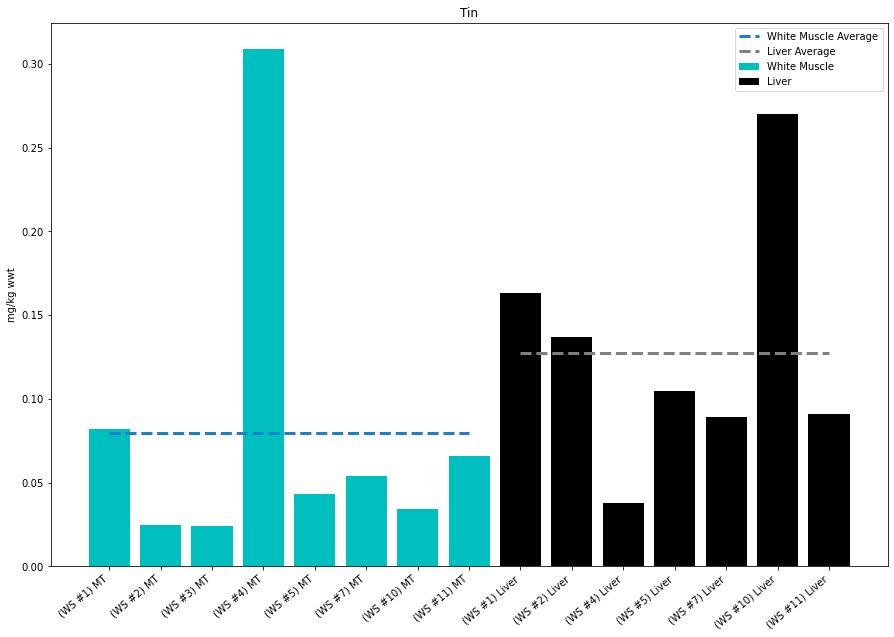

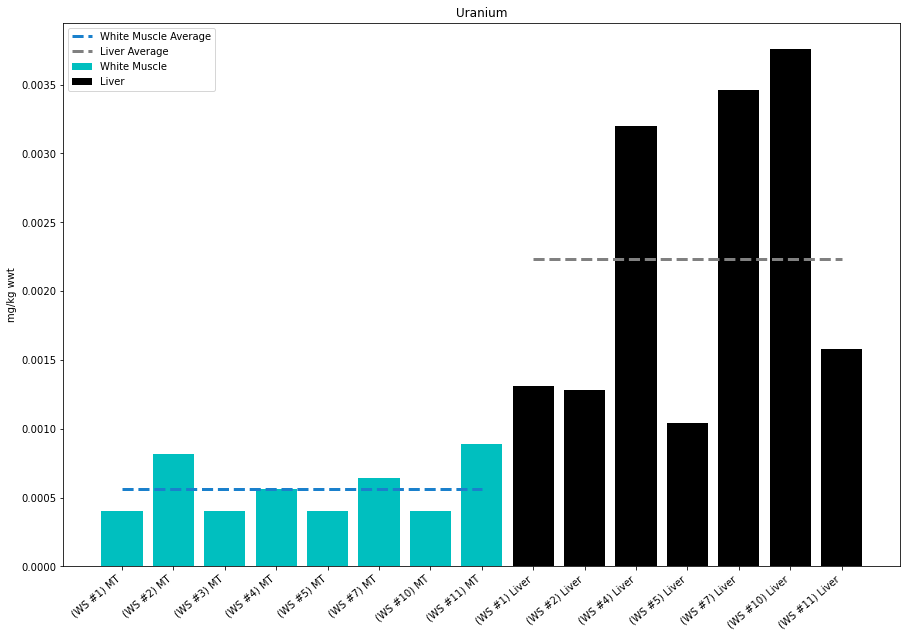

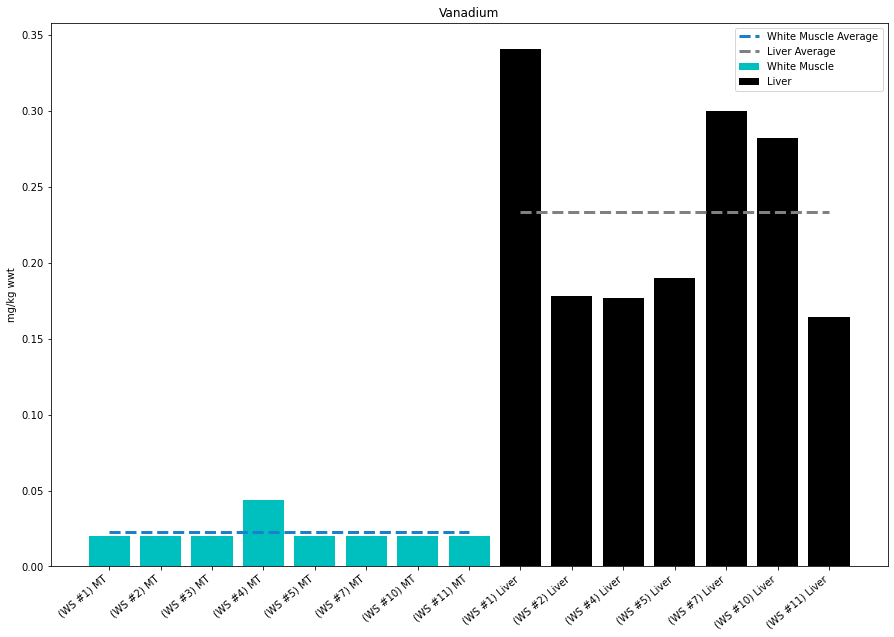

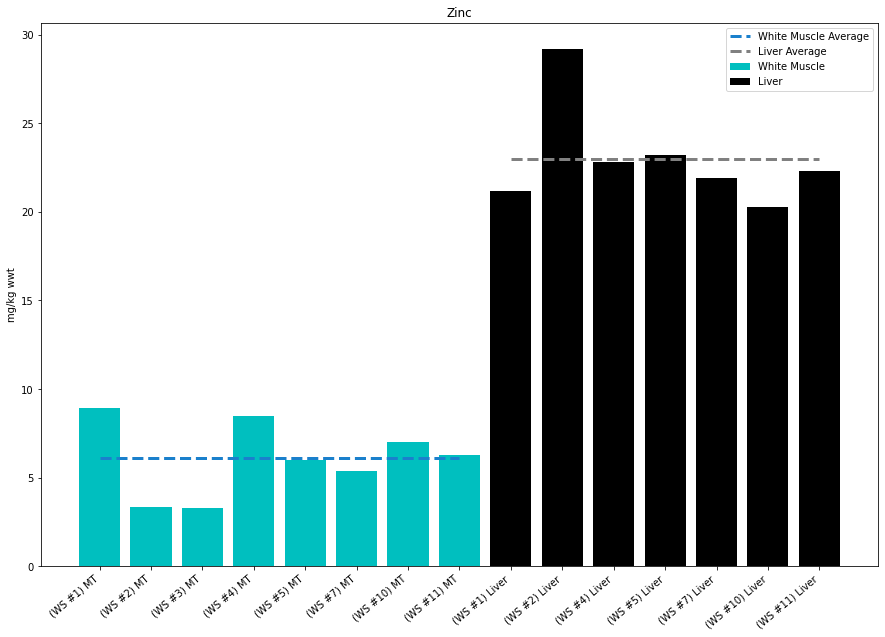

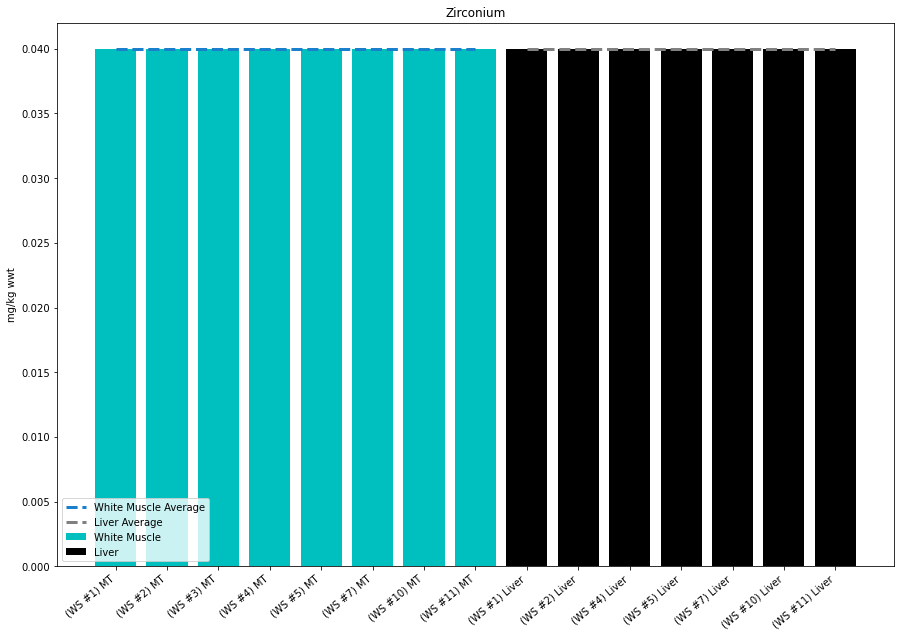

In [426]:
# elements = ["Aluminum", "Zinc", "Mercury"]
## to plot all elements uncomment bellow
elements = data["Analyte"][1::2].to_list()

# to save the picture of an element figure, set the corrosponding value to True
# save_pic = [False, False, True]

## to save all uncomment below
save_pic = np.ones(len(elements), dtype="bool")


x = data.columns[3:]
# seperating liver and mt using columns contatins the word "Li`ver"
Liver_id = x.str.contains("Liver")
id_13 = x.str.contains("#13")
for i in np.arange(len(elements)):
    # creating figure
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.set_facecolor("White")
    # obtaining related data
    values = np.array(data[np.logical_and(data["Analyte"] == elements[i], data["Units"] == "mg/kg wwt")].to_numpy()[:, 3:].ravel(), dtype=float)
    # bar ploting mt
    ax.bar(x[(~Liver_id) & (~id_13)], values[(~Liver_id) & (~id_13)], color = "c", label="White Muscle")
    # bar ploting liver
    ax.bar(x[Liver_id & (~id_13)], values[Liver_id & (~id_13)], color = "k", label="Liver")
    # ploting mean of mt
    ax.plot(x[(~Liver_id) & (~id_13)], np.mean(values[(~Liver_id) & (~id_13)]) * np.ones(x[(~Liver_id) & (~id_13)].shape), color = [0.1, 0.5, 0.8], label = "White Muscle Average", linestyle = "dashed", linewidth = 3)
    # ploting mean of liver
    ax.plot(x[Liver_id & (~id_13)], np.mean(values[Liver_id & (~id_13)]) * np.ones(x[Liver_id & (~id_13)].shape), color = "gray", label = "Liver Average", linestyle = "dashed", linewidth = 3)
    # setting axis side names
    ax.set_xlabel("")
    ax.set_ylabel("mg/kg wwt")
    ax.set_title(elements[i])
    # setting xticks and xtick labels
    ax.xaxis.set_ticks(np.arange(data.shape[1]-5))
    ax.xaxis.set_ticklabels(x[~id_13].str.removeprefix("White Sturgeon "), rotation = 40, ha = "right")
    # enabling legend
    ax.legend()
    if not os.path.exists("./pics/plot/"):
        os.makedirs("./pics/plot/")
    if save_pic[i] == True:
        fig.savefig("./pics/plot/"+elements[i]+".png")

### 13 added

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/3884161041.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 10))


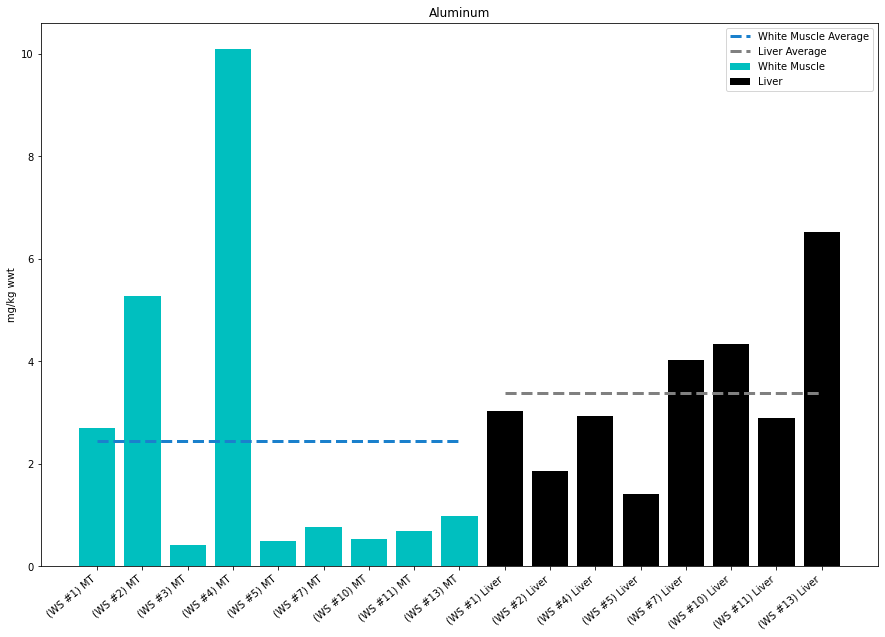

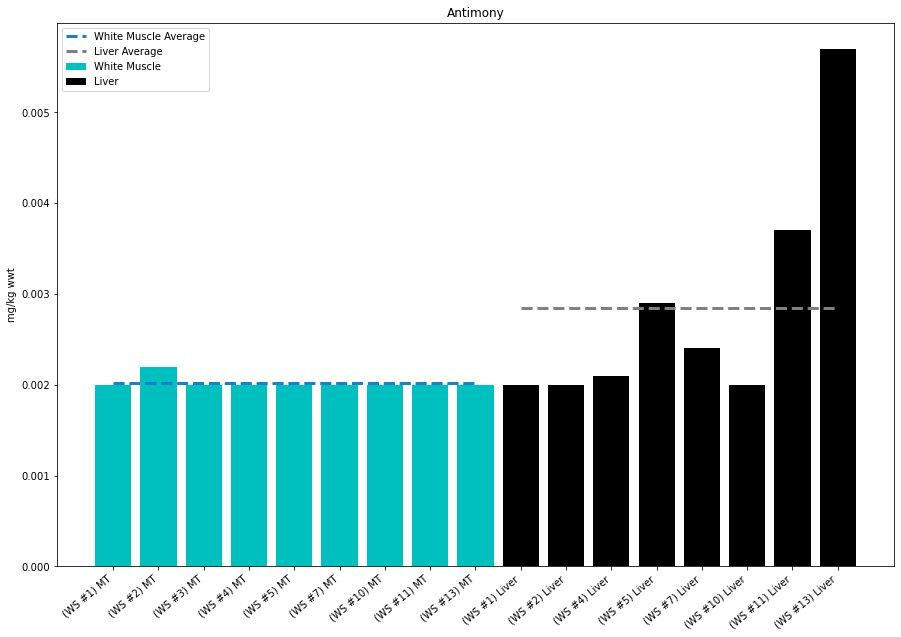

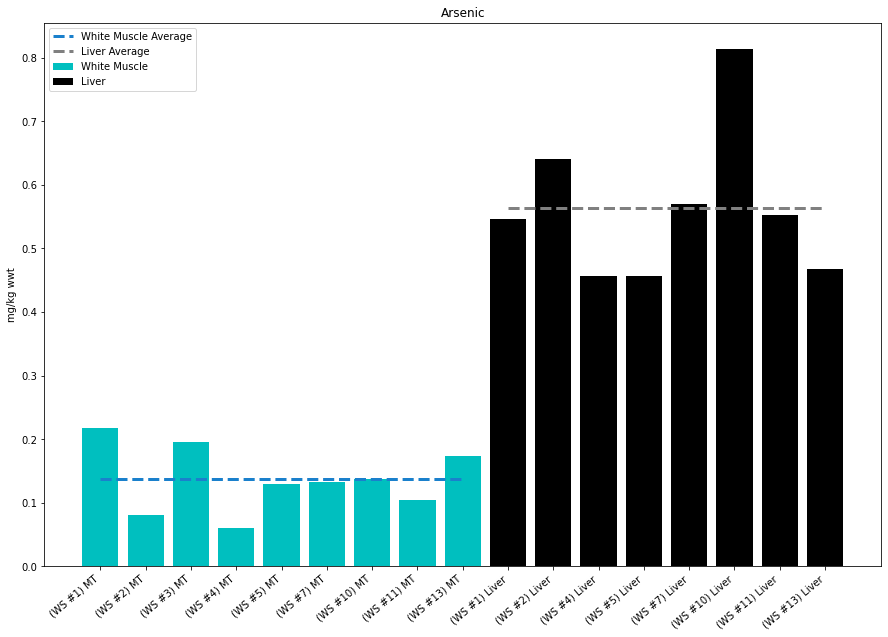

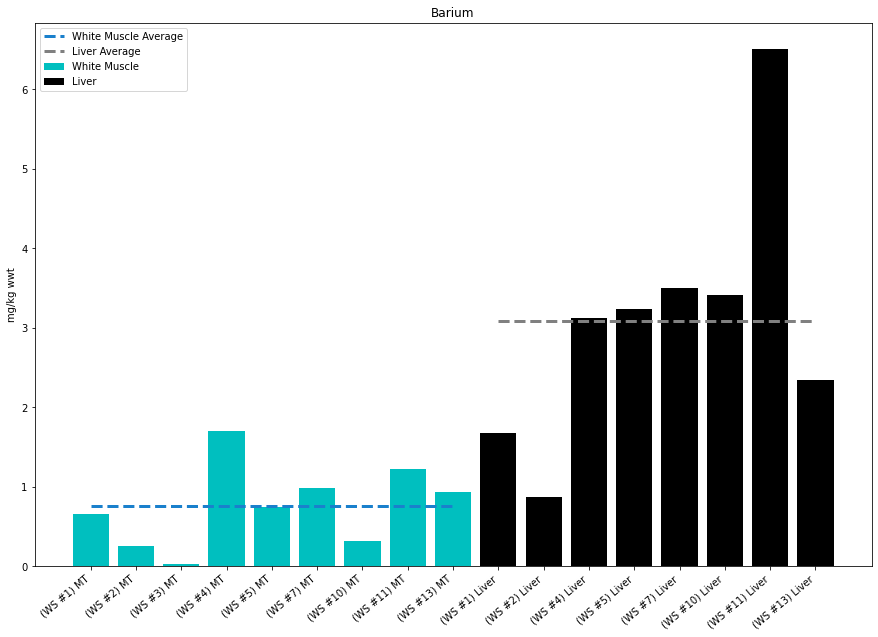

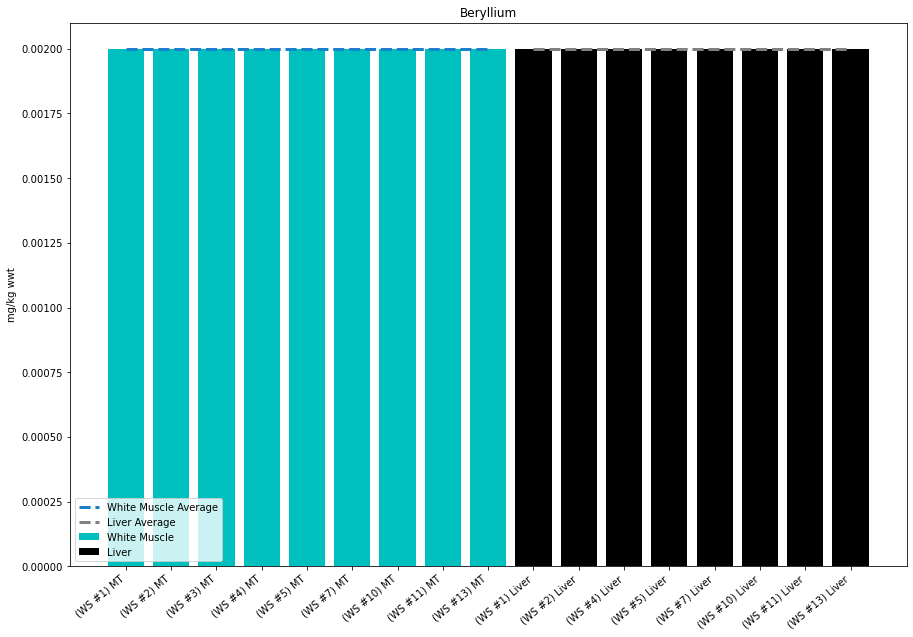

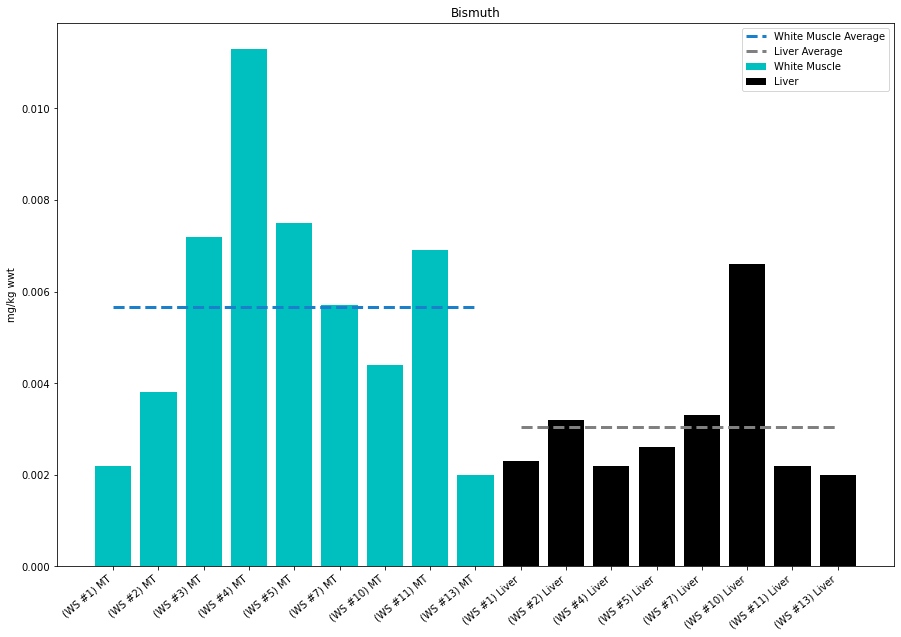

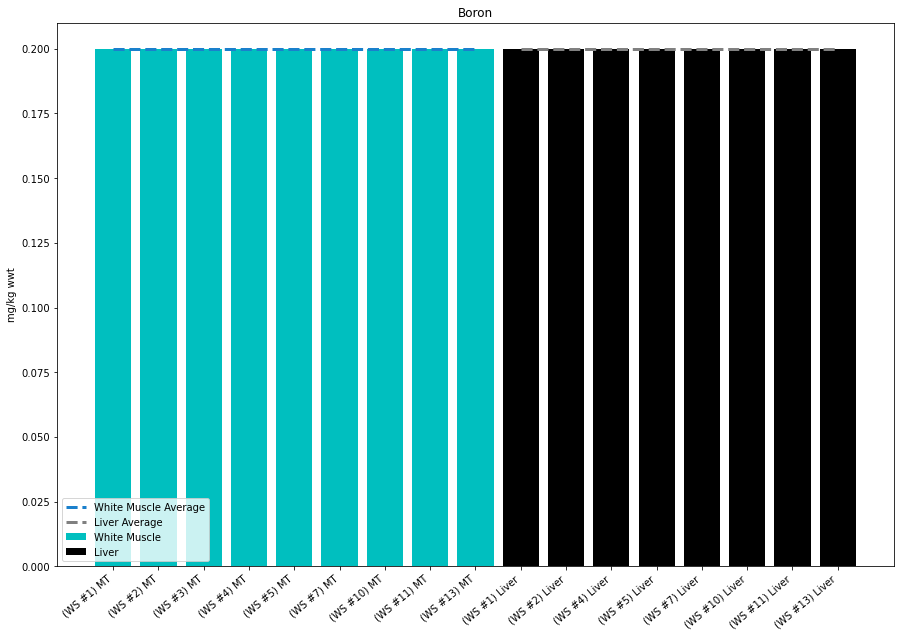

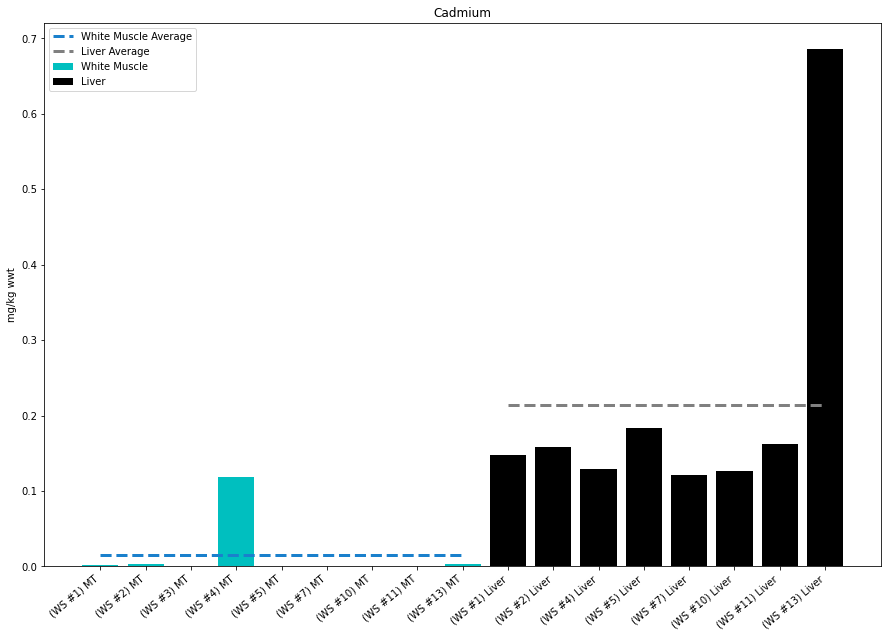

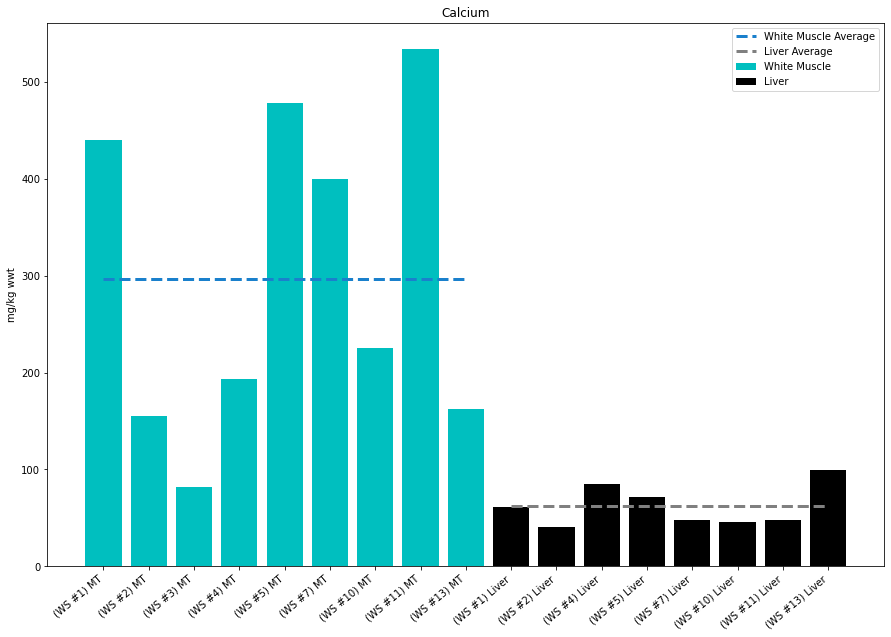

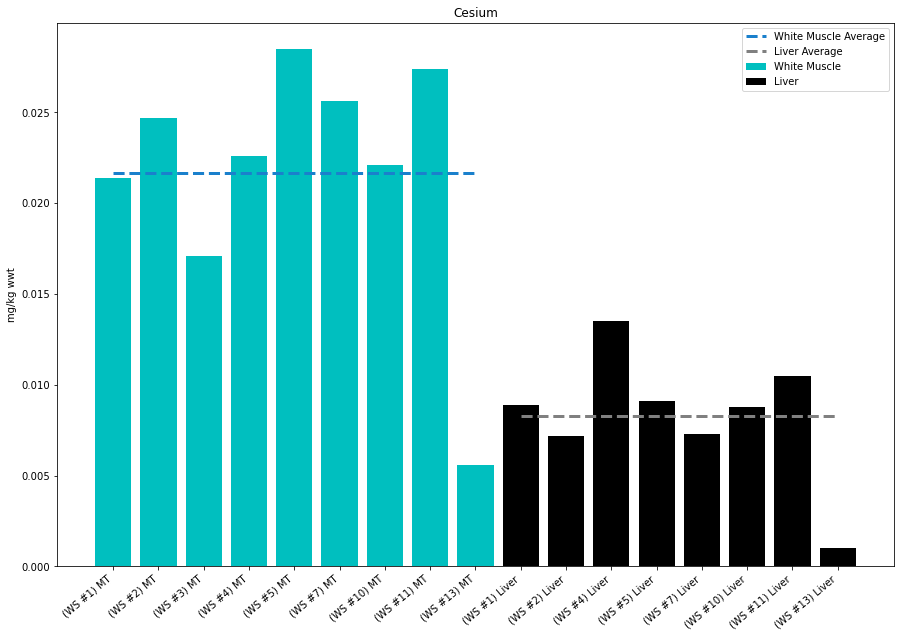

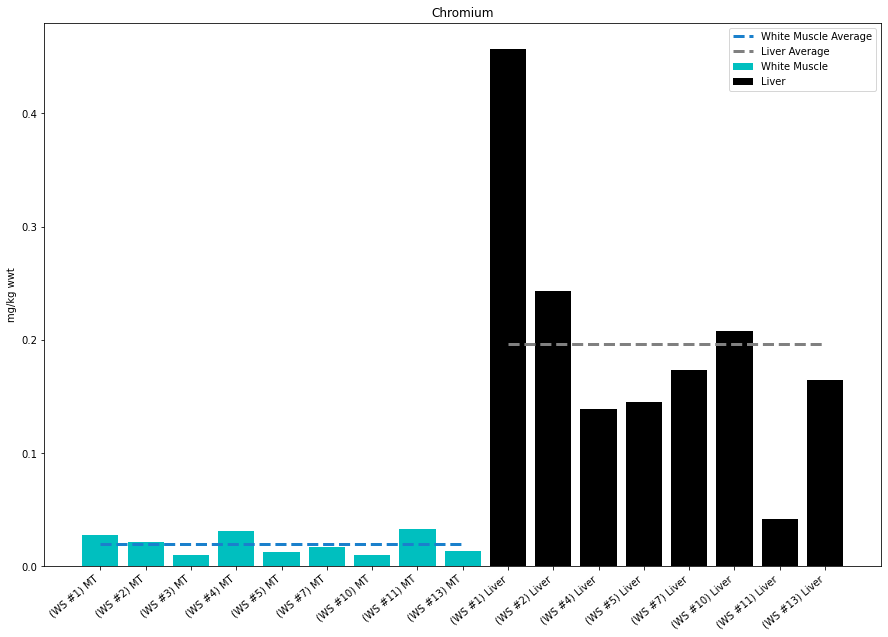

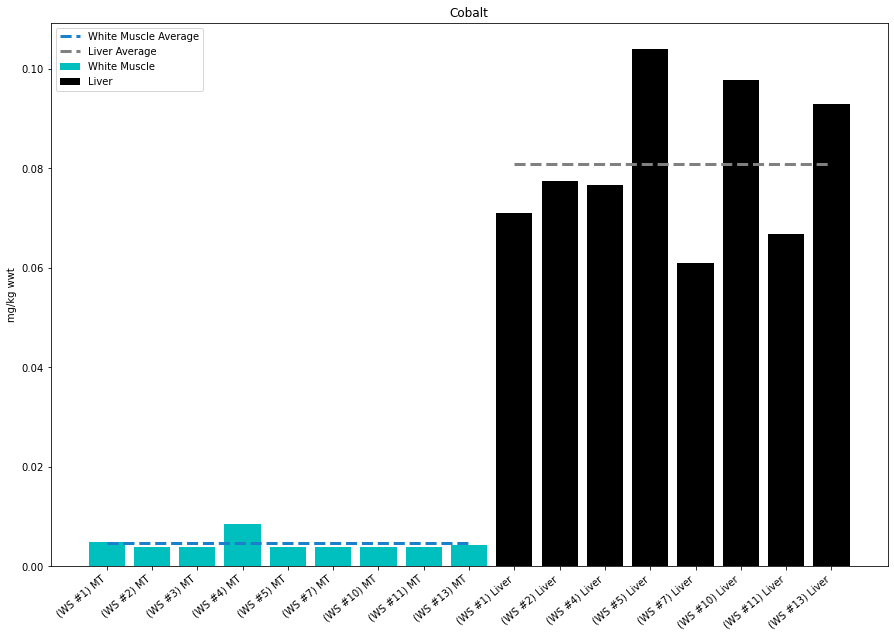

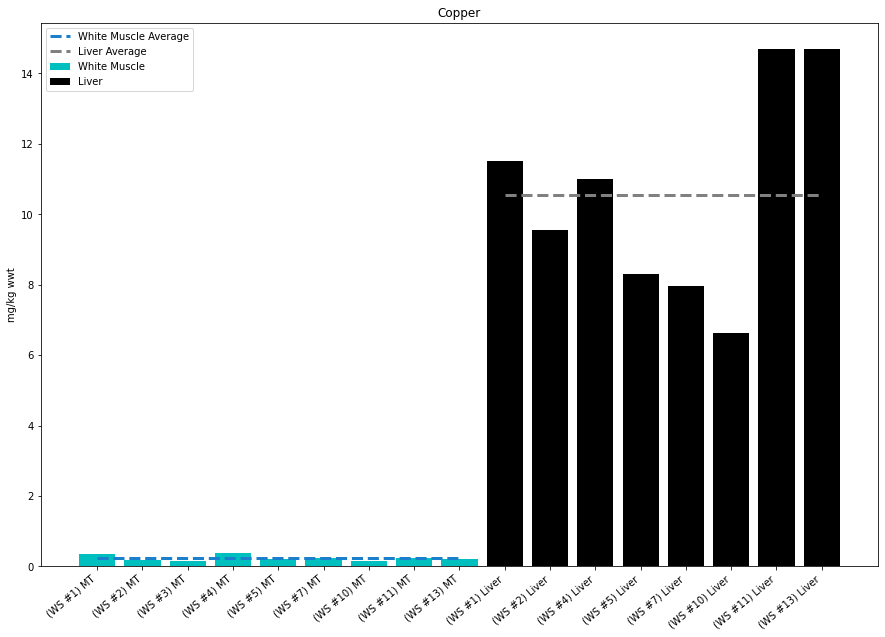

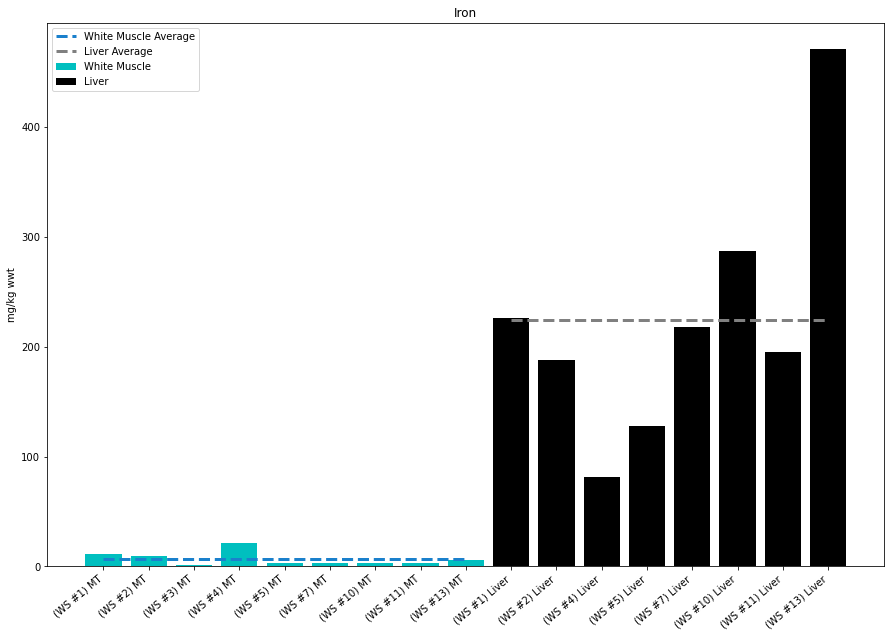

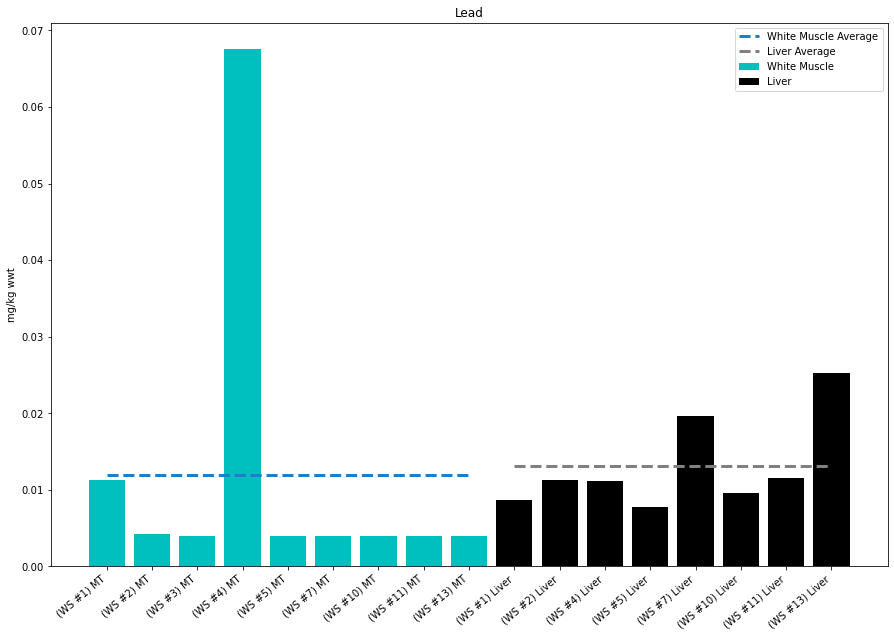

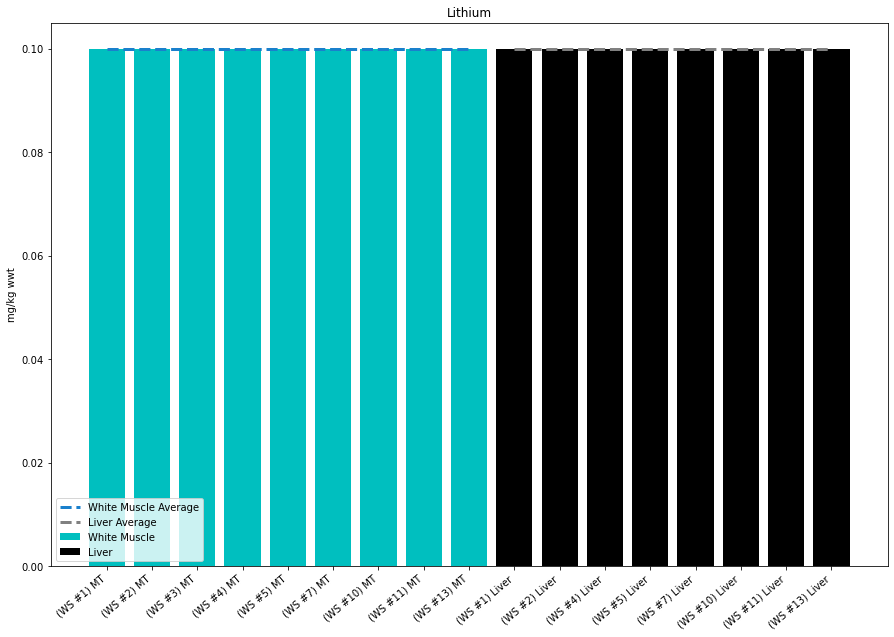

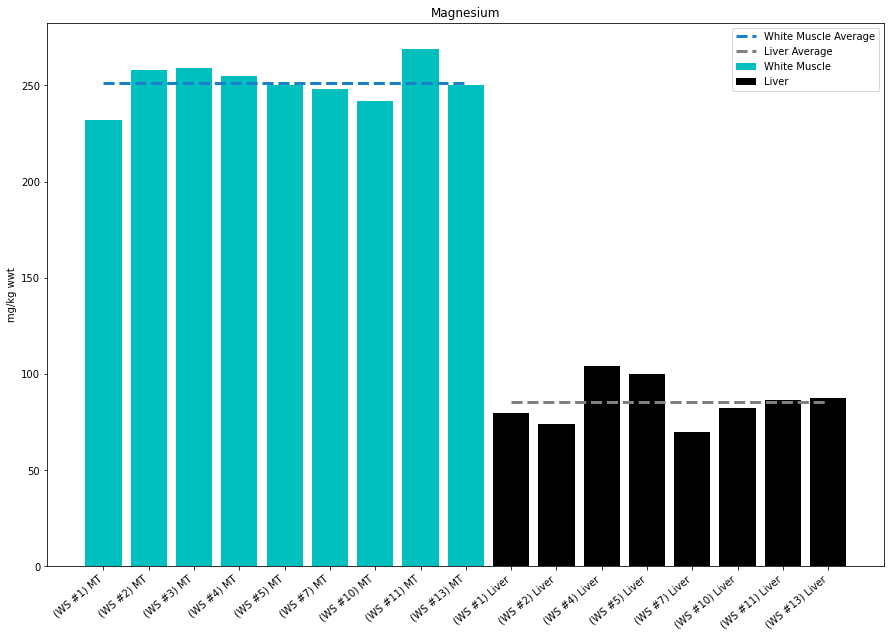

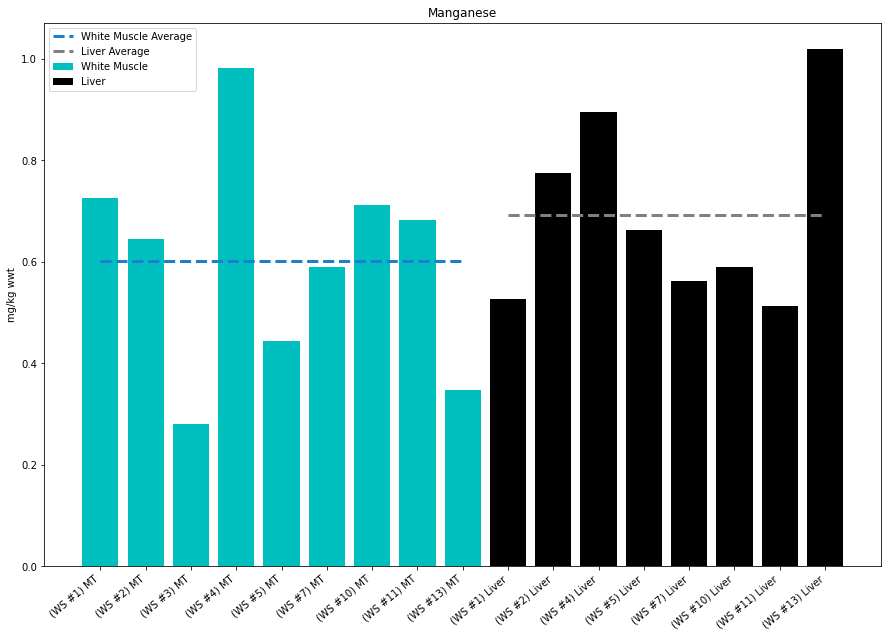

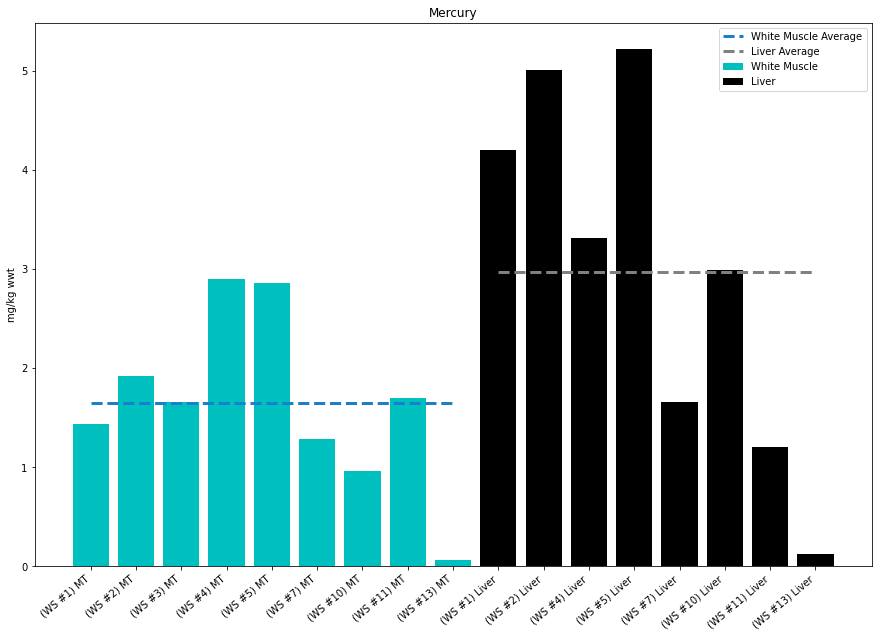

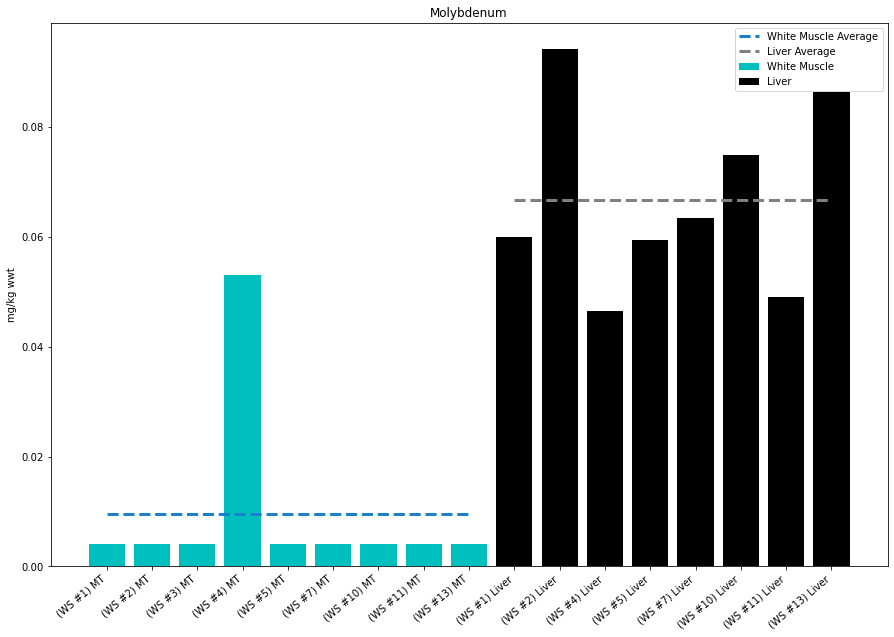

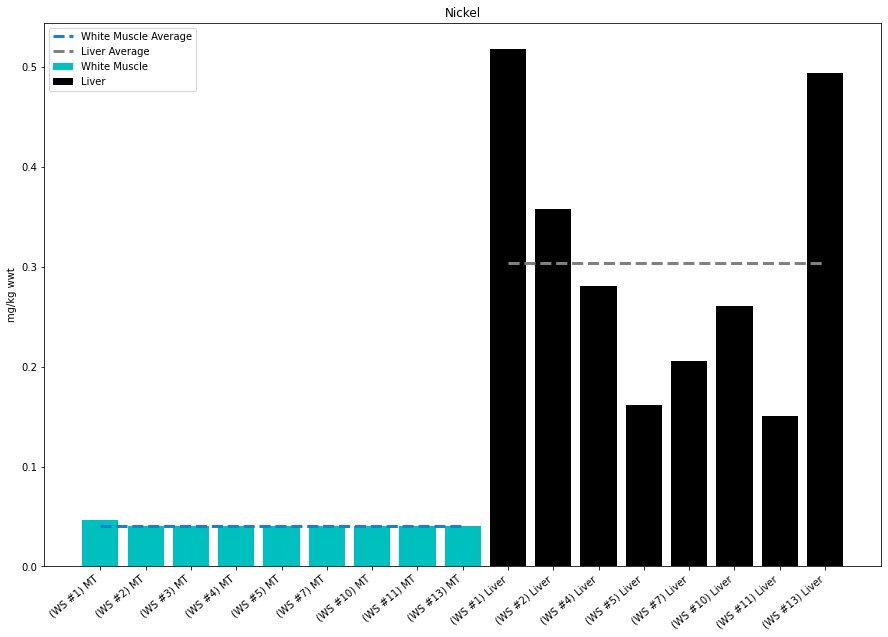

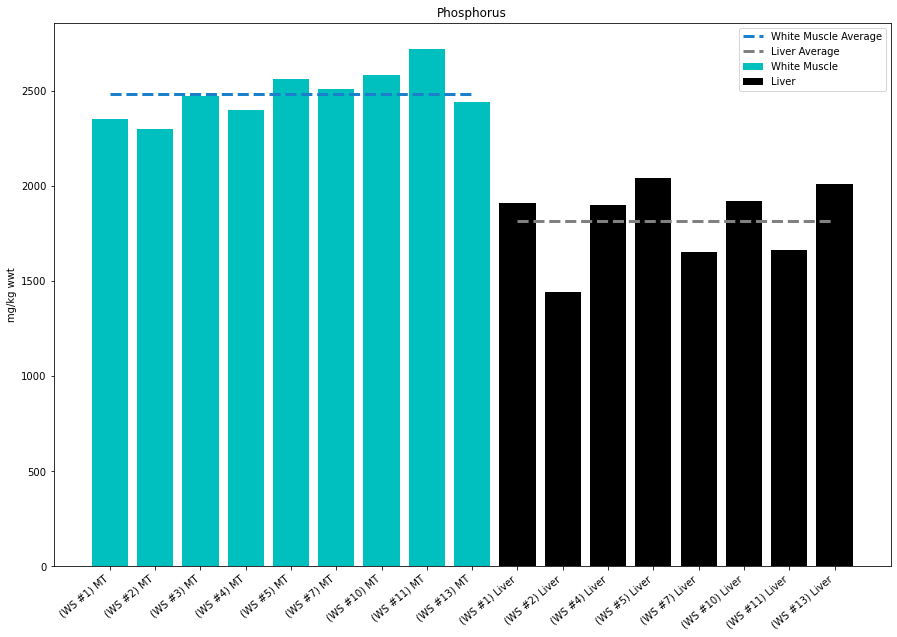

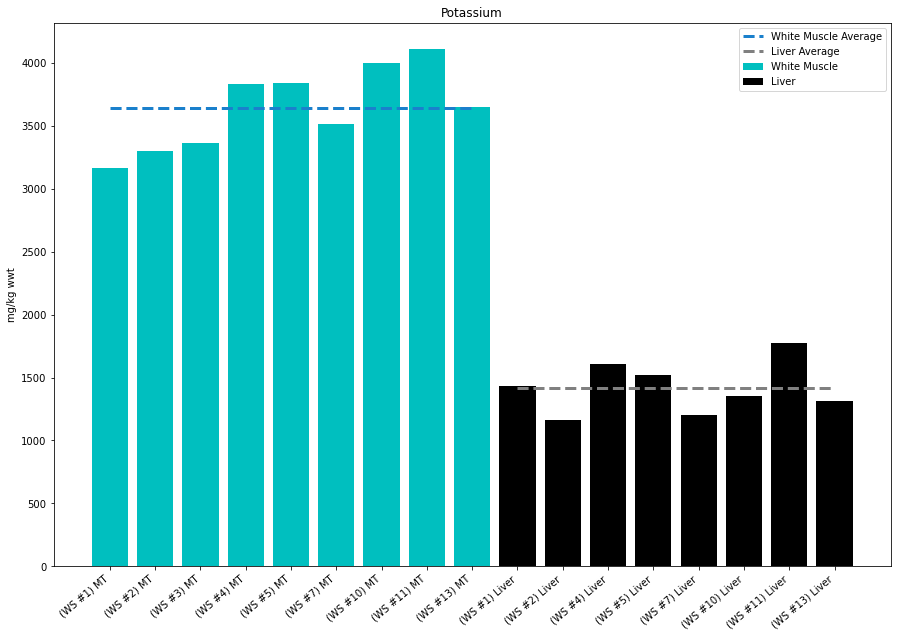

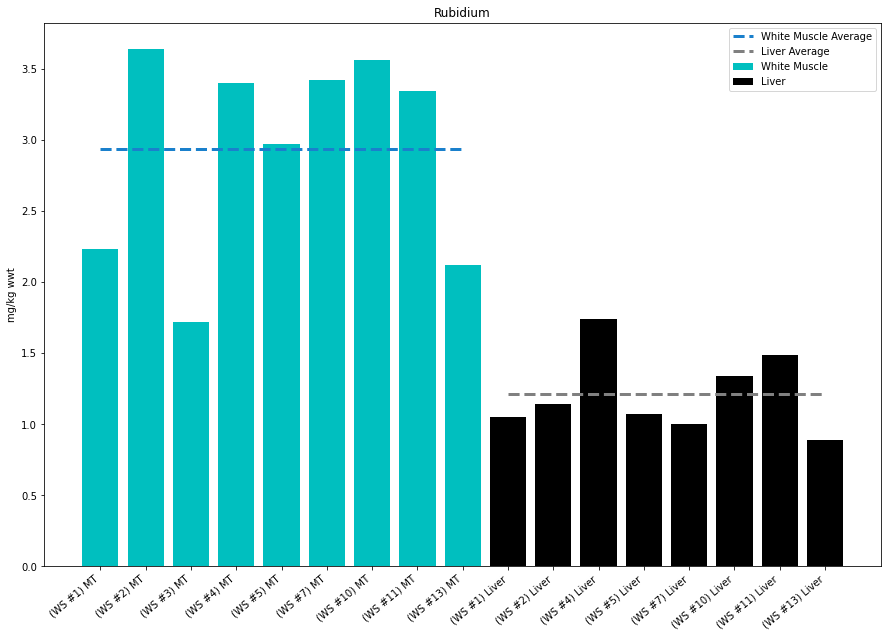

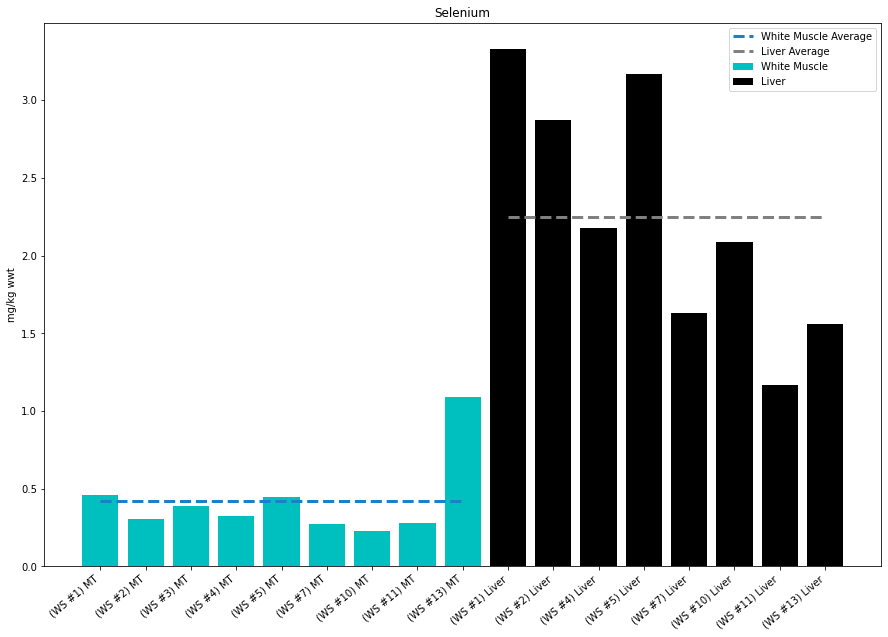

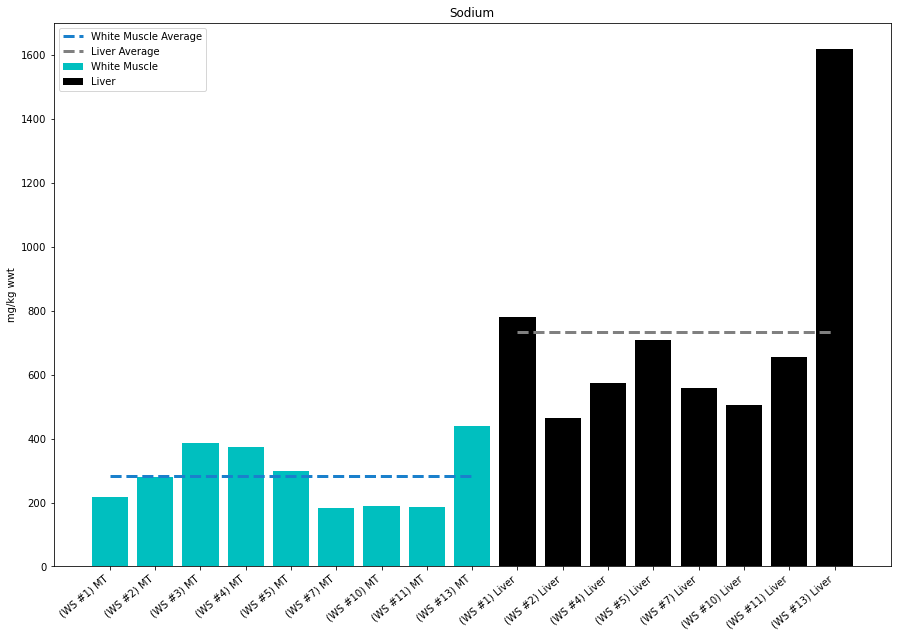

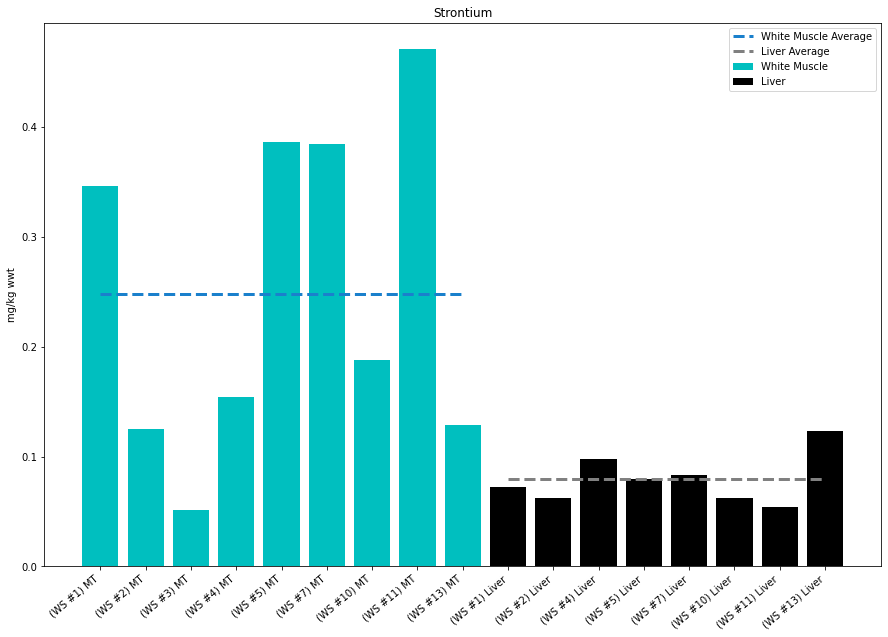

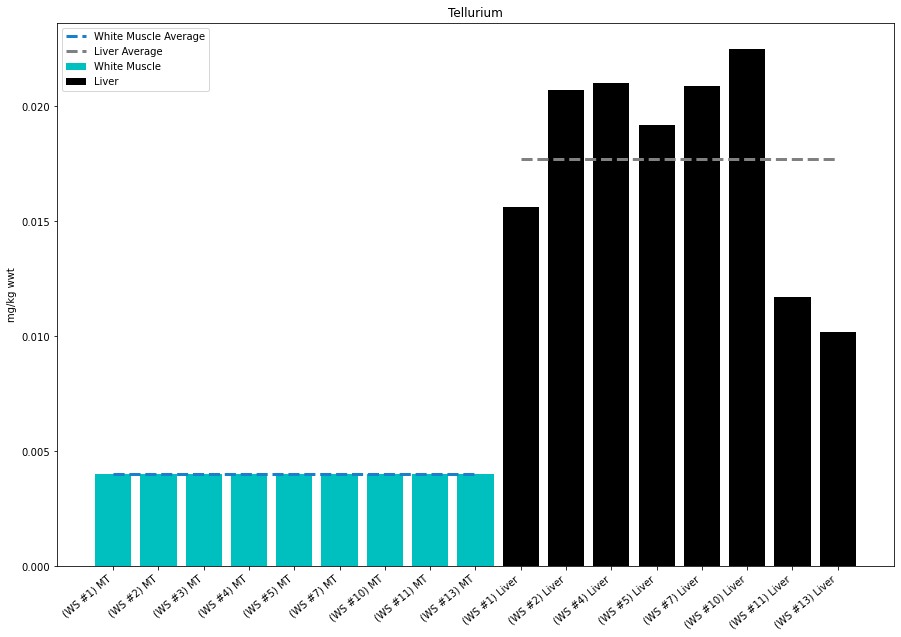

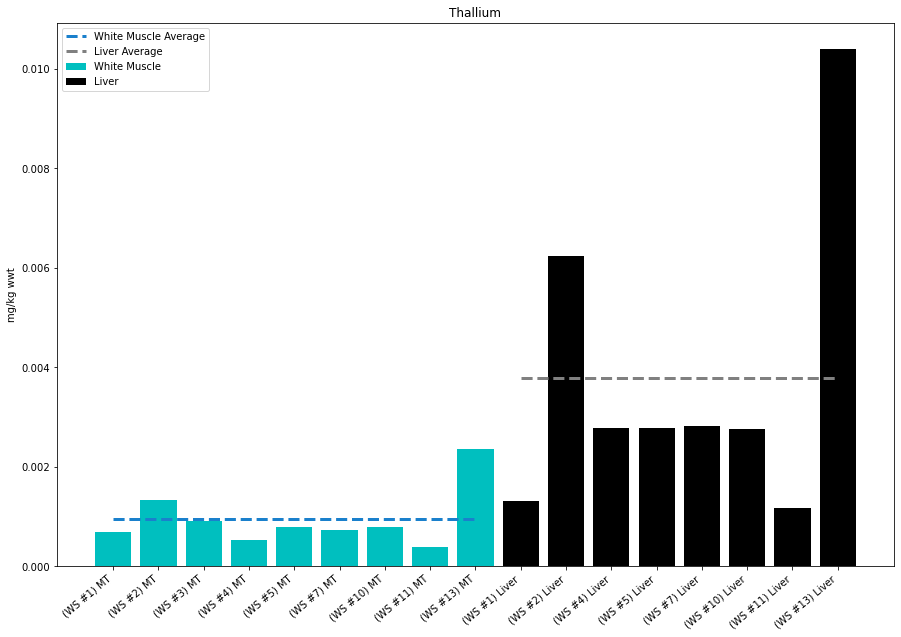

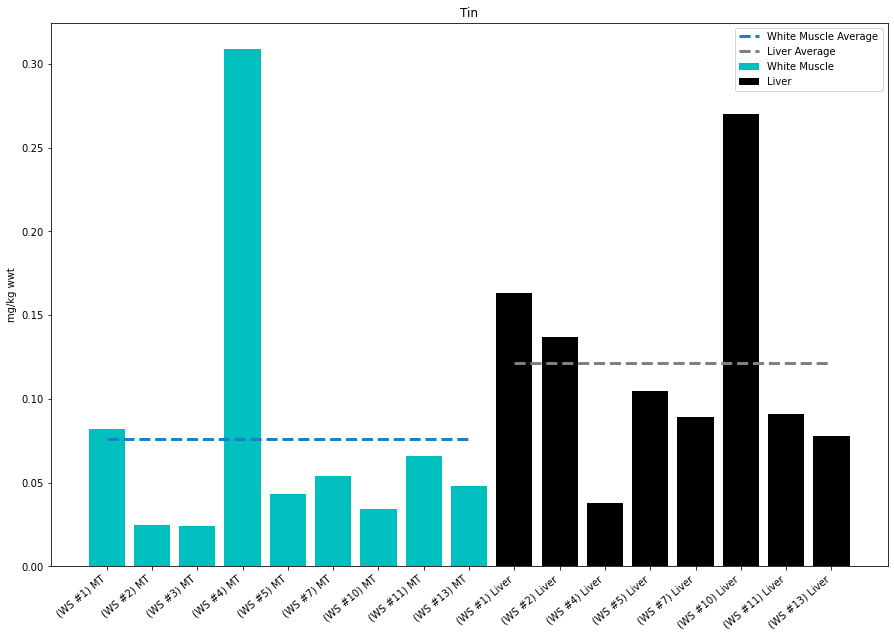

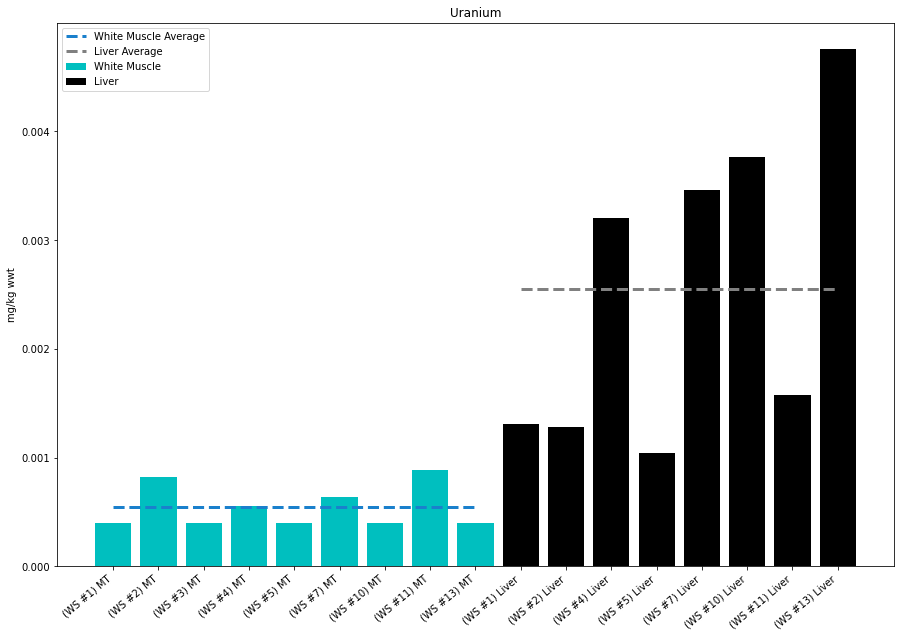

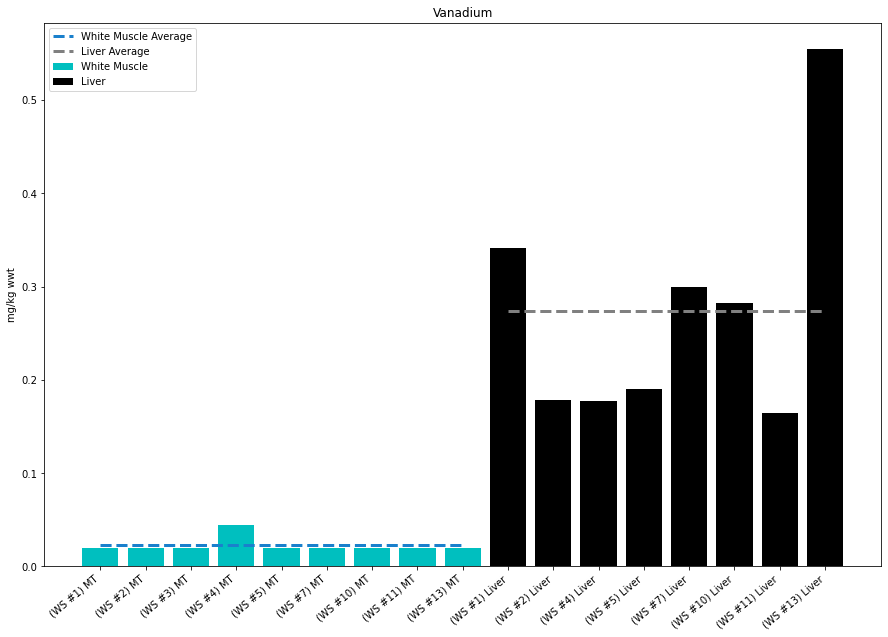

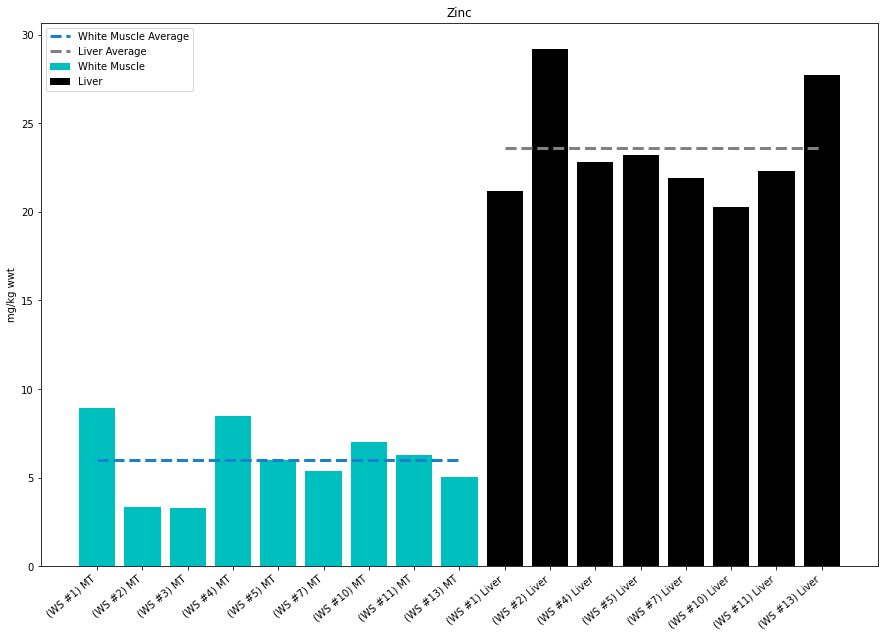

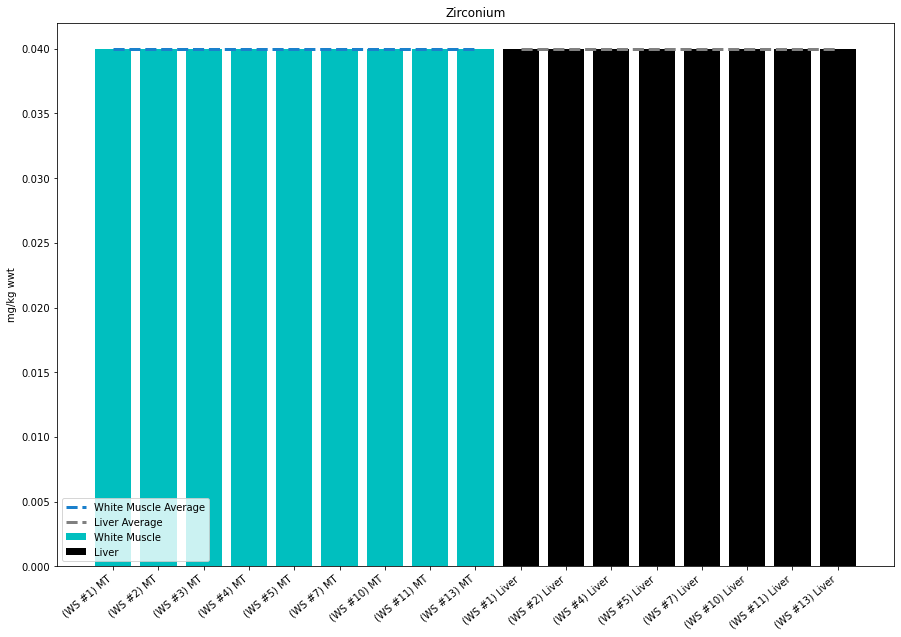

In [427]:
# elements = ["Aluminum", "Zinc", "Mercury"]
## to plot all elements uncomment bellow
elements = data["Analyte"][1::2].to_list()

# to save the picture of an element figure, set the corrosponding value to True
# save_pic = [False, False, True]

## to save all uncomment below
save_pic = np.ones(len(elements), dtype="bool")


x = data.columns[3:]
# seperating liver and mt using columns contatins the word "Liver"
Liver_id = x.str.contains("Liver")
id_13 = x.str.contains("#14")
for i in np.arange(len(elements)):
    # creating figure
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.set_facecolor("White")
    # obtaining related data
    values = np.array(data[np.logical_and(data["Analyte"] == elements[i], data["Units"] == "mg/kg wwt")].to_numpy()[:, 3:].ravel(), dtype=float)
    # bar ploting mt
    ax.bar(x[(~Liver_id) & (~id_13)], values[(~Liver_id) & (~id_13)], color = "c", label="White Muscle")
    # bar ploting liver
    ax.bar(x[Liver_id & (~id_13)], values[Liver_id & (~id_13)], color = "k", label="Liver")
    # ploting mean of mt
    ax.plot(x[(~Liver_id) & (~id_13)], np.mean(values[(~Liver_id) & (~id_13)]) * np.ones(x[(~Liver_id) & (~id_13)].shape), color = [0.1, 0.5, 0.8], label = "White Muscle Average", linestyle = "dashed", linewidth = 3)
    # ploting mean of liver
    ax.plot(x[Liver_id & (~id_13)], np.mean(values[Liver_id & (~id_13)]) * np.ones(x[Liver_id & (~id_13)].shape), color = "gray", label = "Liver Average", linestyle = "dashed", linewidth = 3)
    # setting axis side names
    ax.set_xlabel("")
    ax.set_ylabel("mg/kg wwt")
    ax.set_title(elements[i])
    # setting xticks and xtick labels
    ax.xaxis.set_ticks(np.arange(data.shape[1]-3))
    ax.xaxis.set_ticklabels(x[~id_13].str.removeprefix("White Sturgeon "), rotation = 40, ha = "right")
    # enabling legend
    ax.legend()
    if not os.path.exists("./pics/plot+13/"):
        os.makedirs("./pics/plot+13/")
    if save_pic[i] == True:
        fig.savefig("./pics/plot+13/"+elements[i]+".png")

# Statistics

In [428]:
from scipy.stats import shapiro
x = data.columns[3:]

## Shapiro test

In [429]:
shapiro_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result_liver = shapiro(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt")].iloc[:, 3:].to_numpy("double")[:, Liver_id])
    result_mt = shapiro(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt")].iloc[:, 3:].to_numpy("double")[:, ~Liver_id])
    shapiro_dict.update({element: [*result_liver, *result_mt]})

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [430]:
shapiro_table = pd.DataFrame(np.c_[np.array(list(shapiro_dict.keys()), dtype="str"), np.array(list(shapiro_dict.values()))], columns=["analyte", "liver statistic", "liver p-value", "mt statistics", "mt p-value"])

## pearson correlation factor

In [431]:
## extracting matching columns
x = data.columns[3:]
liver_temp = x[Liver_id].str.removesuffix(" Liver")
mt_temp = x[~Liver_id].str.removesuffix(" MT")
test_columns = []
for cl in liver_temp:
    if cl in mt_temp:
        test_columns.append(cl)

liver_columns = [x+" Liver" for x in test_columns]
mt_columns = [x+" MT" for x in test_columns]

In [432]:
test_columns

['White Sturgeon (WS #1)',
 'White Sturgeon (WS #2)',
 'White Sturgeon (WS #4)',
 'White Sturgeon (WS #5)',
 'White Sturgeon (WS #7)',
 'White Sturgeon (WS #10)',
 'White Sturgeon (WS #11)',
 'White Sturgeon (WS #13)']

In [433]:
from scipy.stats import pearsonr

In [434]:
pearson_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result = pearsonr(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), liver_columns].to_numpy("double").ravel(), data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), mt_columns].to_numpy("double").ravel())
    pearson_dict.update({element: [*result]})

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: Con

In [435]:
pearson_dict
pearson_liver_mt_table = pd.DataFrame(np.c_[np.array(list(pearson_dict.keys()), dtype="str")[:, np.newaxis], data.loc[data["Units"] == "mg/kg wwt", [*liver_columns, *mt_columns]].to_numpy("single"), np.array(list(pearson_dict.values()))], columns=["analyte", *[*liver_columns, *mt_columns], "statistic", "p-value"])

## pearson element by element correlation check

### Overall

In [436]:
lt_id = lt_track[:, 3:]
id_13 = x.str.contains("#13")
## to consider #13 as well uncomment next line
# id_13 = np.zeros_like(id_13, dtype="bool")

row_id = np.logical_and(data["Units"].to_numpy() == "mg/kg wwt", ~np.all(lt_id == True, axis = 1))
corr_matrix = np.corrcoef(data.loc[row_id, x[~id_13]].to_numpy("single").T, rowvar=False).round(decimals = 2)
elements = data["Analyte"].loc[row_id].to_numpy()

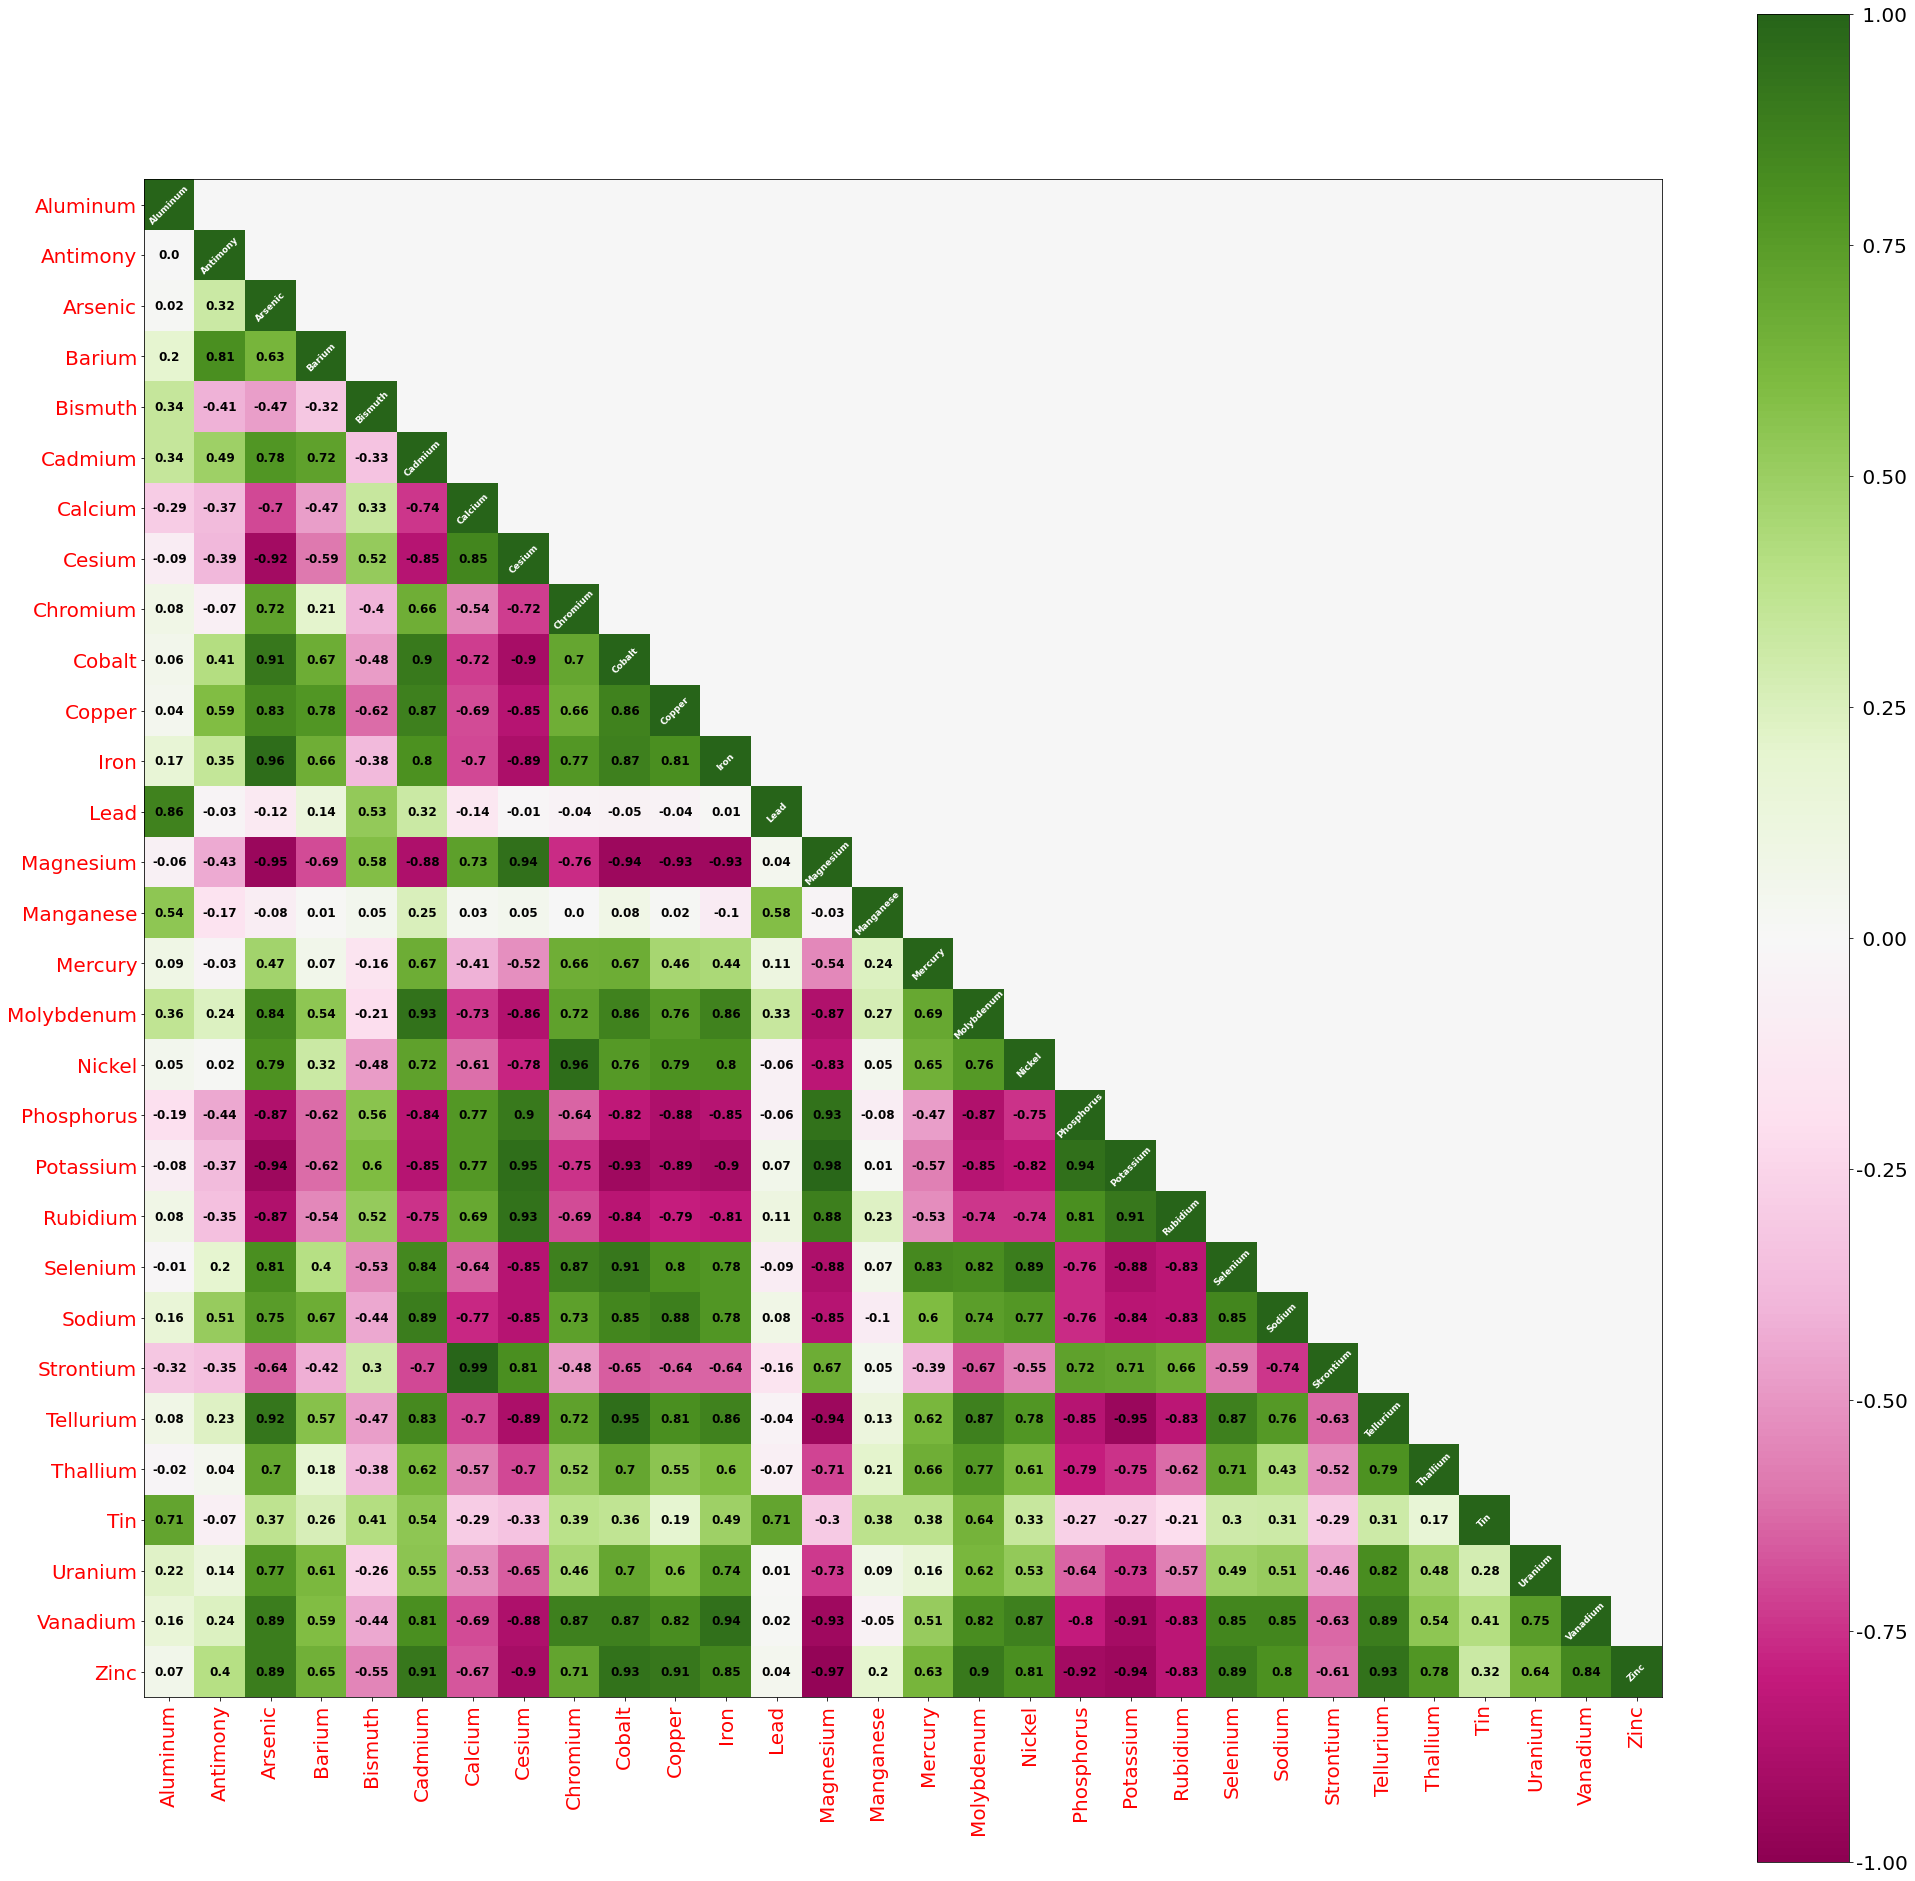

In [437]:
fig, ax = plt.subplots(figsize = (34, 34))
cmap = plt.cm.PiYG
im = ax.imshow(np.tril(corr_matrix, k=0), cmap=cmap)
fig.set_facecolor("white")
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(corr_matrix.shape[0]), elements, rotation = 90, color = "r", fontsize = 20)
ax.yaxis.set_ticks(np.arange(corr_matrix.shape[0]), elements, color = "r", fontsize = 20)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(corr_matrix.shape[0]):
    ax.text(i, i, elements[i], ha = 'center', va = 'center',
            color = 'white', fontsize = 9, rotation = 45, fontweight = "bold")
    for j in np.arange(i):
        ax.text(j, i, corr_matrix[i, j], ha='center', va='center',
                color='k', fontsize = 12, fontweight = "bold")
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
cbar.ax.tick_params(labelsize=20)
plt.savefig("./pics/pearson.png")
plt.show()


### just liver

In [438]:
lt_id = lt_track[:, 3:]
row_id = np.logical_and(data["Units"].to_numpy() == "mg/kg wwt", ~np.all(lt_id[:, Liver_id] == True, axis = 1))
corr_matrix_liver = np.corrcoef(data.loc[row_id, x[Liver_id & (~id_13)]].to_numpy("single").T, rowvar=False).round(decimals = 2)
elements = data["Analyte"].loc[row_id].to_numpy()

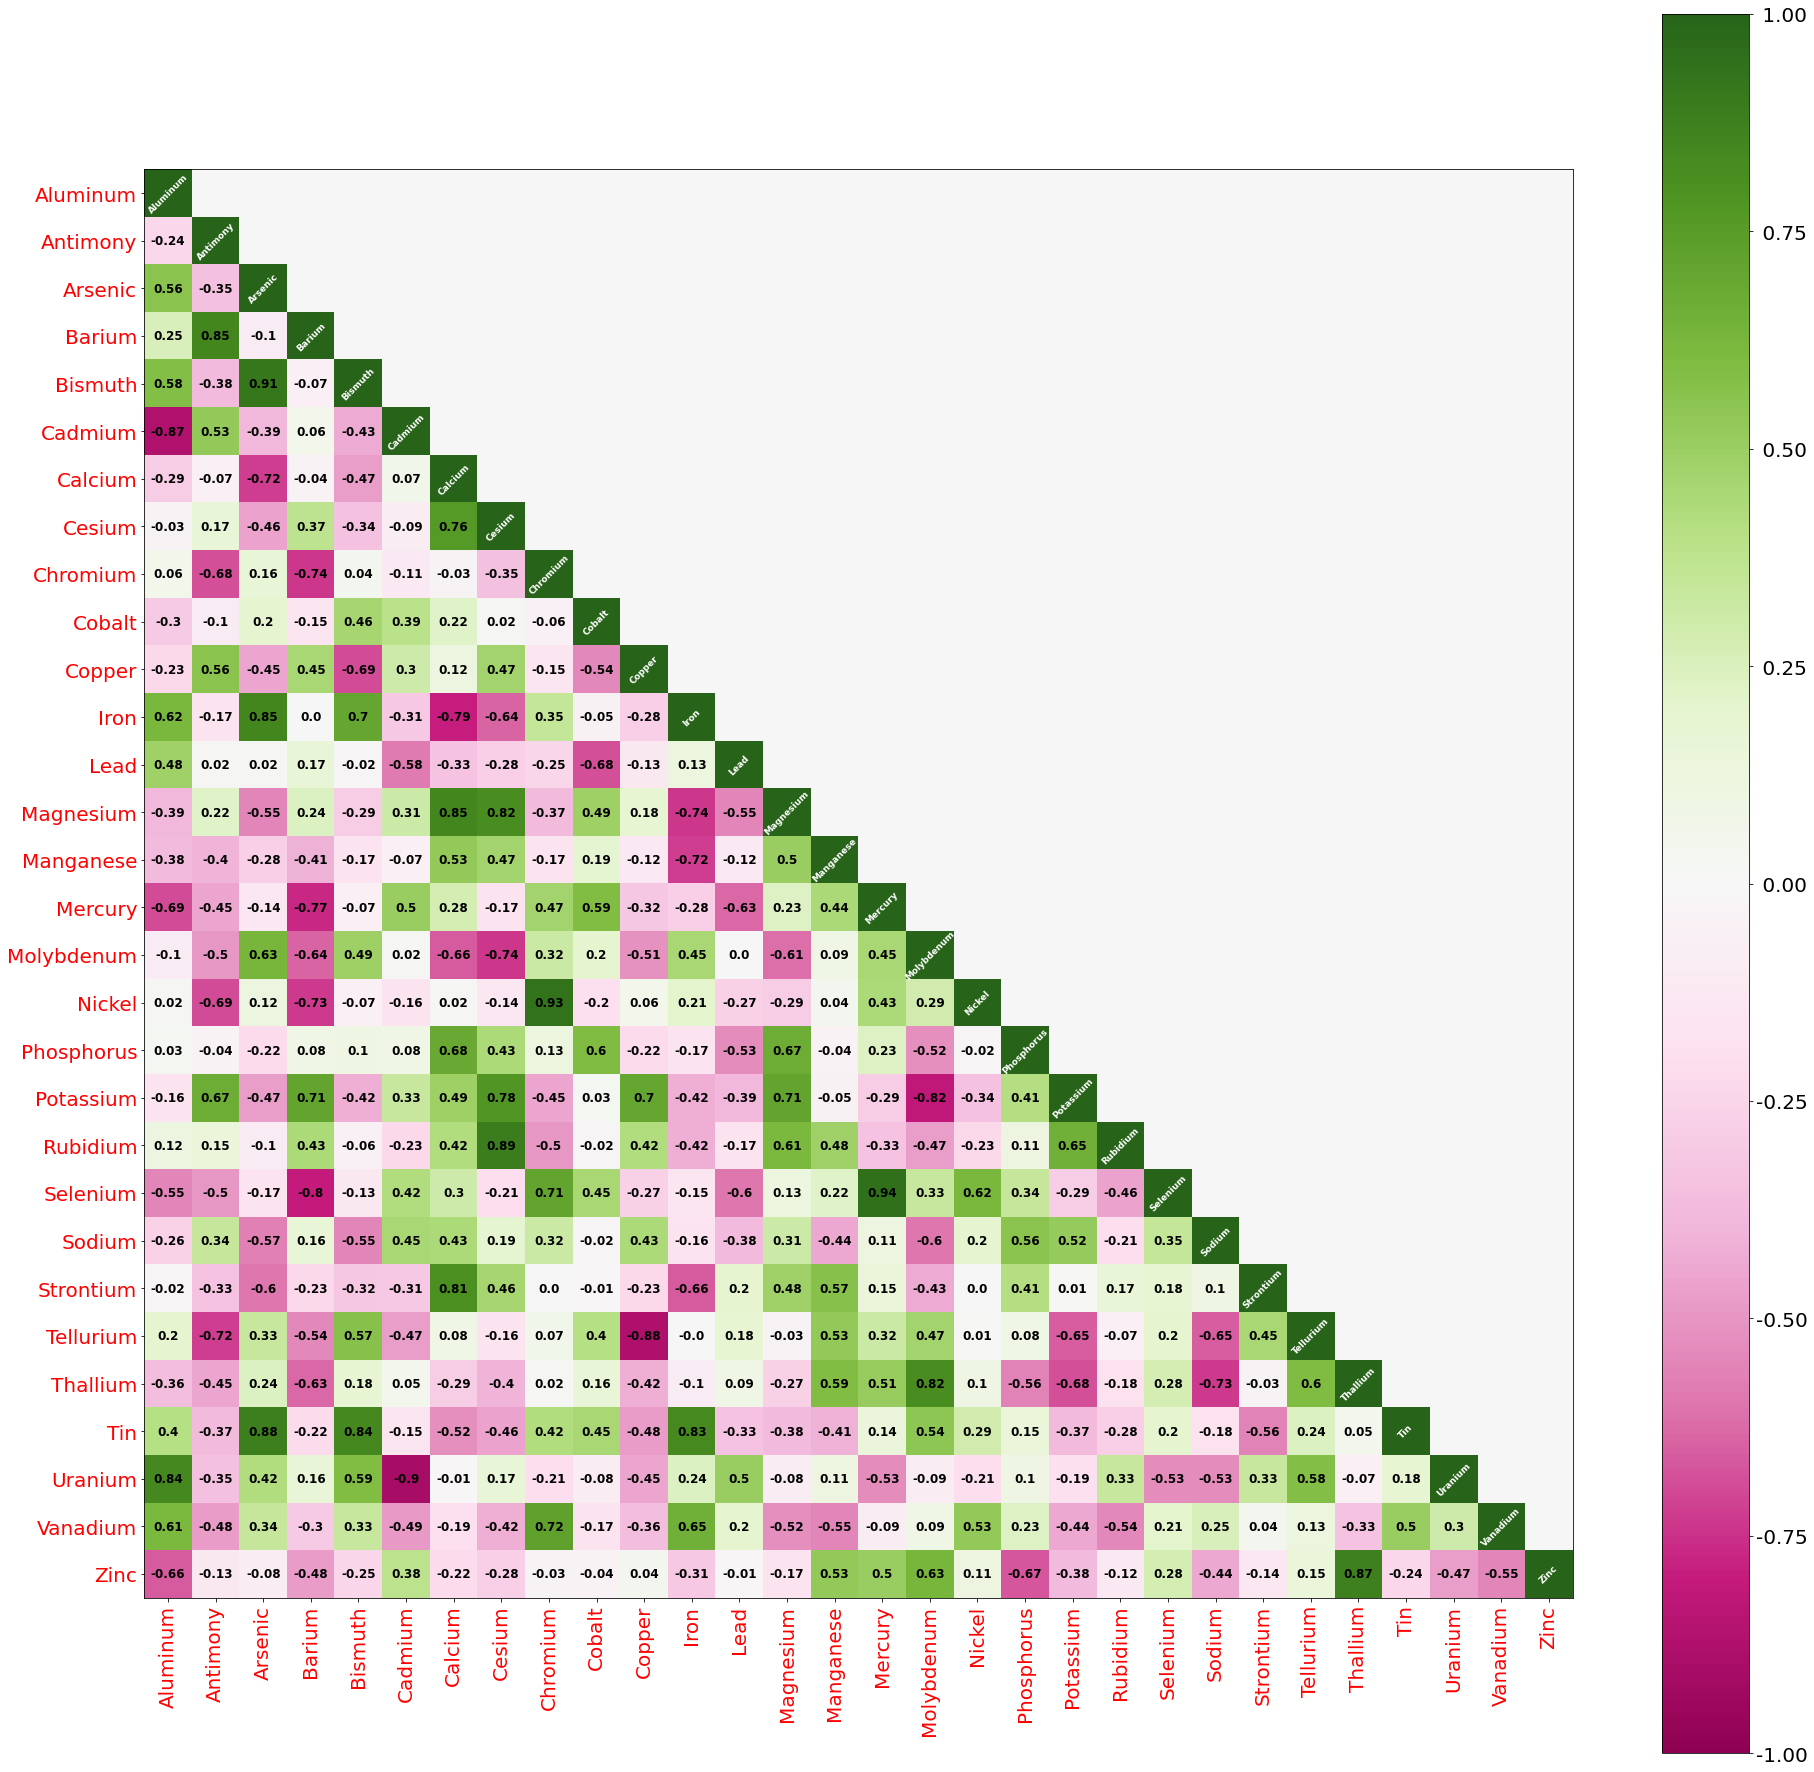

In [439]:
fig, ax = plt.subplots(figsize = (32, 32))
cmap = plt.cm.PiYG
im = ax.imshow(np.tril(corr_matrix_liver, k=0), cmap=cmap)
fig.set_facecolor("white")
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(corr_matrix_liver.shape[0]), elements, rotation = 90, color = "r", fontsize = 20)
ax.yaxis.set_ticks(np.arange(corr_matrix_liver.shape[0]), elements, color = "r", fontsize = 20)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(corr_matrix_liver.shape[0]):
    ax.text(i, i, elements[i], ha = 'center', va = 'center',
            color = 'white', fontsize = 9, rotation = 45, fontweight = "bold")
    for j in np.arange(i):
        ax.text(j, i, corr_matrix_liver[i, j], ha='center', va='center',
                color='k', fontsize = 12, fontweight = "bold")
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
cbar.ax.tick_params(labelsize=20)
plt.savefig("./pics/pearson liver.png")
plt.show()


### Just MT

In [440]:
lt_id = lt_track[:, 3:]
row_id = np.logical_and(data["Units"].to_numpy() == "mg/kg wwt", ~np.all(lt_id[:, ~Liver_id] == True, axis = 1))
corr_matrix_MT = np.corrcoef(data.loc[row_id, x[~Liver_id & (~id_13)]].to_numpy("single").T, rowvar=False).round(decimals = 2)
elements = data["Analyte"].loc[row_id].to_numpy()

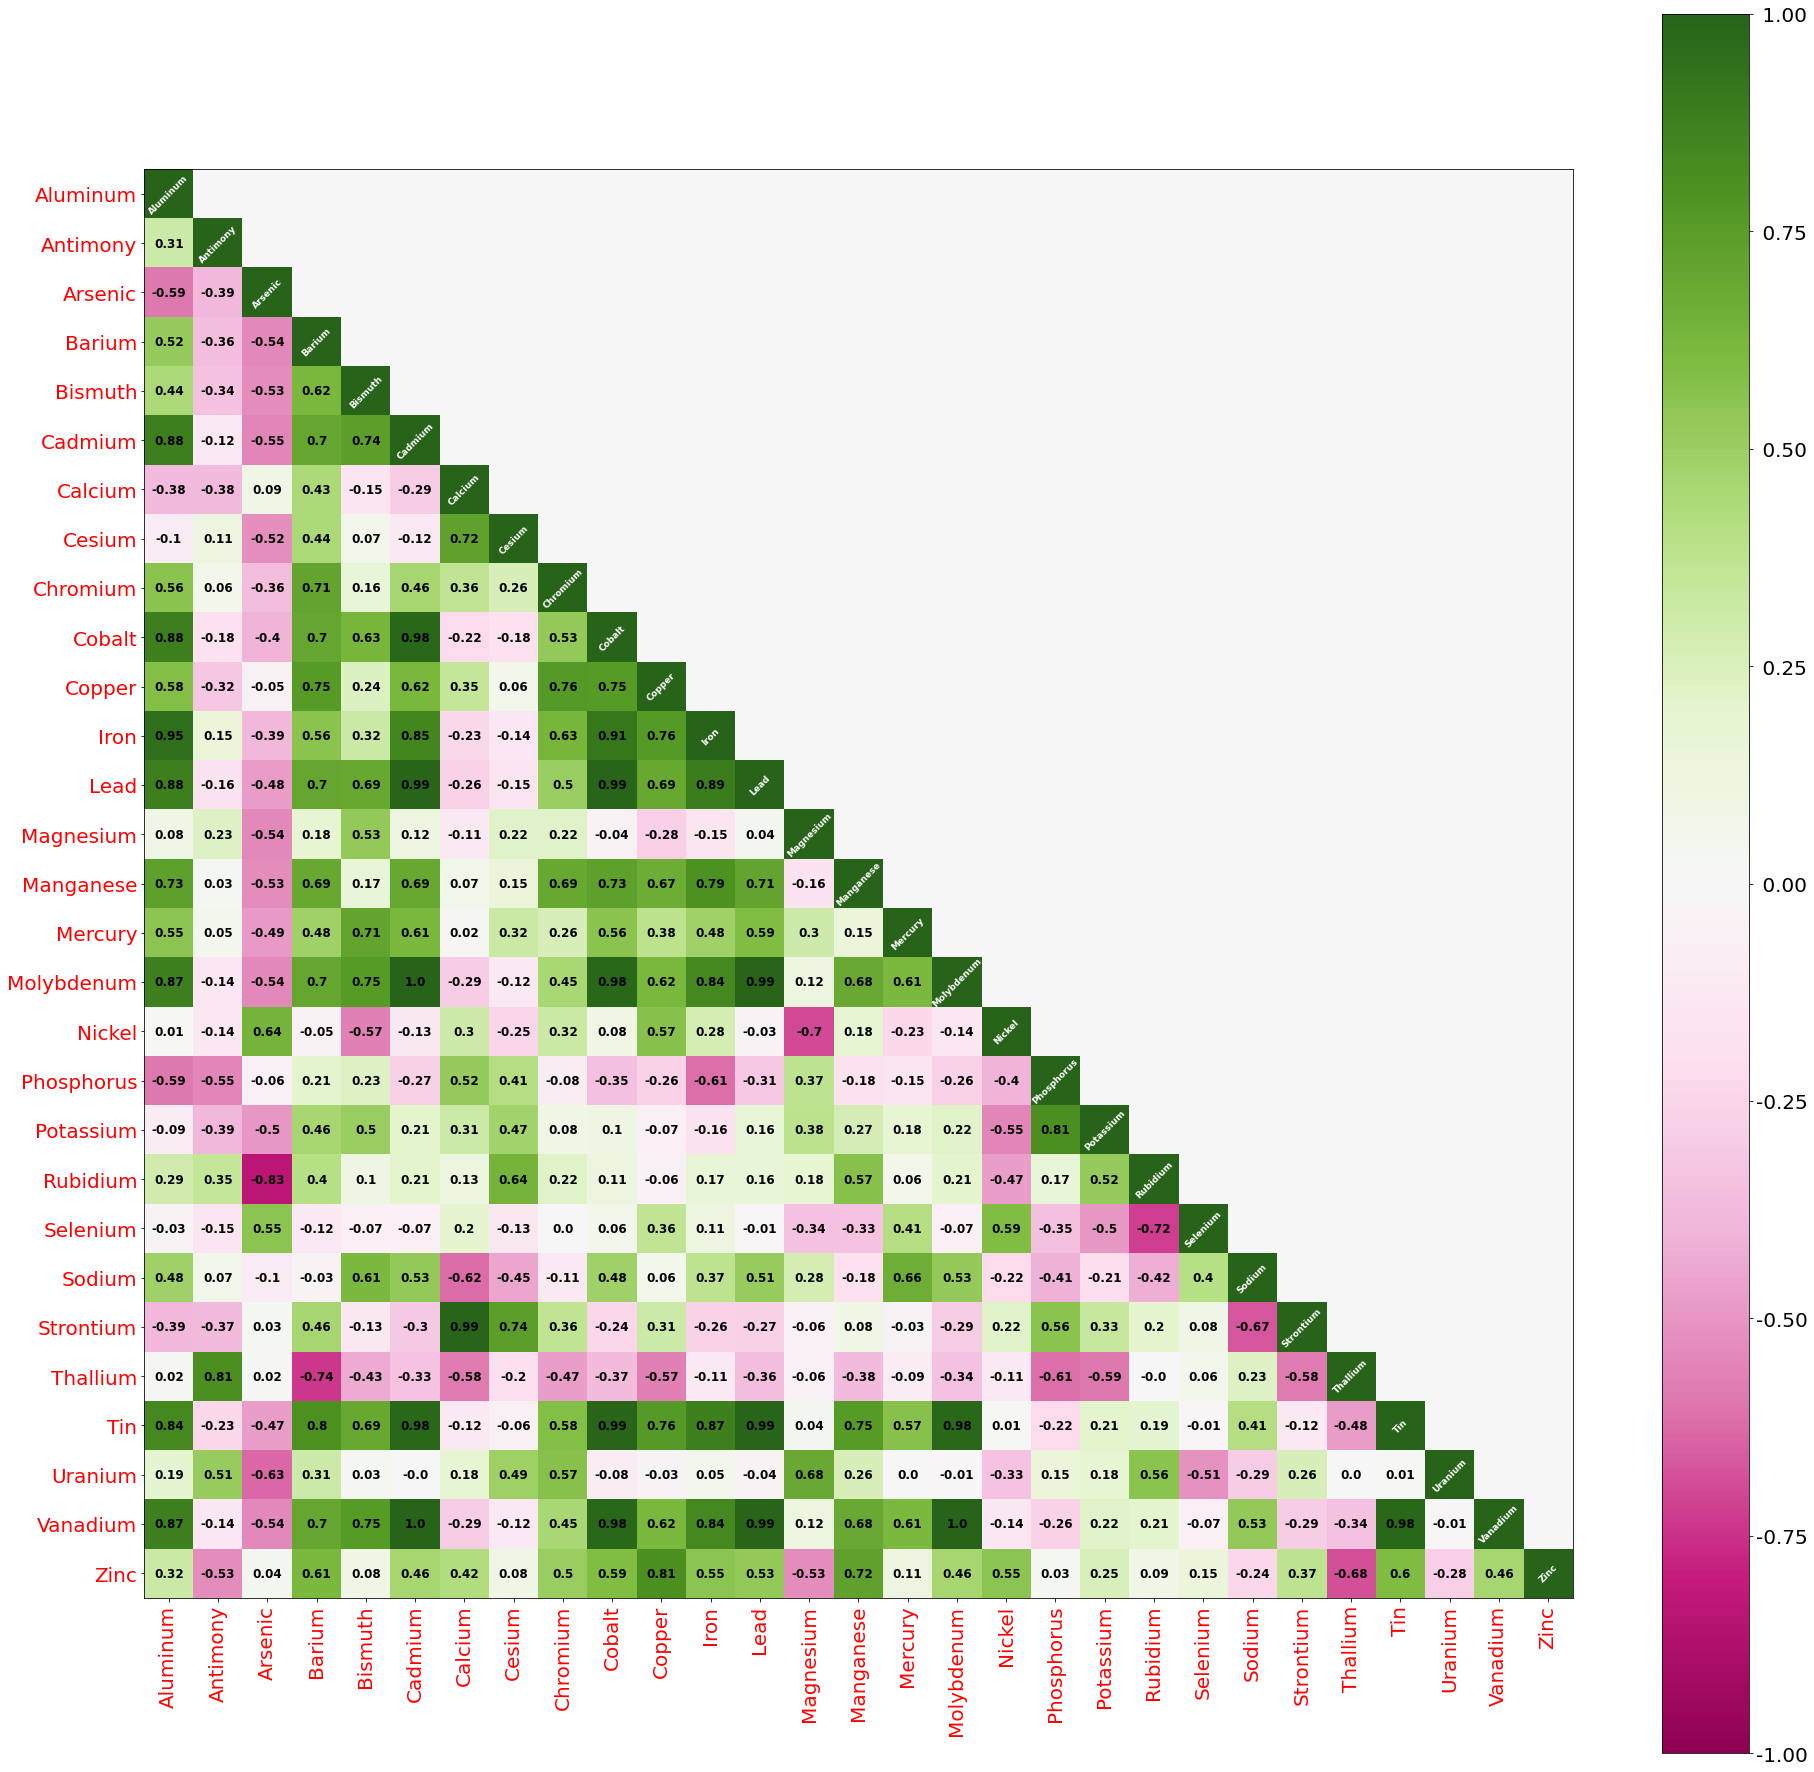

In [441]:
fig, ax = plt.subplots(figsize = (32, 32))
cmap = plt.cm.PiYG
im = ax.imshow(np.tril(corr_matrix_MT, k=0), cmap=cmap)
fig.set_facecolor("white")
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, rotation = 90, color = "r", fontsize = 20)
ax.yaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, color = "r", fontsize = 20)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(corr_matrix_MT.shape[0]):
    ax.text(i, i, elements[i], ha = 'center', va = 'center',
            color = 'white', fontsize = 9, rotation = 45, fontweight = "bold")
    for j in np.arange(i):
        ax.text(j, i, corr_matrix_MT[i, j], ha='center', va='center',
                color='k', fontsize = 12, fontweight = "bold")
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
cbar.ax.tick_params(labelsize=20)
plt.savefig("./pics/pearson mt.png")
plt.show()


### corolation for selected elements
MT first

In [442]:
lt_id = lt_track[:, 3:]
elements = ["Lead", "Cadmium", "Molybdenum", "Mercury", "Selenium", "Copper", "Zinc"]
element_id = np.zeros(data["Analyte"].shape, dtype="bool")
for i in np.arange(element_id.shape[0]):
    if data["Analyte"][i] in elements:
        element_id[i] = True
row_id = np.logical_and(data["Units"].to_numpy() == "mg/kg wwt", ~np.all(lt_id[:, ~Liver_id] == True, axis = 1)) * element_id
corr_matrix_MT = np.corrcoef(data.loc[row_id, x[~Liver_id & (~id_13)]].to_numpy("single").T, rowvar=False).round(decimals = 2)
elements = data["Analyte"].loc[row_id].to_numpy()

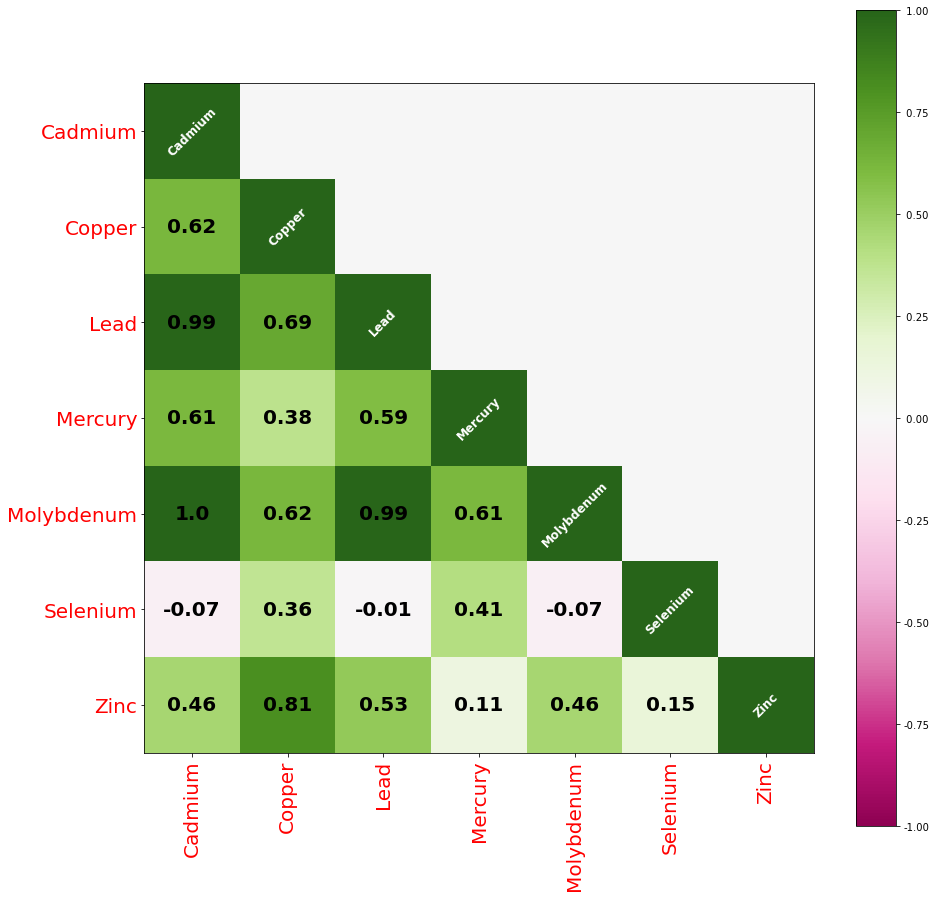

In [443]:
fig, ax = plt.subplots(figsize = (15, 15))
cmap = plt.cm.PiYG
im = ax.imshow(np.tril(corr_matrix_MT, k=0), cmap=cmap)
fig.set_facecolor("white")
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, rotation = 90, color = "r", fontsize = 20)
ax.yaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, color = "r", fontsize = 20)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(corr_matrix_MT.shape[0]):
    ax.text(i, i, elements[i], ha = 'center', va = 'center',
            color = 'white', fontsize = 12, rotation = 45, fontweight = "bold")
    for j in np.arange(i):
        ax.text(j, i, corr_matrix_MT[i, j], ha='center', va='center',
                color='k', fontsize = 20, fontweight = "bold")
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.savefig("./pics/pearson_selected elements_MT.png")
plt.show()


Liver

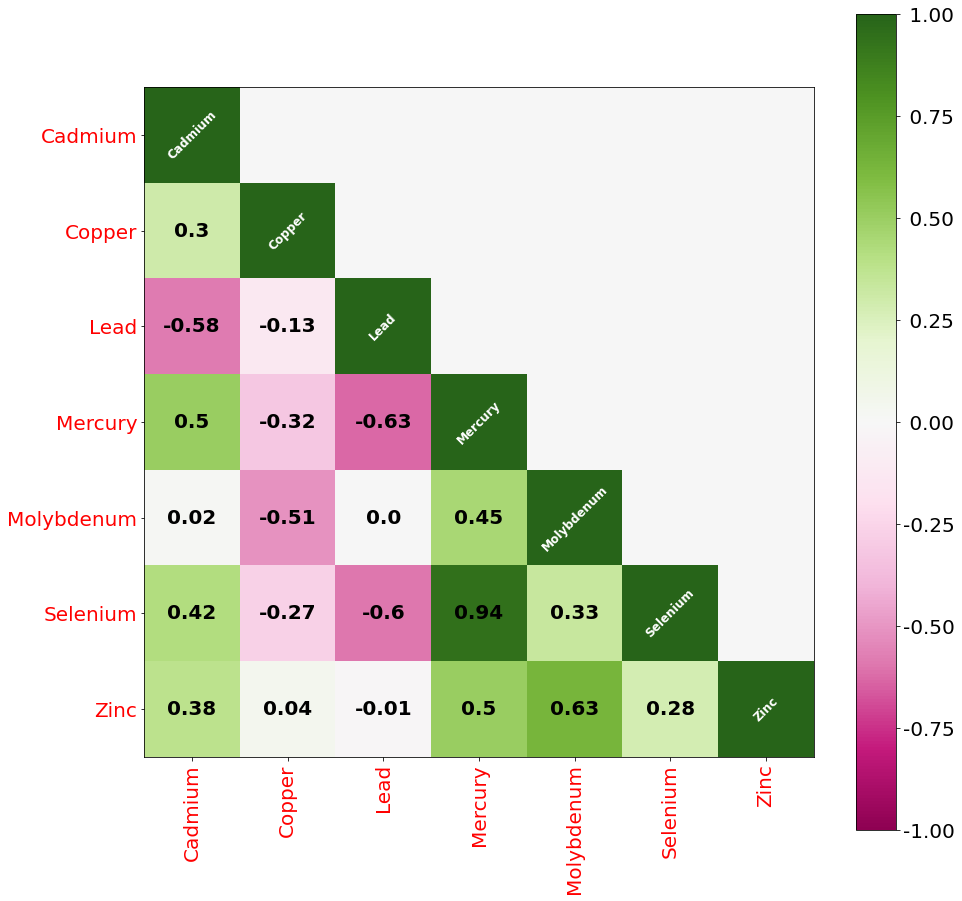

In [444]:
lt_id = lt_track[:, 3:]
elements = ["Lead", "Cadmium", "Molybdenum", "Mercury", "Selenium", "Copper", "Zinc"]
element_id = np.zeros(data["Analyte"].shape, dtype="bool")
for i in np.arange(element_id.shape[0]):
    if data["Analyte"][i] in elements:
        element_id[i] = True
row_id = np.logical_and(data["Units"].to_numpy() == "mg/kg wwt", ~np.all(lt_id[:, Liver_id] == True, axis = 1)) * element_id
corr_matrix_MT = np.corrcoef(data.loc[row_id, x[Liver_id & (~id_13)]].to_numpy("single").T, rowvar=False).round(decimals = 2)
elements = data["Analyte"].loc[row_id].to_numpy()

fig, ax = plt.subplots(figsize = (15, 15))
cmap = plt.cm.PiYG
im = ax.imshow(np.tril(corr_matrix_MT, k=0), cmap=cmap)
fig.set_facecolor("white")
im.set_clim(-1, 1)
ax.grid(False)
ax.xaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, rotation = 90, color = "r", fontsize = 20)
ax.yaxis.set_ticks(np.arange(corr_matrix_MT.shape[0]), elements, color = "r", fontsize = 20)
# ax.set_ylim(2.5, -0.5)
for i in np.arange(corr_matrix_MT.shape[0]):
    ax.text(i, i, elements[i], ha = 'center', va = 'center',
            color = 'white', fontsize = 12, rotation = 45, fontweight = "bold")
    for j in np.arange(i):
        ax.text(j, i, corr_matrix_MT[i, j], ha='center', va='center',
                color='k', fontsize = 20, fontweight = "bold")
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
cbar.ax.tick_params(labelsize=20)
plt.savefig("./pics/pearson_selected elements_Liver.png")
plt.show()

# One way Anova

In [445]:
from scipy.stats import f_oneway

anova_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result = f_oneway(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"),
                                liver_columns].to_numpy("double").ravel(), 
                                data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), 
                                         mt_columns].to_numpy("double").ravel())
    anova_dict.update({element: [*result]})

anova_table = pd.DataFrame(np.c_[np.array(list(anova_dict.keys()), dtype="str")[:, np.newaxis],
                                  data.loc[data["Units"] == "mg/kg wwt",
                                            [*liver_columns, *mt_columns]].to_numpy("single"),
                                              np.array(list(anova_dict.values()))],
                                                columns=["analyte", *[*liver_columns, *mt_columns],
                                                          "statistic", "p-value"])

/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/amir/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


## T test

In [446]:
from scipy.stats import ttest_ind

ttest_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = data["Analyte"][1::2].to_list()
for element in elements:
    result = ttest_ind(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"),
                                liver_columns].to_numpy("double").ravel(), 
                                data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"), 
                                         mt_columns].to_numpy("double").ravel())
    ttest_dict.update({element: [*result]})

ttest_table = pd.DataFrame(np.c_[np.array(list(ttest_dict.keys()), dtype="str")[:, np.newaxis],
                                  data.loc[data["Units"] == "mg/kg wwt",
                                            [*liver_columns, *mt_columns]].to_numpy("single"),
                                              np.array(list(ttest_dict.values()))],
                                                columns=["analyte", *[*liver_columns, *mt_columns],
                                                          "statistic", "p-value"])

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/847494021.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = ttest_ind(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"),
/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/847494021.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = ttest_ind(data.loc[np.logical_and(data["Analyte"] == element, data["Units"] == "mg/kg wwt"),
/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/847494021.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = ttest_ind(data.loc[np.log

# Reading Punch Data

In [447]:
punch_data = pd.read_excel("2303384 FINAL BAL Standard EDD 18 May 23 1649.xls")

temp = punch_data["Sample_Tag"].str.split("- ")
tag = []
tissue = []
for i in np.arange(temp.shape[0]):
    if len(temp[i]) > 1:
        tag.append(temp[i][0].strip())
        tissue.append(temp[i][1].strip())
    else:
        tag.append((temp[i][0]).strip())
        tissue.append("None")

punch_data.insert(4, "Tag", tag)
punch_data.insert(4, "Tissue", tissue)
punch_data.drop(columns="Sample_Tag")

# reading [fish_number - tag] from sheet excel sheet names
temp_file = xl.reader.excel.load_workbook("2022 Nechako river WSG Mortality Summary.xlsx")
tags = temp_file.sheetnames
tags = np.char.split(tags, "-")
fish_number = []
fish_tag = []
for tag in tags:
    fish_number.append(tag[0].strip())
    fish_tag.append(tag[1].strip())
tag_list = np.array(np.c_[fish_number, fish_tag])

# maping tags to fish_numbers
temp = punch_data['Tag'].copy().to_numpy()
for i in np.arange(tag_list.shape[0]):
    temp[punch_data['Tag'] == tag_list[i, 1]] = tag_list[i, 0]

# replacing the results with Sample_Tag column :)
punch_data["Sample_Tag"] = temp

punch_data = punch_data.loc[(punch_data["Tissue"] == "Liver") | (punch_data["Tissue"] == "Muscle")]
# print(punch_data.columns)
punch_data = punch_data.loc[:, punch_data.columns[[4, 5, 6, 11, 12, 14, 15, 28]]]

element_ref = np.c_[np.unique(data["Analyte"].to_numpy()[1:]), ["Al", "An", "As", "Ba", "Be", "Bi", "B", "Cd", "Ca", "Ce", "Cr", "Co", "Cu", "Fn", "Pb", "Li", "Mg", "Mn", "Hg", "Mo", "Ni", "P", "K", "Ru", "Se", "Na", "St", "Te", "Ta", "Tin", "Ur", "Va", "Zn", "Zi"]]

elements = [element_ref[i==element_ref[:, 1], 0].item() for i in punch_data["Analyte"]]
punch_data["Analyte"] = elements

punch_data.replace("Muscle", "MT", inplace=True)
punch_data.reset_index(inplace=True)

ours = punch_data["Result"].to_numpy("single").copy()
for i in np.arange(ours.shape[0]):
    temp = data.loc[(data["Analyte"] == punch_data["Analyte"][i]) & (data["Units"] == "mg/kg wwt"), data.columns.str.contains(punch_data["Tissue"][i]) & data.columns.str.contains(punch_data["Sample_Tag"][i])].to_numpy("single")
    if temp.shape[1] == 0:
        ours[i] = None
    else:
        ours[i] = temp.item(0)

punch_data.insert(5, column="Ours", value=ours)

In [448]:
punch_data

index Tissue         Tag Sample_Tag Matrix     Ours     Analyte  Result  \
0       12  Liver  0A18201551         #7   Fish   0.1210     Cadmium   0.130   
1       13  Liver  0A18201551         #7   Fish   7.9500      Copper   6.110   
2       14  Liver  0A18201551         #7   Fish   0.0634  Molybdenum   0.043   
3       15  Liver  0A18201551         #7   Fish   1.6300    Selenium   1.390   
4       16  Liver  0A18201551         #7   Fish  21.9000        Zinc  20.100   
..     ...    ...         ...        ...    ...      ...         ...     ...   
157    313  Liver  7F7D7D3401         #3  Biota      NaN      Copper   6.371   
158    314  Liver  7F7D7D3401         #3  Biota      NaN  Molybdenum   0.212   
159    315  Liver  7F7D7D3401         #3  Biota      NaN    Selenium   4.232   
160    316  Liver  7F7D7D3401         #3  Biota      NaN        Zinc  22.780   
161    317  Liver  7F7D7D3401         #3  Biota      NaN     Mercury   5.795   

     Units    Basis  
0    mg/kg  wet wt.  
1    mg/kg  wet wt.  
2    mg/kg  wet wt.  
3    mg/kg  wet wt.  
4    mg/kg  wet wt.  
..     ...      ...  
157  mg/kg  wet wt.  
158  mg/kg  wet wt.  
159  mg/kg  wet wt.  
160  mg/kg  wet wt.  
161  mg/kg  wet wt.  

[162 rows x 10 columns]

## Ploting punch data vs Ours

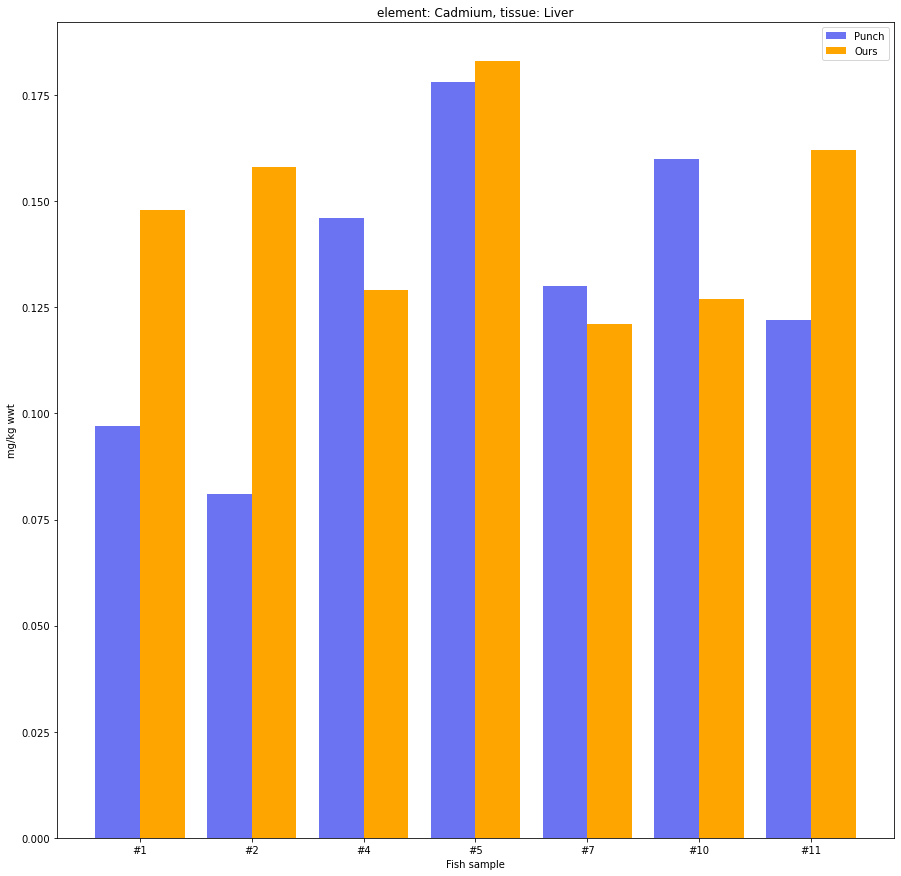

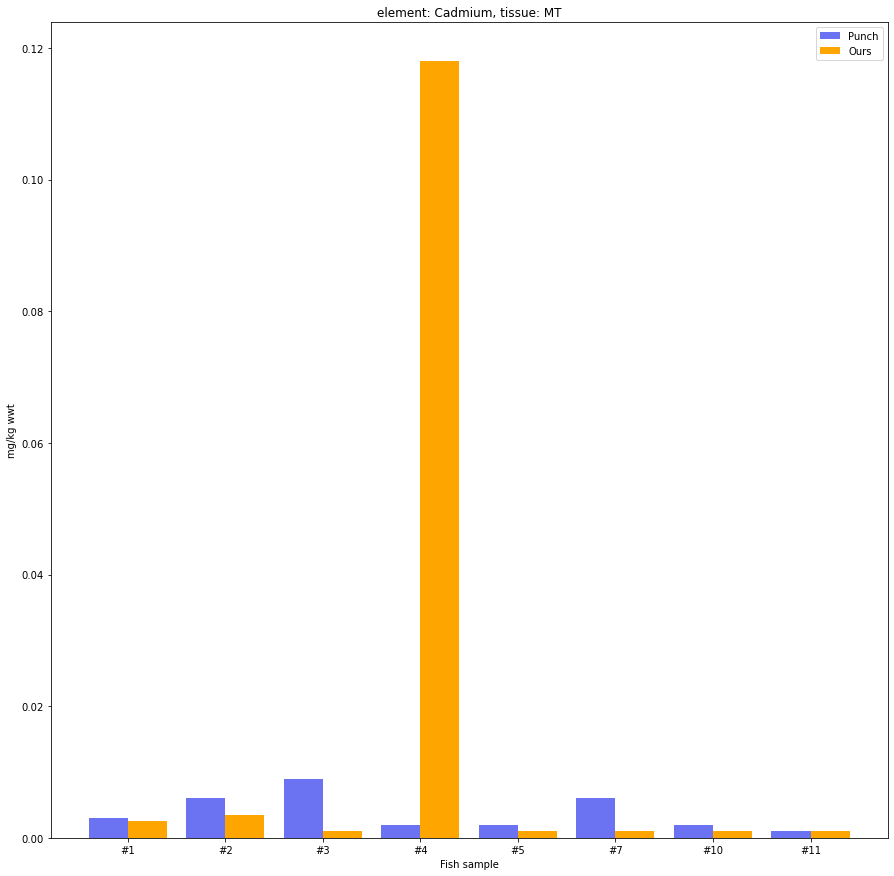

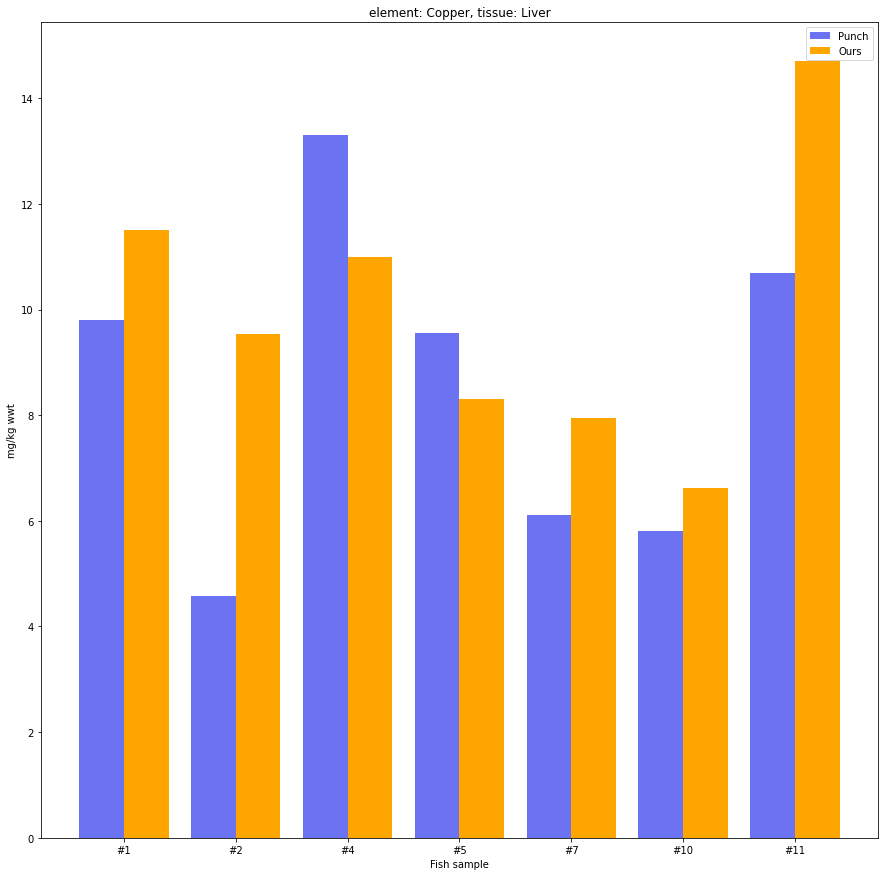

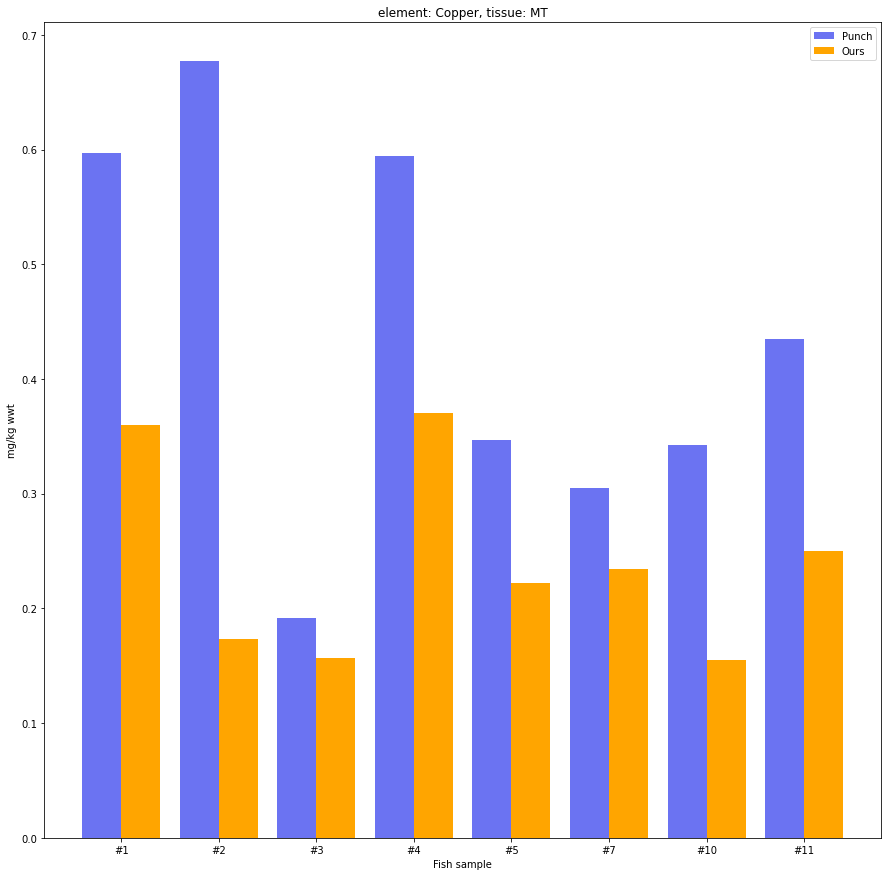

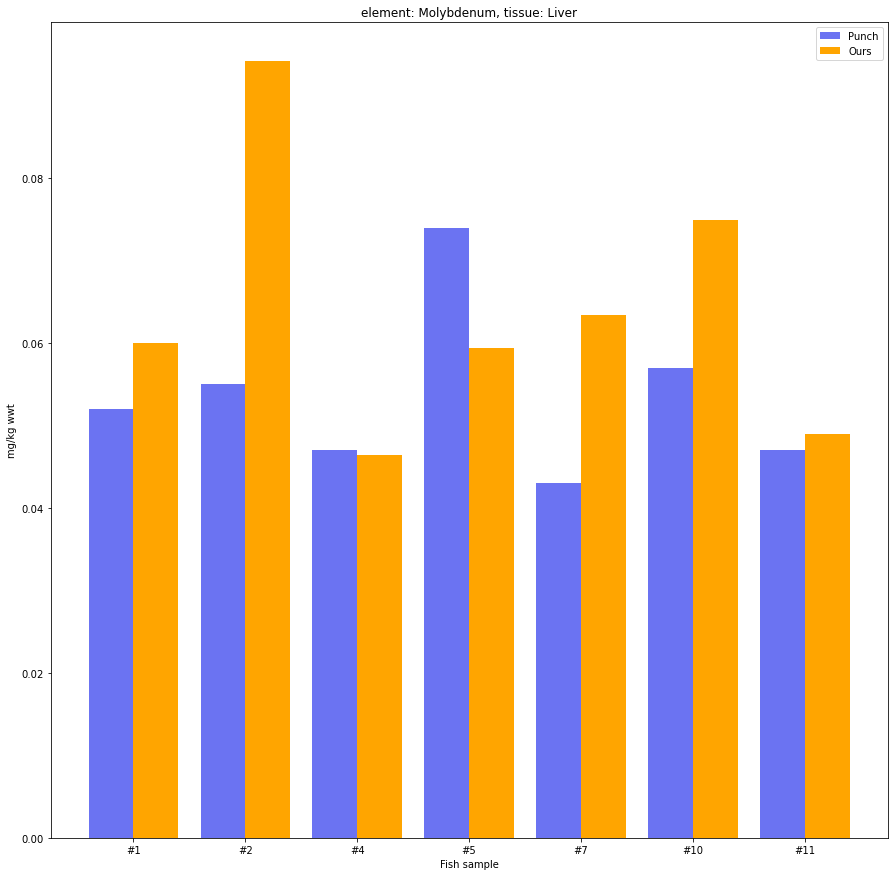

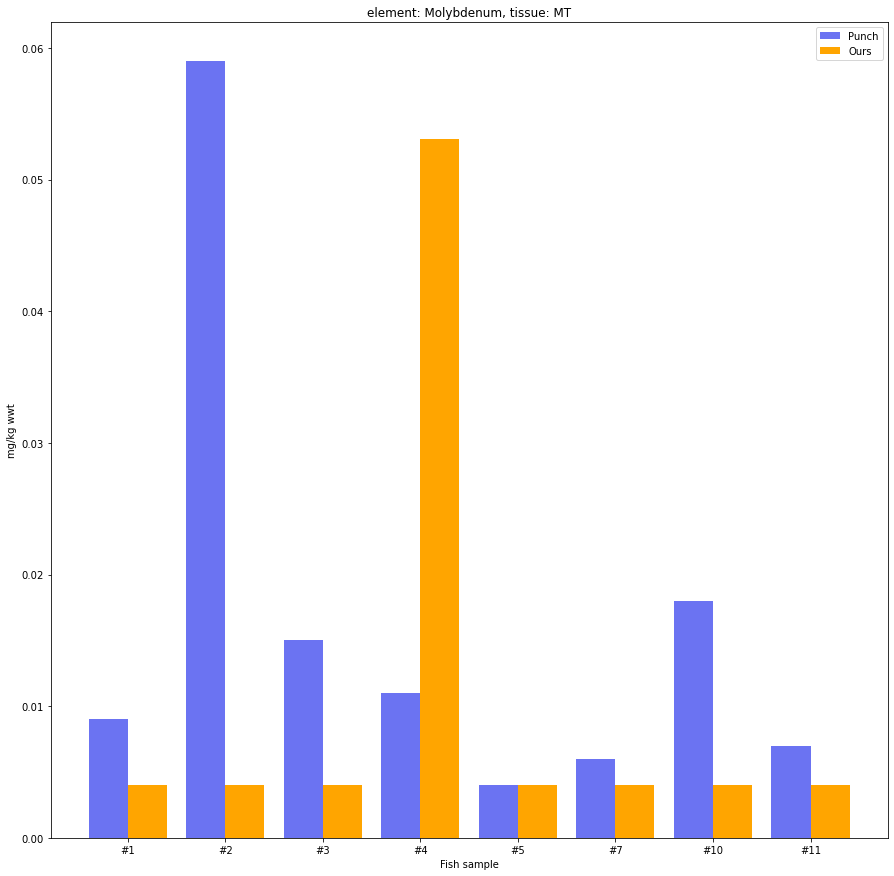

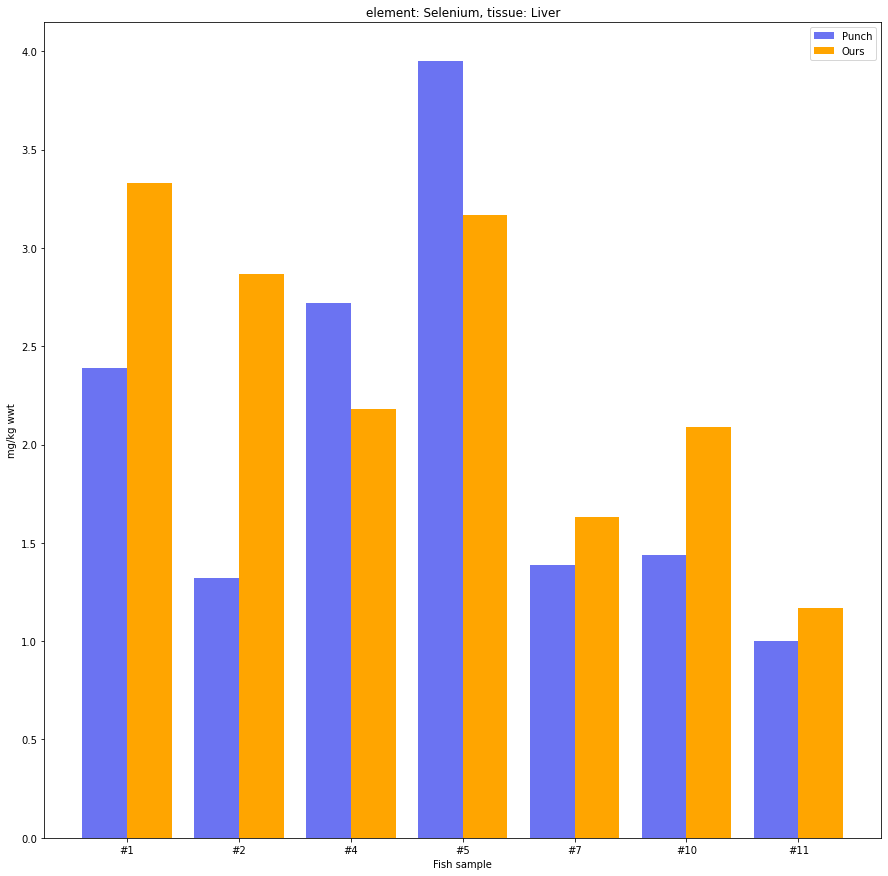

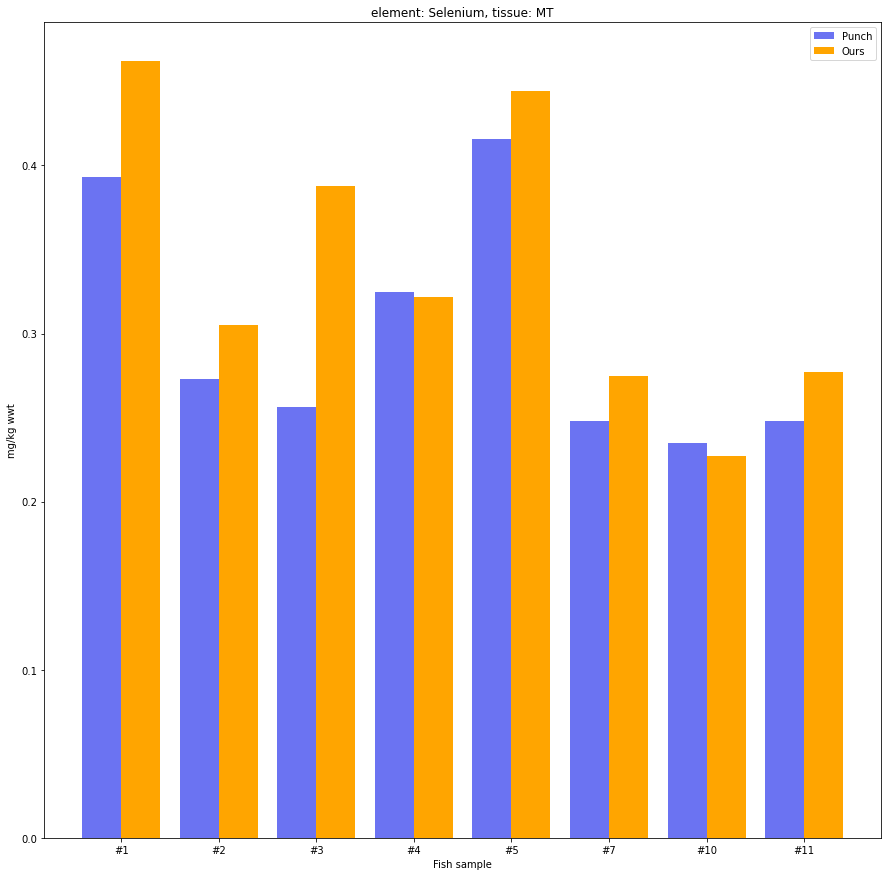

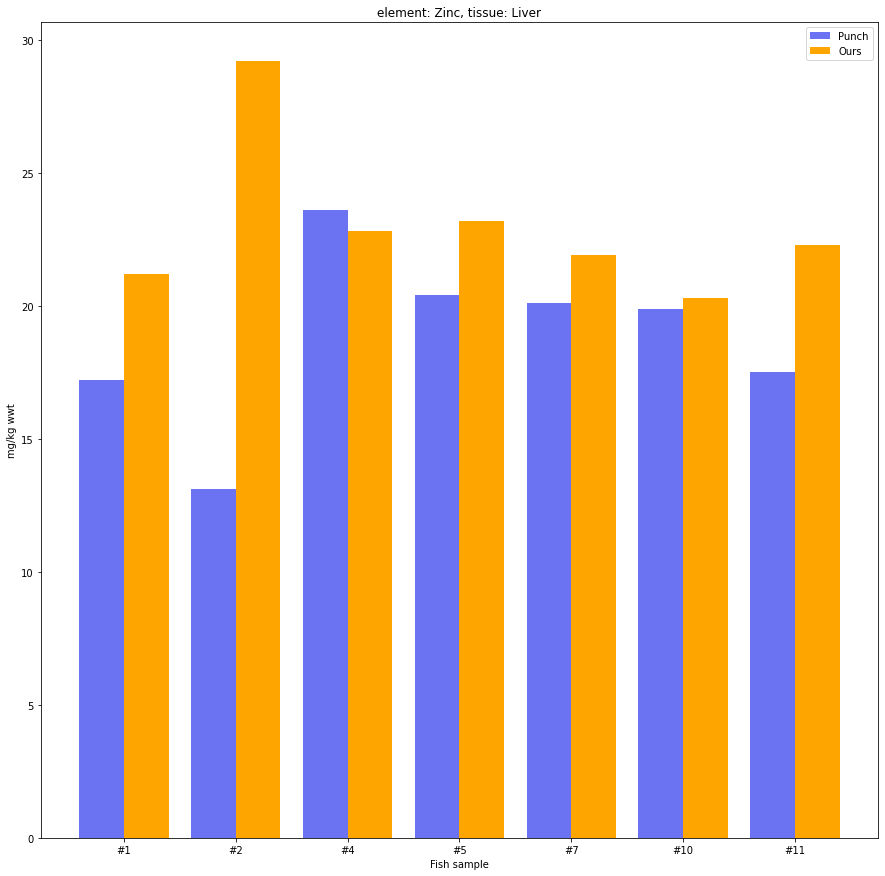

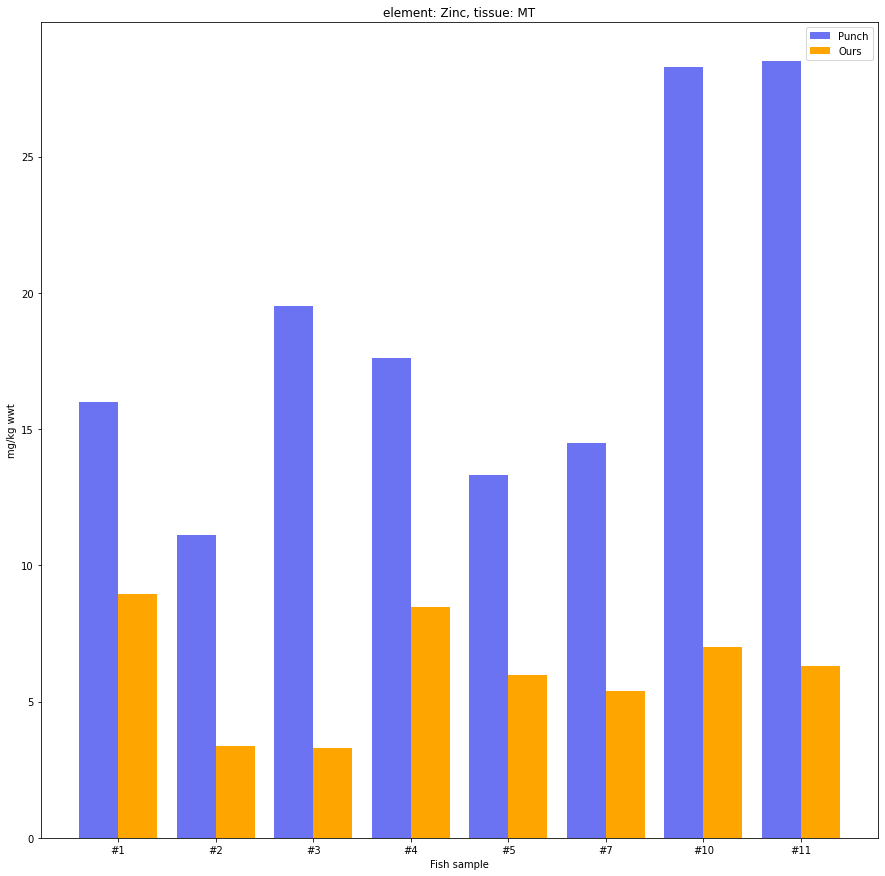

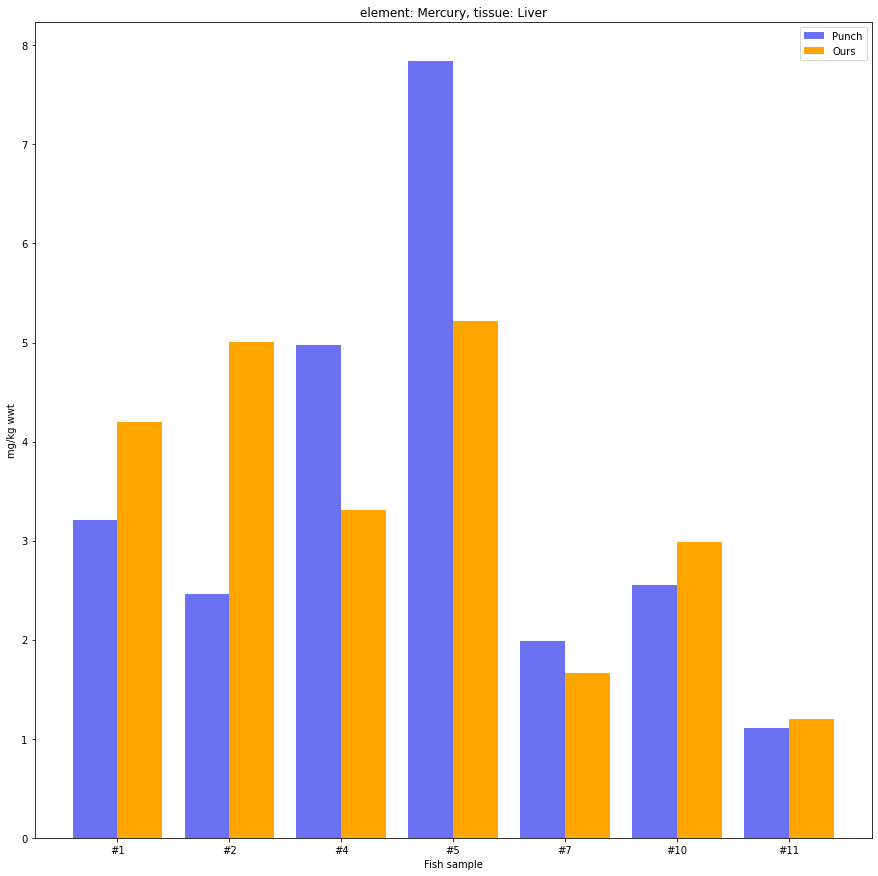

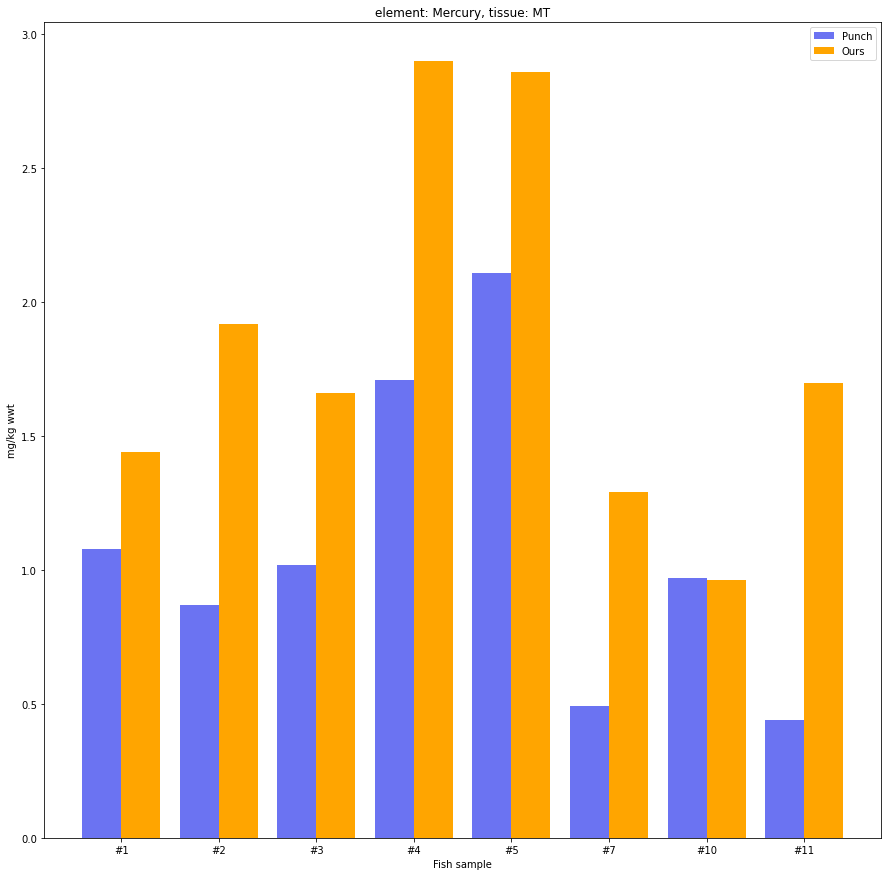

In [449]:
elements = punch_data["Analyte"].unique()
# elements = ["Zinc"]
tissues = punch_data["Tissue"].unique()
for element in elements:
    for tissue in tissues:
        fig, ax = plt.subplots(figsize = (15, 15))
        fig.set_facecolor("white")
        temp = punch_data[["Sample_Tag", "Result", "Ours"]].loc[(punch_data["Tissue"] == tissue) & (punch_data["Analyte"] == element) & (punch_data["Matrix"] == "Fish")].dropna()
        temp = temp.reindex(temp["Sample_Tag"].str.removeprefix("#").astype("int").sort_values().index)
        x = np.arange(temp["Sample_Tag"].shape[0])
        ax.bar(x, temp["Result"].to_numpy("single").T, width = 0.4, label = "Punch", color = [.42, .45, .95])
        ax.bar(x+.4, temp["Ours"].to_numpy("single").T, width = 0.4, label = "Ours", color = "orange")
        ax.set_xticks(x+0.2, temp["Sample_Tag"])
        ax.set_title(f"element: {element}, tissue: {tissue}")
        ax.set_xlabel("Fish sample")
        ax.set_ylabel("mg/kg wwt")
        ax.legend()
        if not os.path.exists("./pics/punch_ours/"):
            os.makedirs("./pics/punch_ours/")
        fig.savefig(f"./pics/punch_ours/{element}_{tissue}.png")

## punch vs Ours correlation

In [450]:
po_cor_dict = {}
# elements = ["Aluminum", "Zinc", "Mercury"]
elements = punch_data["Analyte"].unique()
for element in elements:
    row_id = np.logical_and(punch_data["Analyte"] == element, punch_data["Matrix"] == "Fish") & (punch_data["Tissue"] == "MT")
    temp = punch_data.loc[row_id, ["Sample_Tag" ,"Result", "Ours"]].dropna()
    result = pearsonr(temp["Ours"].to_numpy("double").ravel(),
                       temp["Result"].to_numpy("double").ravel())
    po_cor_dict.update({element: [temp, result]})

In [451]:
tags = list(po_cor_dict.values())[0][0]["Sample_Tag"].to_numpy()
values = np.zeros((len(po_cor_dict), tags.shape[0] * 2), dtype="single")
stat = np.zeros((len(po_cor_dict), 2))
for i in np.arange(len(po_cor_dict)):
    item = list(po_cor_dict.keys())[i]
    values[i, :] = np.r_[po_cor_dict[item][0]["Result"].to_numpy("single"), po_cor_dict[item][0]["Ours"].to_numpy("single")]
    stat[i, :] = np.array(po_cor_dict[item][1]).round(2)
po_cor_table = pd.DataFrame(np.c_[np.array(list(po_cor_dict.keys()), dtype="str")[:, np.newaxis], values, stat],
                                                columns=["analyte", *[*(tags + " Punch"), *(tags + " Ours")],
                                                          "statistic", "p-value"])


# Fishes height and weight

### reading fishes properties and calculating Fulton's condition factor

In [452]:
fishes = pd.read_excel("Copy of 2022 Sturgeon mortalities Biodata - Nechako River tracking Sept 22 2022.xlsx" , sheet_name='2022 mortality track')[["Tracking #", "TOTAL", "kg"]].dropna().rename(columns={"Tracking #" : "tag", "TOTAL" : "length", "kg":"weight"})
fishes.reset_index(inplace=True, drop=True)
b = 3 ## fulton factor coefficient
fulton = fishes["weight"] * 100000 / (fishes["length"] ** b)
fishes.insert(3, "fulton", fulton)
fishes

tag  length  weight    fulton
0    1   214.5    46.6  0.472176
1    2   189.0    43.2  0.639880
2    3   221.0    39.4  0.365022
3    4   189.0    34.8  0.515459
4    5   251.0    67.9  0.429387
5   10   247.5    74.9  0.494033
6   11   223.0    65.1  0.587038
7   13   114.0     6.6  0.445481

In [453]:
# elements = ["Aluminum", "Zinc"]
elements = data["Analyte"][1::2]
tissues = ["Liver", "MT"]
fish_dict = {}
for element in elements:
    id_liver = np.empty_like(fishes.index, dtype="bool")
    id_mt = np.empty_like(fishes.index, dtype="bool")
    for i in np.arange(id_mt.shape[0]):
        id_liver[i] = np.any(data.columns == f"White Sturgeon (WS #{fishes['tag'][i]}) Liver")
        id_mt[i] = np.any((data.columns == f"White Sturgeon (WS #{fishes['tag'][i]}) MT"))
    row_id = (data["Analyte"] == element) & (data["Units"] == "mg/kg wwt")
    c_liver = np.char.add(np.char.add("White Sturgeon (WS #", fishes['tag'][id_liver].to_numpy("str")), ") Liver")
    c_MT = np.char.add(np.char.add("White Sturgeon (WS #", fishes['tag'][id_mt].to_numpy("str")), ") MT")
    temp_liver = fishes.loc[id_liver, :]
    temp_liver.insert(3, "liver", data.loc[row_id, c_liver].to_numpy().T)
    temp_mt = fishes.loc[id_mt, :]
    temp_mt.insert(3, "MT", data.loc[row_id, c_MT].to_numpy().T)
    fish_dict.update({element: [temp_liver, temp_mt]})
        

### Scatter plot

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/2774086827.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(15, 6))


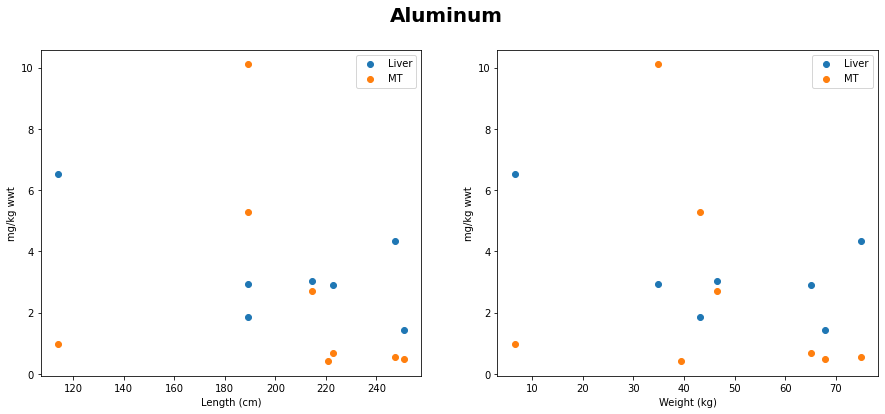

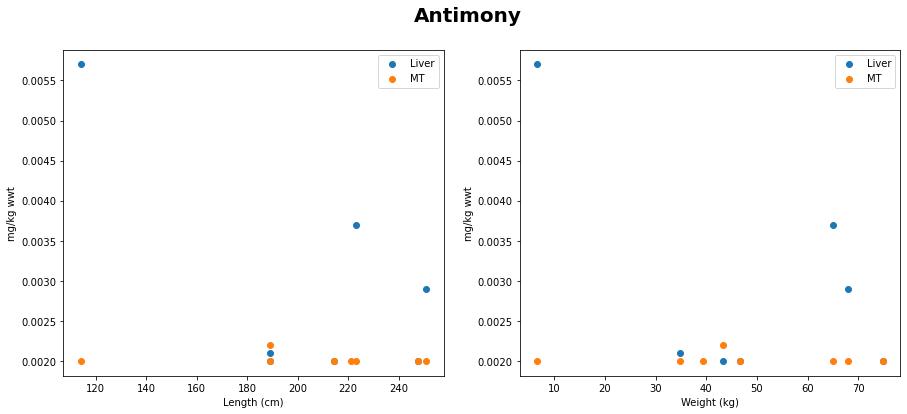

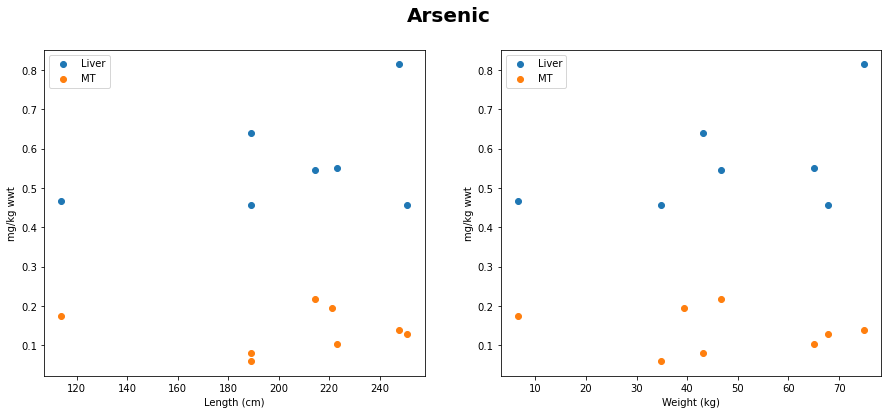

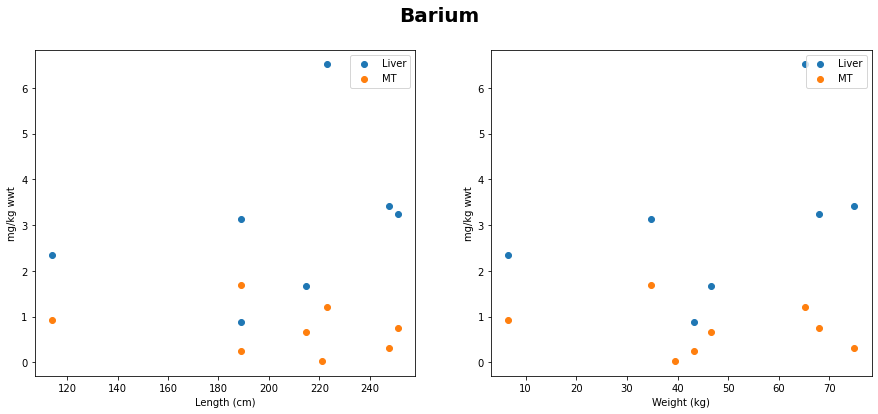

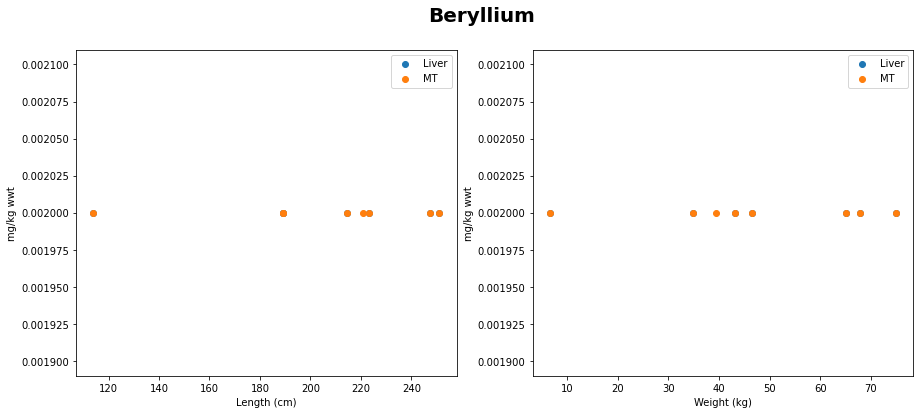

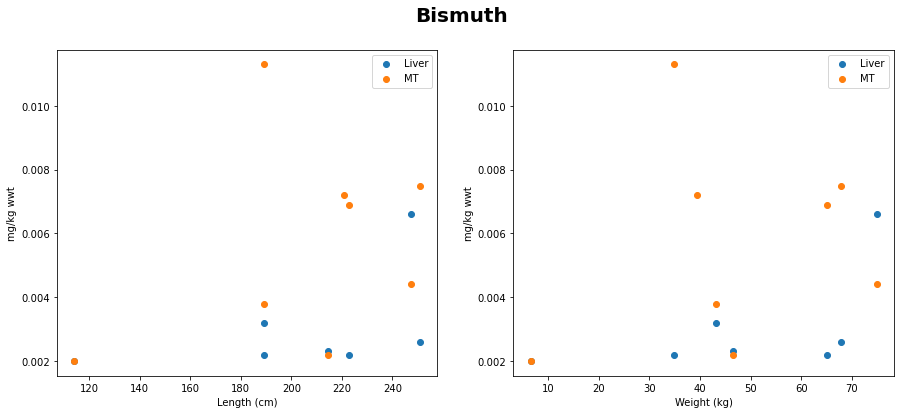

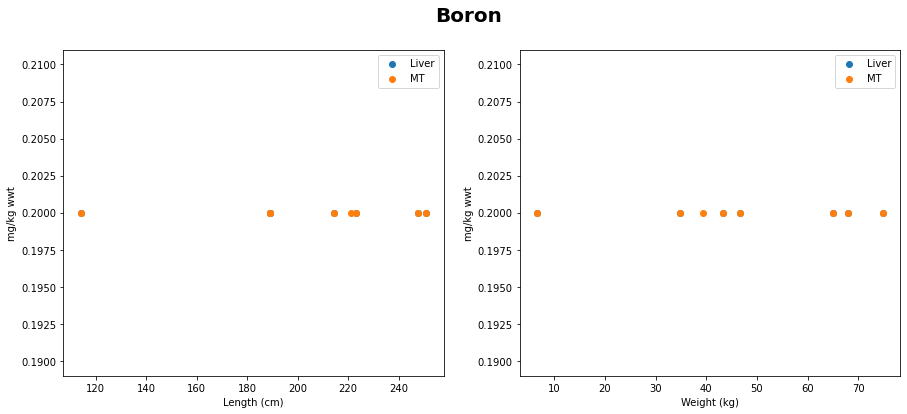

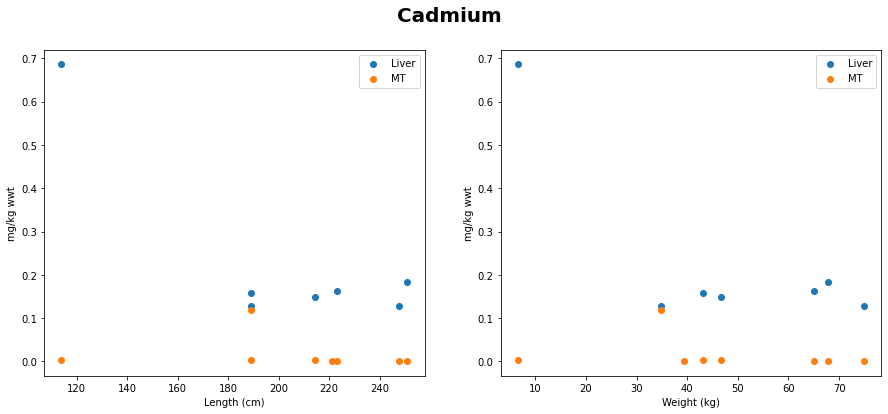

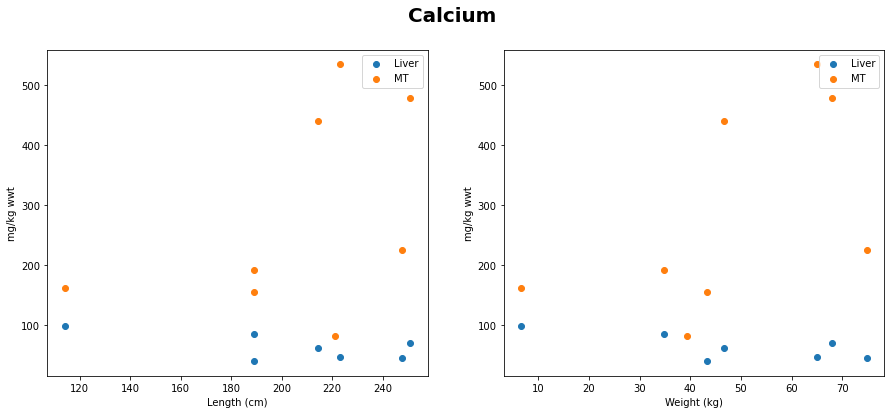

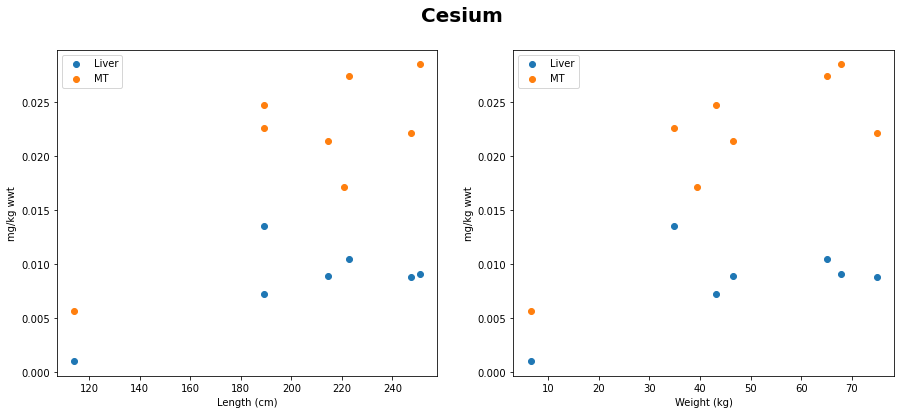

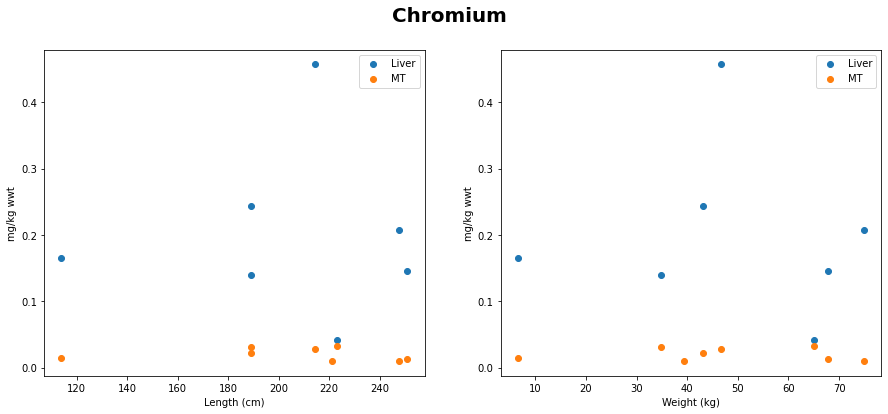

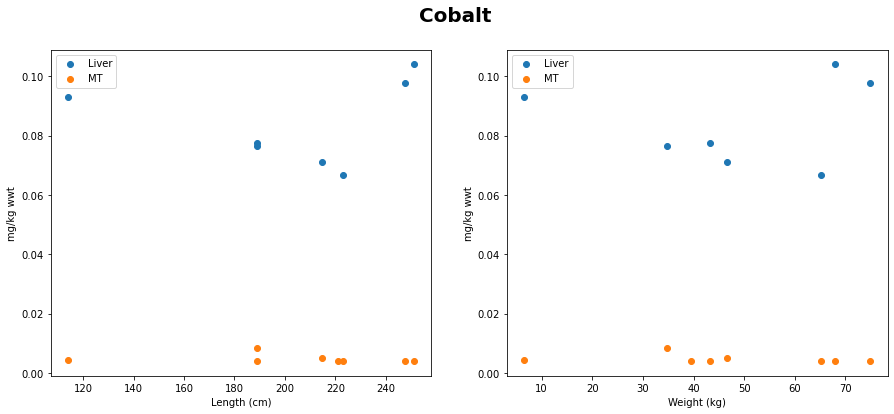

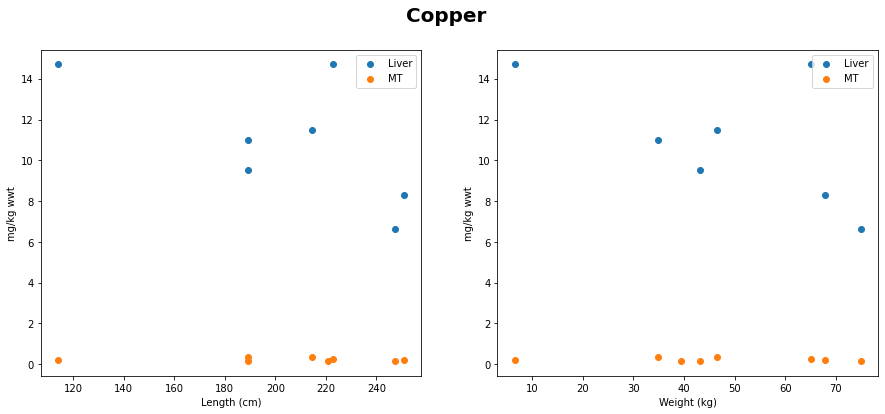

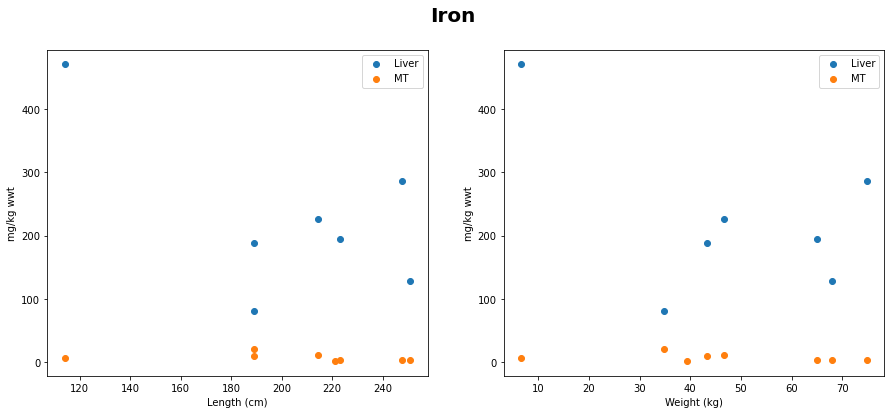

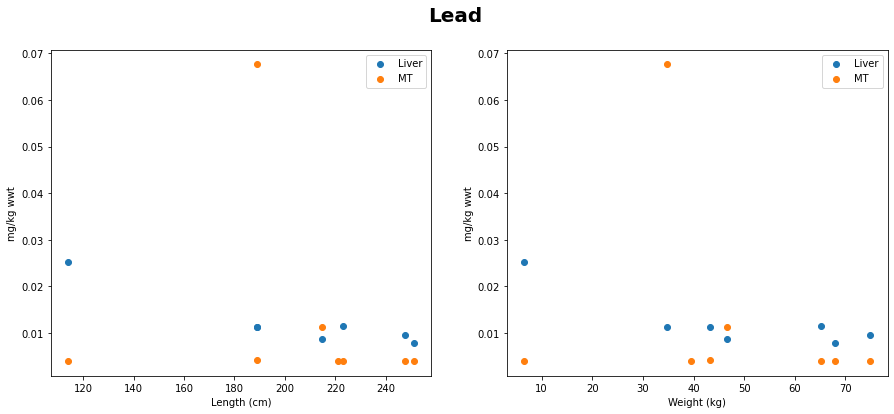

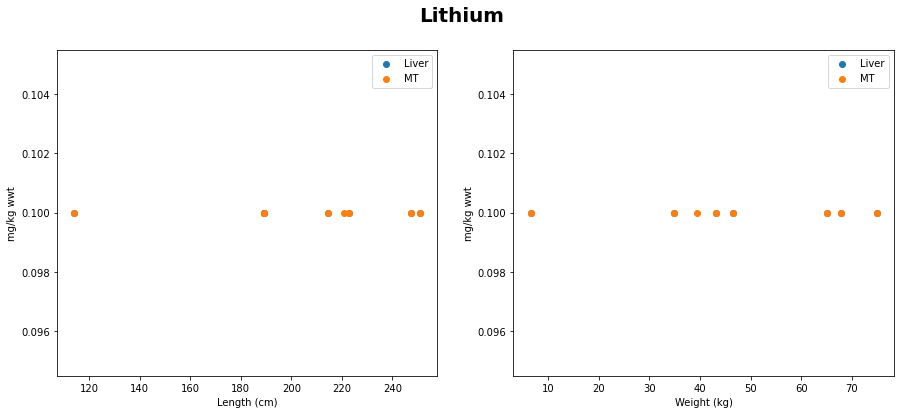

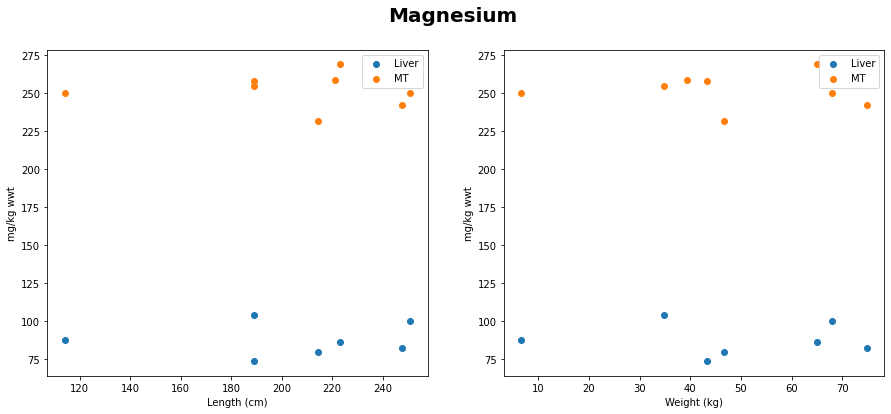

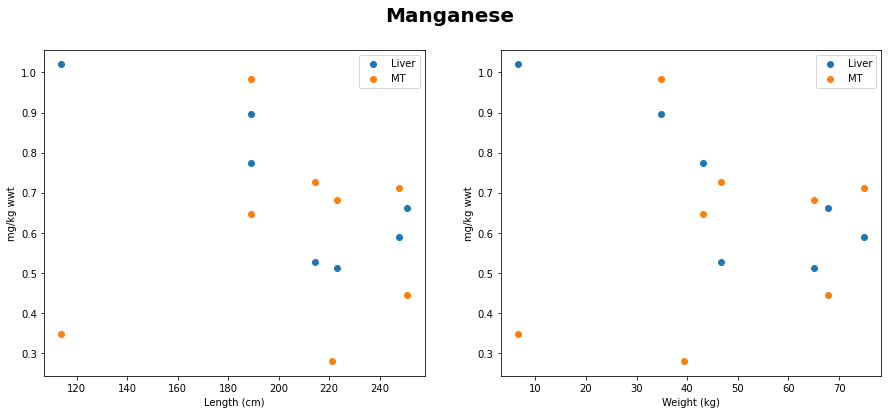

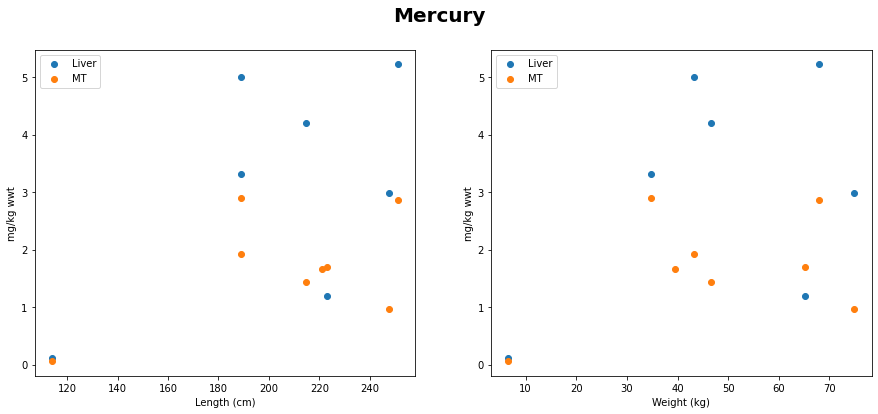

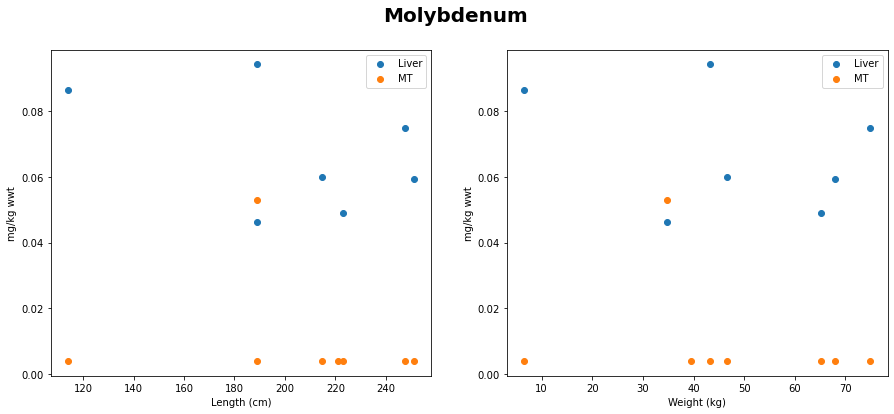

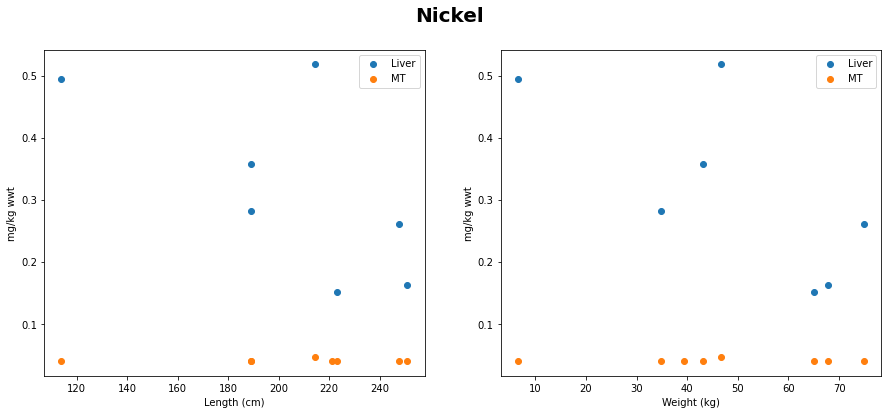

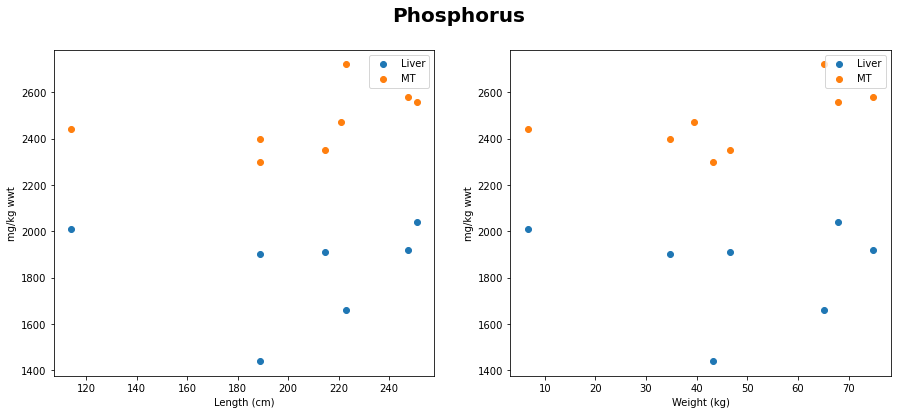

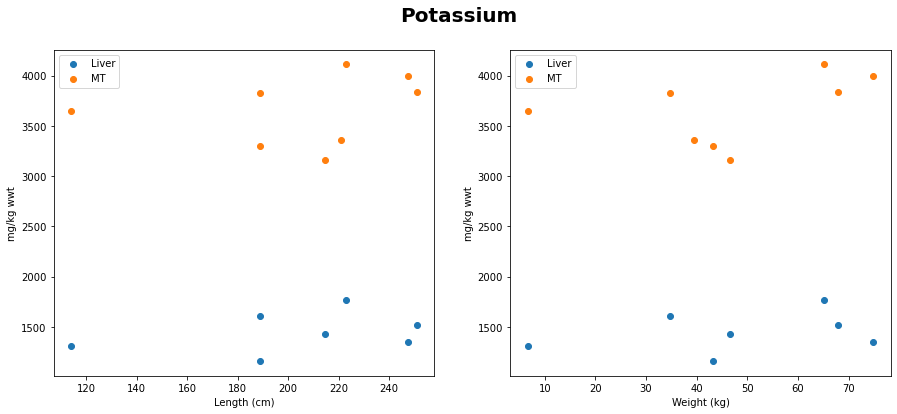

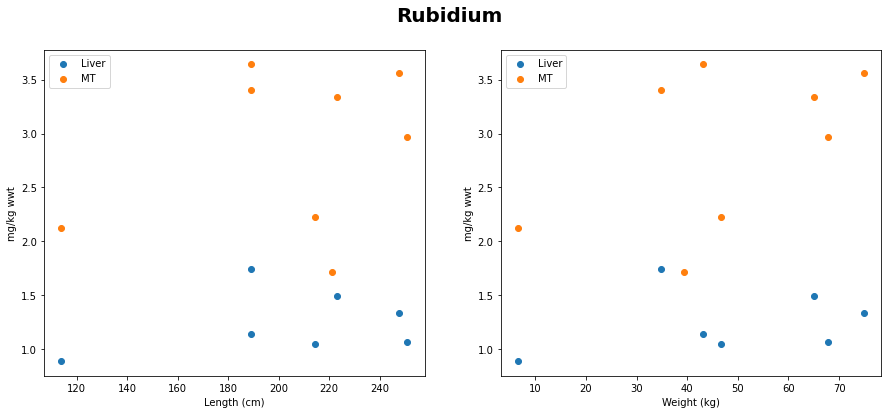

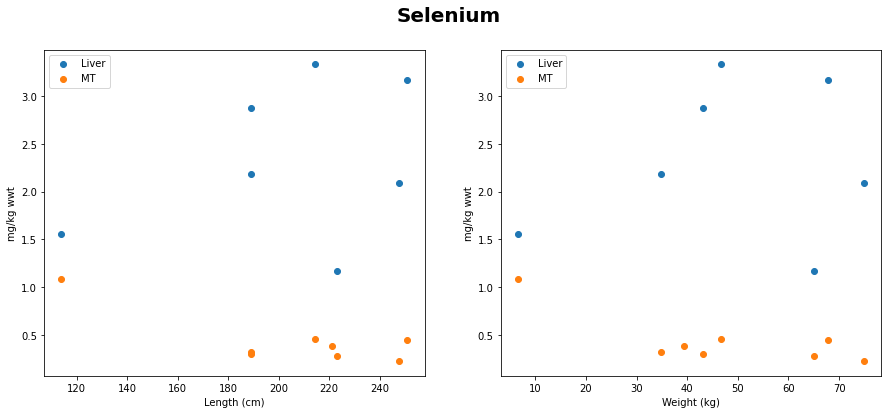

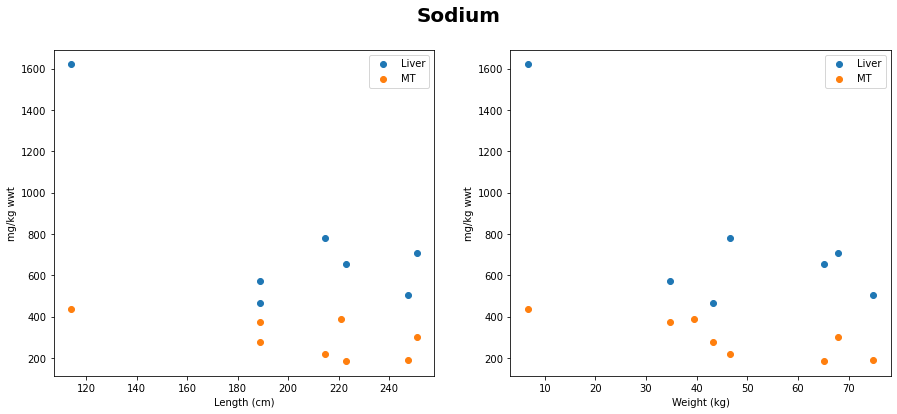

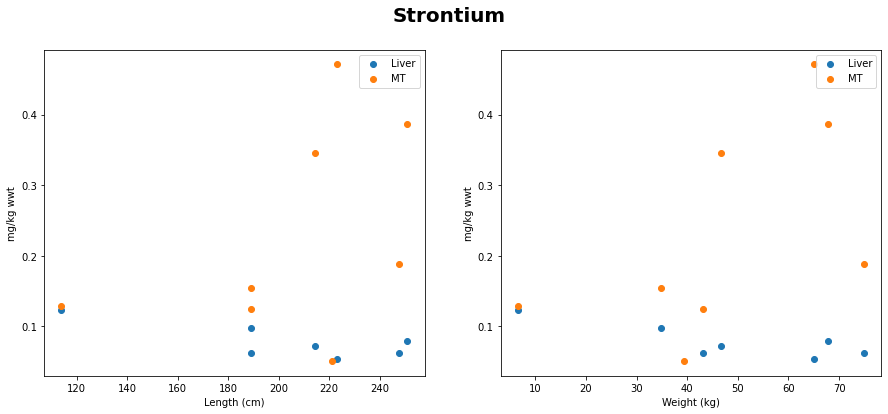

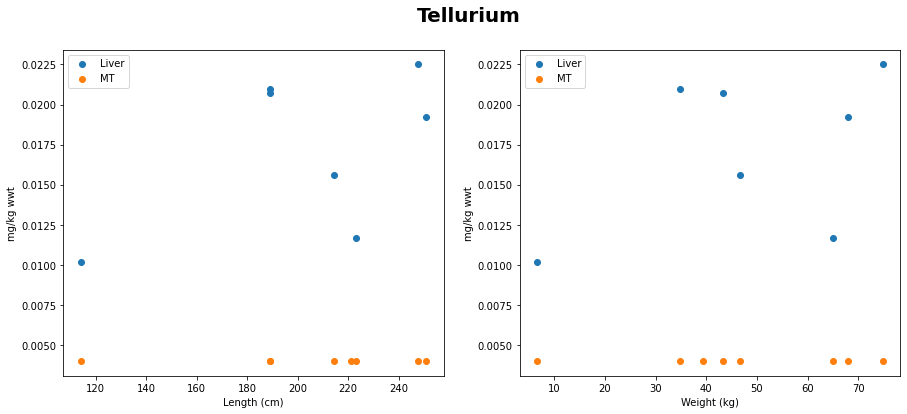

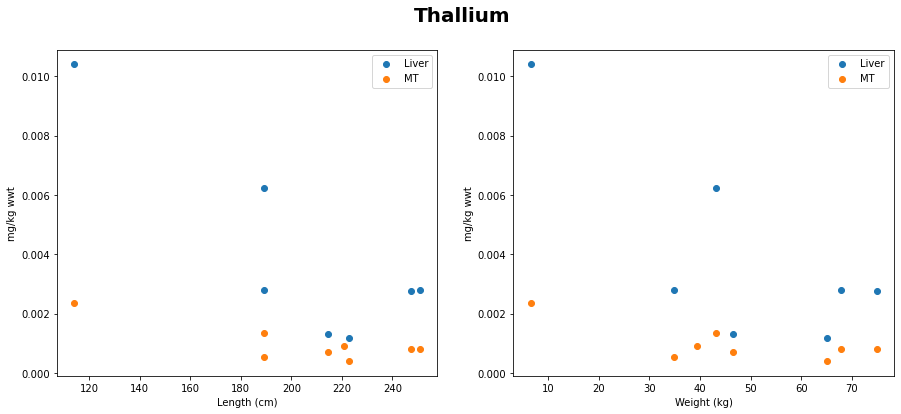

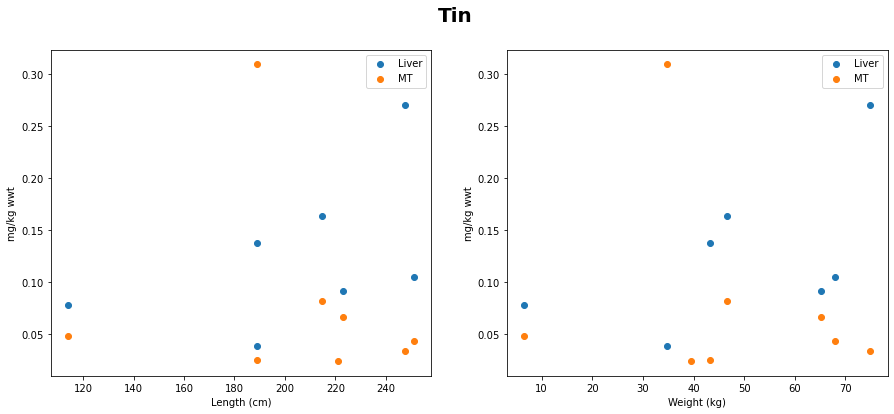

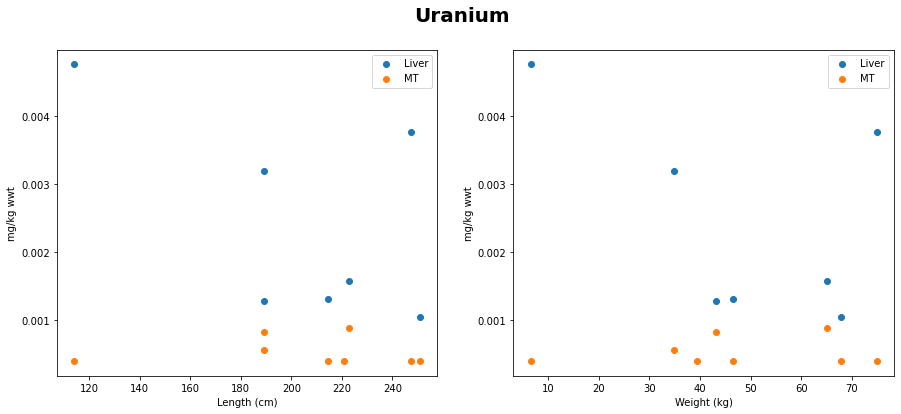

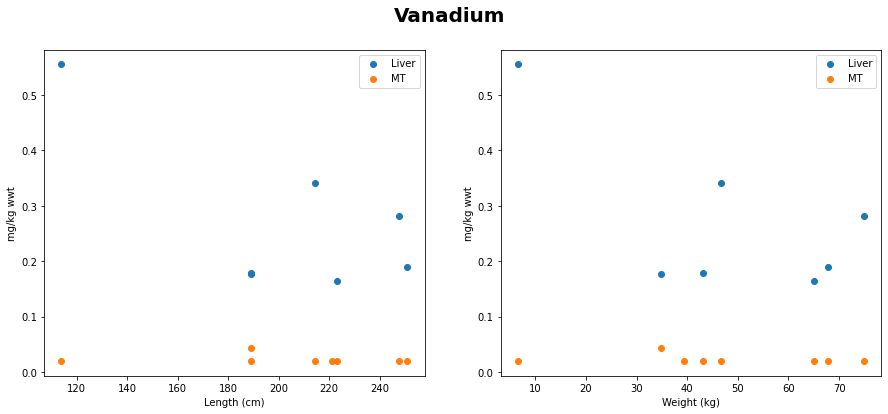

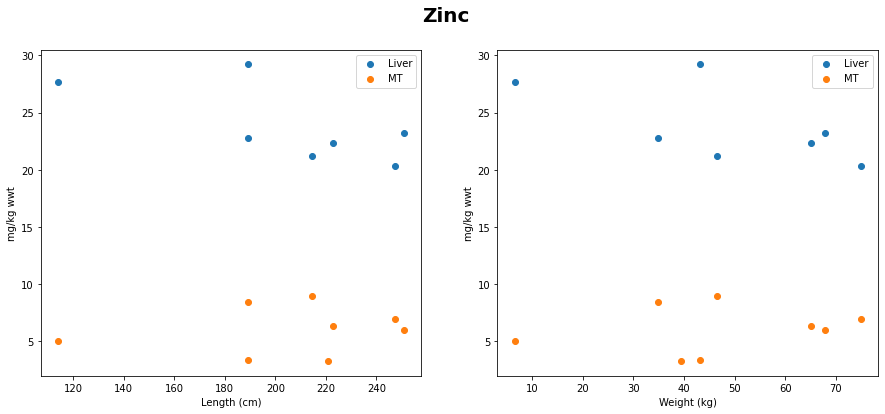

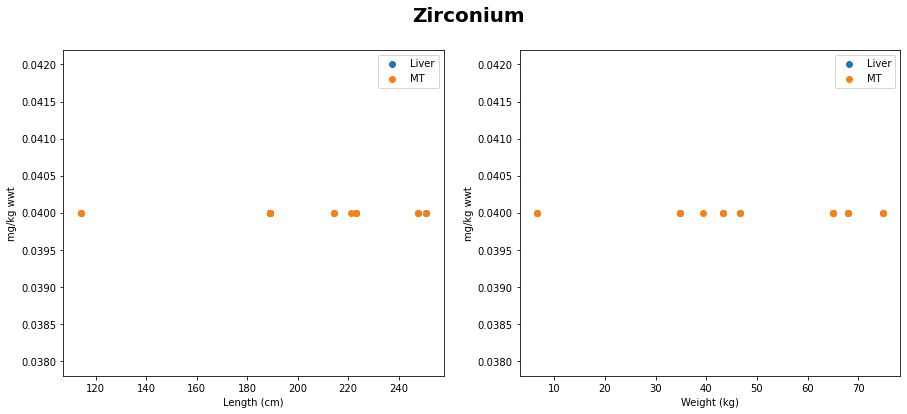

In [454]:
for element in fish_dict:    
    liver = fish_dict[element][0]
    mt = fish_dict[element][1]
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.set_facecolor("White")
    ax[0].scatter(*(liver[["length", "liver"]].to_numpy("float").T), label="Liver")
    ax[0].scatter(*(mt[["length", "MT"]].to_numpy("float").T), label="MT")
    ax[0].set_xlabel("Length (cm)")
    ax[0].set_ylabel("mg/kg wwt")
    ax[0].legend()
    ax[1].scatter(*(liver[["weight", "liver"]].to_numpy("float").T), label="Liver")
    ax[1].scatter(*(mt[["weight", "MT"]].to_numpy("float").T), label="MT")
    ax[1].set_xlabel("Weight (kg)")
    ax[1].set_ylabel("mg/kg wwt")
    ax[1].legend()
    fig.suptitle(element, fontsize=20, fontweight = "bold")
    if not os.path.exists("./pics/scatter/"):
        os.mkdir("./pics/scatter/")
    fig.savefig(f"./pics/scatter/{element}.png")

### Fulton Factor Plot

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/3872244711.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 6))


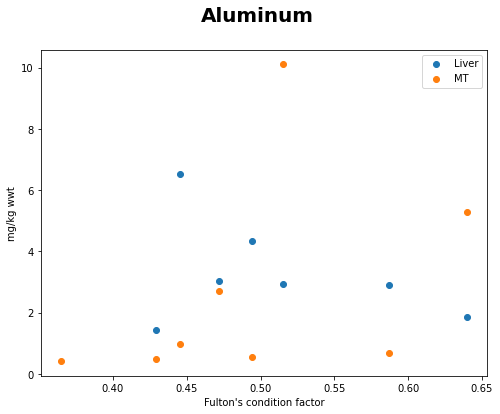

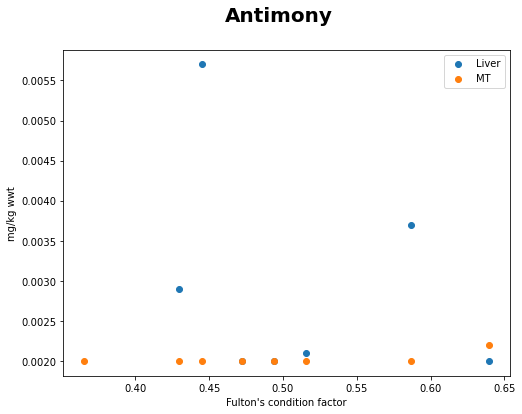

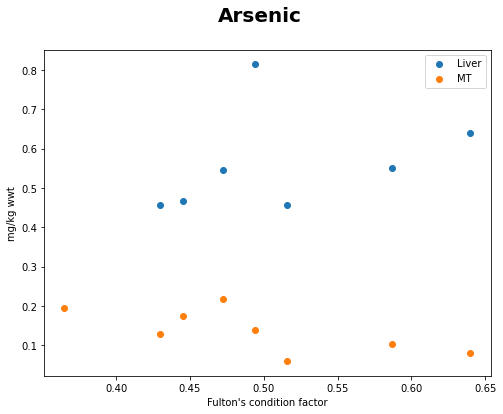

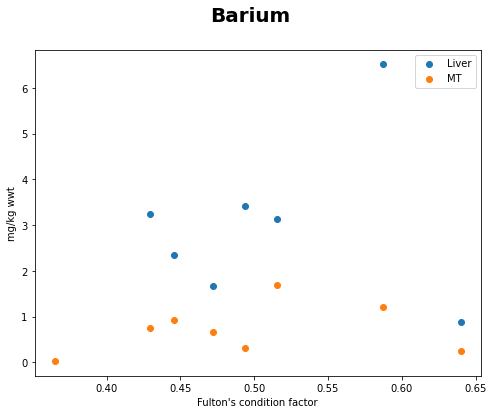

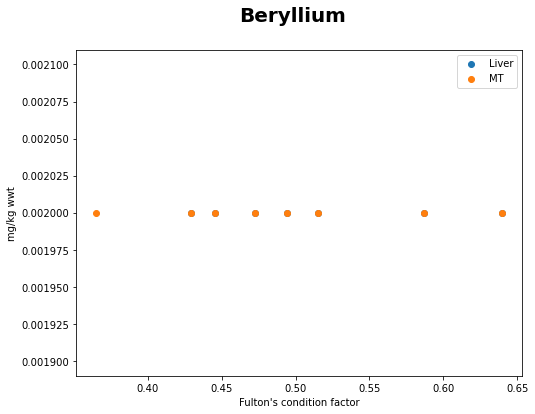

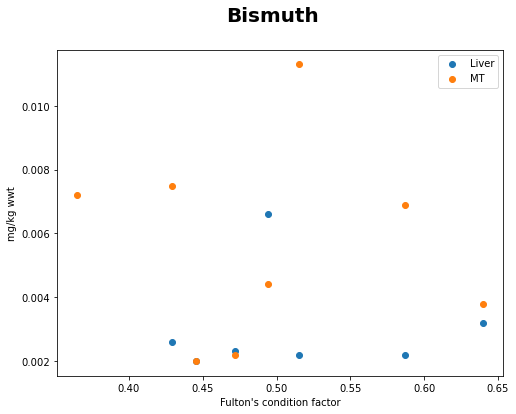

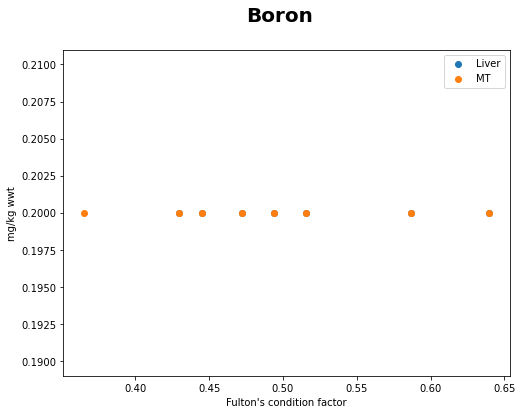

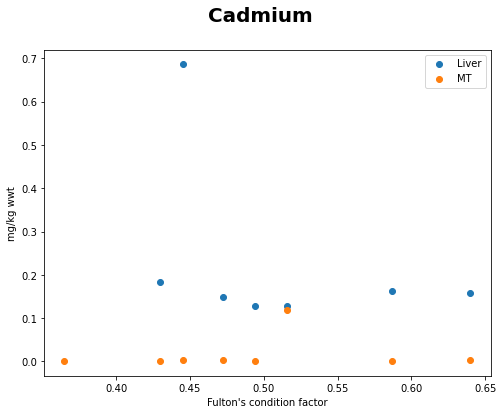

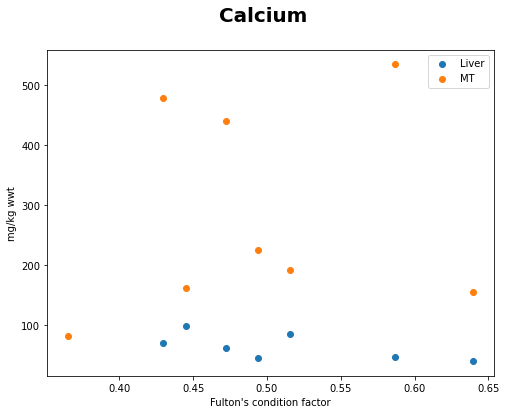

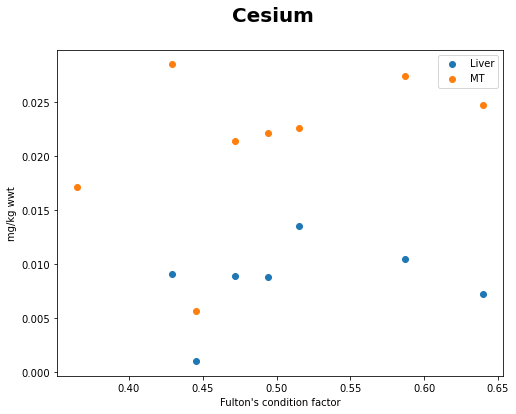

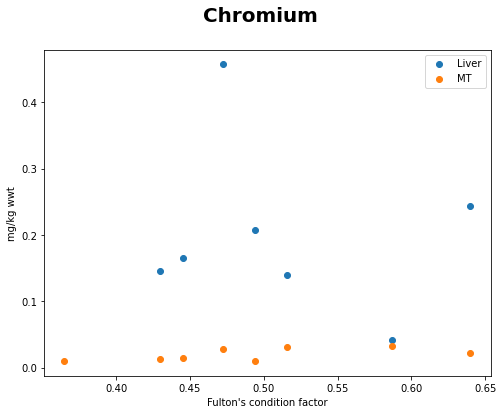

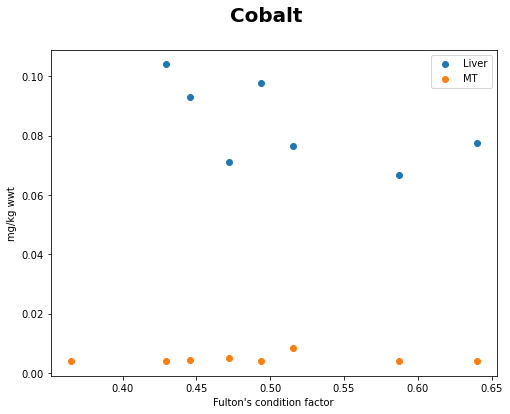

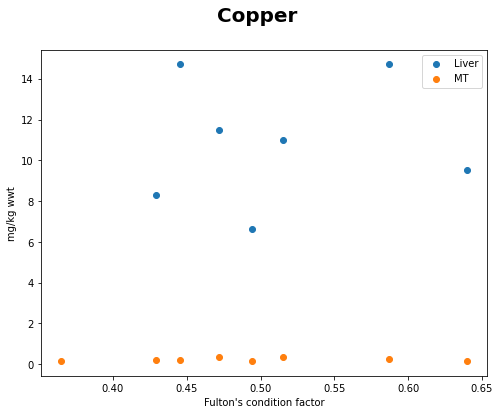

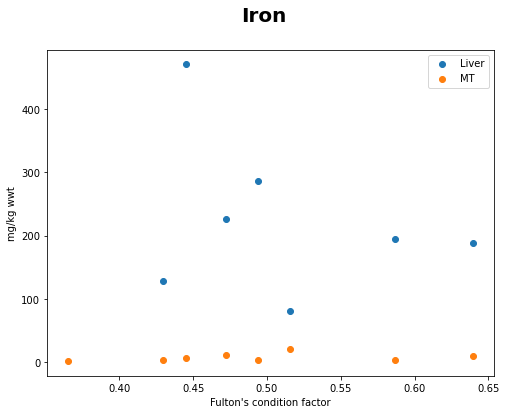

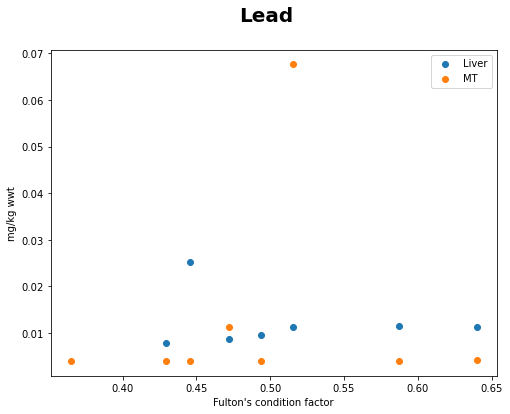

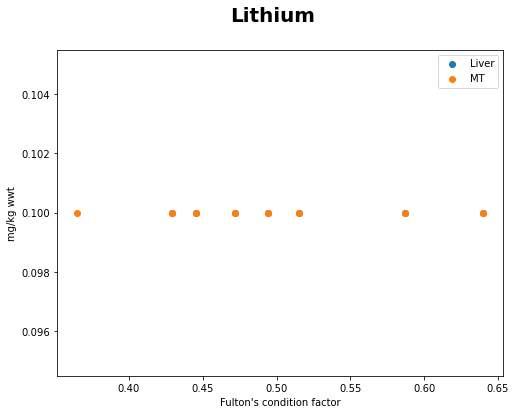

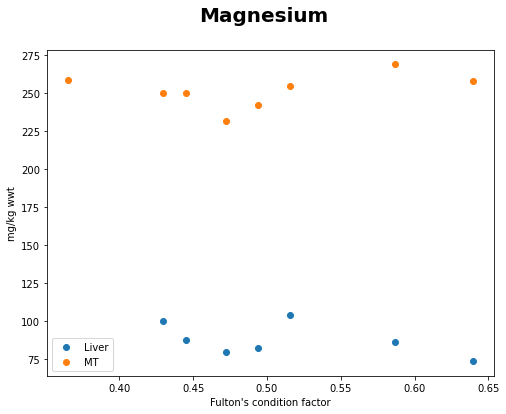

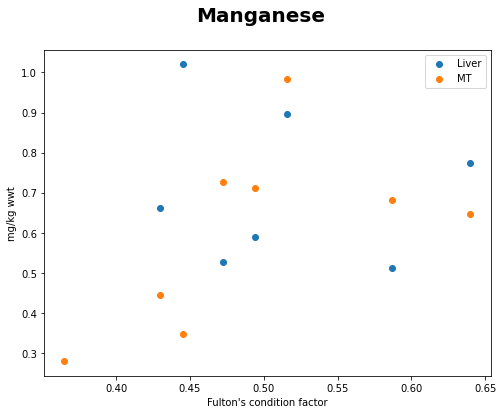

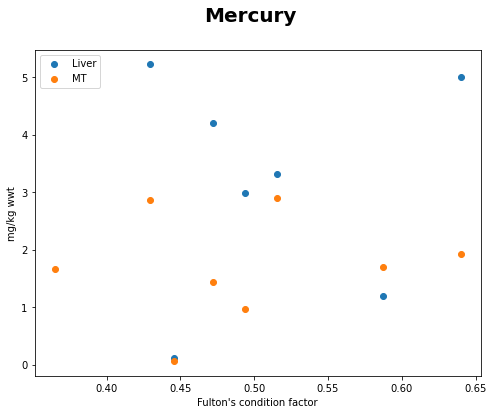

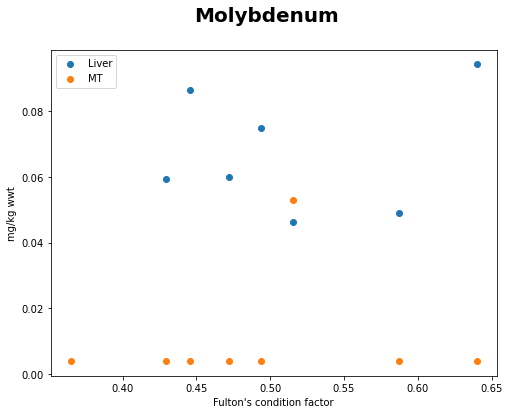

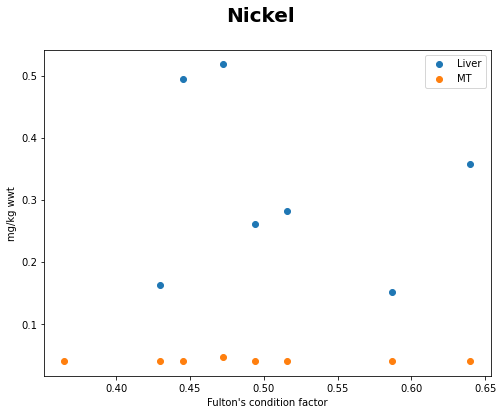

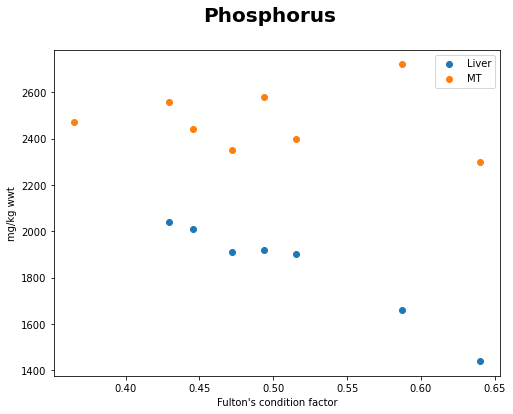

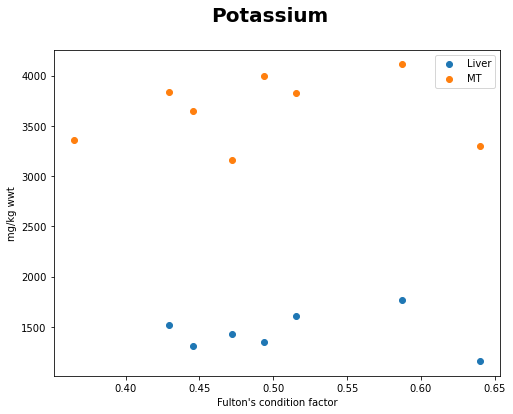

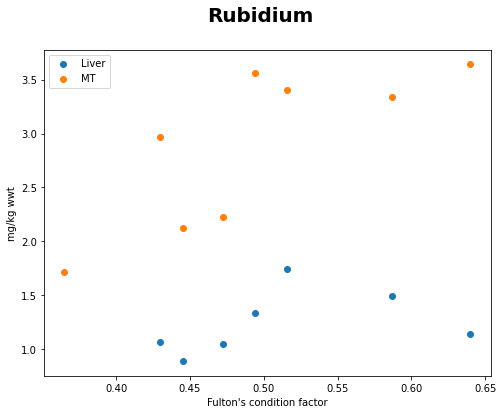

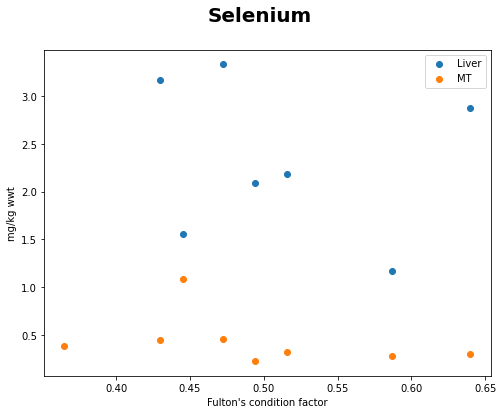

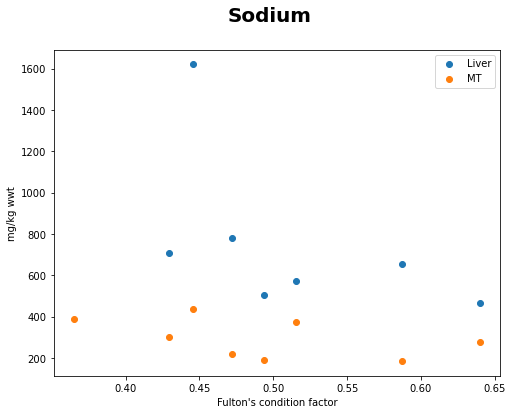

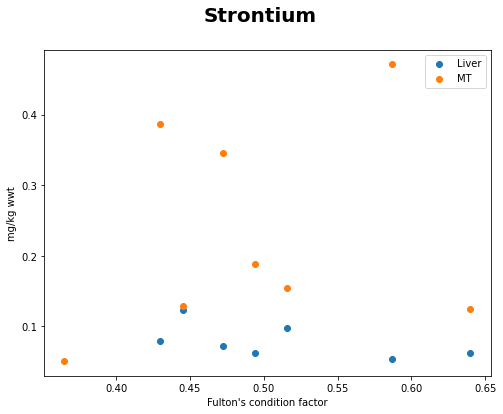

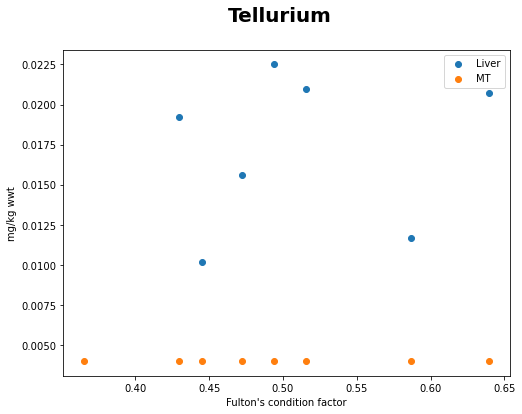

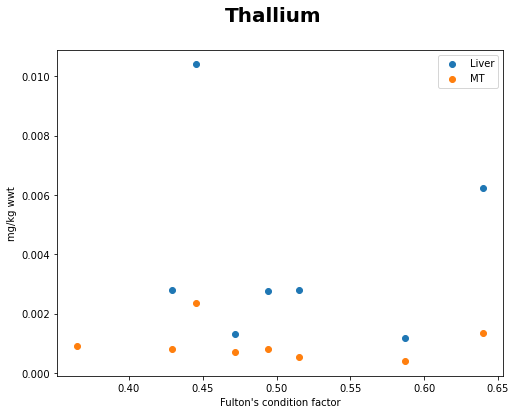

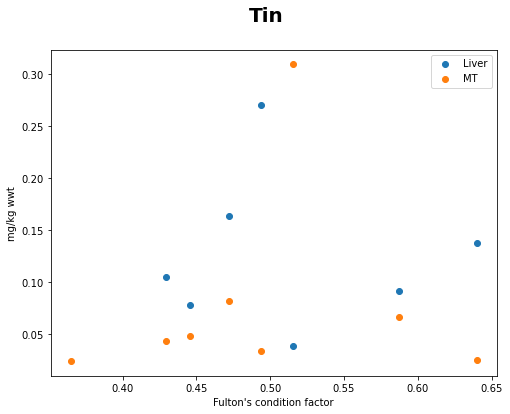

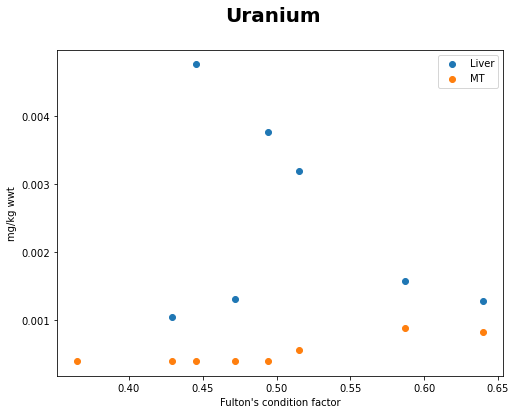

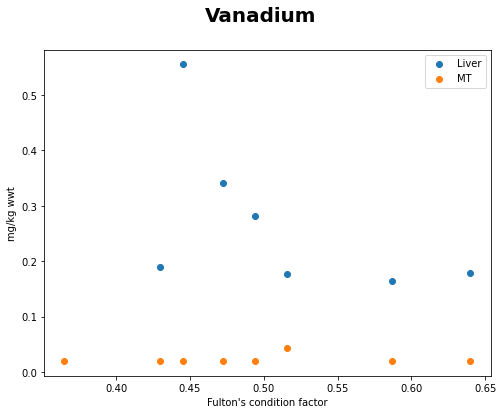

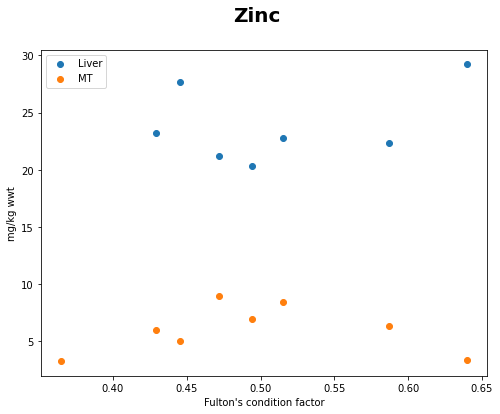

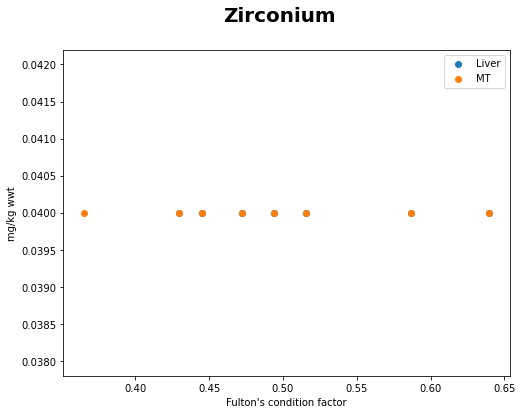

In [455]:
for element in fish_dict:    
    liver = fish_dict[element][0]
    mt = fish_dict[element][1]
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.set_facecolor("White")
    ax.scatter(*(liver[["fulton", "liver"]].to_numpy("float").T), label="Liver")
    ax.scatter(*(mt[["fulton", "MT"]].to_numpy("float").T), label="MT")
    ax.set_xlabel("Fulton's condition factor")
    ax.set_ylabel("mg/kg wwt")
    ax.legend()
    fig.suptitle(element, fontsize=20, fontweight = "bold")
    if not os.path.exists("./pics/scatter/fulton/"):
        os.mkdir("./pics/scatter/fulton/")
    fig.savefig(f"./pics/scatter/fulton/{element}.png")

## making excel for statistics
 dups, shapiro, pearson, anova, punch vs ours -> stats.xlsx

In [456]:
with pd.ExcelWriter('stats.xlsx') as writer:
    dups.to_excel(writer, sheet_name="dups")
    shapiro_table.to_excel(writer, sheet_name="shapiro")
    pearson_liver_mt_table.to_excel(writer, sheet_name="pearson liver-mt")
    anova_table.to_excel(writer, sheet_name= "One Way Anova")
    ttest_table.to_excel(writer, sheet_name = "t_test")
    po_cor_table.to_excel(writer, sheet_name= "punch vs ours MT Cor")

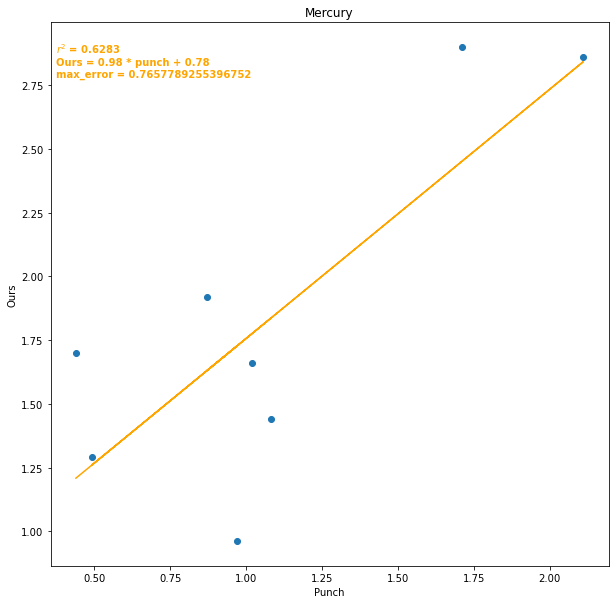

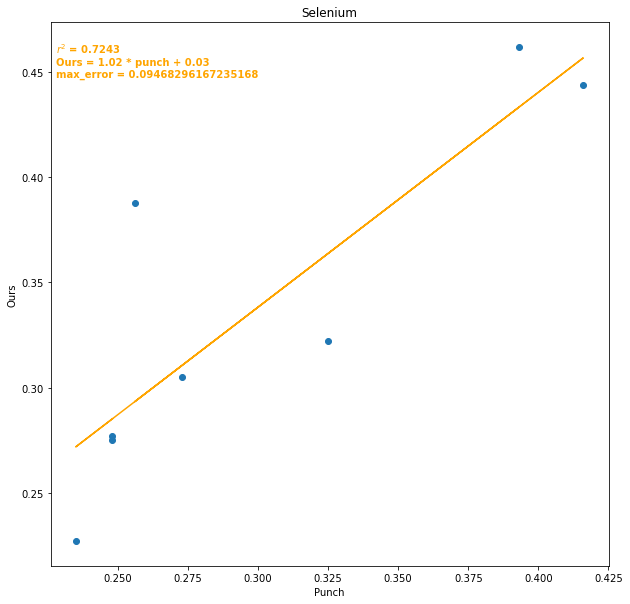

In [457]:
analyte_set = ["Mercury", "Selenium"]
for analyte in analyte_set:
    temp = po_cor_dict[analyte][0]
    temp = temp.reindex(temp["Sample_Tag"].str.removeprefix("#").astype("int8").sort_values().index)
    temp
    model = LinearRegression()
    model.fit(temp["Result"].to_numpy().reshape(-1, 1), temp["Ours"].to_numpy())
    r_sq = model.score(temp["Result"].to_numpy().reshape(-1, 1), temp["Ours"].to_numpy())
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.set_facecolor("white")
    ax.scatter(*temp[["Result", "Ours"]].to_numpy().T)
    ax.set_xlabel("Punch")
    ax.set_ylabel("Ours")
    ax.set_title(analyte)
    ax.plot(temp["Result"].to_numpy().reshape(-1, 1), model.predict(temp["Result"].to_numpy().reshape(-1, 1)), color = "orange")
    merror = max_error(temp["Ours"].to_numpy(), model.predict(temp["Result"].to_numpy().reshape(-1, 1)))
    ax.annotate(f"$r^2$ = {r_sq.round(4)}\nOurs = {model.coef_[0].round(2)} * punch + {model.intercept_.round(2)}\nmax_error = {merror}",
                 (0.01*np.diff(ax.get_xlim())[0]+ax.get_xlim()[0], ax.get_ylim()[1]-0.1*np.diff(ax.get_ylim())[0]), color = "orange", fontweight = "bold");
    if not os.path.exists("./pics/Reg"):
        os.mkdir("./pics/Reg")
    fig.savefig(f"./pics/Reg/{analyte}.png")

## Hatcheri data

In [458]:
# bismuth, cesium, Lithium, Phosphorus, Rubidum, Strontium, Tellurium and Zirconium are the 8 elements that exist in our data but not in hatcheri data.
# inorganic arsenic, Silicon, Silver and Sulfur are the 4 elements that exist in Hatcheri data but not in our data.
hatcheri_A = pd.read_excel("hatcheri.xlsx", sheet_name= "A")
hatcheri_B = pd.read_excel("Hatcheri.xlsx", sheet_name= "B")
hatcheri_C = pd.read_excel("Hatcheri.xlsx", sheet_name= "C")

In [459]:
elements = np.array([e for e in data.Analyte[1::2].to_numpy() if any(hatcheri_A.Analyte.str.contains(e))])
mins = np.empty_like(elements, dtype="float")
maxs = mins.copy()
means = mins.copy()
sd = mins.copy()
counts = mins.copy()
detected = mins.copy()

In [460]:
for i in np.arange(elements.shape[0]):
    temp = data.loc[np.logical_and(data["Analyte"] == elements[i], data["Units"] == "mg/kg wwt"), data.columns.str.contains("MT")].to_numpy("float")
    dl = data.loc[np.logical_and(data["Analyte"] == elements[i], data["Units"] == "mg/kg wwt"), "Lowest\nDetection Limit"].to_numpy("float")
    mins[i] = temp.min()
    means[i] = temp.mean()
    maxs[i] = temp.max()
    sd[i] = temp.std()
    counts[i] = temp.shape[1]
    detected[i] = (1-(np.sum(temp == dl)/temp.shape[1])) * 100


In [461]:
hatcheri_D = pd.DataFrame({'Analyte': elements, 'Count of Results': counts.astype(np.int8), 'Detected':detected, 'Min': mins, 'Mean': means, 'Max': maxs, 'SD': sd})

In [462]:
import pandas as pd
from openpyxl import load_workbook

excel_path = 'Hatcheri.xlsx'
book = load_workbook(excel_path)
writer = pd.ExcelWriter(excel_path, engine='openpyxl') 
if 'D' in book.sheetnames:
    del book['D']
writer.book = book
hatcheri_D.to_excel(writer, index=False, sheet_name="D")

writer.save()
writer.close()


In [463]:
hatcheri_A["Size"] = "A"
hatcheri_B["Size"] = "B"
hatcheri_C["Size"] = "C"
hatcheri_D["Size"] = "D"

In [464]:
hatcheri = hatcheri_A.append([hatcheri_B, hatcheri_C, hatcheri_D])

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/3821910915.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hatcheri = hatcheri_A.append([hatcheri_B, hatcheri_C, hatcheri_D])


In [465]:
hatcheri.sort_values(by="Analyte", inplace=True)

In [466]:
hatcheri

Analyte  Count of Results  Detected       Min      Mean       Max  \
0   Aluminum                 3     100.0  0.519000  0.910000   1.23000   
0   Aluminum                 3     100.0  0.406000  0.480000   0.55400   
0   Aluminum                 9     100.0  0.420000  2.442222  10.10000   
0   Aluminum                 3       0.0  0.129000  0.140000   0.15050   
1   Antimony                 3       0.0  0.000478  0.000670   0.00079   
..       ...               ...       ...       ...       ...       ...   
28  Vanadium                 3     100.0  0.002370  0.004000   0.00494   
29      Zinc                 3     100.0  3.370000  3.530000   3.75000   
29      Zinc                 3     100.0  2.940000  3.180000   3.43000   
29      Zinc                 3     100.0  2.920000  3.100000   3.29000   
25      Zinc                 9     100.0  3.290000  5.980000   8.96000   

          SD Size  
0   0.360000    A  
0   0.074000    B  
0   3.096413    D  
0   0.011000    C  
1   0.000170    B  
..       ...  ...  
28  0.001400    A  
29  0.197000    B  
29  0.245000    A  
29  0.190000    C  
25  1.869783    D  

[116 rows x 8 columns]

In [467]:
elements = hatcheri["Analyte"].unique()

/var/folders/nv/jxcc7s_s6gb0ldg9xxcxv95r0000gn/T/ipykernel_40397/3545396011.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(facecolor="white", figsize=(10, 10))


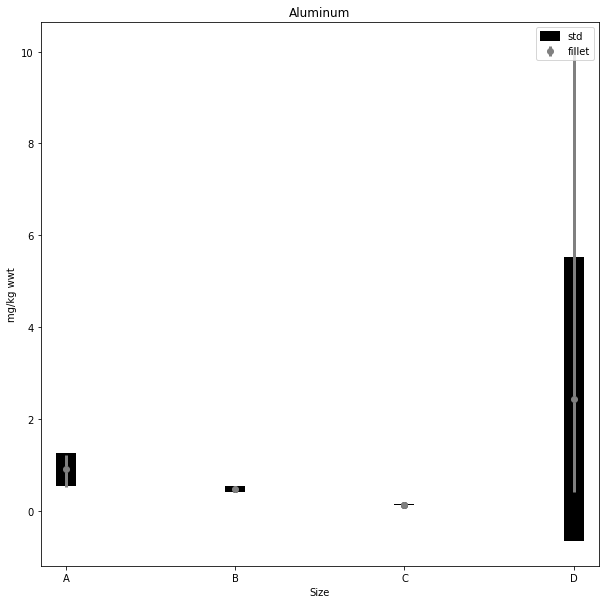

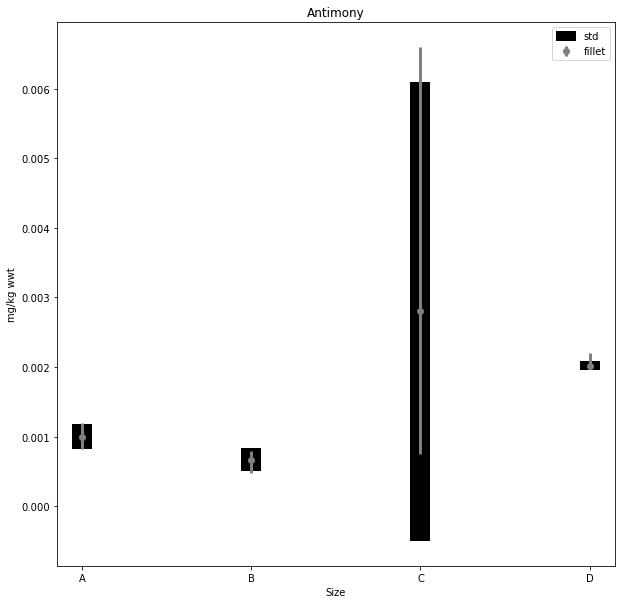

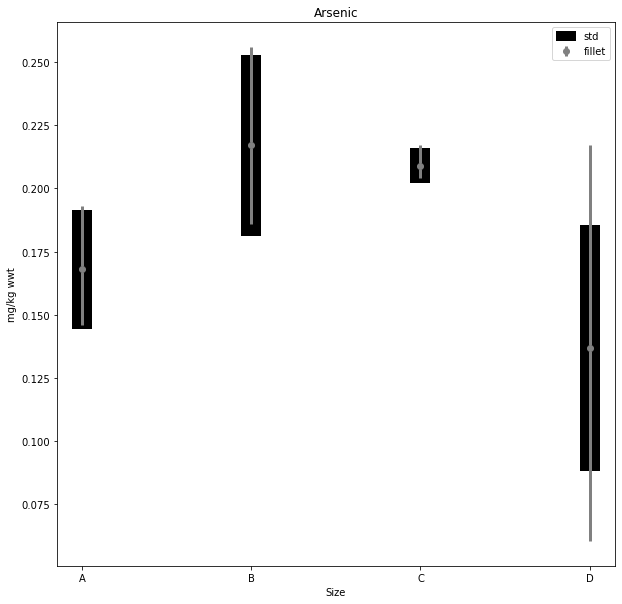

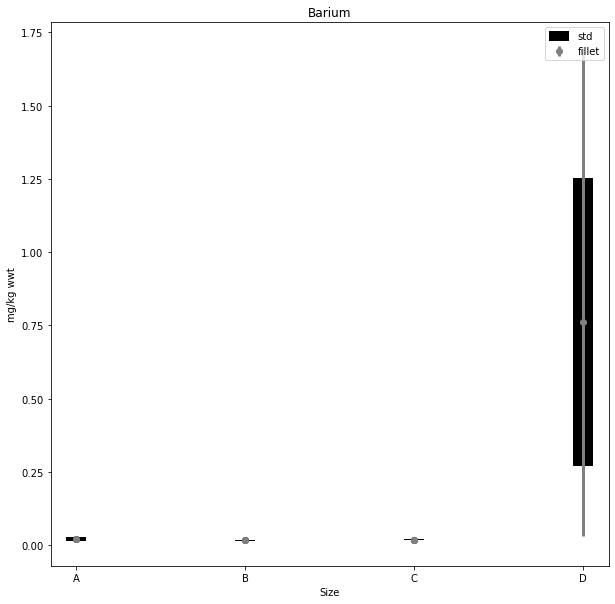

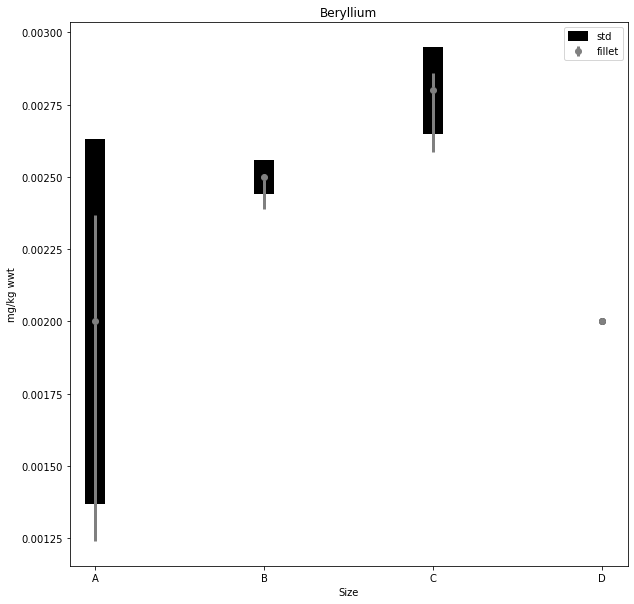

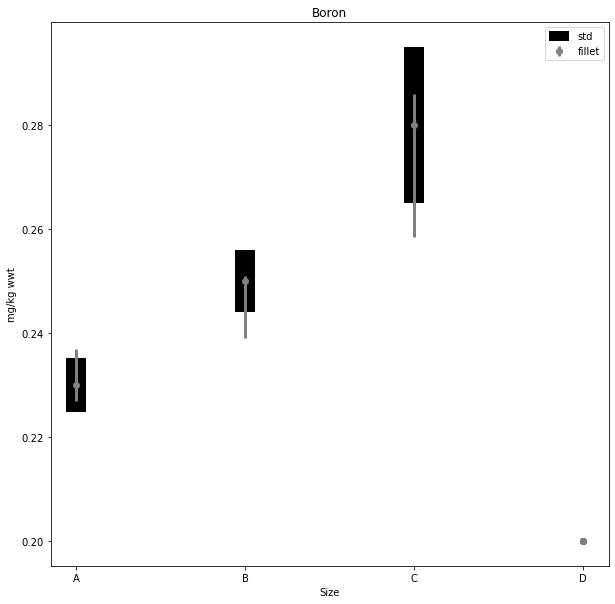

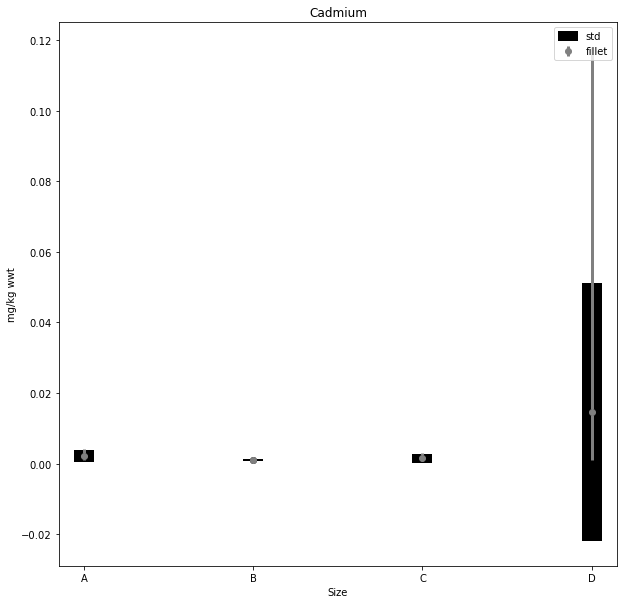

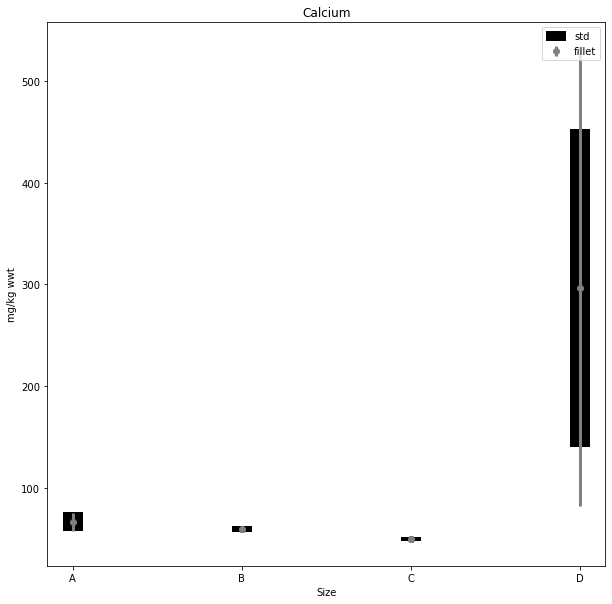

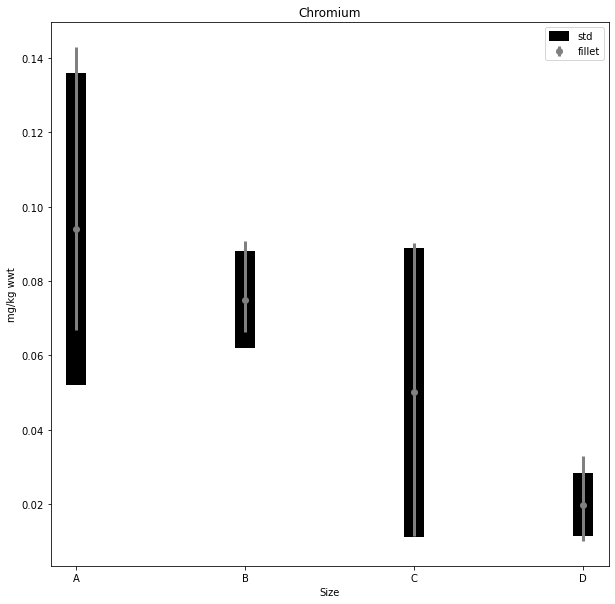

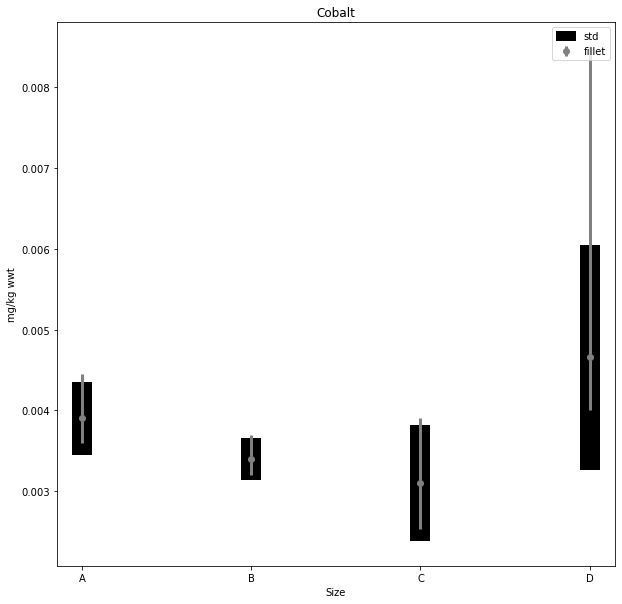

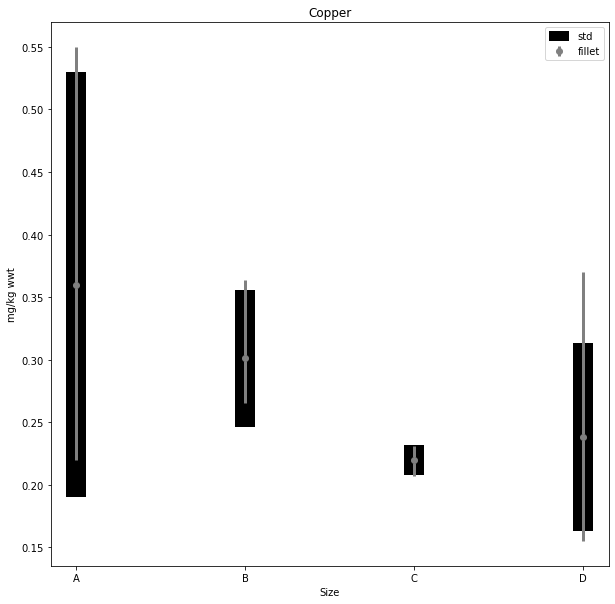

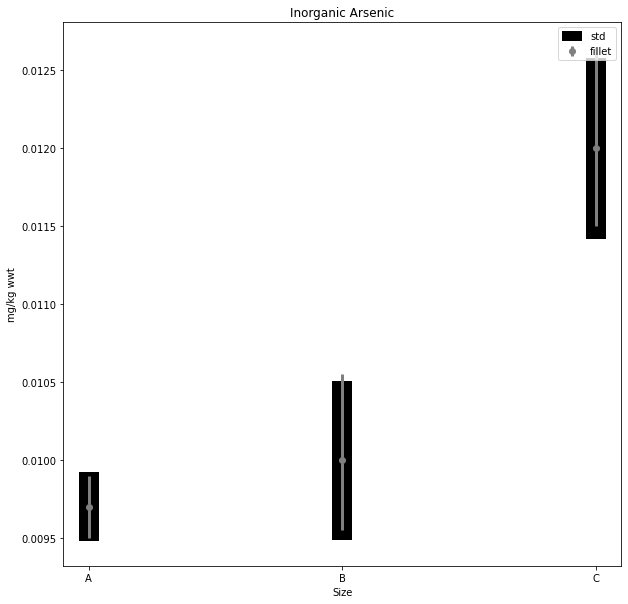

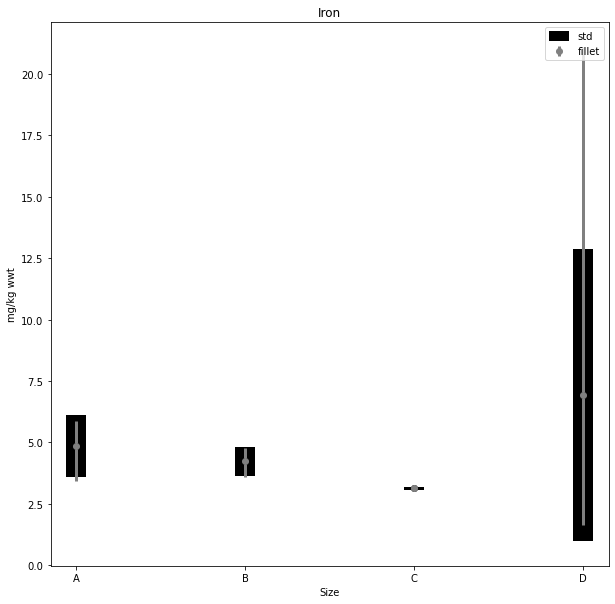

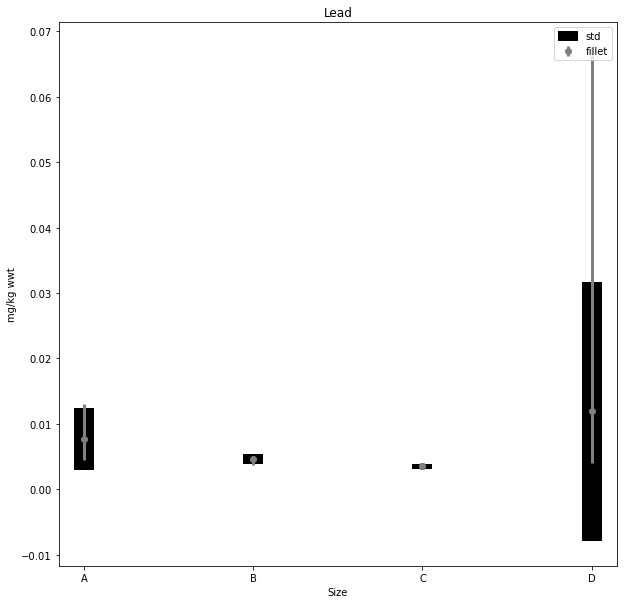

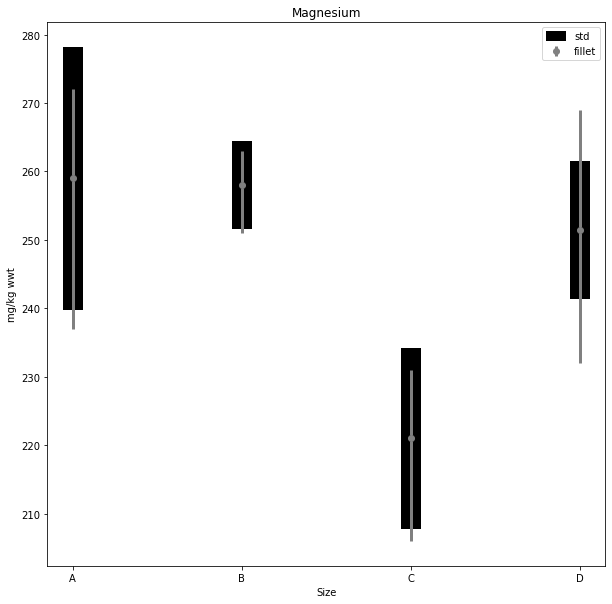

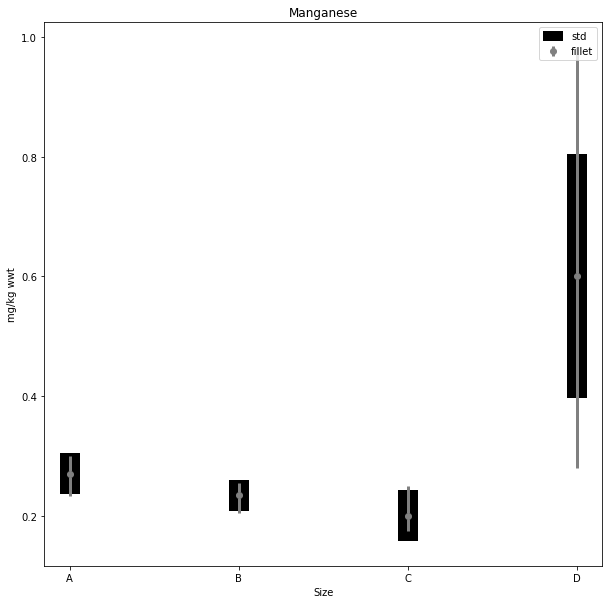

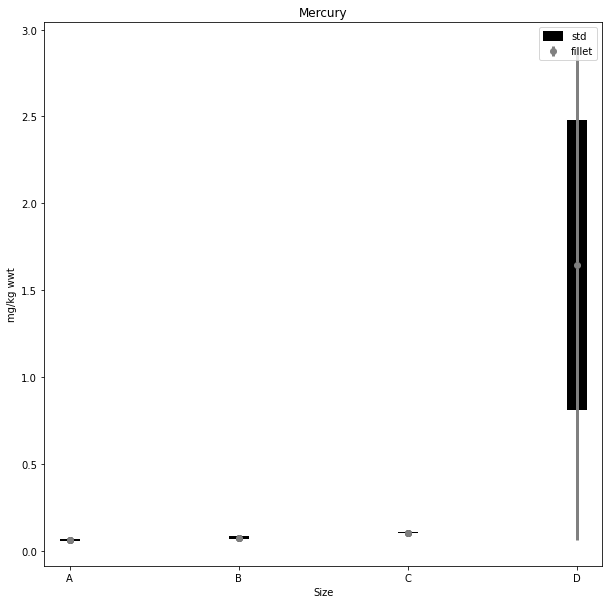

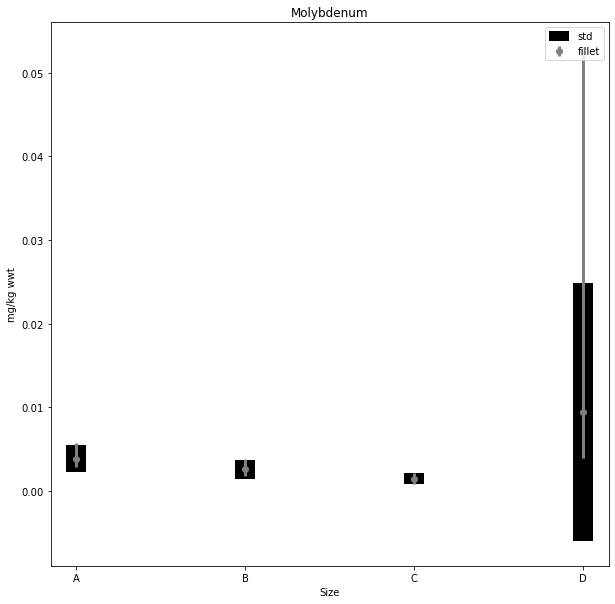

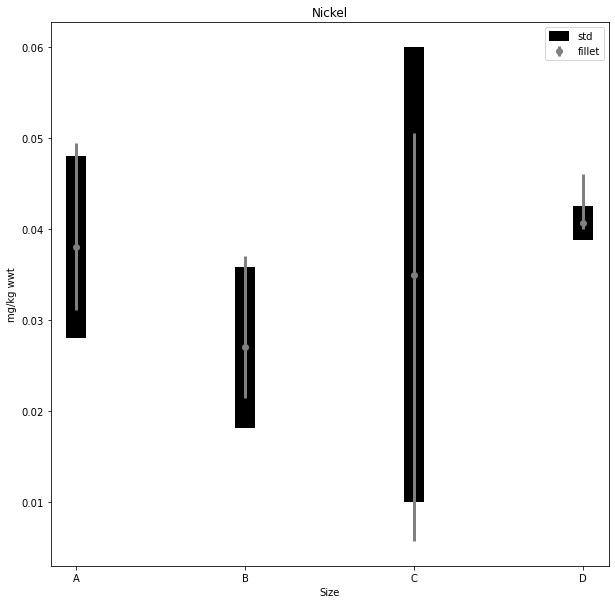

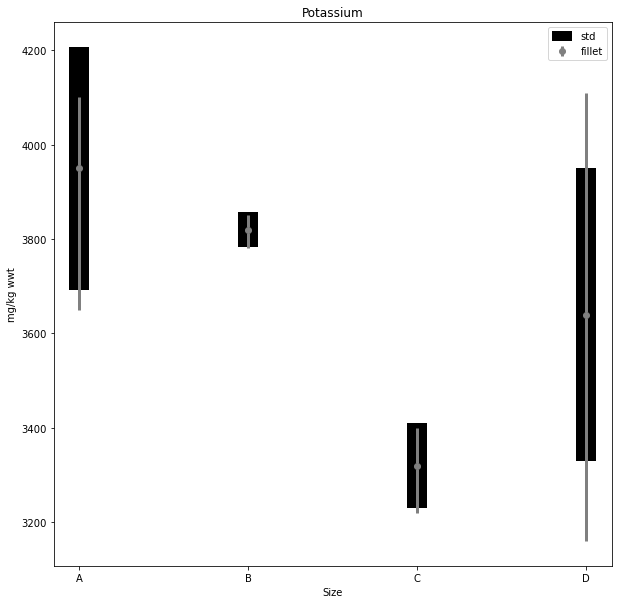

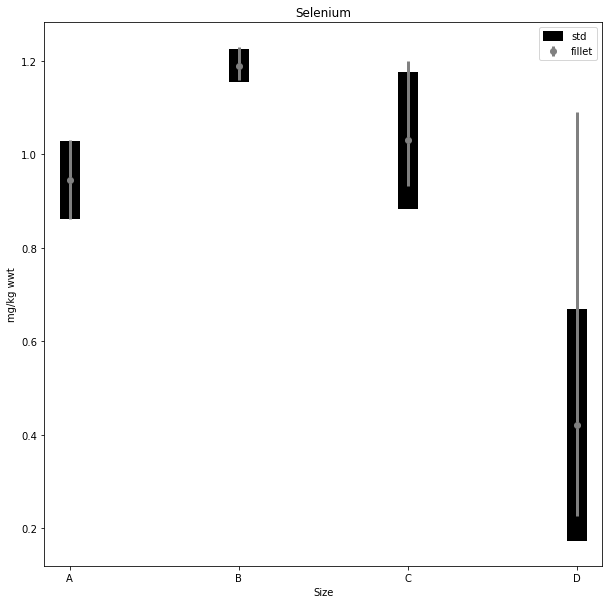

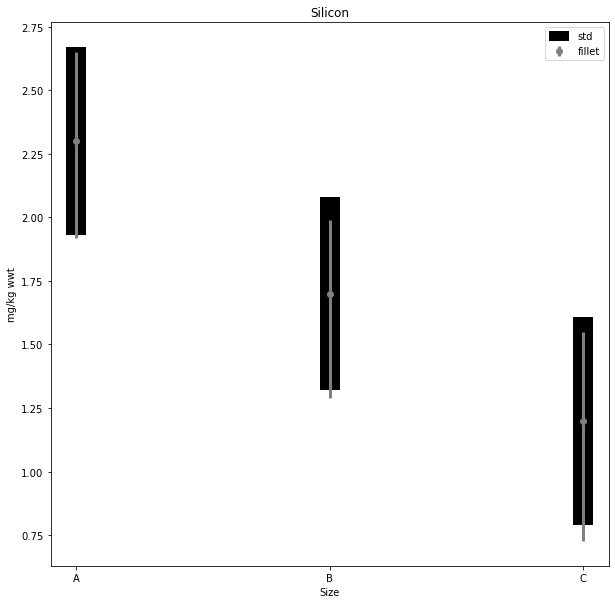

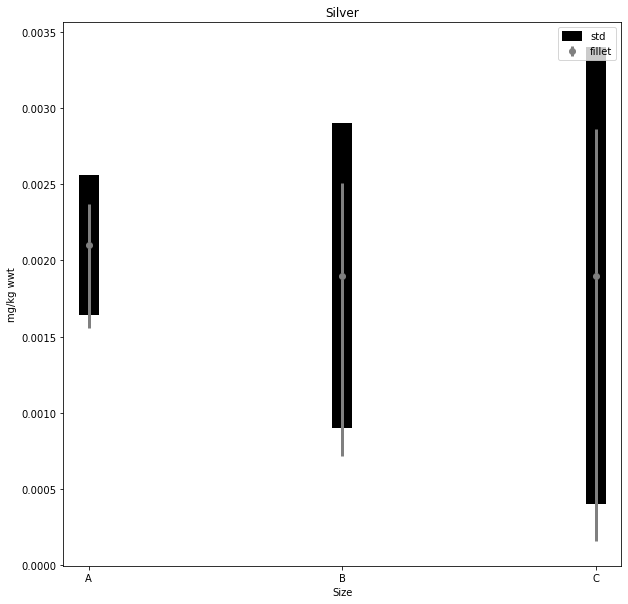

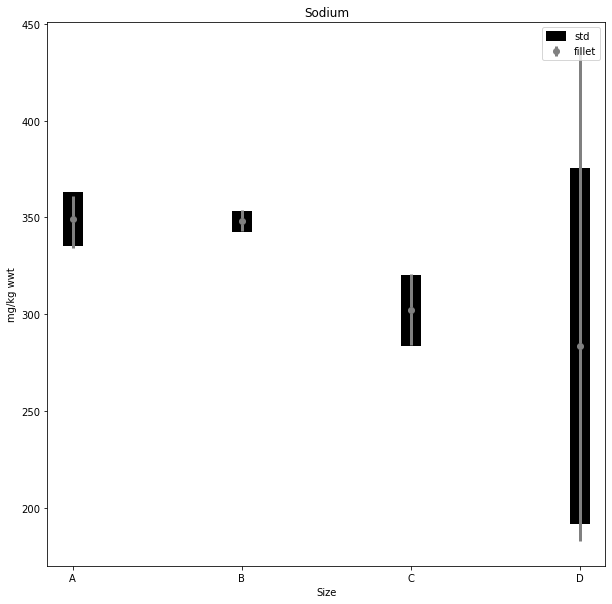

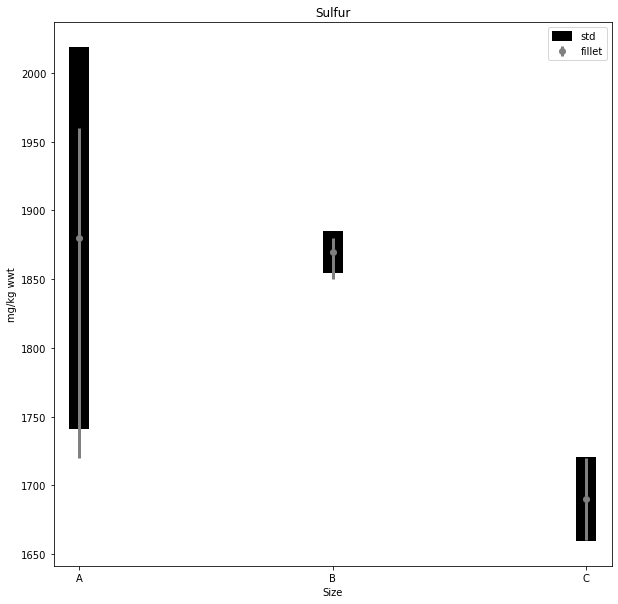

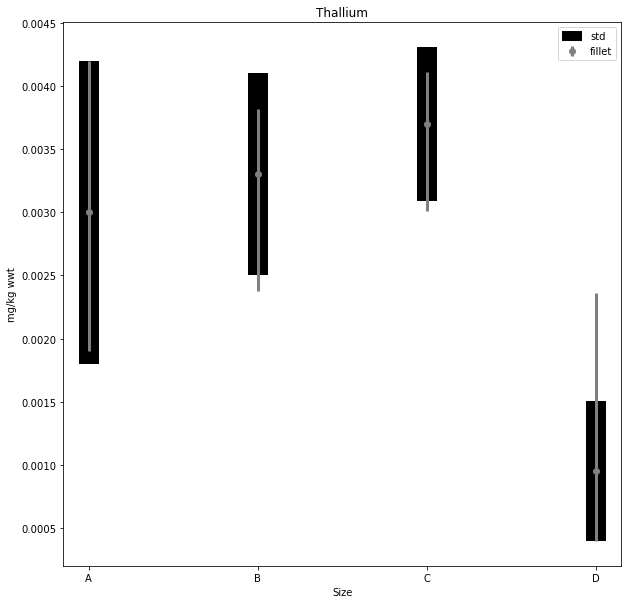

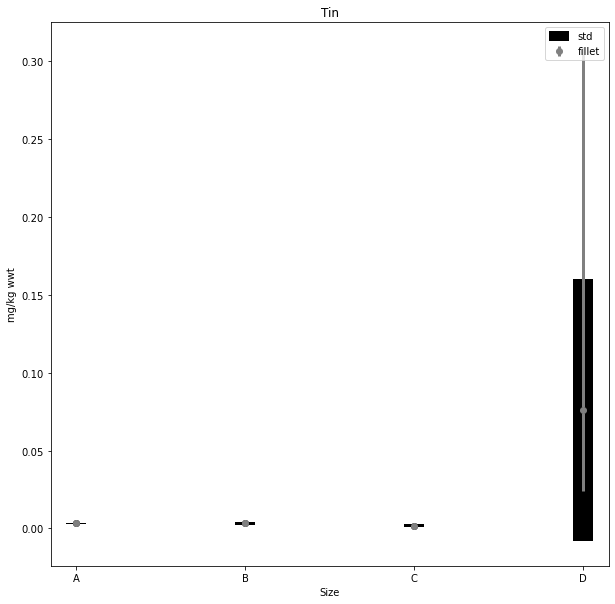

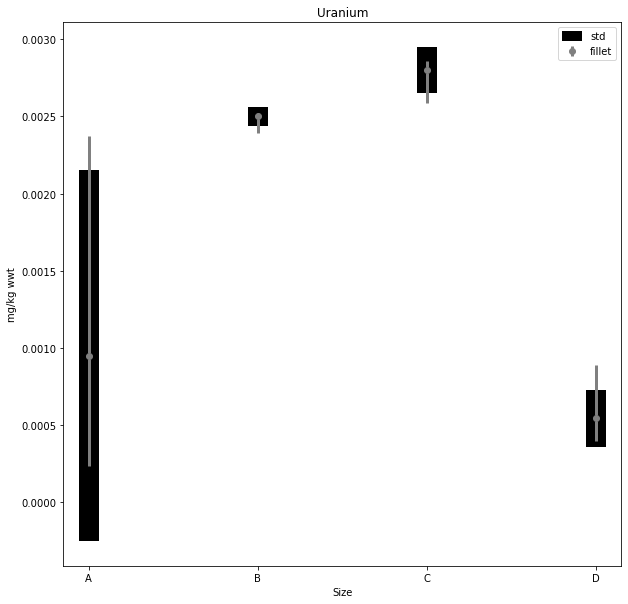

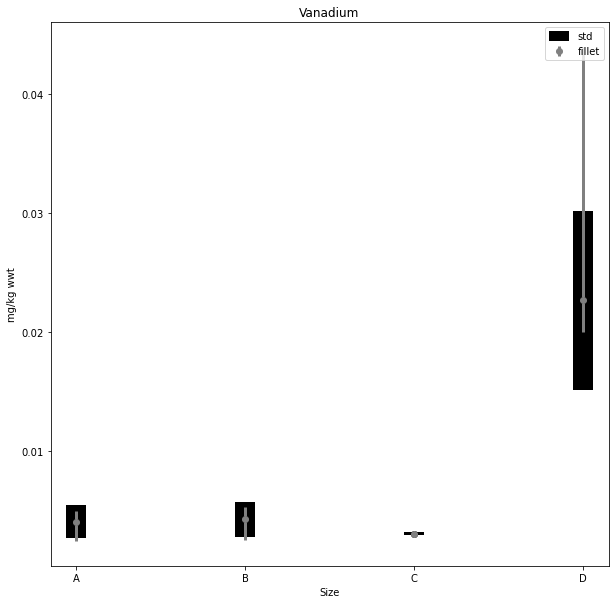

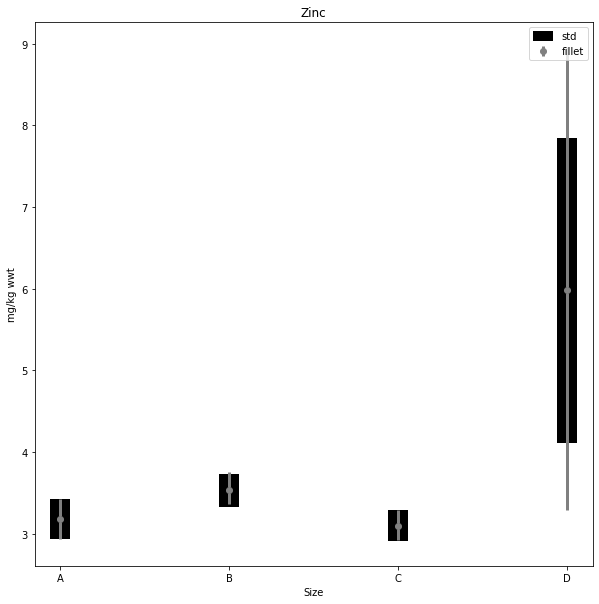

In [468]:
for element in elements:
    plt.figure(facecolor="white", figsize=(10, 10))
    plt.title(element)
    temp = hatcheri.loc[hatcheri.Analyte == element, :].drop(columns=["Analyte"])
    temp.sort_values(by="Size", inplace=True)
    x = temp.Size
    mins = temp.Min
    maxs = temp.Max
    means = temp.Mean
    sd = temp.SD
    plt.errorbar(x, means, sd, fmt='ok', lw=20, label = "std")
    plt.errorbar(x, means, [means - mins, maxs - means],
             fmt='o', color='gray', ecolor='gray', lw=3, label = "fillet")
    plt.legend()
    plt.xlabel("Size")
    plt.ylabel("mg/kg wwt")
    if not os.path.exists("./pics/Hatcheri"):
        os.mkdir("./pics/Hatcheri")
    plt.savefig(f"./pics/Hatcheri/{element}.png")
    

# waters info

In [469]:
obs = pd.read_excel("observed.xlsx")
obs["obs"] = pd.to_datetime(obs["obs"], format="%Y-%m-%d")
obs

sites   fish ID        obs
0  NECHAKO RIVER AT VANDERHOOF        4 2022-08-27
1  NECHAKO RIVER AT VANDERHOOF        5 2022-08-27
2  NECHAKO RIVER AT VANDERHOOF       10 2022-08-28

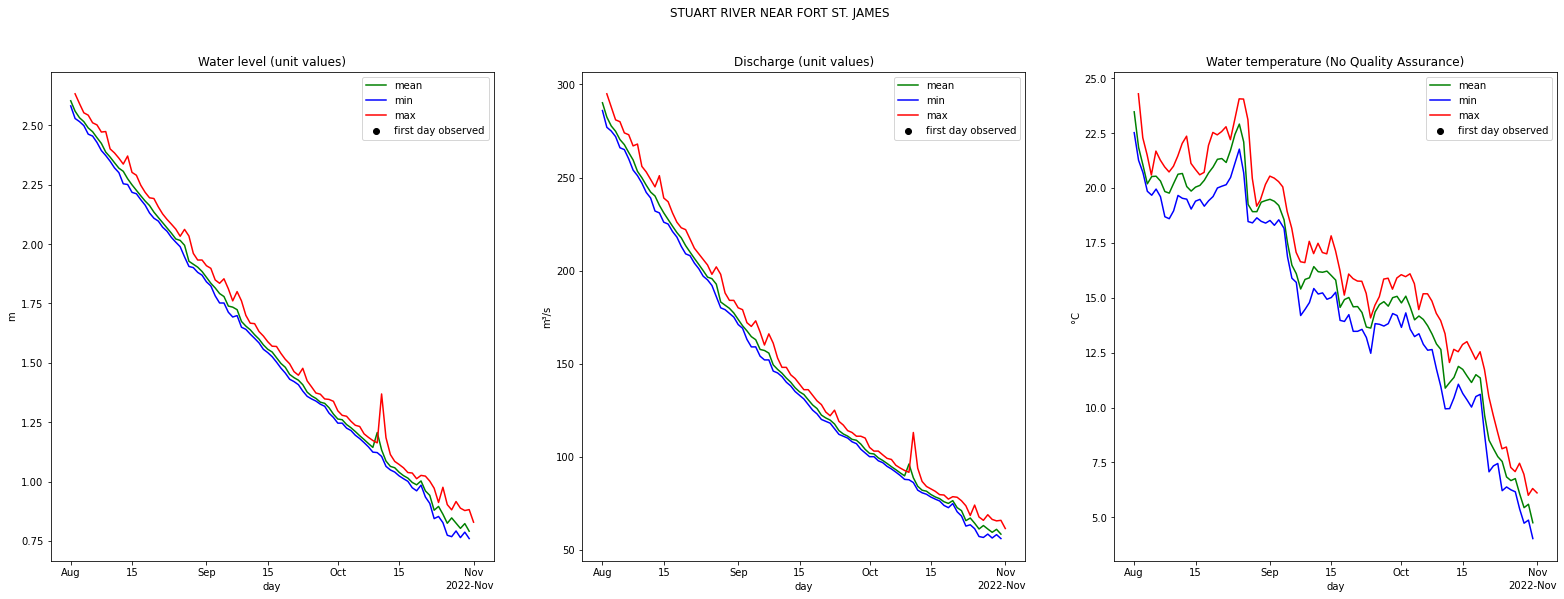

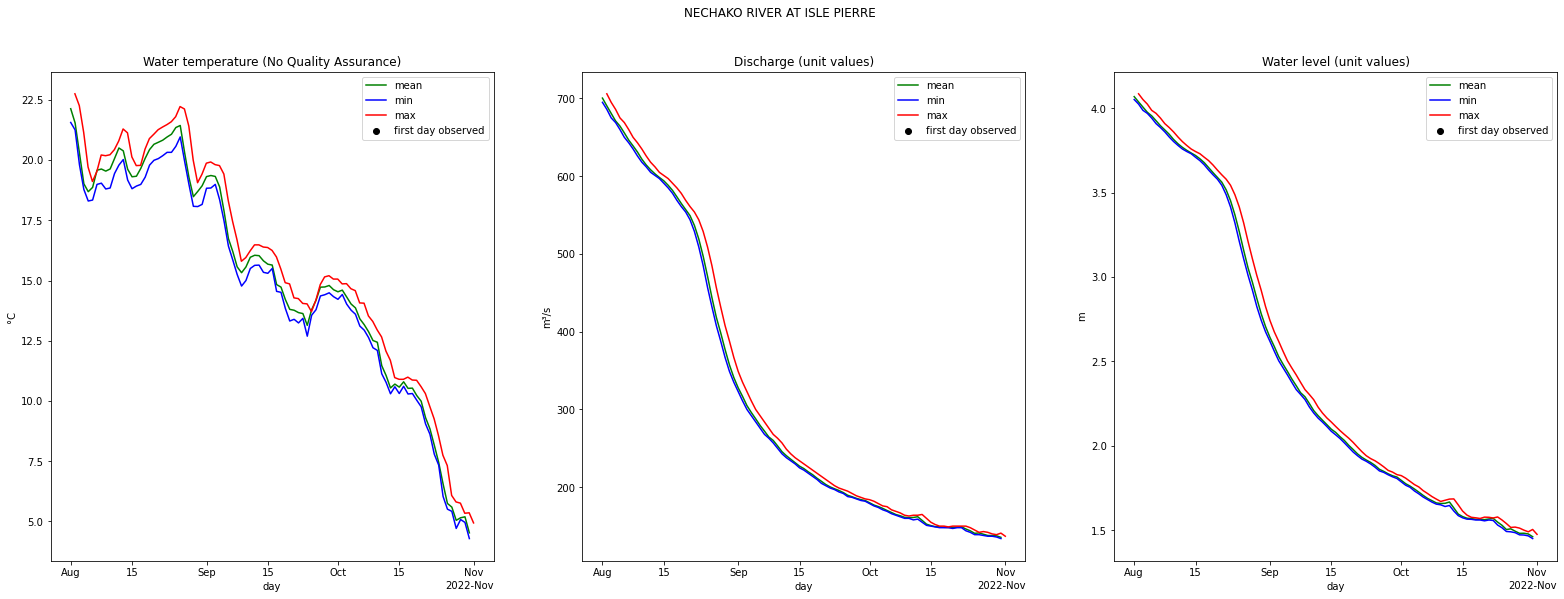

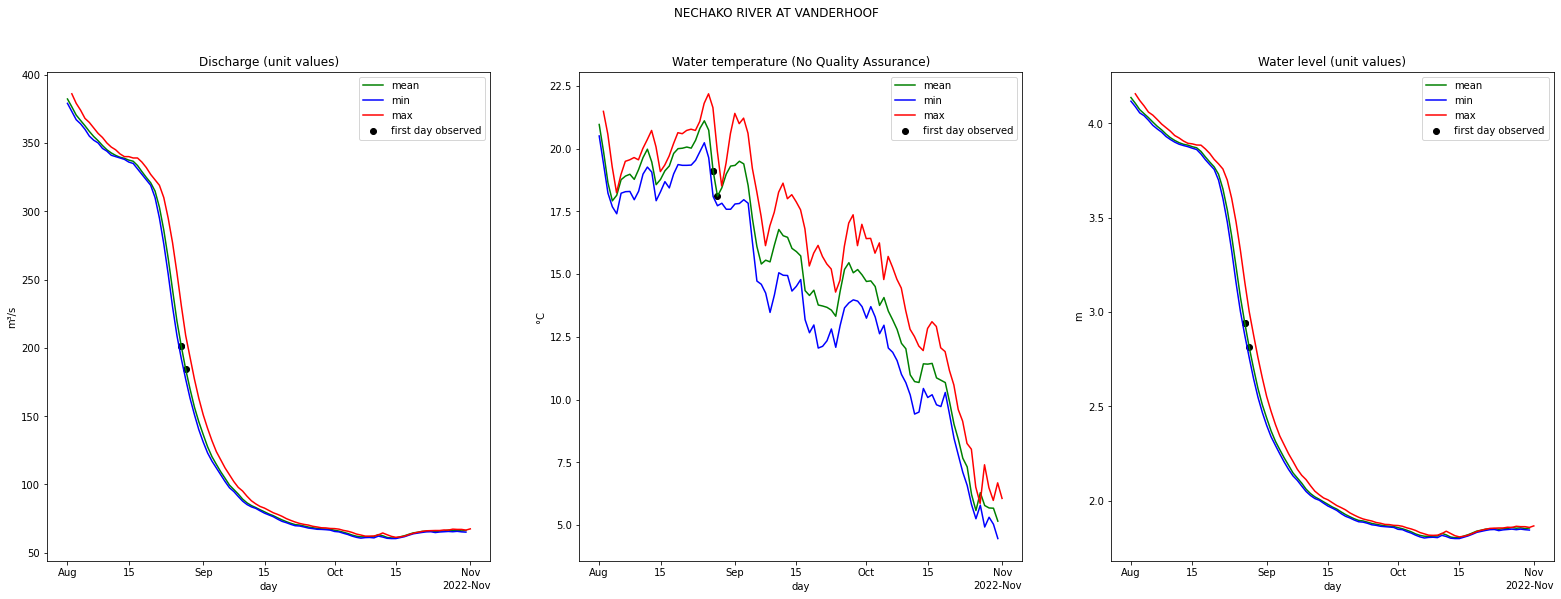

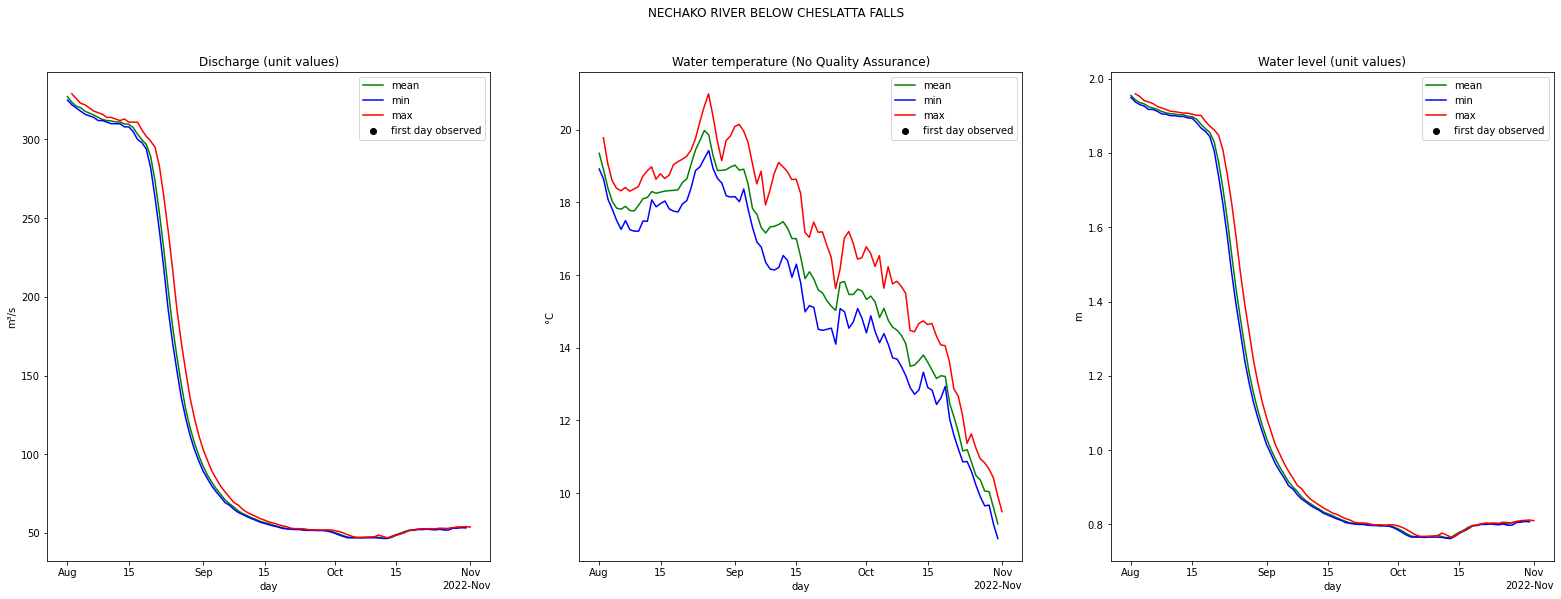

In [470]:

folders = glob("waters data/*")
for folder in folders:
    csv_files = glob(f'{folder}/*.csv')
    title = folder.split("-")[1].strip()
    plt.figure(figsize=(27, 9), facecolor="white")
    plt.suptitle(title)
    j = 0
    observed = obs.loc[obs["sites "] == title, :]
    for csv_file in csv_files:
        j += 1
        plt.subplot(1, len(csv_files), j)
        csvfile = open(csv_file, 'r')
        i = 0
        for row in csv.reader(csvfile, delimiter = ','):
            i += 1
            if i == 8:
                title, unit = row[1:]
                break
        plt.title(title)
        plt.ylabel(unit)
        plt.xlabel("day")
        csv_data = pd.read_csv(csv_file, delimiter=",", skiprows=8).iloc[:, [0, 2]]
        cols = csv_data.columns
        columns = csv_data.columns.difference([cols[0]])
        csv_data[columns] = csv_data[columns].astype(float)
        csv_data[cols[0]] = pd.to_datetime(csv_data[cols[0]], format="%Y-%m-%d %H:%M:%S")
        csv_data = csv_data.resample('d', on=cols[0])
        mean_dict = {                                                                                                             
            cols[0]: 'first',                                                                                                    
            cols[1]: 'mean',
        }
        means = csv_data.apply(mean_dict)
        mins = csv_data.min()
        maxs = csv_data.max()
        observed = observed.merge(means, "inner", right_index=True, left_on = "obs")
        plt.plot(*means.to_numpy().T, color = "green", label = "mean")
        plt.plot(*mins.to_numpy().T, color = "blue", label = "min")
        plt.plot(*maxs.to_numpy().T, color = "red", label = "max")
        plt.scatter(observed["obs"], observed[cols[1]], color = "k", label = "first day observed")
        ax = plt.gca()
        locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        plt.legend()
    plt.savefig(f"{folder}/fig.jpeg");

# PCB

In [485]:
col_names = pd.read_excel("PCB.xls", sheet_name="DATA", nrows=0).columns
col_names = np.array(col_names[~col_names.str.contains("Unnamed")][1:].repeat(3))
for i in np.arange(tag_list.shape[0]):
    col_names[col_names == tag_list[i, 1]] = tag_list[i, 0][1:]
pcb = pd.read_excel("PCB.xls", sheet_name="DATA", skiprows = 5)
pcb = pcb.loc[:int(np.where(pcb['UNITS'] == r"% Lipid")[0]), :]
suffix = ['flag', 'value', 'RL'] * int(len(col_names) / 3)
cols = [i + '_' + j for i, j in zip(col_names, suffix)]
cols.insert(0, 'Units')
pcb.columns = cols
pcb.set_index('Units', inplace=True)

blank_columns = np.where(pcb.columns.str.contains('Blank'))[0]
rl_nd = pcb.loc[pcb.iloc[:, blank_columns[0]].str.contains(r'\bND\b(?!R)', na = False).to_numpy(), pcb.columns[blank_columns[2]]].dropna()
pcb
# Unit: pg/g (wet weight basis)

1_flag  1_value   1_RL 2_flag  2_value   2_RL  \
Units                                                                      
PCB-1                         NaN     7.45  0.381    NaN    13.10  0.476   
PCB-2                         NaN     3.72  0.378    NaN     5.91  0.476   
PCB-3                         NaN     7.16  0.373    NaN    12.60  0.476   
PCB-4                         NaN     4.72  1.210    NaN    10.50  1.740   
PCB-5                          ND      NaN  0.793     ND      NaN  1.220   
...                           ...      ...    ...    ...      ...    ...   
Total Octachloro Biphenyls    NaN     8.11    NaN    NaN    28.20    NaN   
Total Nonachloro Biphenyls    NaN     2.63    NaN    NaN     5.51    NaN   
Decachloro Biphenyl           NaN     1.83    NaN     ND      NaN    NaN   
TOTAL PCBs                    NaN  1060.00    NaN    NaN  1970.00    NaN   
% Lipid                       NaN     0.34    NaN    NaN     0.81    NaN   

                           3_flag   3_value   3_RL 4_flag  ...  11_RL  \
Units                                                      ...          
PCB-1                         NaN     31.10  0.665    NaN  ...  0.484   
PCB-2                         NaN      9.99  0.678    NaN  ...  0.488   
PCB-3                         NaN     31.10  0.683    NaN  ...  0.465   
PCB-4                         NaN     36.80  2.120    NaN  ...  1.990   
PCB-5                         NaN      3.02  1.450    NaN  ...  1.390   
...                           ...       ...    ...    ...  ...    ...   
Total Octachloro Biphenyls    NaN    225.00    NaN    NaN  ...    NaN   
Total Nonachloro Biphenyls    NaN     26.70    NaN    NaN  ...    NaN   
Decachloro Biphenyl            ND       NaN    NaN    NaN  ...    NaN   
TOTAL PCBs                    NaN  10900.00    NaN    NaN  ...    NaN   
% Lipid                       NaN      2.40    NaN    NaN  ...    NaN   

                            13-Trembleur_flag 13-Trembleur_value  \
Units                                                              
PCB-1                                     NaN              22.40   
PCB-2                                     NaN              15.20   
PCB-3                                     NaN              24.90   
PCB-4                                     NaN               7.90   
PCB-5                                      ND                NaN   
...                                       ...                ...   
Total Octachloro Biphenyls                NaN              24.20   
Total Nonachloro Biphenyls                 ND                NaN   
Decachloro Biphenyl                       NaN               2.66   
TOTAL PCBs                                NaN            2080.00   
% Lipid                                   NaN               1.64   

                            13-Trembleur_RL  Lab Blank (101)_flag  \
Units                                                               
PCB-1                                  1.44                   NaN   
PCB-2                                  1.44                   NaN   
PCB-3                                  1.44                   NaN   
PCB-4                                  5.63                   NaN   
PCB-5                                  4.04                    ND   
...                                     ...                   ...   
Total Octachloro Biphenyls              NaN                    ND   
Total Nonachloro Biphenyls              NaN                    ND   
Decachloro Biphenyl                     NaN                    ND   
TOTAL PCBs                              NaN                   NaN   
% Lipid                                 NaN                   NaN   

                           Lab Blank (101)_value  Lab Blank (101)_RL  \
Units                                                                  
PCB-1                                       2.33               0.293   
PCB-2                                       1.67               0.293   
PCB-3            

### Blank correction

In [486]:
pcb_corrected = pcb.copy().iloc[:, 1:-2:3]
pcb_corrected.columns = pcb_corrected.columns.str.removesuffix('_value')
pcb_corrected.loc[rl_nd.index, pcb_corrected.columns[-1]] = rl_nd.to_numpy() / np.sqrt(2)
id = pcb_corrected.iloc[:-1, -1].dropna().index
pcb_corrected.loc[id, pcb_corrected.columns[:-1]] -= pcb_corrected.loc[id, pcb_corrected.columns[-1]].to_numpy()[:, np.newaxis]
pcb_corrected = pcb_corrected.iloc[:, :-1]
print(f'count of samples corrected to negative: {np.sum((~(pcb_corrected.isna() | (pcb_corrected > 0)).to_numpy()))}')
print(f'position of corrected samples: {np.where((~(pcb_corrected.isna() | (pcb_corrected > 0))).to_numpy())}')
pcb_corrected.iloc[np.where((~(pcb_corrected.isna() | (pcb_corrected > 0))).to_numpy())] = 0


count of samples corrected to negative: 1
position of corrected samples: (array([40]), array([6]))


### Lipid Normalization

In [474]:
lipid_normalized = pcb_corrected.copy()
lipid_normalized.iloc[-1, :] /= 100
lipid_normalized.iloc[:-1, :] /= lipid_normalized.iloc[-1, :]
lipid_normalized.index = list(lipid_normalized.index[:-1])+['Lipid']

In [475]:
if not os.path.exists("./generated excels/"):
    os.mkdir("./generated excels/")
with pd.ExcelWriter('./generated excels/pcb.xlsx') as writer:
    pcb_corrected.to_excel(writer, sheet_name="blank_corrected")
    lipid_normalized.to_excel(writer, sheet_name="lipid_normalized")

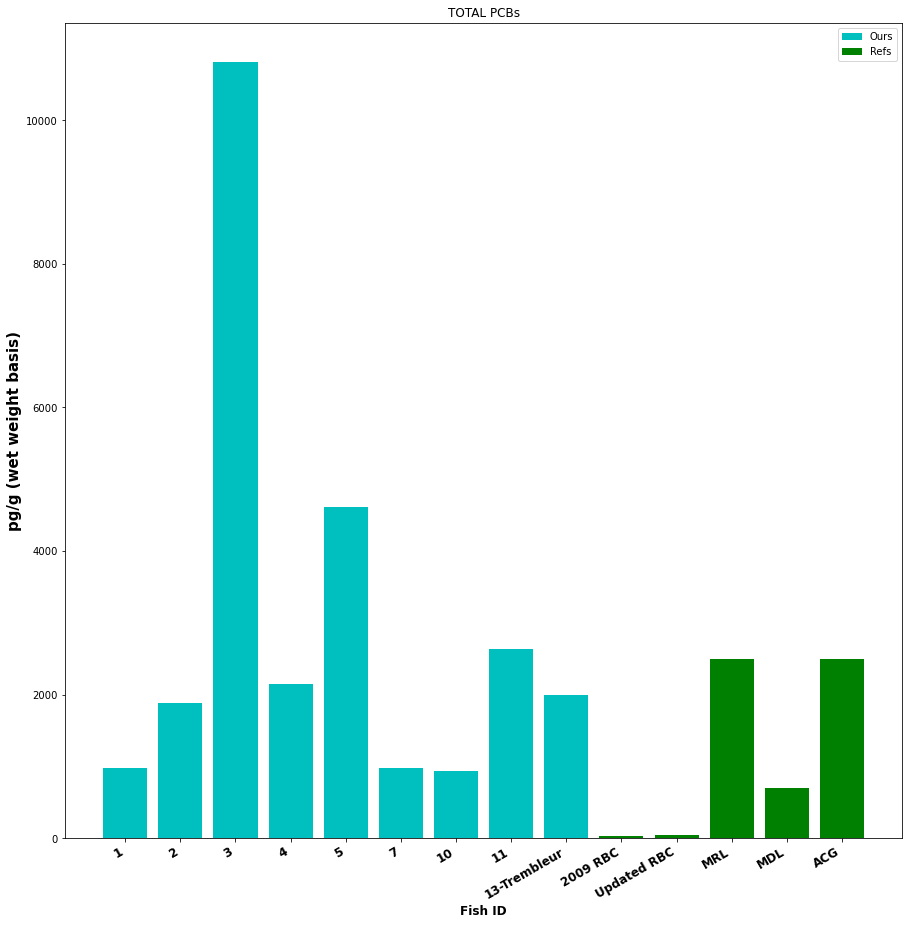

In [488]:
total_pcbs = pcb_corrected.loc['TOTAL PCBs', :].dropna()
refs = pd.DataFrame(np.array([0.036, 0.0424, 2.5, .7, 2.5]) * 1e3, index = ["2009 RBC", 'Updated RBC', 'MRL', 'MDL', 'ACG'])
n = total_pcbs.shape[0] + refs.shape[0]
fig, ax = plt.subplots(figsize=(15, 15), facecolor = "white")
ax.bar(total_pcbs.index, total_pcbs.to_numpy(), color = 'c', label = "Ours")
ax.bar(refs.index, refs.loc[:, 0].to_numpy(), color = 'g', label = 'Refs')
ax.xaxis.set_ticks(np.arange(n))
ax.xaxis.set_ticklabels(list(total_pcbs.index.str.removesuffix("_value")) + list(refs.index), rotation = 30, ha = 'right', fontsize = 12, fontweight = 'bold');
ax.set_title("TOTAL PCBs")
ax.set_ylabel("pg/g (wet weight basis)", fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Fish ID", fontsize = 12, fontweight = 'bold')
plt.legend();
if not os.path.exists("./pics/PCBs"):
    os.mkdir("./pics/PCBs")
plt.savefig("./pics/PCBs/Total_PCBs.png")

### Pie Chart

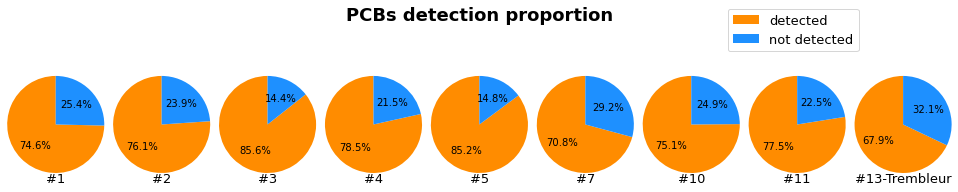

In [477]:
fig, ax = plt.subplots(1, pcb_corrected.shape[1], figsize = (13.39, 3))
fig.set_facecolor("white")
fig.suptitle("PCBs detection proportion", fontsize = 18, fontweight = "bold")
for i, col in enumerate(pcb_corrected.columns):
    broken = pcb_corrected.index[pcb_corrected.loc[:, col].isna() & pcb_corrected.index.str.contains("PCB-")]
    count = broken.to_series().apply(lambda x : x.count('+')).to_numpy().sum() + broken.size
    ax[i].pie([209-count, count], labels = ["", ""], autopct='%1.1f%%', startangle=90, radius = 1.4, colors = ['darkorange', 'dodgerblue'])
    ax[i].set_xlabel(f'#{col}', fontsize = 13)
fig.legend(["detected", "not detected"], loc = 'upper right', bbox_to_anchor=(.9, 1), fontsize = 13);
plt.tight_layout()

## WG85756_DX_1

In [478]:
col_names = pd.read_excel("WG85756_DX_1.xls", sheet_name="DATA", nrows=0).columns
col_names = np.array(col_names[~col_names.str.contains("Unnamed")][1:].repeat(3))
for i in np.arange(tag_list.shape[0]):
    col_names[col_names == tag_list[i, 1]] = tag_list[i, 0][1:]
DX = pd.read_excel("WG85756_DX_1.xls", sheet_name="DATA", skiprows = 5)
DX = DX.loc[:int(np.where(DX['UNITS'] == r"% Lipid")[0]), :]
suffix = ['flag', 'value', 'RL'] * int(len(col_names) / 3)
cols = [i + '_' + j for i, j in zip(col_names, suffix)]
cols.insert(0, 'Units')
DX.columns = cols
DX.set_index('Units', inplace=True)

blank_columns = np.where(DX.columns.str.contains('Blank'))[0]
rl_nd = DX.loc[DX.iloc[:, blank_columns[0]].str.contains(r'\bND\b(?!R)', na = False).to_numpy(), DX.columns[blank_columns[2]]].dropna()
DX
# Unit: pg/g (wet weight basis)

1_flag  1_value   1_RL 2_flag  2_value   2_RL 3_flag  \
Units                                                                           
2,3,7,8-TCDD                 ND      NaN  0.246     ND      NaN  0.476   ND G   
1,2,3,7,8-PECDD              ND      NaN  0.246     ND      NaN  0.476   ND G   
1,2,3,4,7,8-HXCDD            ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,6,7,8-HXCDD            ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,7,8,9-HXCDD (225)     NaN      NaN    NaN    NaN      NaN    NaN    NaN   
1,2,3,7,8,9-HXCDD            ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,4,6,7,8-HPCDD         NaN    0.286  0.246    NaN    0.495  0.476     ND   
OCDD                        NDR    0.823  0.327    NaN    2.100  0.476    NaN   
2,3,7,8-TCDF (225)          NaN    0.266  0.246    NaN      NaN    NaN    NaN   
2,3,7,8-TCDF                NaN    0.350  0.246     ND      NaN  0.476     ND   
1,2,3,7,8-PECDF              ND      NaN  0.246     ND      NaN  0.476     ND   
2,3,4,7,8-PECDF              ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,4,7,8-HXCDF            ND      NaN  0.246     ND      NaN  0.476   ND G   
1,2,3,6,7,8-HXCDF            ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,7,8,9-HXCDF            ND      NaN  0.246     ND      NaN  0.476   ND G   
2,3,4,6,7,8-HXCDF            ND      NaN  0.246     ND      NaN  0.476     ND   
1,2,3,4,6,7,8-HPCDF         NDR    0.481  0.246    NDR    0.714  0.476   ND G   
1,2,3,4,7,8,9-HPCDF          ND      NaN  0.246     ND      NaN  0.476     ND   
OCDF                        NDR    0.396  0.246     ND      NaN  0.476     ND   
TOTAL TETRA-DIOXINS          ND      NaN  0.246     ND      NaN  0.476     ND   
TOTAL PENTA-DIOXINS          ND      NaN  0.246     ND      NaN  0.476     ND   
TOTAL HEXA-DIOXINS           ND      NaN  0.246     ND      NaN  0.476     ND   
TOTAL HEPTA-DIOXINS         NaN    0.286  0.246    NaN    0.495  0.476     ND   
TOTAL TETRA-FURANS          NaN    0.350  0.246     ND      NaN  0.476     ND   
TOTAL PENTA-FURANS           ND      NaN  0.246     ND      NaN  0.476     ND   
TOTAL HEXA-FURANS            ND      NaN  0.246     ND      NaN  0.476     ND   
TOTAL HEPTA-FURANS           ND      NaN  0.246     ND      NaN  0.476     ND   
% Lipid                     NaN    0.340    NaN    NaN    0.810    NaN    NaN   

                          3_value   3_RL 4_flag  ...  11_RL  \
Units                                            ...          
2,3,7,8-TCDD                  NaN  0.492     ND  ...  0.423   
1,2,3,7,8-PECDD               NaN  0.492    MAX  ...  0.423   
1,2,3,4,7,8-HXCDD             NaN  0.492    MAX  ...  0.423   
1,2,3,6,7,8-HXCDD             NaN  0.492    NDR  ...  0.423   
1,2,3,7,8,9-HXCDD (225)       NaN    NaN     ND  ...    NaN   
1,2,3,7,8,9-HXCDD             NaN  0.492    NDR  ...  0.423   
1,2,3,4,6,7,8-HPCDD           NaN  0.492    MAX  ...  0.423   
OCDD                        0.798  0.492    MAX  ...  0.423   
2,3,7,8-TCDF (225)            NaN    NaN    NaN  ...    NaN   
2,3,7,8-TCDF                  NaN  0.492     ND  ...  0.423   
1,2,3,7,8-PECDF               NaN  0.492    NDR  ...  0.423   
2,3,4,7,8-PECDF               NaN  0.492    NDR  ...  0.423   
1,2,3,4,7,8-HXCDF             NaN  0.492    MAX  ...  0.423   
1,2,3,6,7,8-HXCDF             NaN  0.492     ND  ...  0.423   
1,2,3,7,8,9-HXCDF             NaN  0.492    NDR  ...  0.423   
2,3,4,6,7,8-HXCDF             NaN  0.492    MAX  ...  0.423   
1,2,3,4,6,7,8-HPCDF           NaN  0.492    MAX  ...  0.423   
1,2,3,4,7,8,9-HPCDF           NaN  0.492    MAX  ...  0.423   
OCDF                          NaN  0.492    MAX  ...  0.423   
TOTAL TETRA-DIOXINS           NaN  0.492     ND  ...  0.423   
TOTAL PENTA-DIOXINS           NaN  0.492    MAX  ...  0.423   
TOTAL HEXA-DIOXINS            NaN  0.492    MAX  ...  0.423   
TOTAL HEPTA-DIOXINS           NaN  0.492    MAX  ...  0.423   
TOTAL TETRA-FURANS 

### Blank correction

In [480]:
DX_corrected = DX.copy().iloc[:, 1:-2:3]
DX_corrected.columns = DX_corrected.columns.str.removesuffix('_value')
DX_corrected.loc[rl_nd.index, DX_corrected.columns[-1]] = rl_nd.to_numpy() / np.sqrt(2)
id = DX_corrected.iloc[:-1, -1].dropna().index
DX_corrected.loc[id, DX_corrected.columns[:-1]] -= DX_corrected.loc[id, DX_corrected.columns[-1]].to_numpy()[:, np.newaxis]
DX_corrected = DX_corrected.iloc[:, :-1]
print(f'count of samples corrected to negative: {np.sum((~(DX_corrected.isna() | (DX_corrected > 0)).to_numpy()))}')
print(f'position of corrected samples: {np.where((~(DX_corrected.isna() | (DX_corrected > 0))).to_numpy())}')
DX_corrected.iloc[np.where((~(DX_corrected.isna() | (DX_corrected > 0))).to_numpy())] = 0


count of samples corrected to negative: 6
position of corrected samples: (array([ 7,  7, 18, 18, 18, 18]), array([0, 2, 0, 4, 6, 7]))


### Lipid normalization

In [481]:
lipid_normalized_dx = DX_corrected.copy()
lipid_normalized_dx.iloc[-1, :] /= 100
lipid_normalized_dx.iloc[:-1, :] /= lipid_normalized_dx.iloc[-1, :]
lipid_normalized_dx.index = list(lipid_normalized_dx.index[:-1])+['Lipid']


In [482]:
if not os.path.exists("./generated excels/"):
    os.mkdir("./generated excels/")
with pd.ExcelWriter('./generated excels/DX.xlsx') as writer:
    DX_corrected.to_excel(writer, sheet_name="blank_corrected")
    lipid_normalized_dx.to_excel(writer, sheet_name="lipid_normalized")

# DX graphs

In [190]:
DX_corrected = pd.read_excel("./generated excels/DX.xlsx", sheet_name = "blank_corrected")
dx = DX_corrected.T
dx.columns = dx.iloc[0, :]
dx = dx.iloc[1:, :-10]

In [191]:
dx.head()

Units 2,3,7,8-TCDD 1,2,3,7,8-PECDD 1,2,3,4,7,8-HXCDD 1,2,3,6,7,8-HXCDD  \
1              NaN             NaN               NaN               NaN   
2              NaN             NaN               NaN               NaN   
3              NaN             NaN               NaN               NaN   
4              NaN        1.184228          1.014228          0.615228   
5              NaN             NaN               NaN               NaN   

Units 1,2,3,7,8,9-HXCDD (225)  1,2,3,7,8,9-HXCDD 1,2,3,4,6,7,8-HPCDD  OCDD  \
1                          NaN               NaN            0.010228   0.0   
2                          NaN               NaN            0.219228  0.66   
3                          NaN               NaN                 NaN   0.0   
4                          NaN          1.924228            2.254228  6.37   
5                          NaN               NaN            0.394228   0.0   

Units 2,3,7,8-TCDF (225)  2,3,7,8-TCDF 1,2,3,7,8-PECDF 2,3,4,7,8-PECDF  \
1                   0.266     0.074228             NaN             NaN   
2                     NaN          NaN             NaN             NaN   
3                     NaN          NaN             NaN             NaN   
4                     NaN          NaN        0.626228        0.369228   
5                     NaN          NaN             NaN             NaN   

Units 1,2,3,4,7,8-HXCDF 1,2,3,6,7,8-HXCDF 1,2,3,7,8,9-HXCDF 2,3,4,6,7,8-HXCDF  \
1                   NaN               NaN               NaN               NaN   
2                   NaN               NaN               NaN               NaN   
3                   NaN               NaN               NaN               NaN   
4              1.224228               NaN          2.294228          1.354228   
5                   NaN               NaN               NaN               NaN   

Units 1,2,3,4,6,7,8-HPCDF 1,2,3,4,7,8,9-HPCDF  
1                0.205228                 NaN  
2                0.438228                 NaN  
3                     NaN                 NaN  
4                1.874228            2.344228  
5                     NaN                 NaN

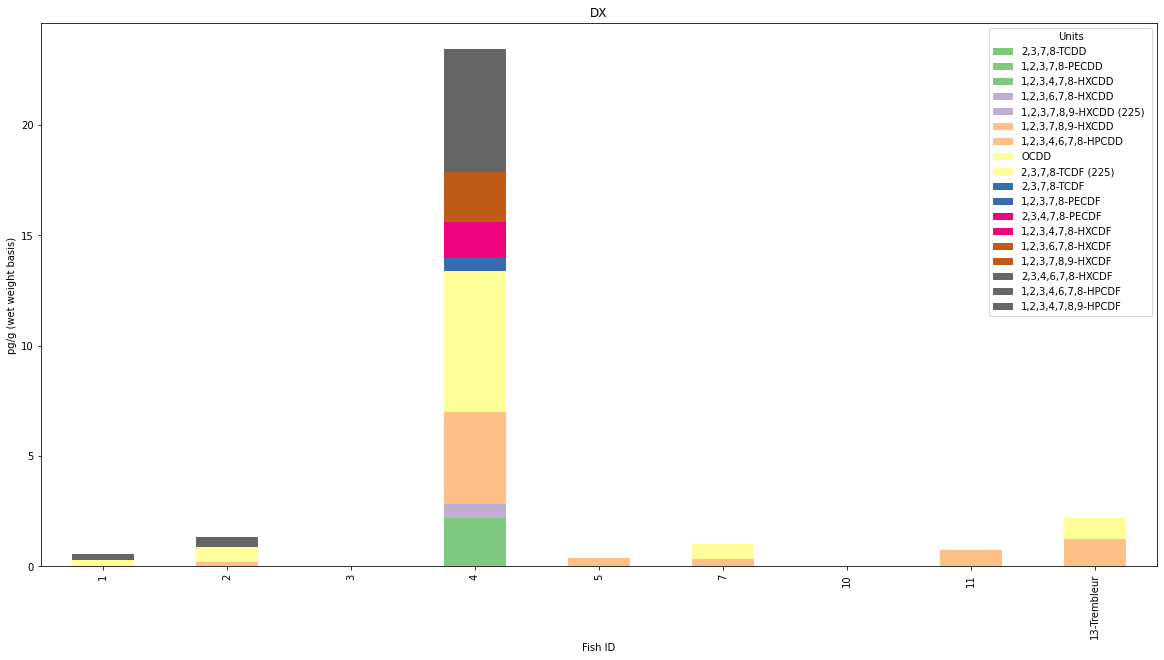

In [192]:
dx.reset_index().plot(x = 'index', kind = 'bar', stacked = True, title = 'DX',
        ylabel = 'pg/g (wet weight basis)', xlabel = 'Fish ID', figsize=(20, 10), colormap= plt.colormaps["Accent"]);
if not os.path.exists("./pics/DX"):
        os.mkdir("./pics/DX")
plt.savefig(f"./pics/DX/stacked_DX.png")

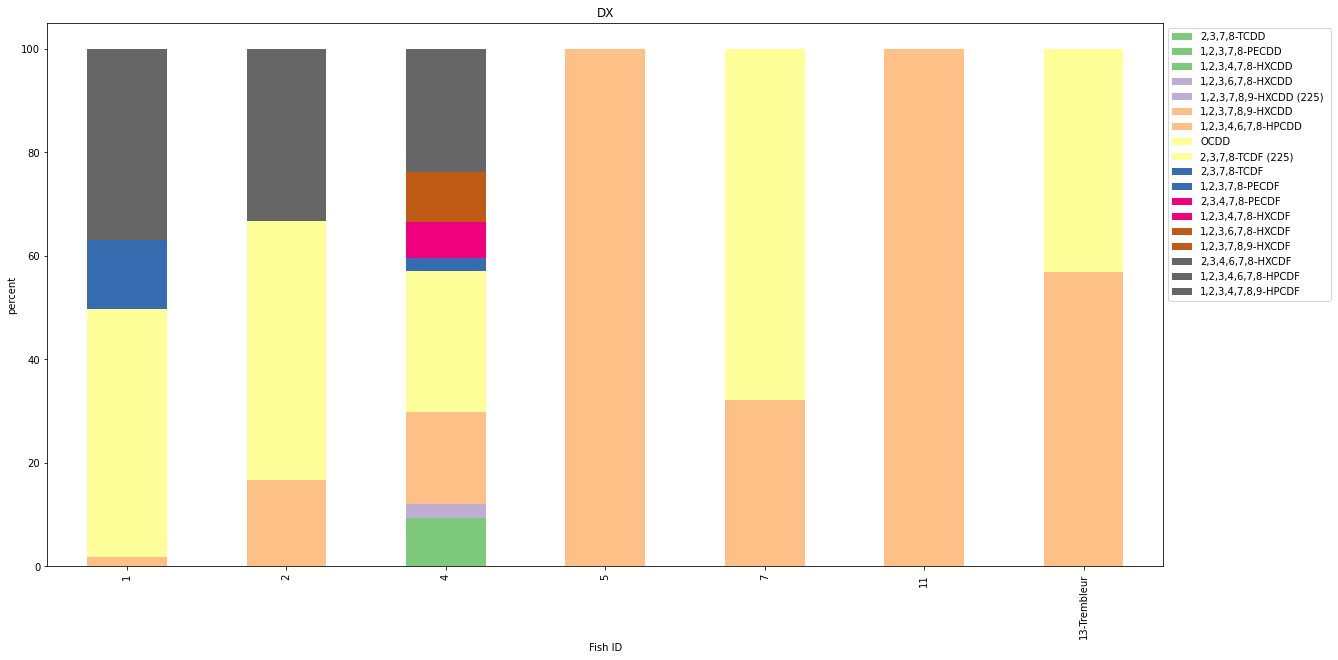

In [193]:
(dx.T / (dx.sum(1) + 1e-20)*100).loc[:, dx.sum(1) != 0].T.reset_index().plot(x = 'index', kind = 'bar', stacked = True, title = 'DX', ylabel = 'percent', xlabel = 'Fish ID', figsize=(20, 10), colormap= plt.colormaps["Accent"])
plt.legend(bbox_to_anchor=(1.0, 1.0));
if not os.path.exists("./pics/DX"):
        os.mkdir("./pics/DX")
plt.savefig(f"./pics/DX/stacked_percent_DX.png")

# PCB graphs

In [199]:
pcb_corrected = pd.read_excel("./generated excels/pcb.xlsx", sheet_name="blank_corrected")

In [200]:
pcb_corrected = pcb_corrected.iloc[:-12, :]
pcb_corrected.set_index('Units', inplace=True)

In [238]:
import math as m

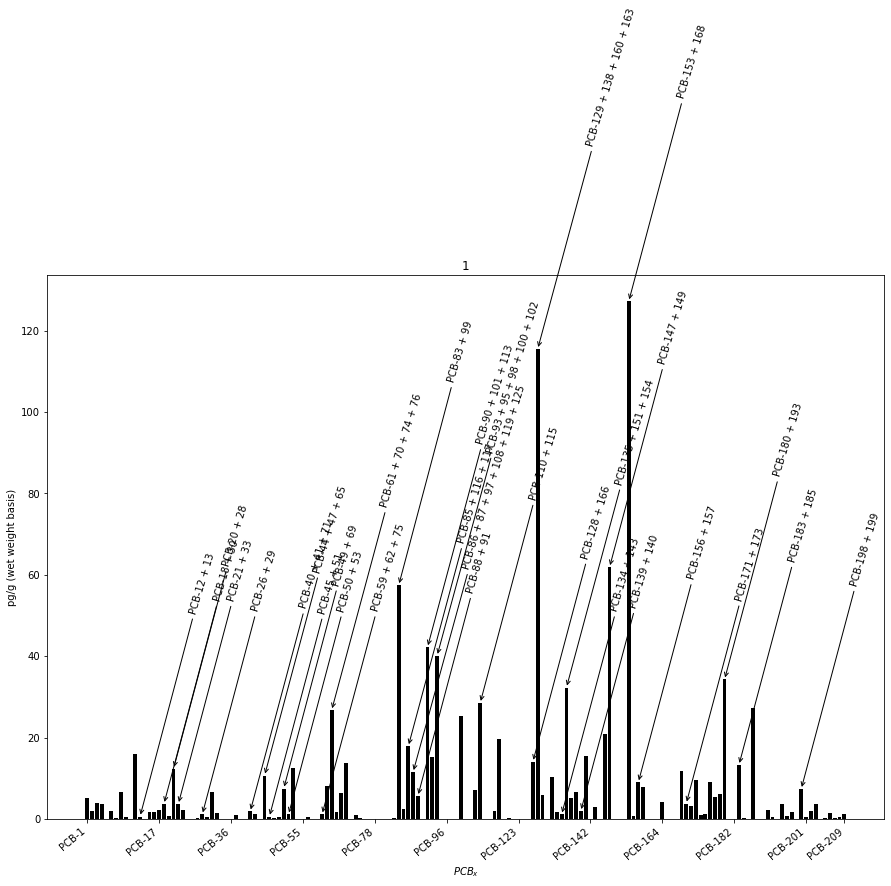

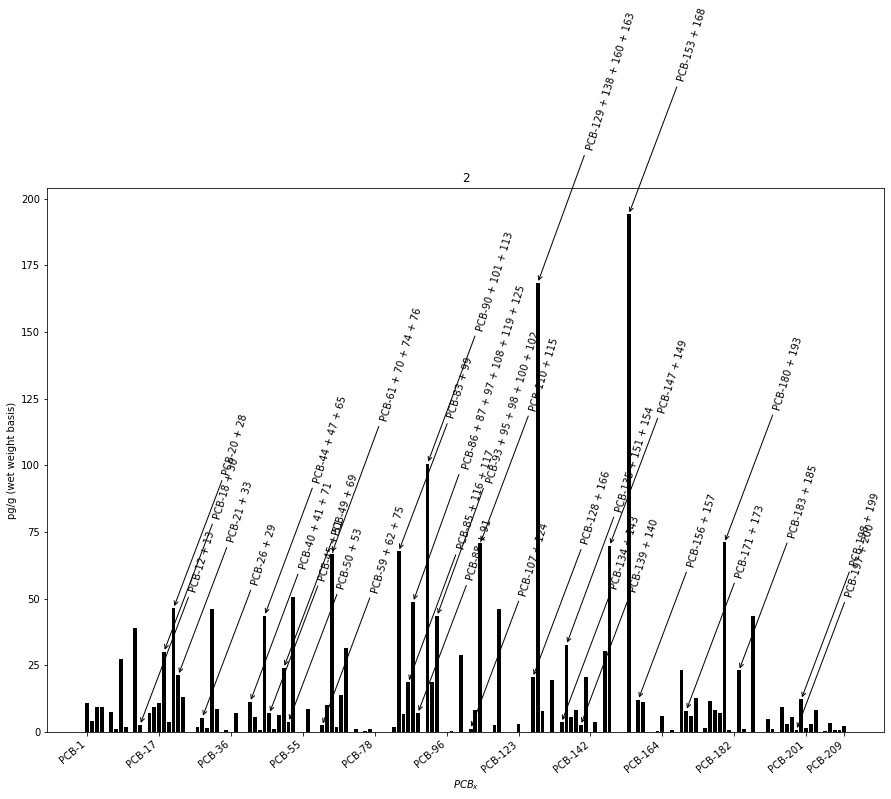

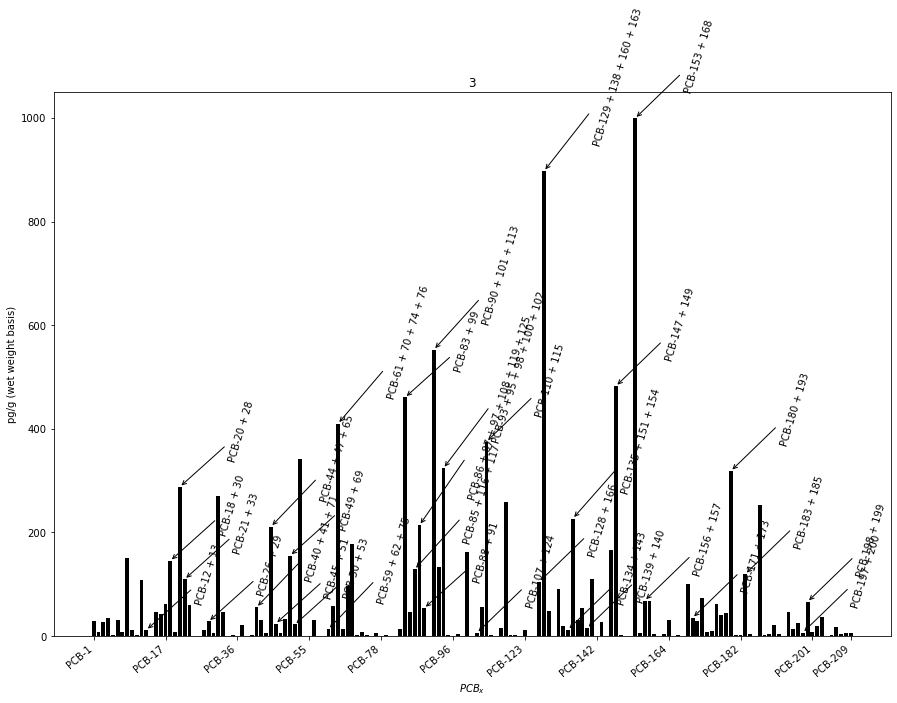

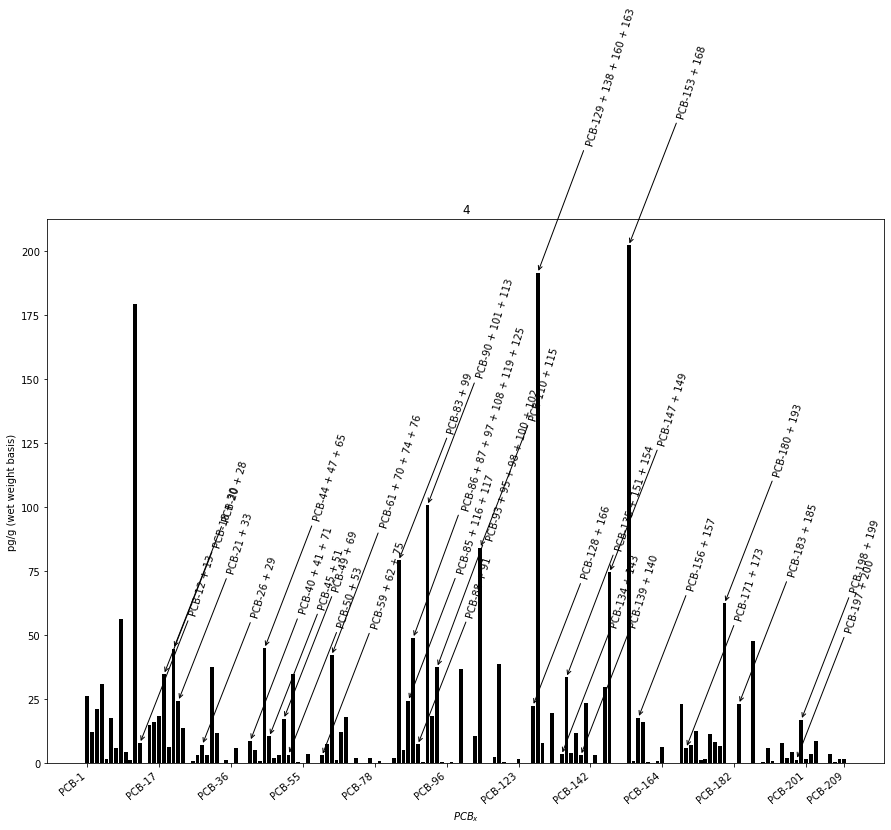

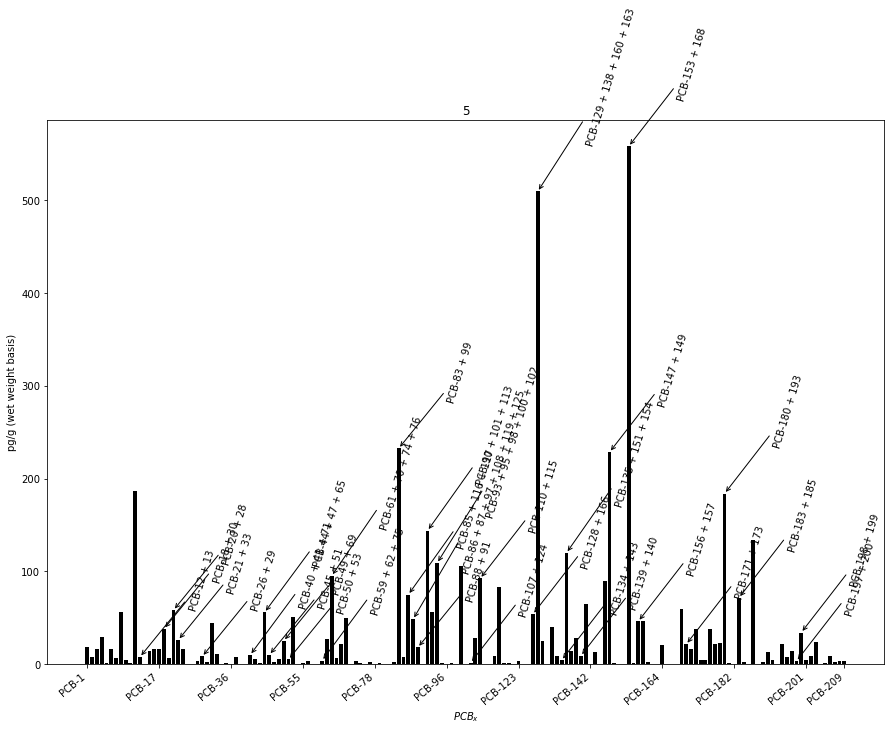

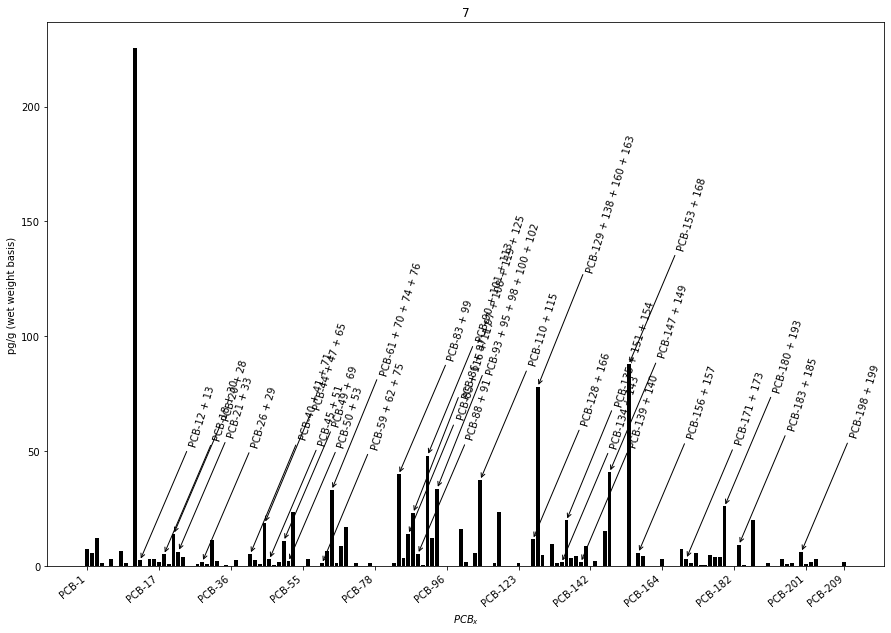

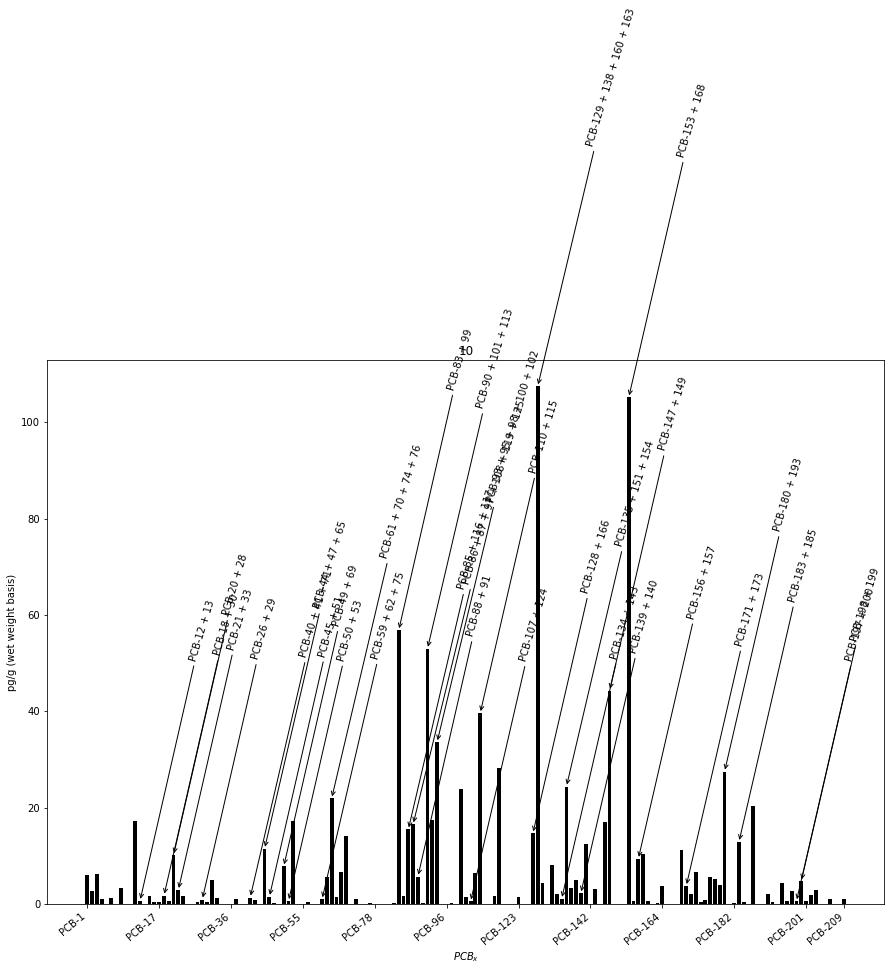

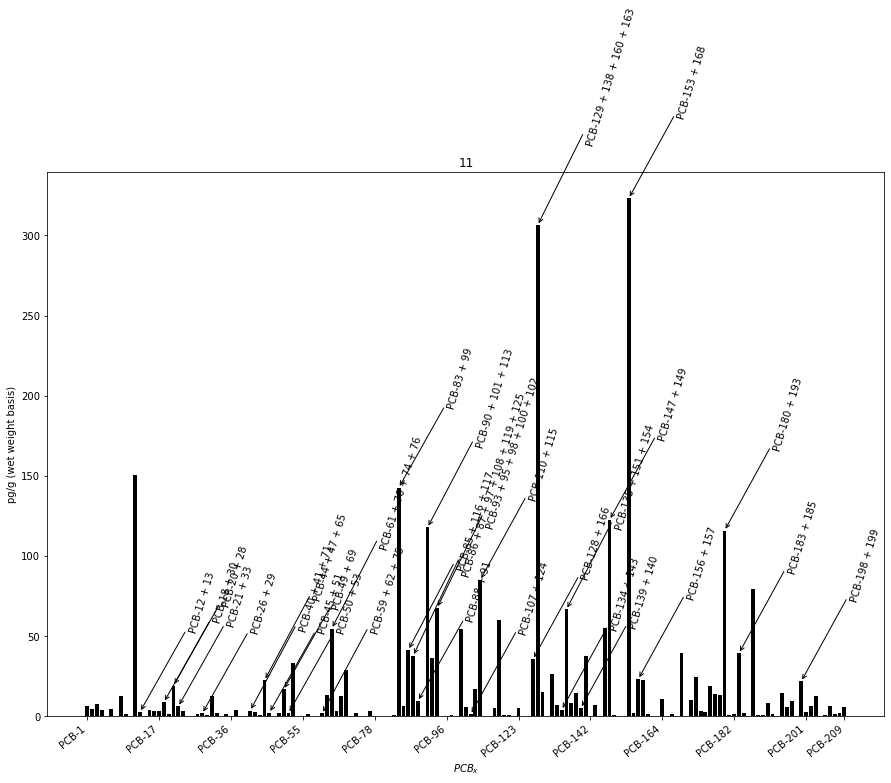

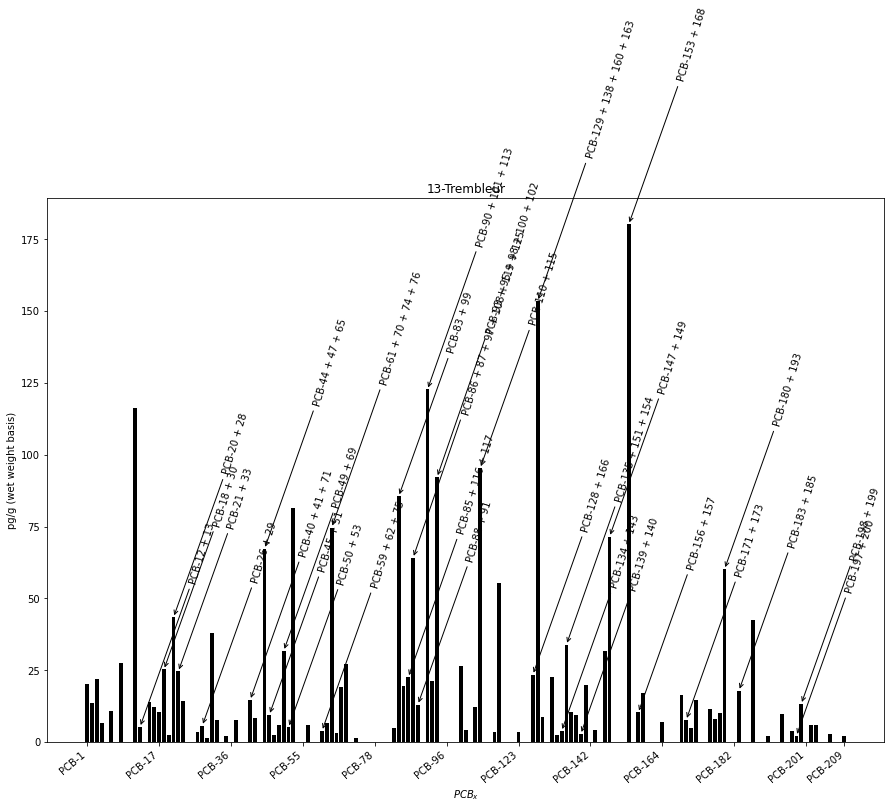

In [243]:
xtick_labels = []
xticks = list(range(0, pcb_corrected.shape[0], 15)) + [pcb_corrected.shape[0]-1]
for i in xticks:
    xtick_labels.append(pcb_corrected.index[i])
for col in pcb_corrected:
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title(col)
    ax.bar(pcb_corrected.index, pcb_corrected[col], color = 'k')
    ax.xaxis.set_ticks(xticks)
    ax.xaxis.set_ticklabels(xtick_labels, rotation = 40, ha = "right")
    ax.set_ylabel("pg/g (wet weight basis)")
    ax.set_xlabel("$PCB_x$")
    for iter, i in enumerate(pcb.index):
        if '+' in i:
            ax.annotate(i,
            xy=(iter, pcb.loc[i, col]), xycoords='data',
            xytext=(iter+10, pcb.loc[i, col]+50), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), rotation = 73)


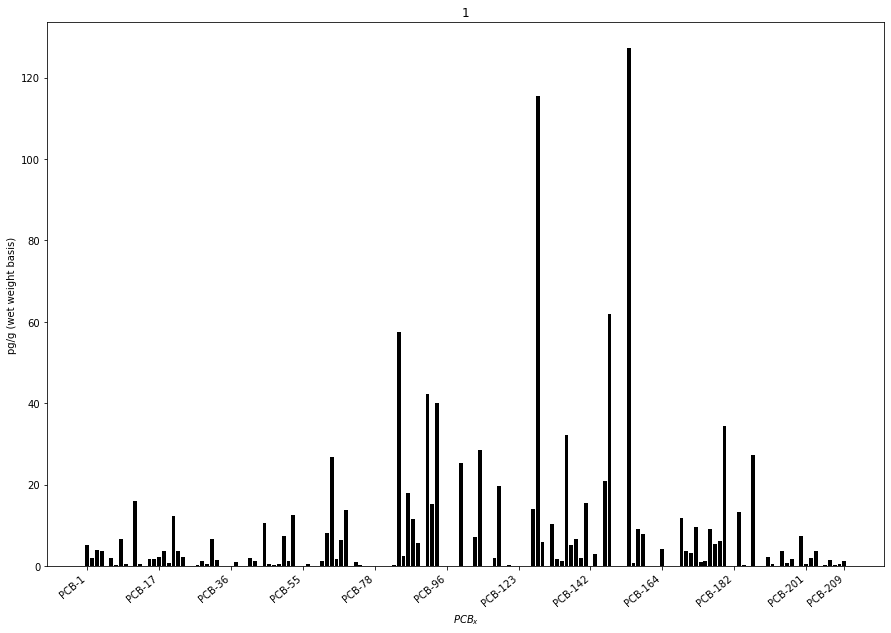

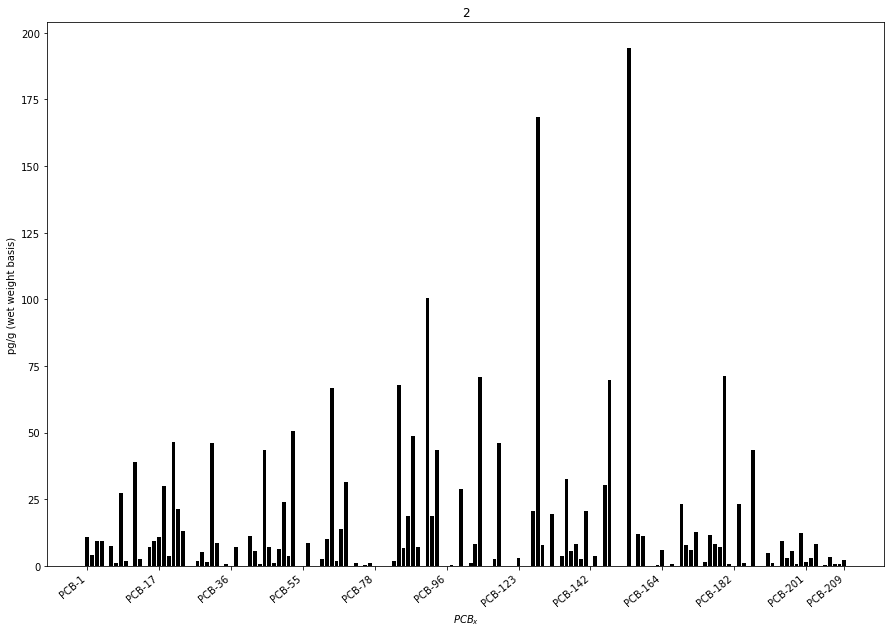

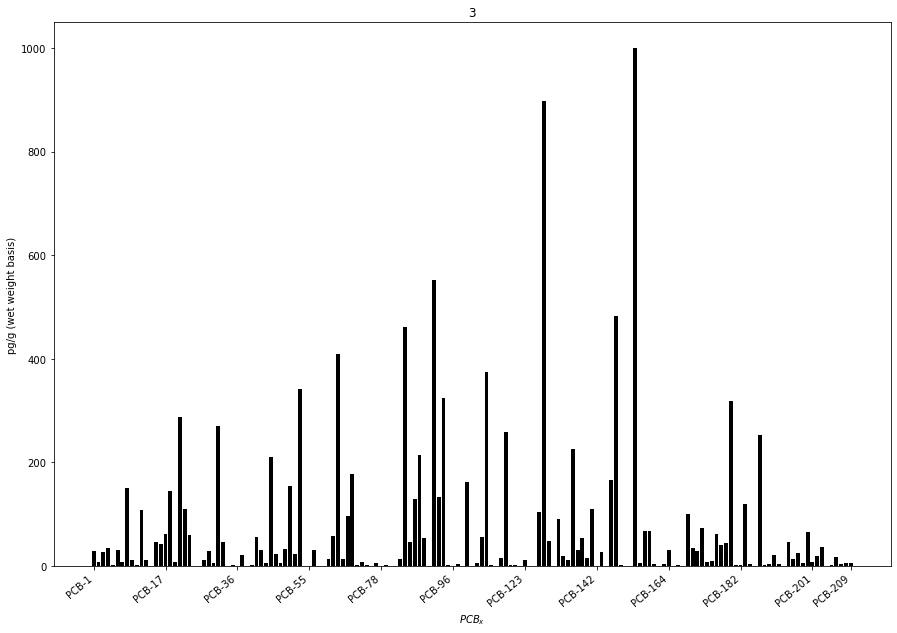

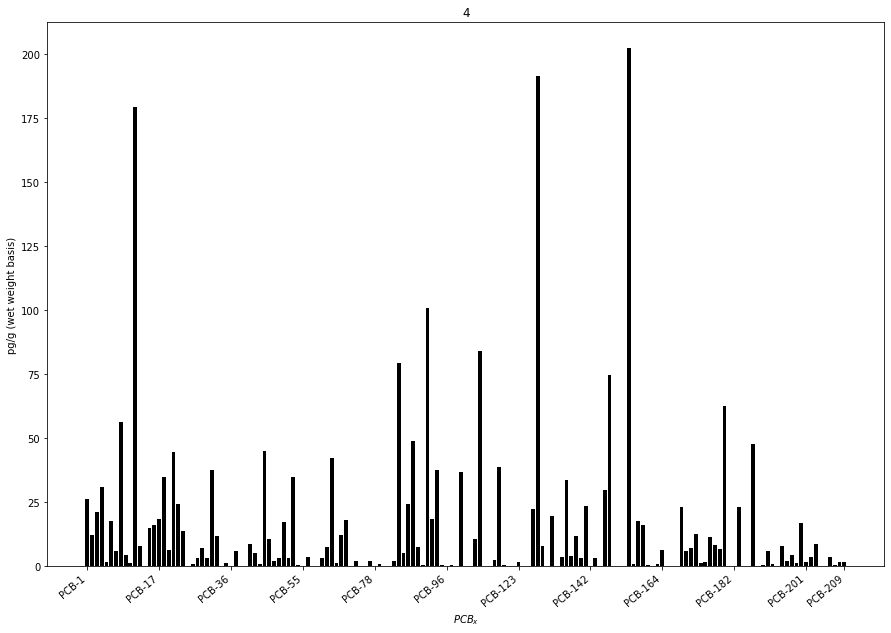

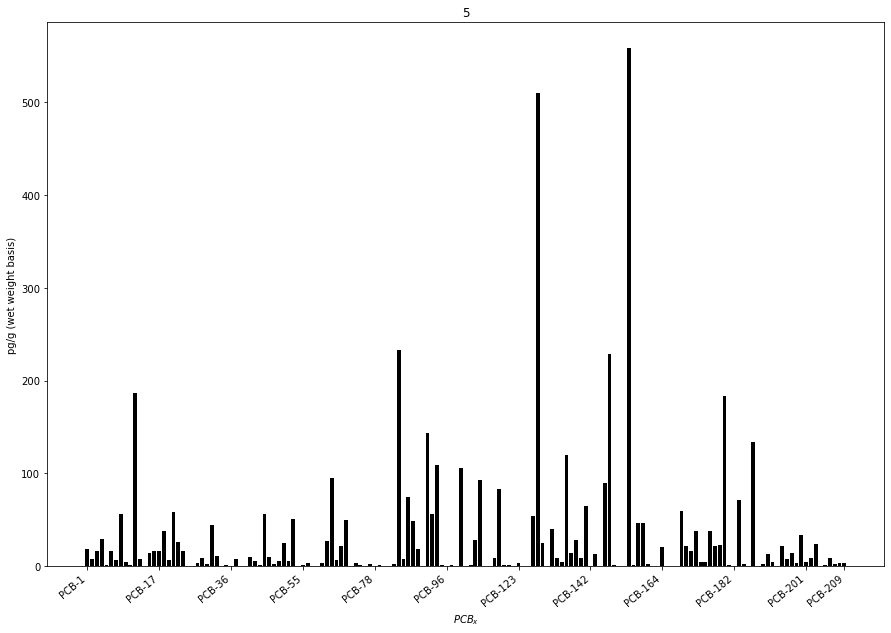

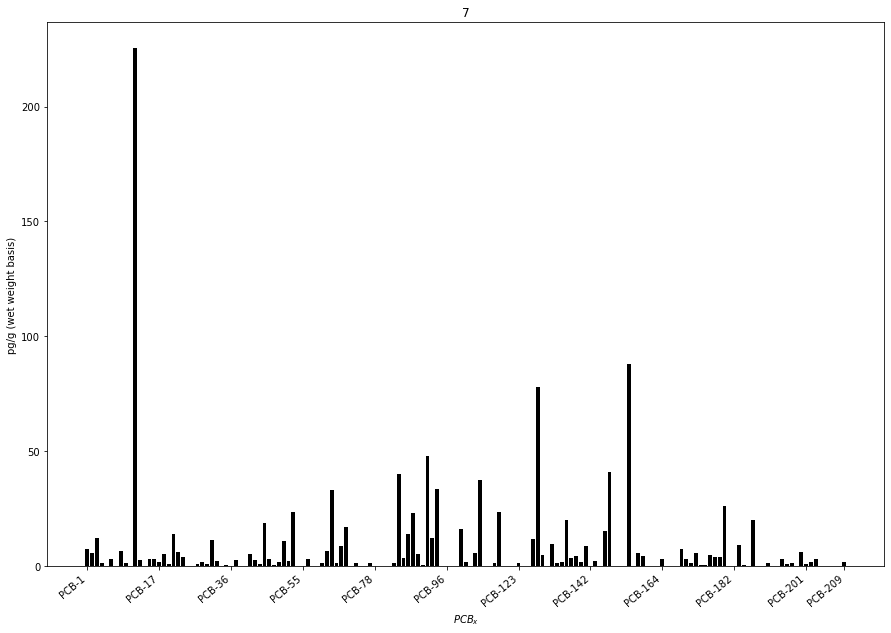

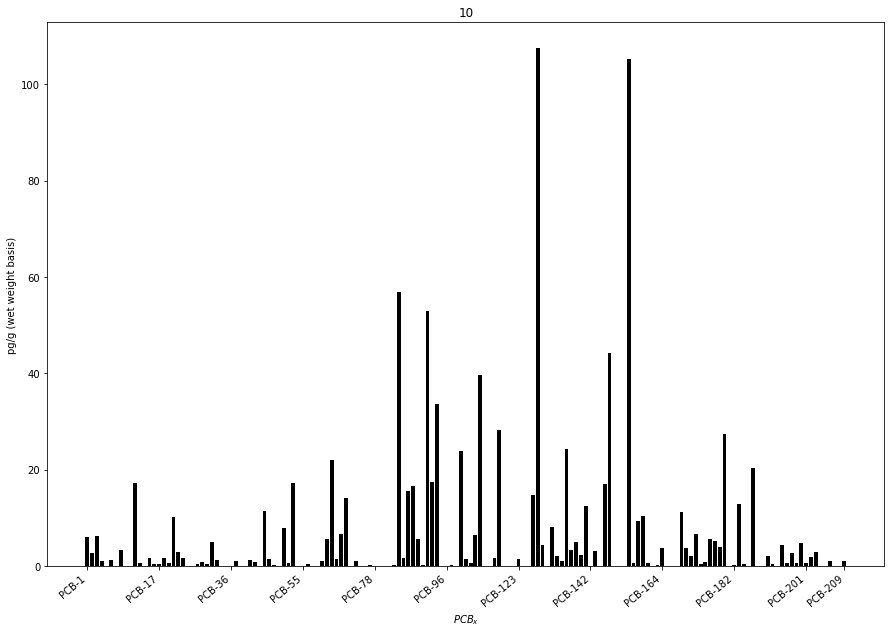

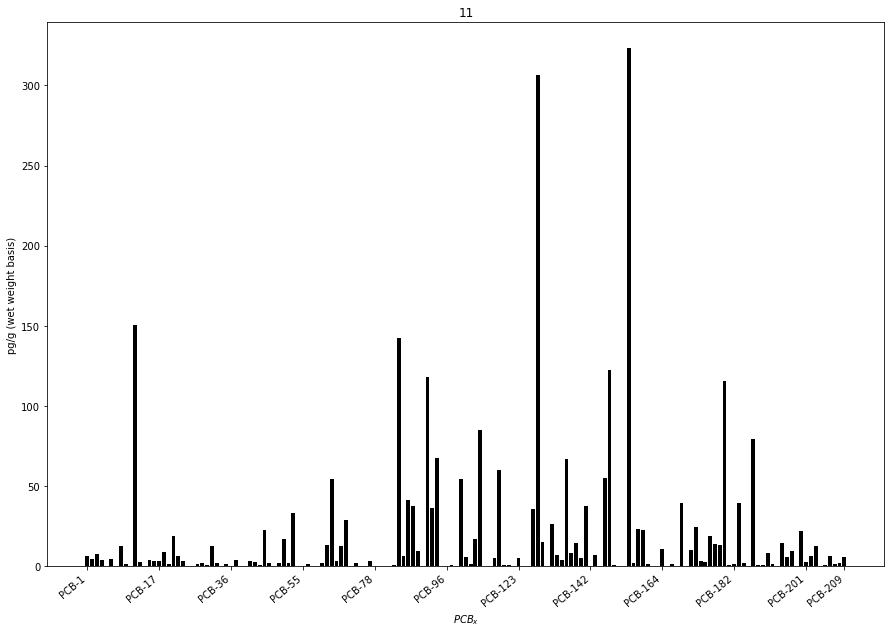

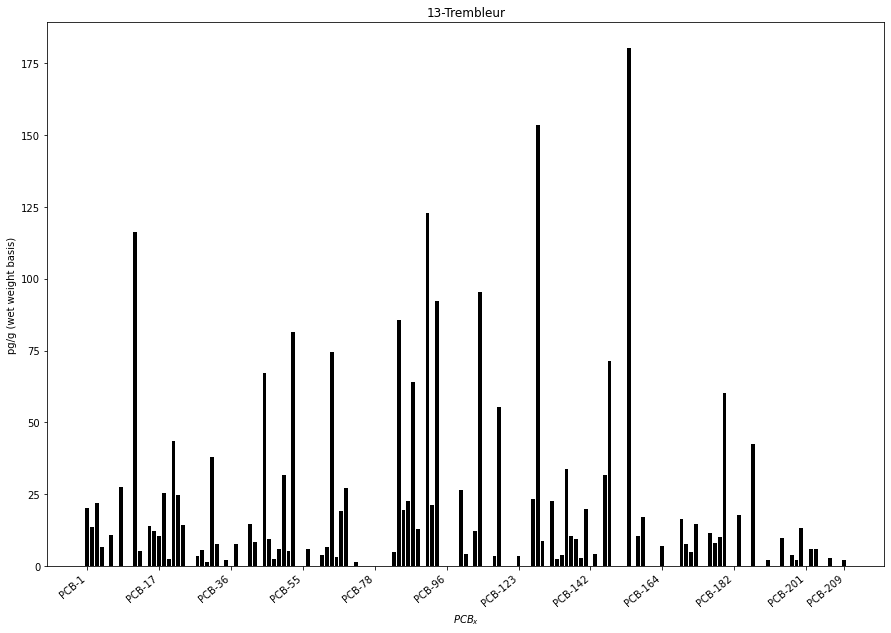

In [244]:
xtick_labels = []
xticks = list(range(0, pcb_corrected.shape[0], 15)) + [pcb_corrected.shape[0]-1]
for i in xticks:
    xtick_labels.append(pcb_corrected.index[i])
for col in pcb_corrected:
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title(col)
    ax.bar(pcb_corrected.index, pcb_corrected[col], color = 'k')
    ax.xaxis.set_ticks(xticks)
    ax.xaxis.set_ticklabels(xtick_labels, rotation = 40, ha = "right")
    ax.set_ylabel("pg/g (wet weight basis)")
    ax.set_xlabel("$PCB_x$")

### all compounds are muted

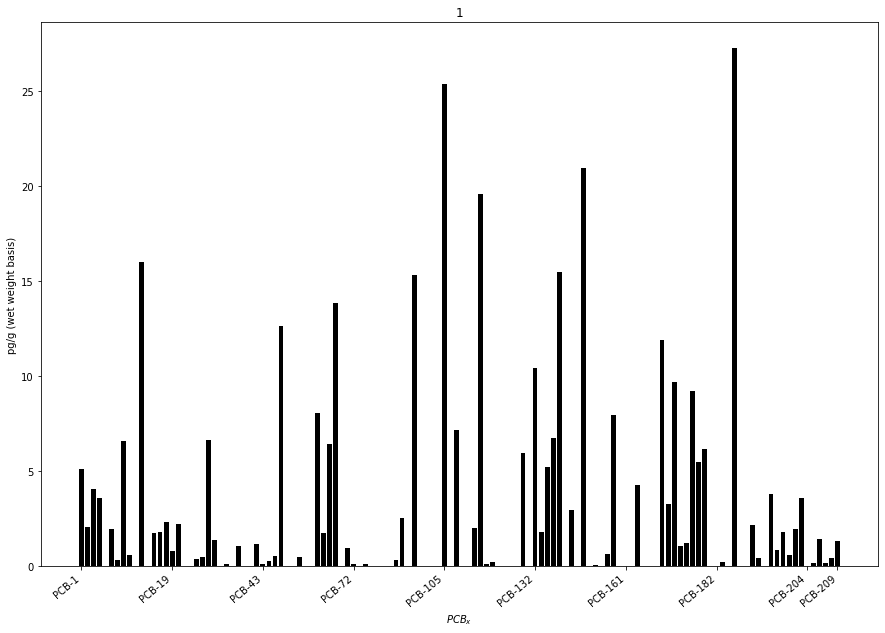

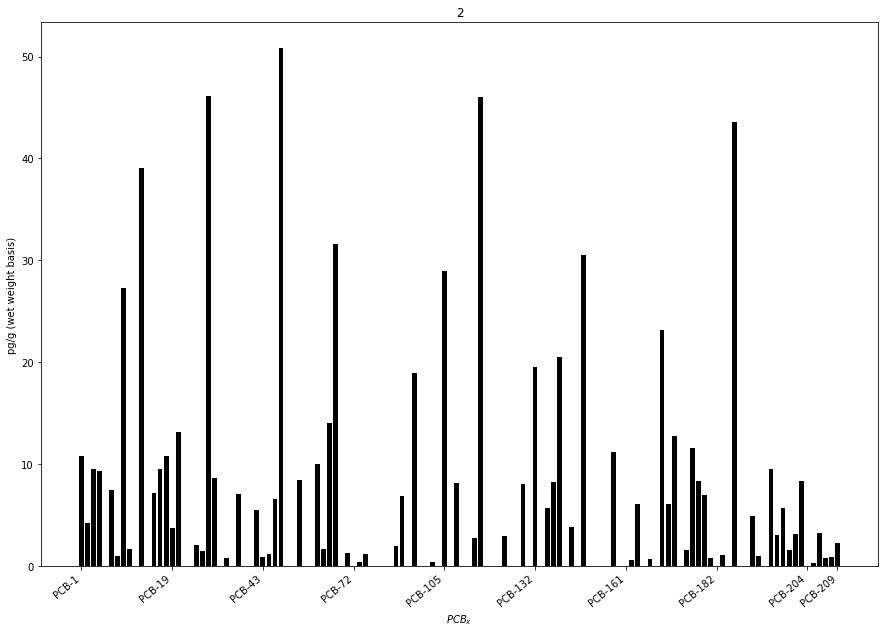

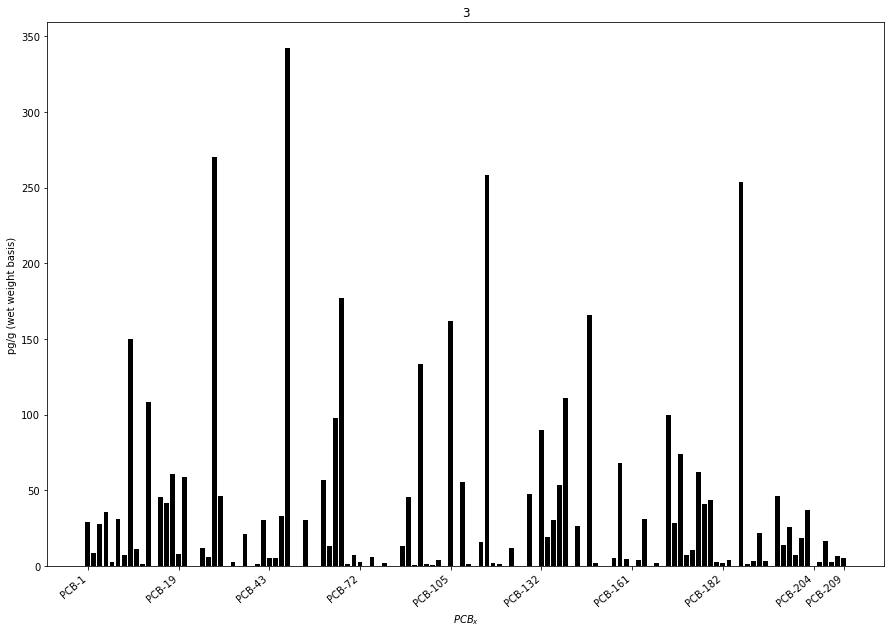

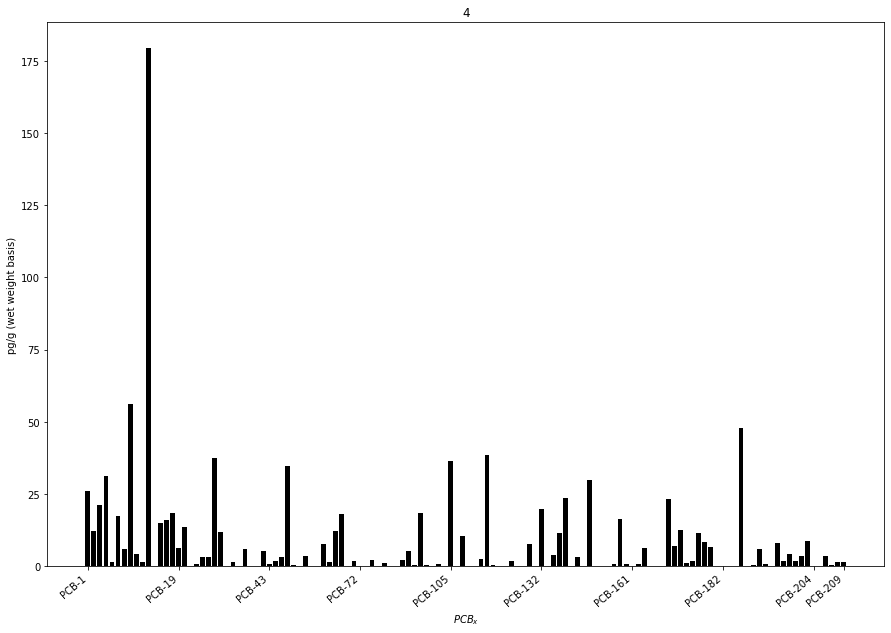

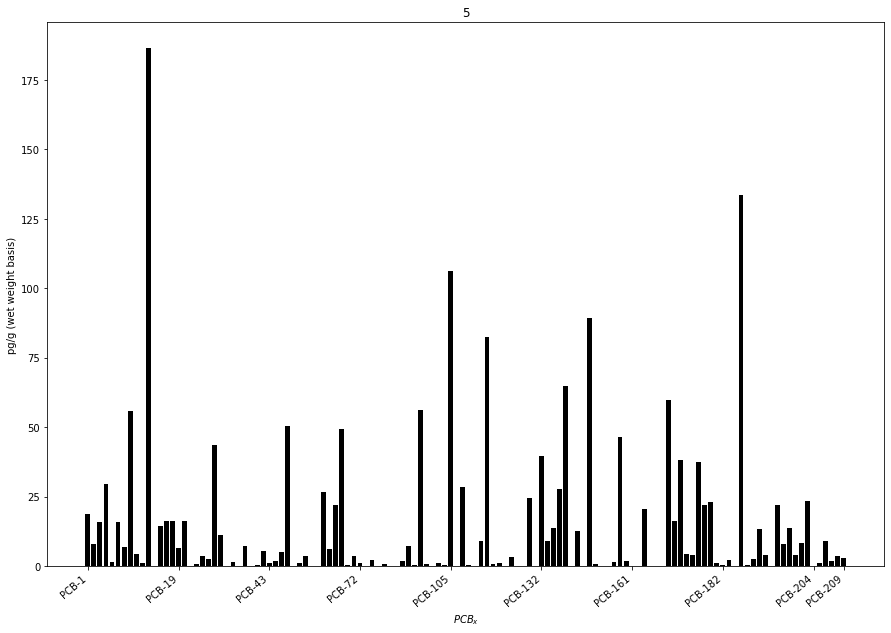

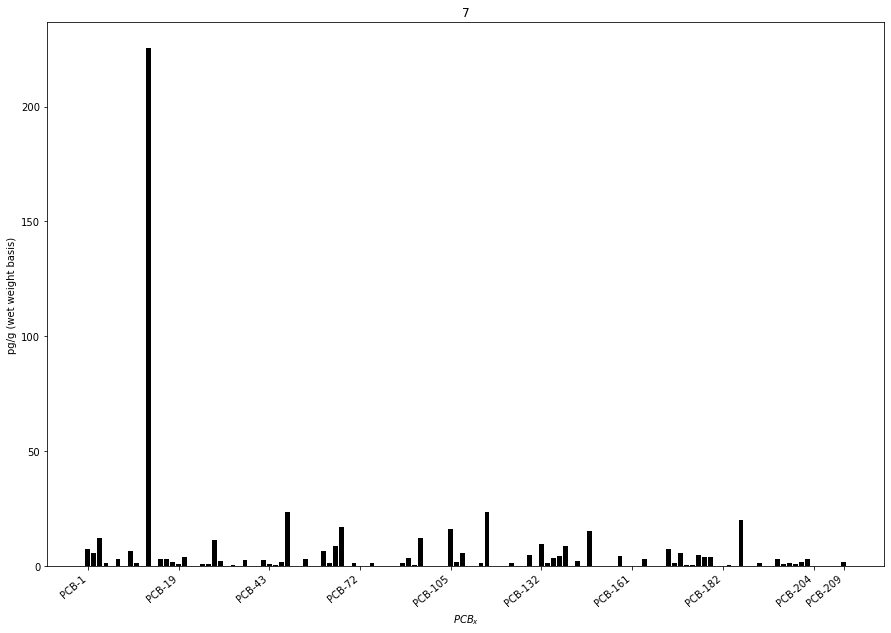

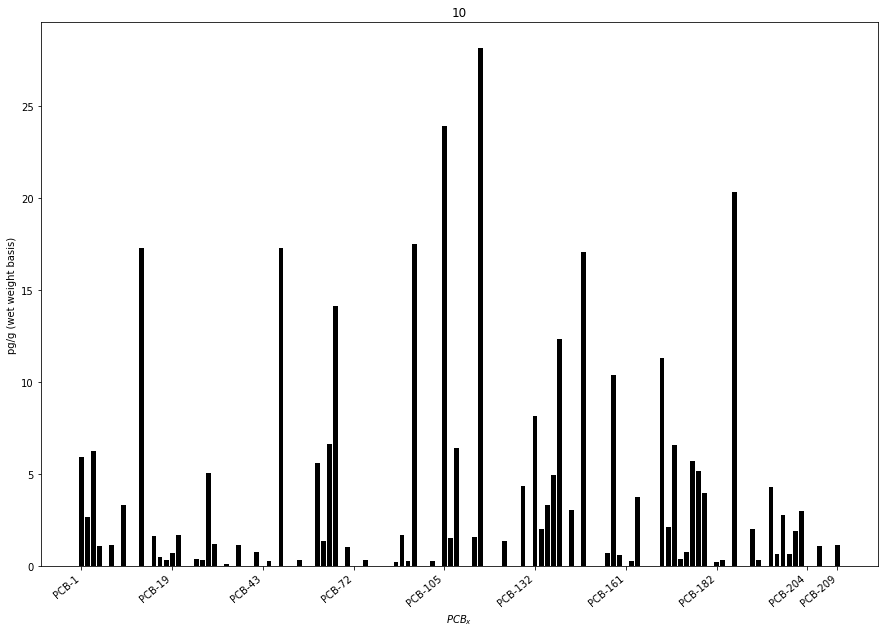

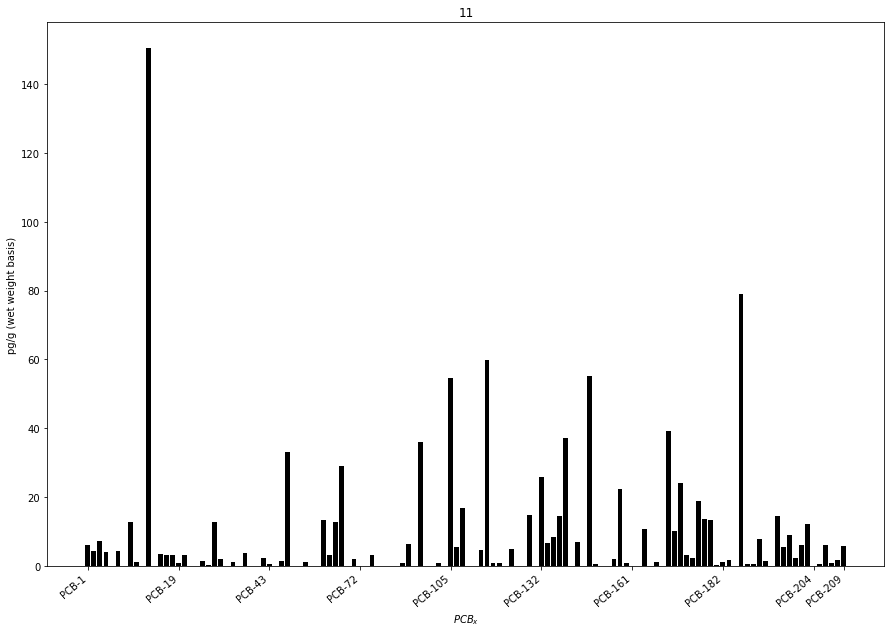

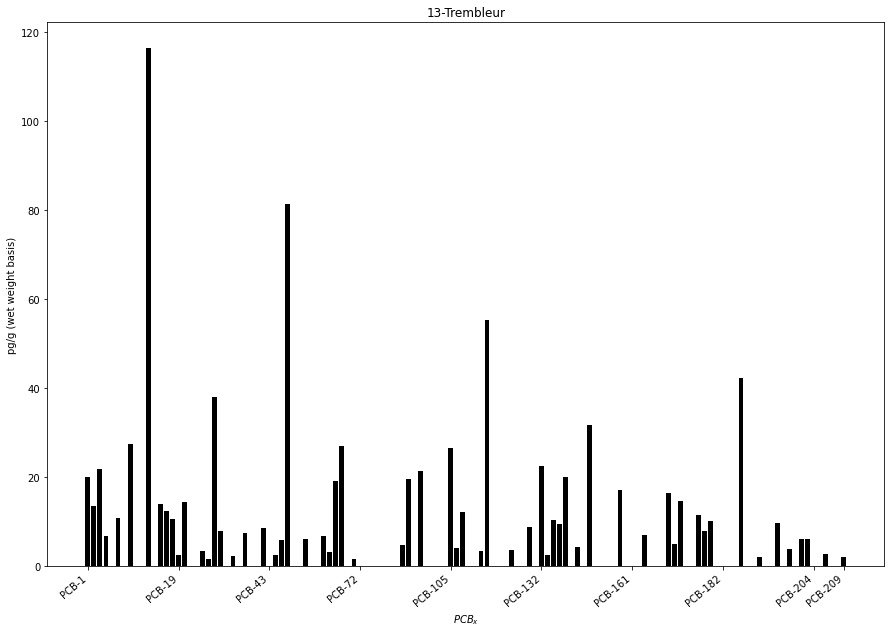

In [258]:
id = ~pcb_corrected.index.str.contains("+", regex=False)
xtick_labels = []
xticks = list(range(0, pcb_corrected.loc[id, :].shape[0], 15)) + [pcb_corrected.loc[id, :].shape[0]-1]
for i in xticks:
    xtick_labels.append(pcb_corrected.loc[id, :].index[i])
for col in pcb_corrected:
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title(col)
    ax.bar(pcb_corrected.index[id], pcb_corrected.loc[id, col], color = 'k')
    ax.xaxis.set_ticks(xticks)
    ax.xaxis.set_ticklabels(xtick_labels, rotation = 40, ha = "right")
    ax.set_ylabel("pg/g (wet weight basis)")
    ax.set_xlabel("$PCB_x$")

### splited compounds

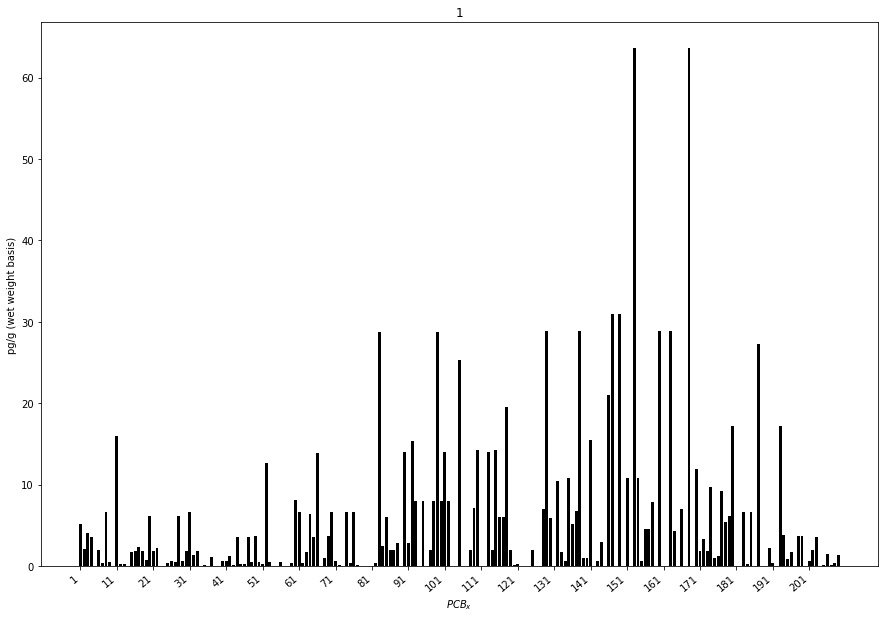

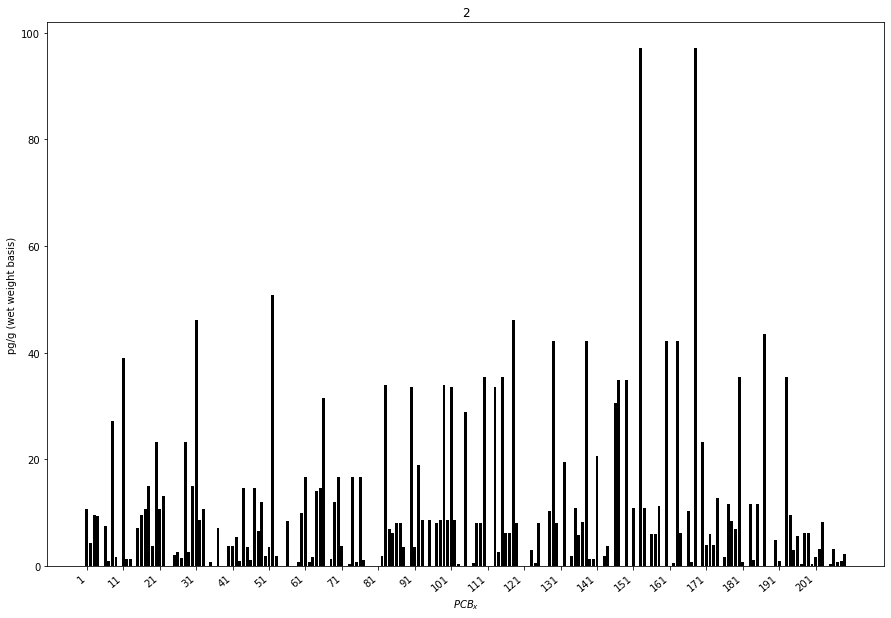

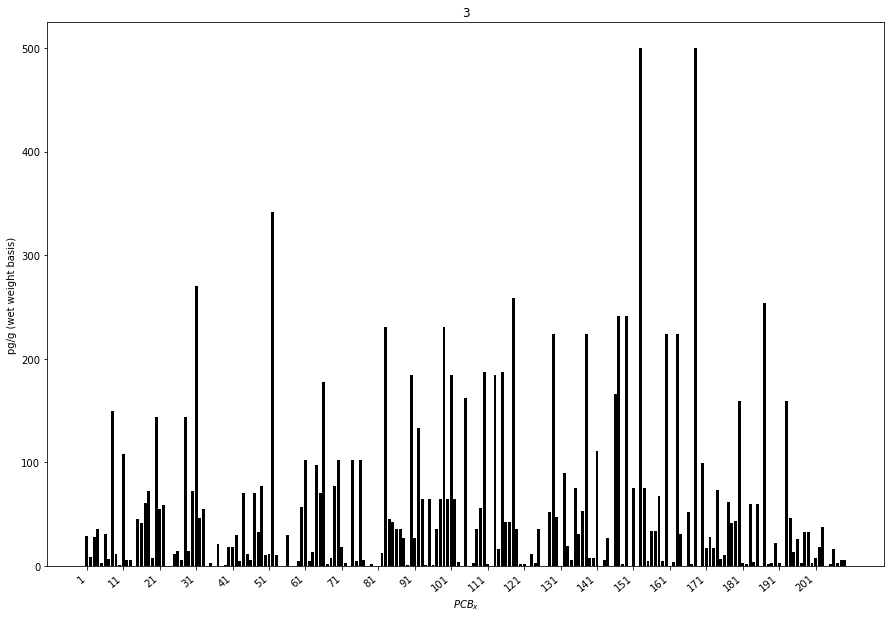

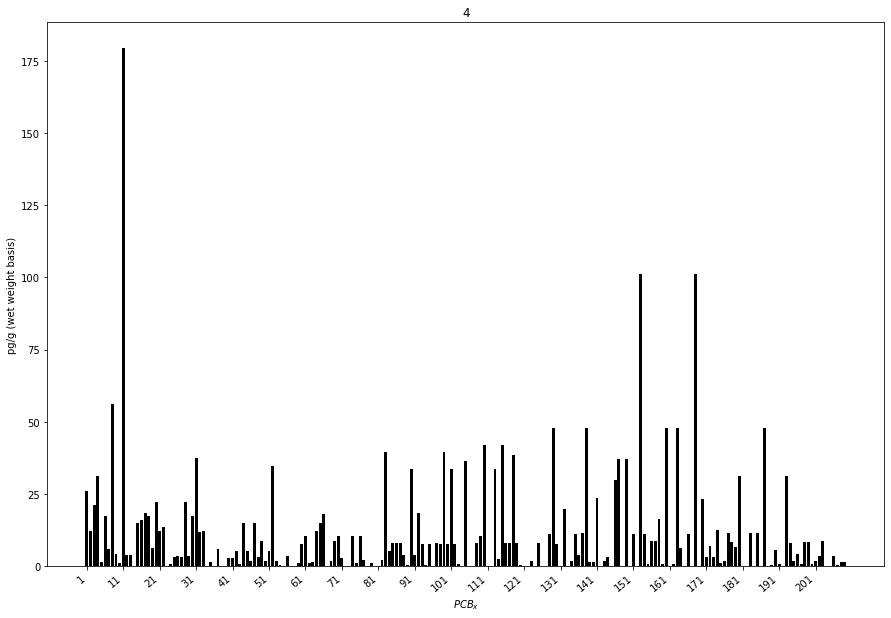

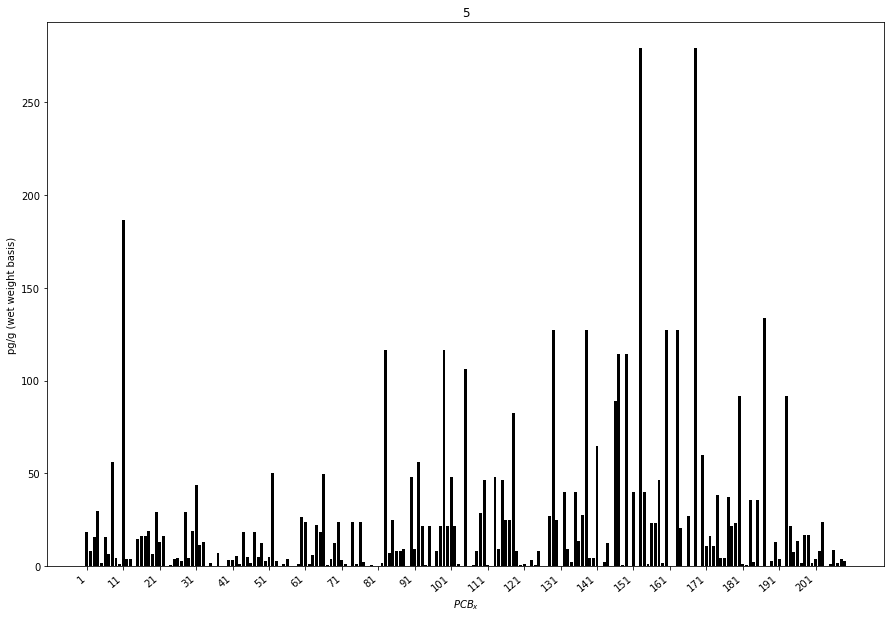

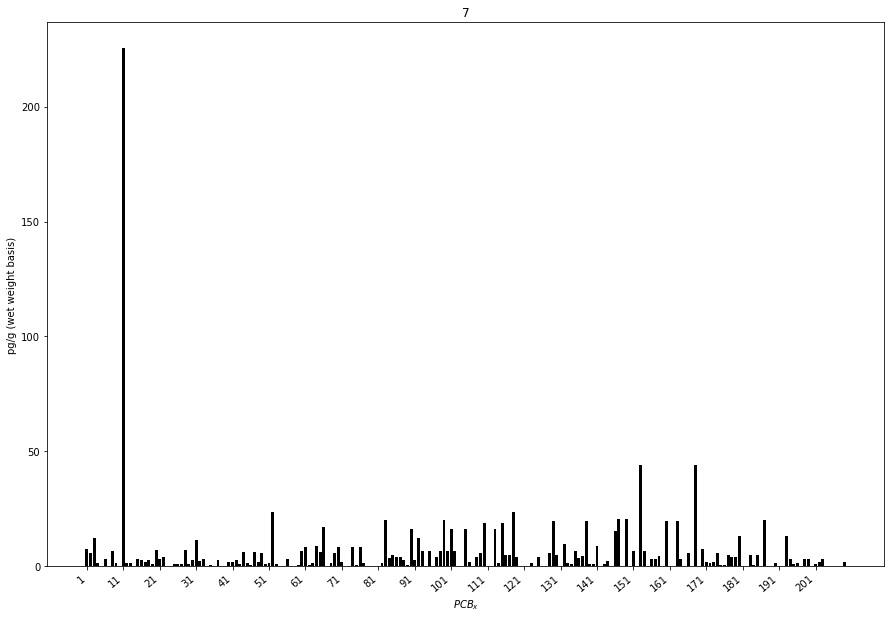

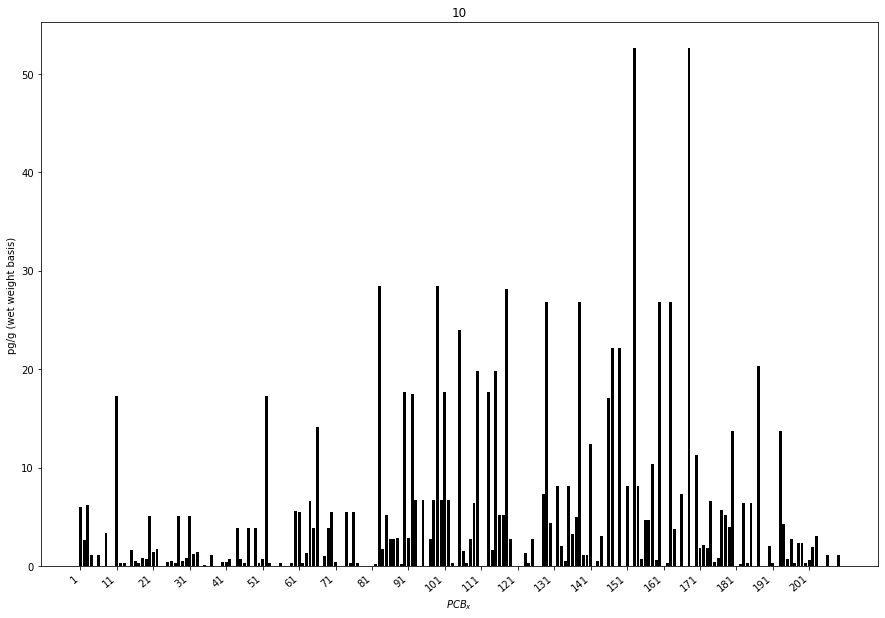

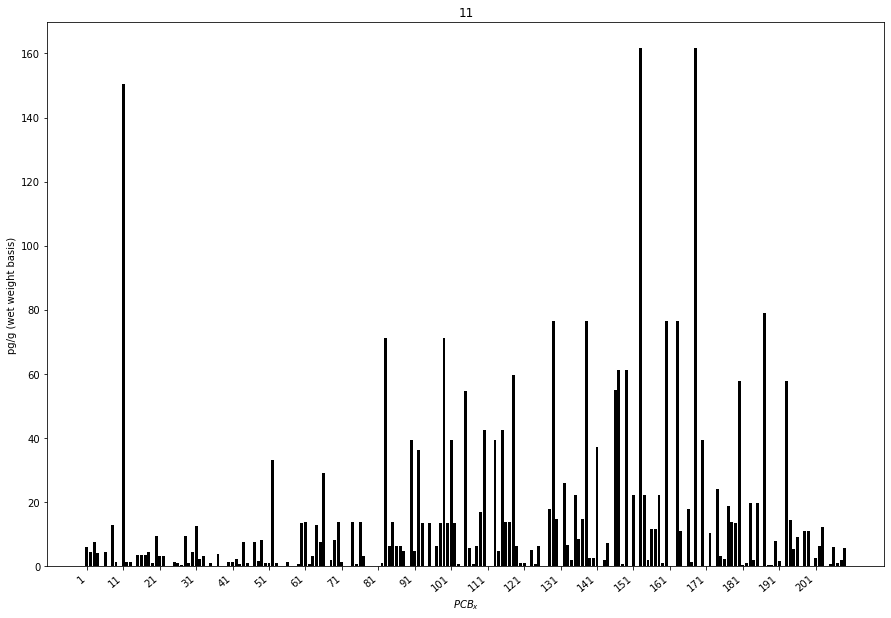

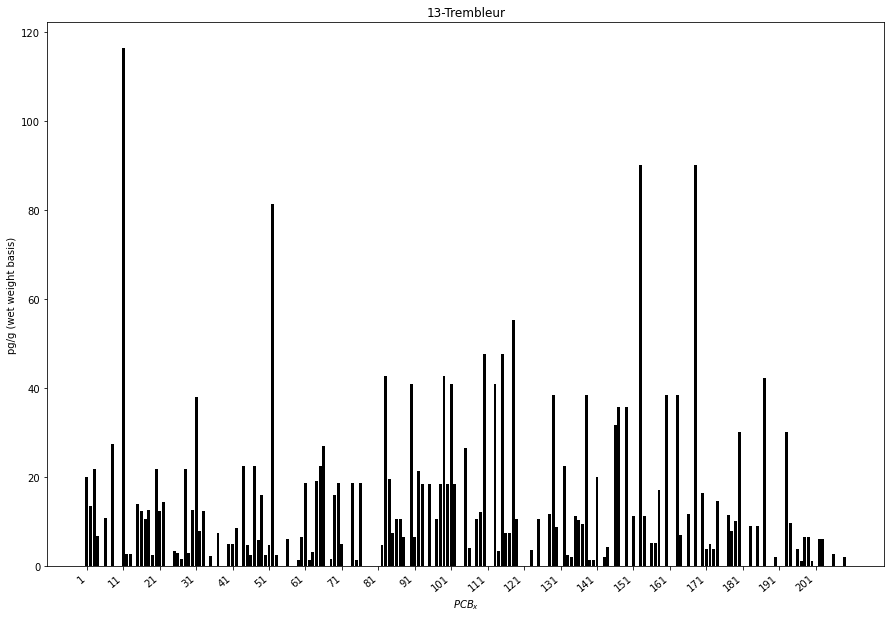

In [278]:
for col in pcb_corrected:
    pcbx = np.zeros((209,))
    id = ~pcb_corrected.index.str.contains("+", regex=False)
    idx = pcb_corrected[id].index.str.removeprefix("PCB-").to_numpy('uint8')-1
    pcbx[idx] = pcb_corrected.loc[id, col].ravel()
    for i in pcb_corrected[~id].index:
        for k , j in enumerate(i.split('+')):
            if k == 0:
                pcbx[int(j.strip()[4:])-1] = pcb_corrected.loc[i, col] / len(i.split('+'))
            else:
                pcbx[int(j.strip())-1] = pcb_corrected.loc[i, col] / len(i.split('+'))
    fig, ax = plt.subplots(figsize = (15, 10))
    ax.set_title(col)
    ax.bar(np.arange(1, 210), pcbx, color = 'k')
    ax.xaxis.set_ticks(np.arange(1, 210, 10))
    ax.xaxis.set_ticklabels(np.arange(1, 210, 10), rotation = 40, ha = "right")
    ax.set_ylabel("pg/g (wet weight basis)")
    ax.set_xlabel("$PCB_x$")
